# Paper 2 - WGCs

## Data preparation

### Paper 2-specific SQL database subset

In [ ]:
import os
# Import the paper-specific paths configuration dataclass
from paper12_config import paths_config, filtering_config, master_config
# Import the specific data preparation function (database subsetting for Paper 2)
from paper12_dataprep import paper_database_subset

# Create an instance of the paths_config dataclass
paths = paths_config(
    source_dir = r"../dbs", # Raw and pre-processed PNK databases - DB2_standard folder
    source_db = r"../dbs/pnk_db2_filtered.sqlite", # The specific, filtered source database - pnk_db2_filtered
    paper_dir = r"..", # Paper 2-specific files and code
    paper_in_db = r"../dbs/pnk_db2_p2_in.sqlite", # The input database created and used in Paper 2 - pnk_db2_p2_in
    paper_out_db = r"../dbs/pnk_db2_p2_out.sqlite", # The output database created and used in Paper 2 - pnk_db2_p2_out
)

filtering = filtering_config(
    filtering_sql_query="""
        SELECT medical_record_id, patient_id
        FROM medical_records_filtered
        """
        # WHERE gdpr4 = 1
        #   AND gdpr10 = 0
        #   AND medical_record_sequence = 1
)

config = master_config(
    paths=paths,
    filtering=filtering
)

# Create the output directory if it doesn't exist to prevent errors
os.makedirs(config.paths.paper_dir, exist_ok=True)

# Call the data subsetting function
paper_database_subset(config)

### Paper 2-specific time-to-event tables

In [ ]:
import os
# Import the paper-specific and analysis-specific configuration dataclasses
from paper12_config import paths_config, timetoevent_config, timetoevent_subsetting_config, master_config
# Import the specific data preparation function (time-to-event table calculations for Paper 2)
from paper12_dataprep import build_timetoevent_table, subset_timetoevent_table

paths = paths_config(
    source_dir = r"../dbs", # Raw and pre-processed PNK databases - DB2_standard folder
    source_db = r"../dbs/pnk_db2_filtered.sqlite", # The specific, filtered source database - pnk_db2_filtered
    paper_dir = r"..", # Paper 2-specific files and code
    paper_in_db = r"../dbs/pnk_db2_p2_in.sqlite", # The input database created and used in Paper 2 - pnk_db2_p2_in
    paper_out_db = r"../dbs/pnk_db2_p2_out.sqlite", # The output database created and used in Paper 2 - pnk_db2_p2_out
)

timetoevent = timetoevent_config(
    # paper_in_db=paths_config.paper_in_db,
    # paper_out_db=paths_config.paper_out_db,
    input_measurements="measurements_p2",
    input_records="medical_records_p2",
    output_table="timetoevent_all",
    weight_loss_targets=[5, 10, 15],
    time_windows=[40, 60, 80],
    window_span=10,
    fetch_from_records=[
        "patient_id", "medical_record_id",
        "dietitian_visits", 
        "sex_f", "age_when_creating_record AS age",
        "height_m",
        "weight_gain_cause", "weight_gain_cause_en", 
        "womens_health_and_pregnancy", "mental_health", "family_issues",
        "medication_disease_injury", "physical_inactivity", "eating_habits", 
        "schedule", "smoking_cessation", "treatment_discontinuation_or_relapse", "pandemic",
        "lifestyle_circumstances", "none_of_above", 
        "genomics_sample_id"
    ],
    followup_columns=[
        "patient_id","medical_record_id",
        "baseline_date","last_aval_date","total_followup_days",
        "dietitian_visits","nr_total_measurements", "instant_dropout", "avg_days_between_measurements",
        "baseline_weight_kg","last_aval_weight_kg","total_wl_kg","total_wl_%", 
        "baseline_bmi","final_bmi","bmi_reduction", "baseline_fat_%","last_aval_fat_%","total_fat_loss_%",
        "baseline_muscle_%","last_aval_muscle_%","total_muscle_change_%"
    ],
    predictor_columns=[
        "sex_f","age","height_m",
        "weight_gain_cause", "weight_gain_cause_en", 
        "womens_health_and_pregnancy", "mental_health", "family_issues",
        "medication_disease_injury", "physical_inactivity", "eating_habits", 
        "schedule", "smoking_cessation", "treatment_discontinuation_or_relapse", "pandemic",
        "lifestyle_circumstances", "none_of_above", 
        "genomics_sample_id"   
    ]
)

timetoevent_subsetting = timetoevent_subsetting_config(
    source_table="timetoevent_all",
    definitions={
        "timetoevent_wgc_compl": ["weight_gain_cause"],
        "timetoevent_gen_compl": ["genomics_sample_id"],
        "timetoevent_wgc_gen_compl": ["weight_gain_cause", "genomics_sample_id"]
    }
)

config = master_config(
    paths=paths,
    timetoevent=timetoevent,
    timetoevent_subsetting=timetoevent_subsetting
)

build_timetoevent_table(config)

subset_timetoevent_table(config)


## Block I - Impact of individual weight gain causes on weight loss

### I/1. Comparative analyses by demographic and WGC groups

In [1]:
# --- Import necessary configs and the new execution function ---
from paper12_config import master_config, paths_config, descriptive_comparisons_config
from descriptive_comparisons import run_descriptive_comparisons

# --- 1. Define Paths ---
paths = paths_config(
    source_dir = r"../dbs", # Raw and pre-processed PNK databases - DB2_standard folder
    source_db = r"../dbs/pnk_db2_filtered.sqlite", # The specific, filtered source database - pnk_db2_filtered
    paper_dir = r"..", # Paper 2-specific files and code
    paper_in_db = r"../dbs/pnk_db2_p2_in.sqlite", # The input database created and used in Paper 2 - pnk_db2_p2_in
    paper_out_db = r"../dbs/pnk_db2_p2_out.sqlite", # The output database created and used in Paper 2 - pnk_db2_p2_out
)
# --- 2. Define the ROW_ORDER once, or customize it per analysis ---
# This can be a global variable in your notebook for convenience

TIME_WINDOWS = [40, 60, 80]
WL_TARGETS = [5, 10, 15]

ROW_ORDER = [
    ("N", "N"),
    # Demographics & baseline anthropometry
    ("delim_demo", "Demographics and baseline anthropometry"),
    ("sex_f", "Sex (% of females)"),
    ("age", "Age (years)"),
    ("height_m", "Height (m)"),
    ("baseline_weight_kg", "Baseline weight (kg)"),
    ("baseline_bmi", "Baseline BMI (kg/m²)"),
    ("baseline_fat_%", "Baseline fat mass (%)"),
    ("baseline_muscle_%", "Baseline muscle mass (%)"),
    # Treatment outcomes
    ("delim_outcomes", "Treatment outcomes"),
    ("total_followup_days", "Follow-up length (days)"),
    ("dietitian_visits", "Number of visits"),
    ("nr_total_measurements", "Number of total measurements"),
    ("avg_days_between_measurements", "Average measurement frequency (days)"),
    ("last_aval_weight_kg", "Last measured weight (kg)"),
    ("total_wl_kg", "Total weight loss (kg)"),
    ("total_wl_%", "Total weight loss (%)"),
    ("final_bmi", "Final BMI (kg/m²)"),
    ("bmi_reduction", "BMI reduction (kg/m²)"),
    ("last_aval_fat_%", "Last measured fat mass (%)"),
    ("total_fat_loss_%", "Total fat mass loss (%)"),
    ("last_aval_muscle_%", "Last measured muscle mass (%)"),
    ("total_muscle_change_%", "Total muscle mass change (%)"),
    ("instant_dropout", "Instant dropouts (n)"),
]
# Add dynamic time window and WL target variables
for w in TIME_WINDOWS:
    ROW_ORDER += [
        (f"{w}d_dropout", f"{w}-day dropouts (n)"),
        (f"{w}d_wl_%", f"{w}-day weight loss (%)"),
        (f"{w}d_bmi_reduction", f"{w}-day BMI reduction (kg/m²)"),
        (f"{w}d_fat_loss_%", f"{w}-day fat mass loss (%)"),
        (f"{w}d_muscle_change_%", f"{w}-day muscle mass change (%)"),
    ]
for t in WL_TARGETS:
    ROW_ORDER += [
        (f"{t}%_wl_achieved", f"Achieved {t}% weight loss (n)"),
        (f"days_to_{t}%_wl", f"Days to {t}% weight loss"),
    ]
ROW_ORDER += [
    # Weight gain causes
    ("delim_wgc", "Self-reported causes of weight gain"),
    ("womens_health_and_pregnancy", "Women's health and pregnancy (yes/no)"),
    ("mental_health", "Mental health (yes/no)"),
    ("family_issues", "Family issues (yes/no)"),
    ("medication_disease_injury", "Medication, disease or injury (yes/no)"),
    ("physical_inactivity", "Physical inactivity (yes/no)"),
    ("eating_habits", "Eating habits (yes/no)"),
    ("schedule", "Schedule (yes/no)"),
    ("smoking_cessation", "Smoking cessation (yes/no)"),
    ("treatment_discontinuation_or_relapse", "Treatment discontinuation or relapse (yes/no)"),
    ("pandemic", "COVID-19 pandemic (yes/no)"),
    ("lifestyle_circumstances", "Lifestyle circumstances (yes/no)"),
    ("none_of_above", "None of the above (yes/no)"),
]

# --- 3. Define your first descriptive analysis ---

analysis1 = descriptive_comparisons_config(
    analysis_name="wgc_cmpl_vs_all",
    input_cohort_name="timetoevent_wgc_compl",
    mother_cohort_name="timetoevent_all",
    demographic_output_table="wgc_cmpl_dmgrph_strt",
    wgc_output_table="wgc_cmpl_wgc_strt",
    wgc_vs_mean_output_table="wgc_cmpl_wgc_vs_mean",
    # bias_plot_filename="wgc_cmpl_datacollection_bias.png",
    row_order=ROW_ORDER,
    fdr_correction=True,
    demographic_strata=[
        "age",
        "sex_f",
        "baseline_bmi"
    ],
    wgc_strata=[
        "womens_health_and_pregnancy",
        "mental_health",
        "family_issues",
        "medication_disease_injury",
        "physical_inactivity",
        "eating_habits",
        "schedule",
        "smoking_cessation",
        "treatment_discontinuation_or_relapse",
        "pandemic",
        "lifestyle_circumstances",
        "none_of_above"
    ],
)

analysis2 = descriptive_comparisons_config(
    analysis_name="wgc_gen_compl_vs_wgccompl",
    input_cohort_name="timetoevent_wgc_gen_compl",
    mother_cohort_name="timetoevent_wgc_compl",
    demographic_output_table="wgc_gen_cmpl_dmgrph_strt",
    wgc_output_table="wgc_gen_cmpl_wgc_strt",
    wgc_vs_mean_output_table="wgc_gen_cmpl_wgc_vs_mean",
    # bias_plot_filename="wgc_gen_cmpl_datacollection_bias.png",
    row_order=ROW_ORDER,
    fdr_correction=True,
    demographic_strata=[
        "age",
        "sex_f",
        "baseline_bmi"
    ],
    wgc_strata=[
        "womens_health_and_pregnancy",
        "mental_health",
        "family_issues",
        "medication_disease_injury",
        "physical_inactivity",
        "eating_habits",
        "schedule",
        "smoking_cessation",
        "treatment_discontinuation_or_relapse",
        "pandemic",
        "lifestyle_circumstances",
        "none_of_above"
    ],
)

# --- 5. Assemble the Master Config ---
config = master_config(
    paths=paths,
    descriptive_comparisons=[analysis1, analysis2]
)

# --- 6. Execute! ---
# This one function call runs all the analyses you defined.
run_descriptive_comparisons(config)


Starting descriptive comparisons pipeline with 2 analysis configurations.

Executing analysis 1/2: 'wgc_cmpl_vs_all'
  FDR correction: ENABLED
  Loaded data: 2463 input records, 17680 mother records.
Running Demographic Stratification...
  Processing variable 2/58: sex_f
  Processing variable 3/58: age
  Processing variable 4/58: height_m
  Processing variable 5/58: baseline_weight_kg
  Processing variable 6/58: baseline_bmi
  Processing variable 7/58: baseline_fat_%
  Processing variable 8/58: baseline_muscle_%
  Processing variable 10/58: total_followup_days
  Processing variable 11/58: dietitian_visits
  Processing variable 12/58: nr_total_measurements
  Processing variable 13/58: avg_days_between_measurements
  Processing variable 14/58: last_aval_weight_kg
  Processing variable 15/58: total_wl_kg
  Processing variable 16/58: total_wl_%
  Processing variable 17/58: final_bmi
  Processing variable 18/58: bmi_reduction
  Processing variable 19/58: last_aval_fat_%
  Processing variabl

### I/Expl vis

Loading WGC data from timetoevent_wgc_compl...
  ✓ Loaded 2463 records
  ✓ Available WGC columns: 12

Generating forest plot(s) for '10%_wl_achieved'...


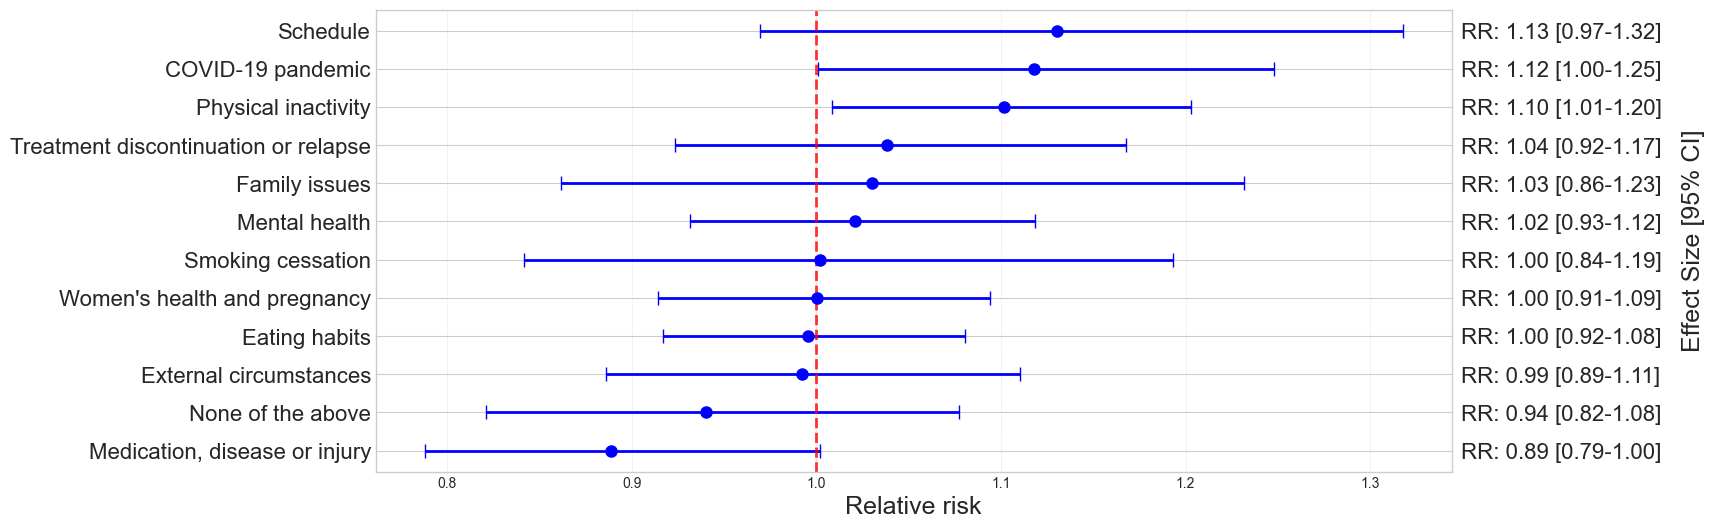

  ✓ Risk Ratio plot saved


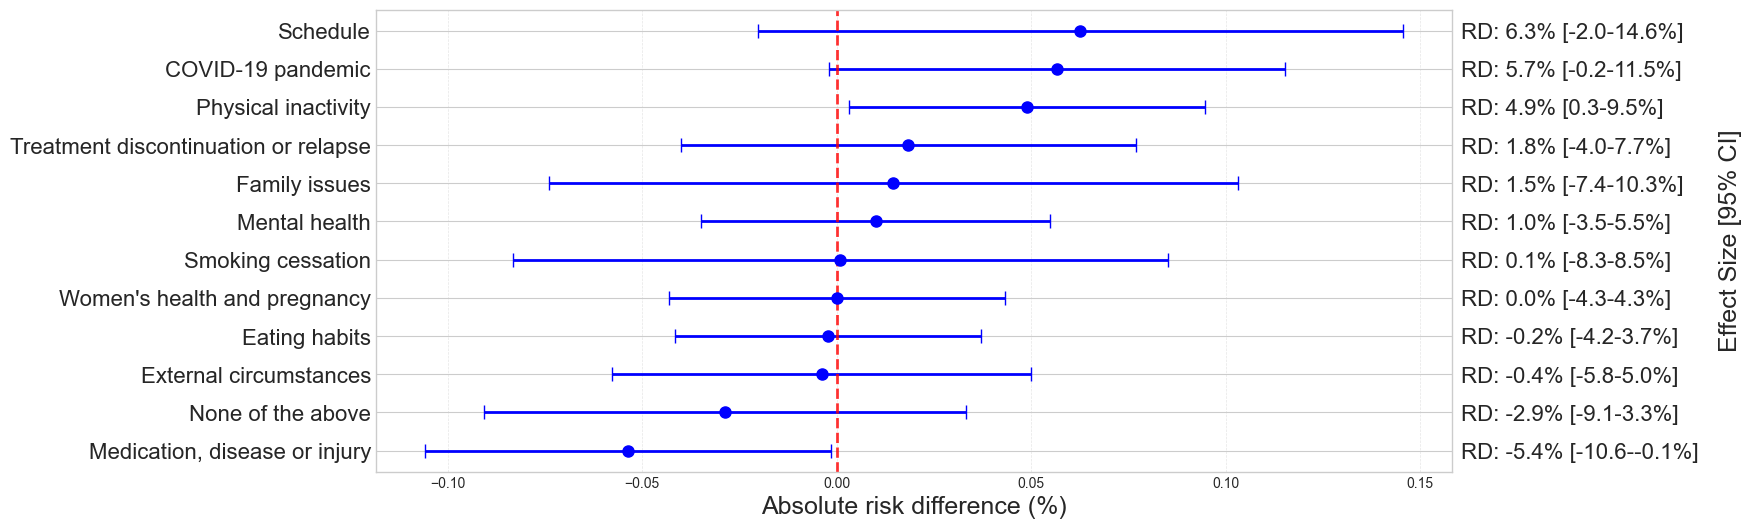

  ✓ Risk Difference plot saved

Generating forest plot(s) for '60d_dropout'...


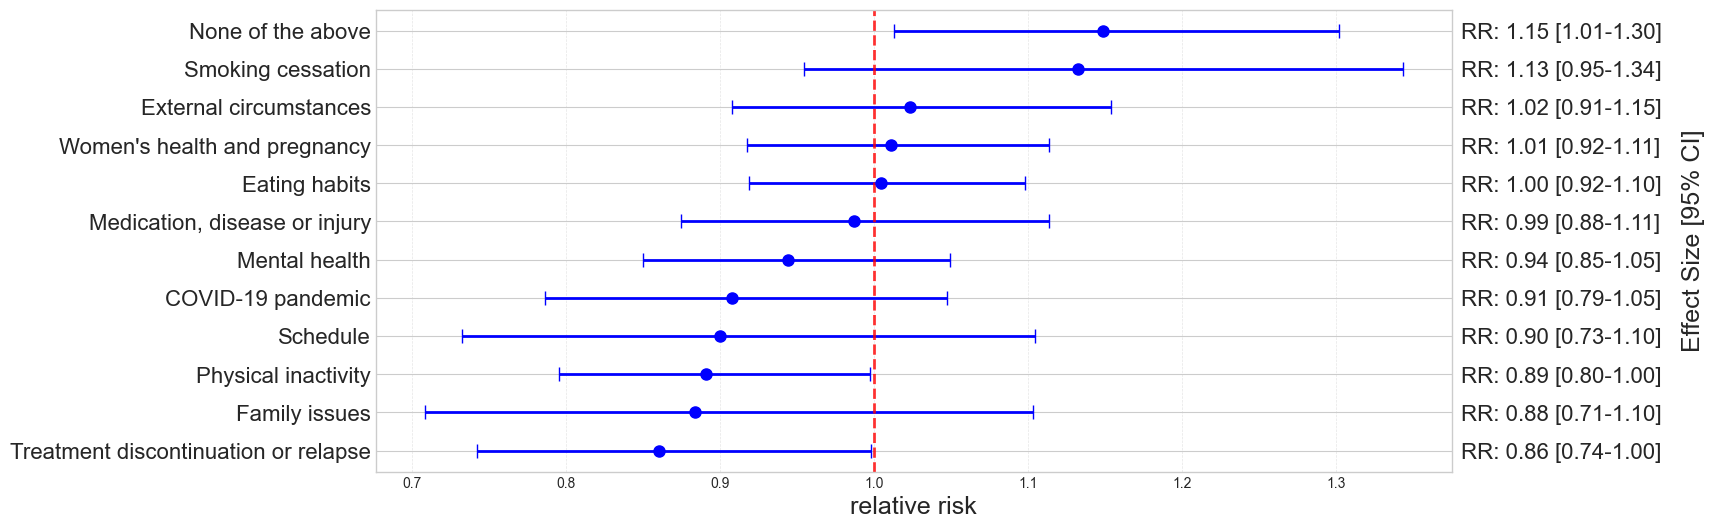

  ✓ Risk Ratio plot saved


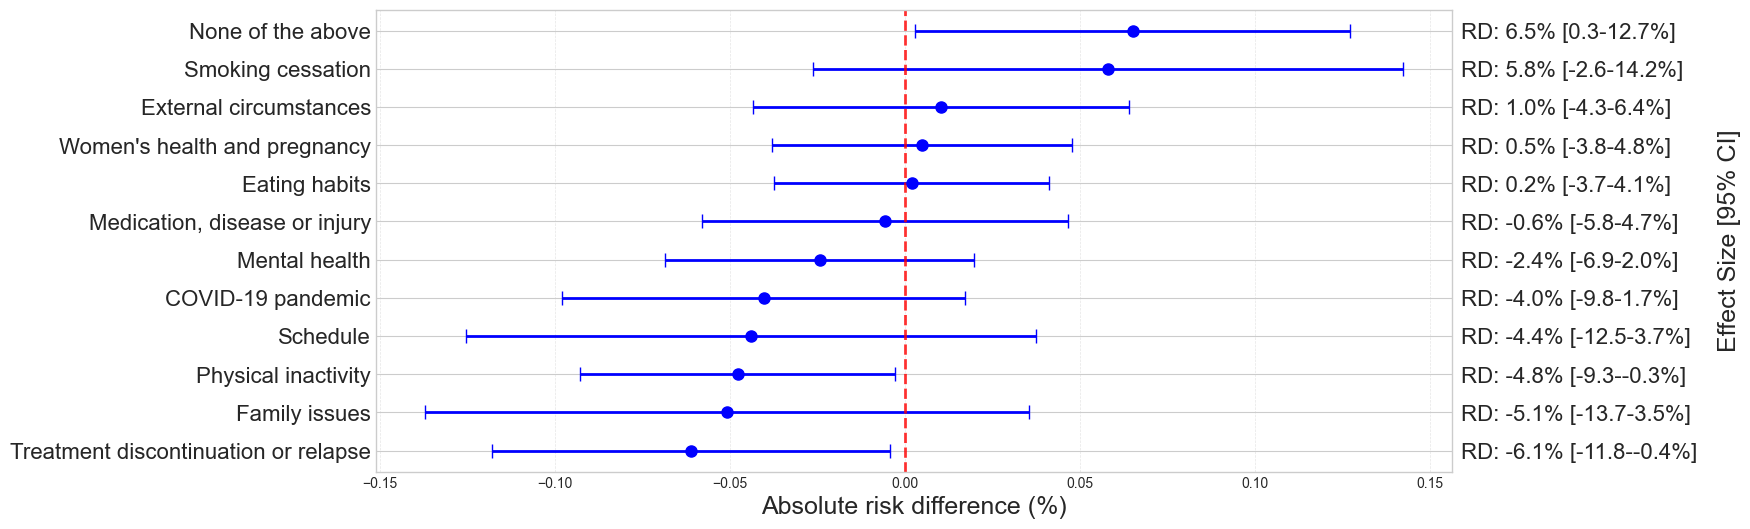

  ✓ Risk Difference plot saved


In [3]:
from wgc_visualizations import *

# Load data
wgc_df = load_wgc_data(
    db_path="../dbs/pnk_db2_p2_in.sqlite",
    table_name="timetoevent_wgc_compl"
)

# wgc_continuous_distributions(
#     wgc_df,
#     variables=[
#         "age",
#         "baseline_weight_kg",
#         "baseline_bmi", 
#         "total_wl_%", 
#         "bmi_reduction",
#         "days_to_10%_wl",
#         "total_followup_days",        
#     ],
#     output_dir='../outputs/wgc_viz_test_20Nov25',
#     # Global settings
#     title='Distribution of {variable} by WGC group',
#     ylabel='{variable}',
#     xlabel='Weight gain cause groups',
#     # Per-variable overrides
#     variable_configs={
#         'age': {
#             'title': 'Age distribution across WGC groups',
#             # 'xlabel': 'Patient clusters',
#             'ylabel': 'Age (years)',

#         },
#         'baseline_bmi': {
#             'title': 'Baseline BMI distribution across WGC groups',
#             # 'xlabel': 'Patient clusters',
#             'ylabel': 'BMI (kg/m²)'
#         },
#         'baseline_weight_kg': {
#             'title': 'Baseline weight distribution across WGC groups',
#             # 'xlabel': 'Patient clusters',
#             'ylabel': 'Weight (kg)'
#         },
#         'total_wl_%"': {
#             'title': 'Total weight loss across WGC groups',
#             # 'xlabel': 'Patient clusters',
#             'ylabel': 'Total weight loss (%)'
#         },
#         'bmi_reduction': {
#             'title': 'BMI reduction across WGC groups',
#             # 'xlabel': 'Patient clusters',
#             'ylabel': 'BMI (kg/m²)'
#         },  
#         'days_to_10%_wl': {
#             'title': 'Weight loss speed as days to 10% weight loss across WGC groups',
#             # 'xlabel': 'Patient clusters',
#             'ylabel': 'Days to 10% weight loss (days)'
#         },  
#         'total_followup_days': {
#             'title': 'Total follow-up length across WGC groups',
#             # 'xlabel': 'Patient clusters',
#             'ylabel': 'Total follow-up (days)'
#         },  
#     }
# )

# wgc_categorical_distributions(
#     wgc_df,
#     variables=[
#         'sex_f', 
#         '10%_wl_achieved', 
#         '60d_dropout'],
#     output_dir='../outputs/wgc_viz_test_20Nov25',
#     # Global settings
#     ylabel='Percentage (%)',
#     xlabel='WGC groups',
#     legend_labels={'achieved': 'Yes', 'not_achieved': 'No'},
#     # Per-variable overrides
#     variable_configs={
#         'sex_f': {
#             'title': 'Sex distribution by WGC group',
#             'legend_labels': {'achieved': 'Women', 'not_achieved': 'Men'}
#         },
#         '10%_wl_achieved': {
#             'title': '10% weight loss achievement rate',
#             'legend_labels': {'achieved': 'Achieved', 'not_achieved': 'Not Achieved'}
#         },
#         '60d_dropout': {
#             'title': 'Dropout rate at 2 months',
#             'legend_labels': {'achieved': 'Dropped Out', 'not_achieved': 'Retained'}
#         }
#     }
# )

plot_wgc_forest(
    wgc_df,
    outcome_variable='10%_wl_achieved',
    output_dir='../outputs/wgc_visualizations',
    effect_type='both',
    title_rr='Risk ratios: 10% weight loss',
    title_rd='Risk differences: 10% weight loss',
    ylabel='Weight gain causes',
    xlabel_rr='Relative risk',
    xlabel_rd='Absolute risk difference (%)'
)

plot_wgc_forest(
    wgc_df,
    outcome_variable='60d_dropout',
    output_dir='../outputs/wgc_visualizations',
    effect_type='both',
    title_rr='Risk Ratios: Dropout at 2 months',
    title_rd='Risk Differences: Dropout at 2 months',
    ylabel='Weight gain causes',
    xlabel_rr='relative risk',
    xlabel_rd='Absolute risk difference (%)'
)

#### mother-daughter cohort comparison on key outcomes

In [1]:
# ===================================================================
# WGC vs Mother Cohort Lollipop Plot - Enhanced with Variable Ordering
# ===================================================================

import sys
import os
sys.path.append('../scripts')

# Import the lollipop plotting functions
from wgc_mother_cohort_lollipop import (
    main, create_lollipop_from_raw_data, 
    get_available_variables, get_variable_categories
)
import pandas as pd
import numpy as np

# ===================================================================
# Configuration with Variable Ordering Control
# ===================================================================

# Choose your approach
PRESERVE_VARIABLE_ORDER = True  # Set to True to preserve your specified order

# Define your variables in the order you want them to appear in the plot
# NOTE: First variable in list will appear at the TOP of the plot
# Last variable in list will appear at the BOTTOM of the plot
variables_in_desired_order = [
    # Demographics (bottom of plot)
    'Sex (% of females)',
    'Age (years)', 
    'Baseline weight (kg)',
    # 'Baseline BMI (kg/m²)',
    
    # Engagement metrics
    'Follow-up length (days)',
    'Number of visits',
    'Instant dropouts (n)',
    '40-day dropouts (n)',
    '60-day dropouts (n)',
    
    # Weight loss outcomes (top of plot - most important)
    'Total weight loss (%)',
    # 'Total weight loss (kg)',
    # 'BMI reduction (kg/m²)',
    'Achieved 5% weight loss (n)',
    'Days to 5% weight loss',
    'Achieved 10% weight loss (n)',
    'Days to 10% weight loss',
    'Achieved 15% weight loss (n)',
    'Days to 15% weight loss', 
    # 'Total fat mass loss (%)',
    # 'Total muscle mass change (%)'
]

# Main configuration
config = {
    'db_path': "../dbs/pnk_db2_p2_out.sqlite",
    'table_name': "wgc_cmpl_dmgrph_strt",
    'output_plot_path': "../outputs/wgc_mother_cohort_lollipop_ordered.png",
    'output_table_path': "../outputs/wgc_mother_cohort_summary_ordered.csv",
    'variables_to_include': variables_in_desired_order,
    'title': "Key Differences: WGC vs All Patients",
    'figsize': (12, 10),
    'preserve_order': PRESERVE_VARIABLE_ORDER
}

# ===================================================================
# Execute the Plot Generation
# ===================================================================

print("=" * 60)
print("WGC vs Mother Cohort Lollipop Plot Generation")
print("=" * 60)
print(f"Variable ordering: {'PRESERVED (first item = top of plot)' if PRESERVE_VARIABLE_ORDER else 'AUTOMATIC (by magnitude)'}")

try:
    pct_data, summary_table = main(
        db_path=config['db_path'],
        table_name=config['table_name'],
        output_plot_path=config['output_plot_path'],
        output_table_path=config['output_table_path'],
        variables_to_include=config['variables_to_include'],
        title=config['title'],
        figsize=config['figsize'],
        preserve_order=config['preserve_order']
    )
    
    print("\n" + "=" * 60)
    print("RESULTS SUMMARY")
    print("=" * 60)
    
    # Show variables in the order they appear in the plot (top to bottom)
    print(f"\nVariables in plot order (TOP to BOTTOM):")
    for i, (_, row) in enumerate(pct_data.iterrows(), 1):
        significance = row['significance']
        pct_change = row['percent_change']
        print(f"{i:2d}. {row['variable']}: {pct_change:+.1f}% {significance}")
    
    # Display key findings
    significant_vars = pct_data[pct_data['significance'].str.contains('\*', na=False)]
    print(f"\nStatistically significant differences ({len(significant_vars)} total):")
    
    for _, row in significant_vars.iterrows():
        print(f"  {row['variable']}: {row['percent_change']:+.1f}% {row['significance']}")
    
    # Show largest absolute differences
    print(f"\nLargest absolute differences:")
    largest_diffs = pct_data.reindex(pct_data['percent_change'].abs().sort_values(ascending=False).index)
    
    for _, row in largest_diffs.head(5).iterrows():
        print(f"  {row['variable']}: {row['percent_change']:+.1f}% {row['significance']}")
    
    print(f"\nPlot saved to: {config['output_plot_path']}")
    print(f"Summary table saved to: {config['output_table_path']}")
    
    # Display summary statistics
    print(f"\nSummary Statistics:")
    print(f"  Total variables analyzed: {len(pct_data)}")
    print(f"  Significant differences: {len(significant_vars)}")
    print(f"  Variables with >5% change: {len(pct_data[pct_data['percent_change'].abs() > 5])}")
    print(f"  Variables with >10% change: {len(pct_data[pct_data['percent_change'].abs() > 10])}")

except Exception as e:
    print(f"Error generating lollipop plot: {str(e)}")
    import traceback
    traceback.print_exc()

print("\n" + "=" * 60)
print("Plot generation complete!")
print("=" * 60)

<>:100: SyntaxWarning: invalid escape sequence '\*'
<>:100: SyntaxWarning: invalid escape sequence '\*'
C:\Users\Felhasználó\AppData\Local\Temp\ipykernel_28944\1291606756.py:100: SyntaxWarning: invalid escape sequence '\*'
  significant_vars = pct_data[pct_data['significance'].str.contains('\*', na=False)]


WGC vs Mother Cohort Lollipop Plot Generation
Variable ordering: PRESERVED (first item = top of plot)
Generating WGC vs Mother Cohort Lollipop Plot...
Extracting comparison data...
Sample sizes - WGC cohort: 2463, Mother cohort: 17680
Calculating percentage changes...
Filtered to 15 requested variables (order preserved)
Found 15 variables for comparison:
  Sex (% of females): +3.5% **
  Age (years): -2.0% **
  Baseline weight (kg): -0.6% 
  Follow-up length (days): +2.8% 
  Number of visits: +26.2% **
  Instant dropouts (n): -18.0% *
  40-day dropouts (n): -8.5% **
  60-day dropouts (n): -4.8% *
  Total weight loss (%): +6.1% **
  Achieved 5% weight loss (n): +3.2% **
  Days to 5% weight loss: -5.6% **
  Achieved 10% weight loss (n): +8.6% **
  Days to 10% weight loss: -3.4% 
  Achieved 15% weight loss (n): +9.3% **
  Days to 15% weight loss: +0.3% 
Creating lollipop plot...
Preserving variable order as specified (reversed for top-to-bottom display)
Lollipop plot saved to: ../outputs/w

#### binary distro bar charts

In [2]:
# Import and run comprehensive categorical analysis
import sys
sys.path.append('scripts')
from wgc_sex_stacked_bars import StackedBarConfig, get_wgc_columns, generate_all_categorical_plots
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

def run_comprehensive_wgc_analysis():
    db_path = r"C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\dbs\pnk_db2_p2_in.sqlite"
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql_query("SELECT * FROM timetoevent_wgc_compl", conn)
    
    wgc_cols = get_wgc_columns(df)
    config = StackedBarConfig()
    
    # Generate all categorical distribution plots
    generated_files = generate_all_categorical_plots(df, wgc_cols, config)
    
    print(f"Generated {len(generated_files)} comprehensive analysis charts!")
    return generated_files

# Usage: 
files = run_comprehensive_wgc_analysis()



Generating plot for Sex...
Performing statistical tests...
  womens_health_and_pregnancy: p-value = 0.0000 (chi_squared)
  mental_health: p-value = 0.0013 (chi_squared)
  family_issues: p-value = 0.0004 (chi_squared)
  medication_disease_injury: p-value = 0.1803 (chi_squared)
  physical_inactivity: p-value = 0.0000 (chi_squared)
  eating_habits: p-value = 0.0038 (chi_squared)
  schedule: p-value = 0.0244 (chi_squared)
  smoking_cessation: p-value = 0.0770 (chi_squared)
  treatment_discontinuation_or_relapse: p-value = 0.2193 (chi_squared)
  pandemic: p-value = 0.9815 (chi_squared)
  lifestyle_circumstances: p-value = 0.5714 (chi_squared)
  none_of_above: p-value = 0.0001 (chi_squared)
Applied FDR correction to 12 tests
  Saved: ../outputs/stacked_bars\wgc_sex_enhanced_proportional_bars.png

Generating plot for Age Group...
Performing statistical tests...
  womens_health_and_pregnancy: p-value = 0.0088 (chi_squared)
  mental_health: p-value = 0.5329 (chi_squared)
  family_issues: p-val

#### cont distro violins

Investigating data for baseline_weight_kg:
  Min value: 53.5
  Max value: 133.5
  Negative values count: 0
Performing statistical tests for baseline_weight_kg...
  womens_health_and_pregnancy: p-value = 0.0000
  mental_health: p-value = 0.0038
  family_issues: p-value = 0.4876
  medication_disease_injury: p-value = 0.6621
  physical_inactivity: p-value = 0.0000
  eating_habits: p-value = 0.1068
  schedule: p-value = 0.1960
  smoking_cessation: p-value = 0.0471
  treatment_discontinuation_or_relapse: p-value = 0.9230
  pandemic: p-value = 0.7045
  lifestyle_circumstances: p-value = 0.6784
  none_of_above: p-value = 0.0013
Applied FDR correction to 12 tests


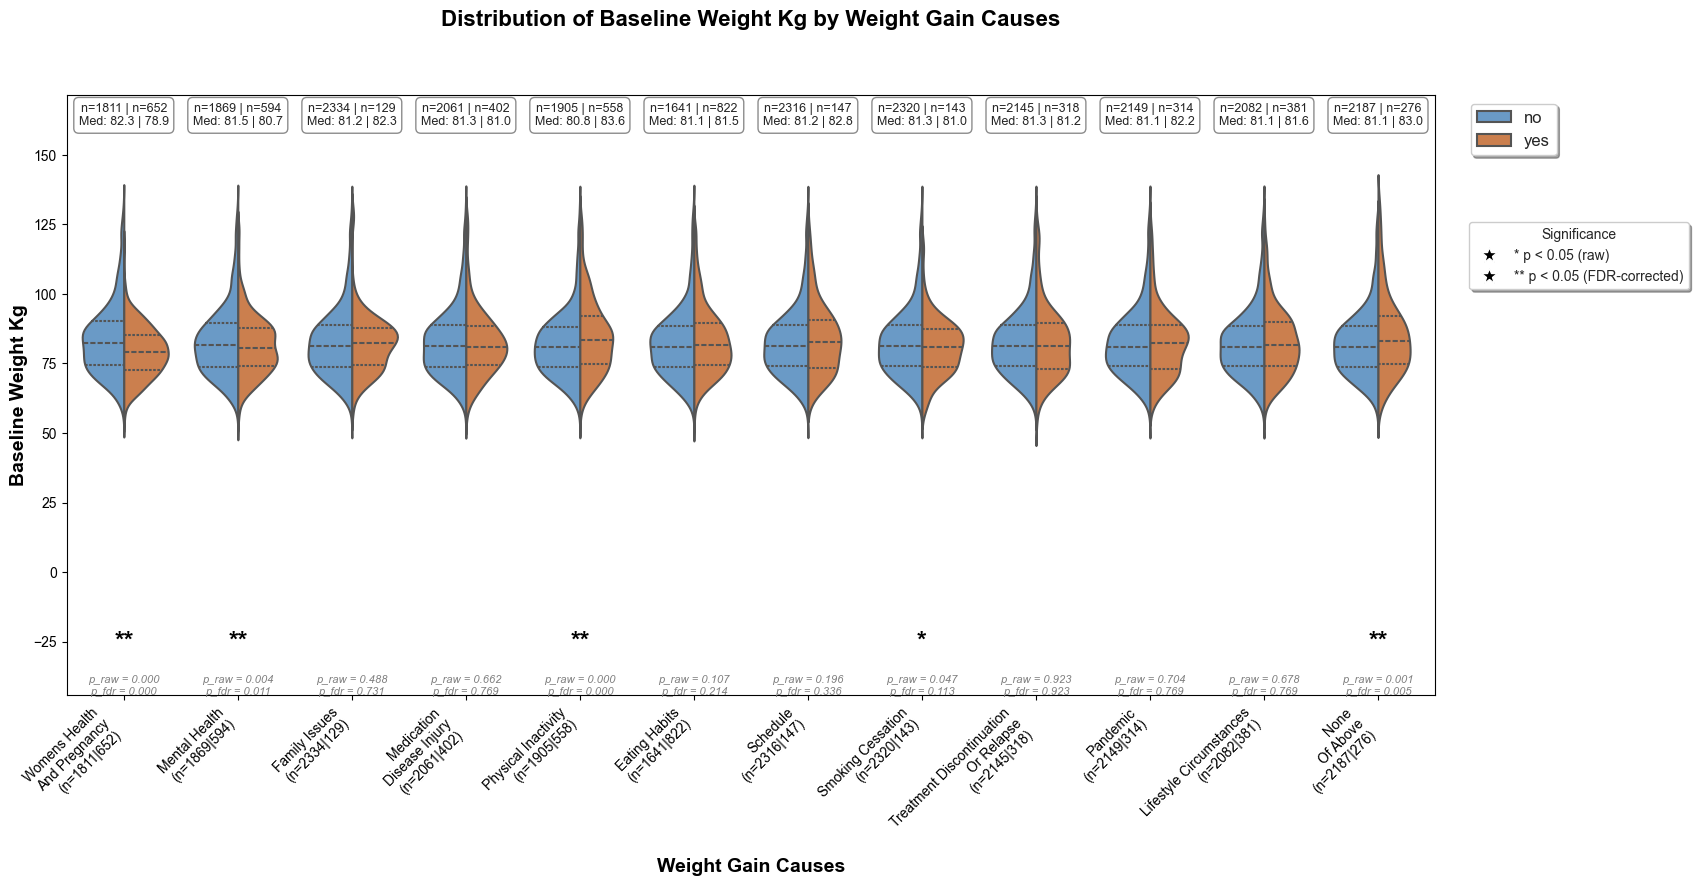

Investigating data for total_wl_%:
  Min value: -36.14595210946408
  Max value: 12.434554973821989
  Negative values count: 2266
Performing statistical tests for total_wl_%...
  womens_health_and_pregnancy: p-value = 0.6037
  mental_health: p-value = 0.7959
  family_issues: p-value = 0.5873
  medication_disease_injury: p-value = 0.2626
  physical_inactivity: p-value = 0.1120
  eating_habits: p-value = 0.4821
  schedule: p-value = 0.7070
  smoking_cessation: p-value = 0.4649
  treatment_discontinuation_or_relapse: p-value = 0.8347
  pandemic: p-value = 0.0366
  lifestyle_circumstances: p-value = 0.1780
  none_of_above: p-value = 0.6163
Applied FDR correction to 12 tests


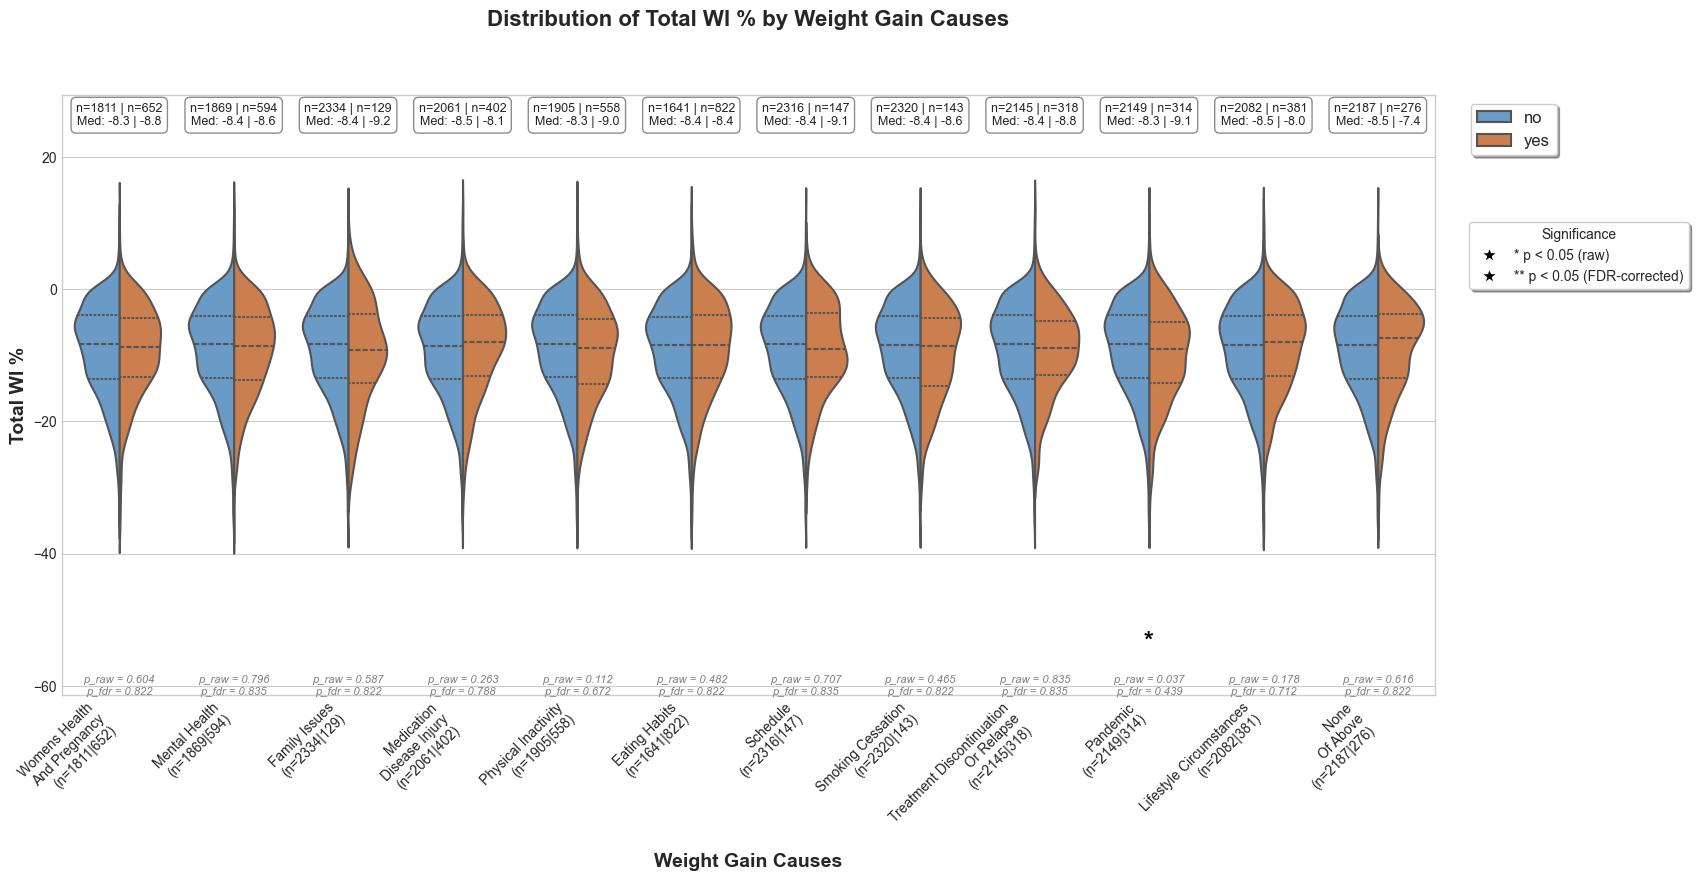

Investigating data for total_followup_days:
  Min value: 1
  Max value: 991
  Negative values count: 0
Performing statistical tests for total_followup_days...
  womens_health_and_pregnancy: p-value = 0.8939
  mental_health: p-value = 0.5066
  family_issues: p-value = 0.3465
  medication_disease_injury: p-value = 0.9325
  physical_inactivity: p-value = 0.0187
  eating_habits: p-value = 0.7600
  schedule: p-value = 0.2965
  smoking_cessation: p-value = 0.6901
  treatment_discontinuation_or_relapse: p-value = 0.0601
  pandemic: p-value = 0.0038
  lifestyle_circumstances: p-value = 0.7042
  none_of_above: p-value = 0.2630
Applied FDR correction to 12 tests


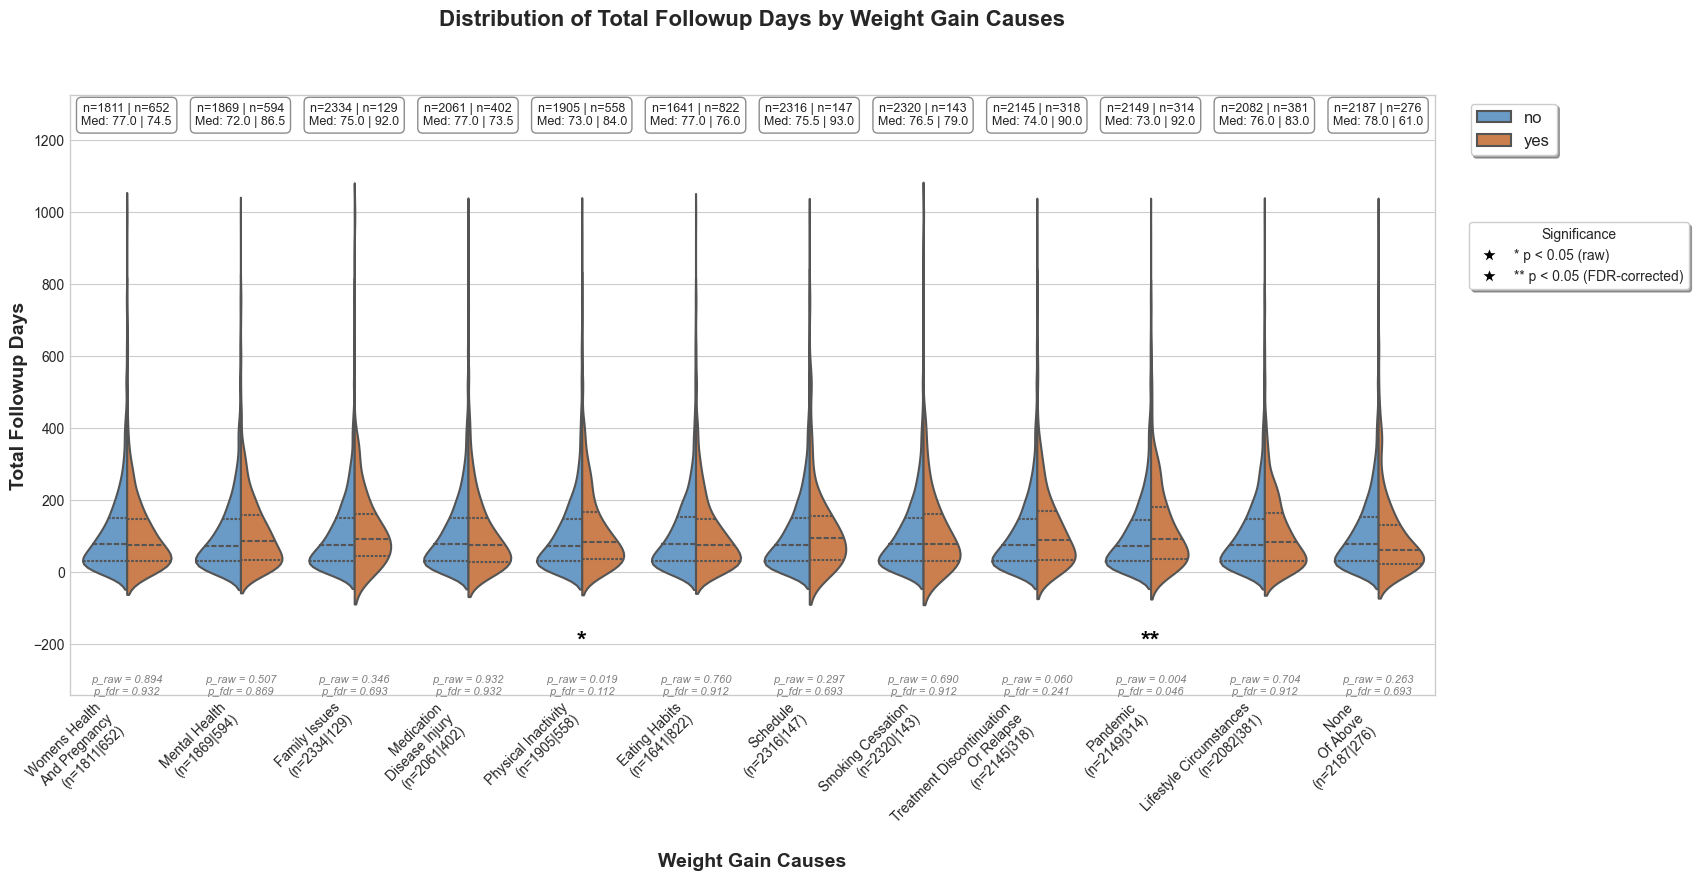

In [1]:
# Import and run enhanced violin plots with statistical testing
import sys
sys.path.append('scripts')
from wgc_violin_plots import ViolinPlotConfig, get_wgc_columns, create_enhanced_split_violin_plot
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

def plot_enhanced_violin_plots():
    db_path = r"C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\dbs\pnk_db2_p2_in.sqlite"
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql_query("SELECT * FROM timetoevent_wgc_compl", conn)
    
    wgc_cols = get_wgc_columns(df)
    config = ViolinPlotConfig()
    
    variables = ["baseline_weight_kg", "total_wl_%", "total_followup_days"]
    
    for var in variables:
        fig = create_enhanced_split_violin_plot(df, var, wgc_cols, config)
        plt.show()

# Usage: 
plot_enhanced_violin_plots()


### I/2. Influence of weight gain causes in weight loss-related predictions

#### I/2.1. Random forest feature imporance analyses

##### I/2.1. prediction to run

--- Initialized Analysis: 10% weight loss achievement by WGCs, adjusted for age, sex and baseline BMI ---
--- Significance testing enabled: Gini=True, SHAP=True ---
Data prepared. Final sample size: 2463
>>> Running GridSearchCV for hyperparameter tuning...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
>>> Best params found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 20}
Model training complete.
Performance: F1=0.505, AUROC=0.586
Calculating SHAP values...


 99%|===================| 1469/1478 [00:48<00:00]        

All calculations complete.
Starting feature importance significance testing...
Testing Gini significance with shadow features...
DEBUG: Created 15 shadow features
DEBUG: Shadow feature names: ['womens_health_and_pregnancy_shadow', 'mental_health_shadow', 'family_issues_shadow']...
DEBUG: Original features: 15
DEBUG: Shadow features: 15
DEBUG: Total augmented features: 30
DEBUG Shadow importances stats:
  Min: 0.010246
  Max: 0.145952
  Mean: 0.033066
  Median: 0.018597
  Top 3 shadow features: [('baseline_bmi_shadow', np.float64(0.14595159415337572)), ('age_shadow', np.float64(0.12660026336292865)), ('mental_health_shadow', np.float64(0.0221381489795736))]
DEBUG Threshold options:
  Max shadow: 0.145952
  95th percentile: 0.132406
  Mean + 2*std: 0.114715
DEBUG Significant features by method:
  Max threshold: 1 features
  95th percentile (SELECTED): 1 features
  Statistical: 2 features
USING 95th percentile method for more stable results
DEBUG Gini significance: threshold=0.132406
DEBU

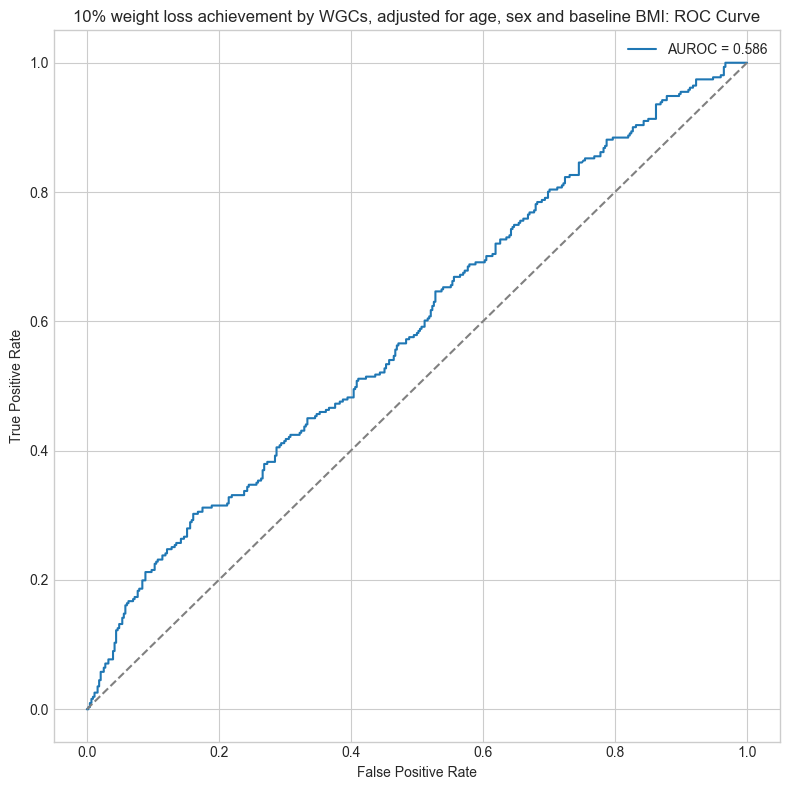

Generating individual feature importance plots...
DEBUG ANNOTATION: Ordered snake_case names: ['smoking_cessation', 'none_of_above', 'schedule', 'family_issues', 'pandemic', 'eating_habits', 'treatment_discontinuation_or_relapse', 'lifestyle_circumstances', 'womens_health_and_pregnancy', 'mental_health', 'medication_disease_injury', 'physical_inactivity', 'sex_f', 'age', 'baseline_bmi']
DEBUG ANNOTATION: Significant snake_case names: ['baseline_bmi']
DEBUG ANNOTATION: Current labels on plot: ['Smoking cessation', 'None of the above', 'Schedule', 'Family issues', 'COVID-19 pandemic', 'Eating habits', 'Treatment discontinuation or relapse', 'External circumstances', "Women's health and pregnancy", 'Mental health', 'Medication, disease or injury', 'Physical inactivity', 'Sex (female)', 'Age (years)', 'Baseline BMI (kg/m²)']
DEBUG ANNOTATION: Feature 0: 'smoking_cessation' -> 'Smoking cessation' -> Significant: False
DEBUG ANNOTATION: Applied gray to 'smoking_cessation': 'Smoking cessation

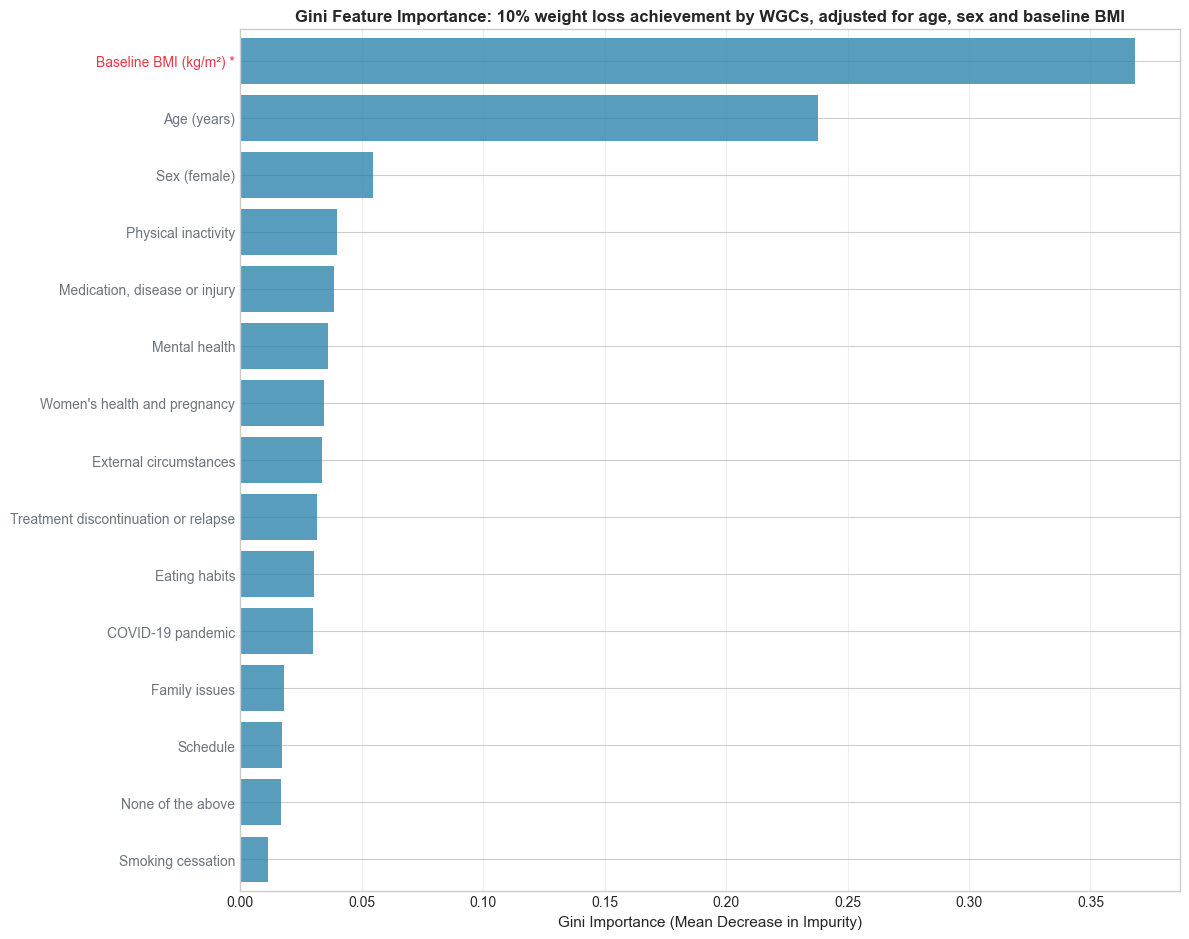

SHAP beeswarm plot saved to: C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/rf_outputs\10% weight loss achievement by WGCs, adjusted for age, sex and baseline BMI_shap_beeswarm.png


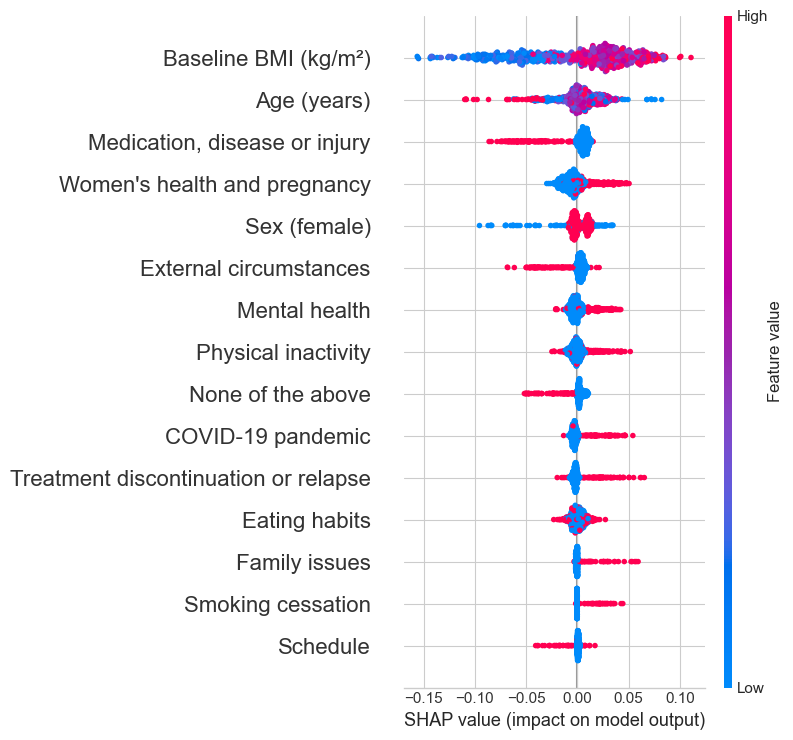

Mean SHAP plot saved to: C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/rf_outputs\10% weight loss achievement by WGCs, adjusted for age, sex and baseline BMI_mean_shap.png


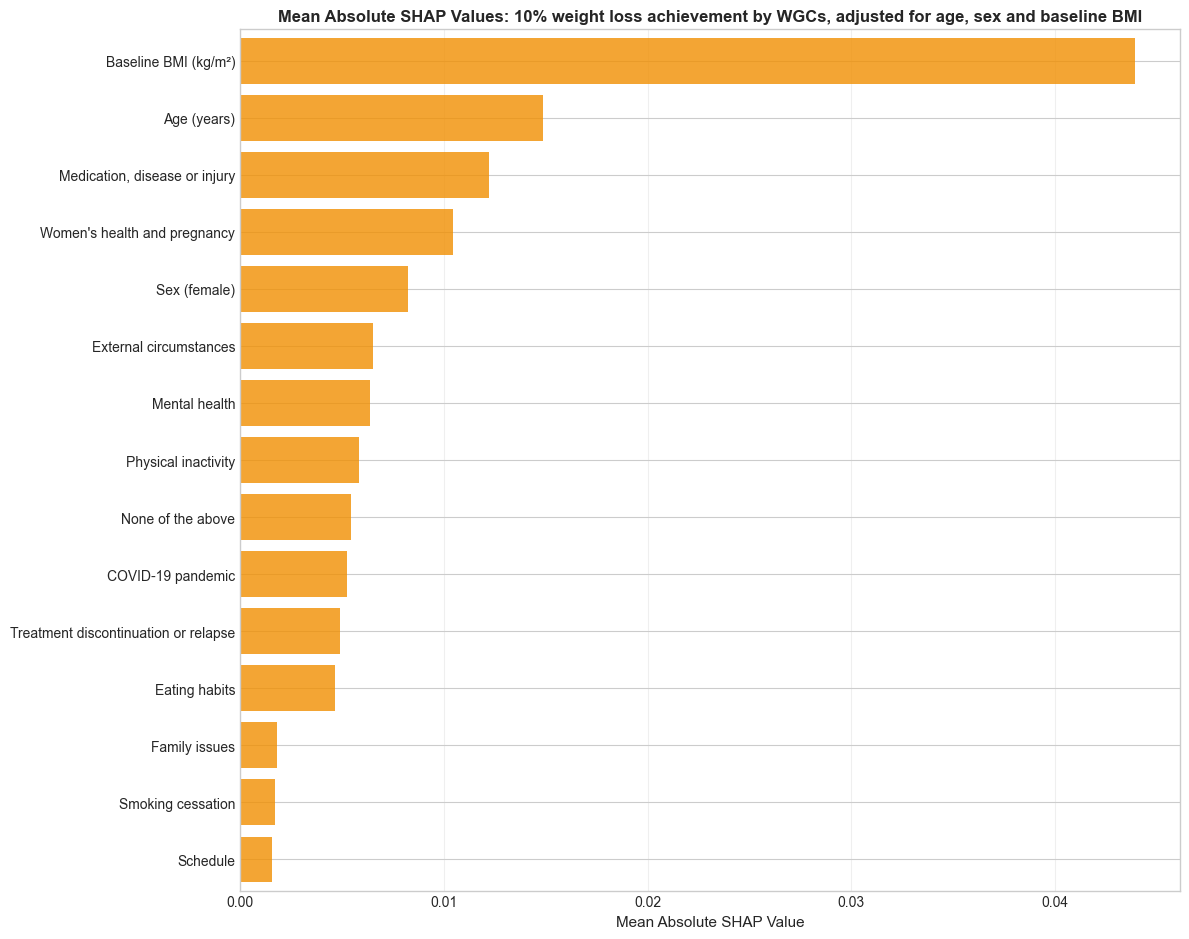

Permutation importance plot saved to: C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/rf_outputs\10% weight loss achievement by WGCs, adjusted for age, sex and baseline BMI_permutation_importance.png


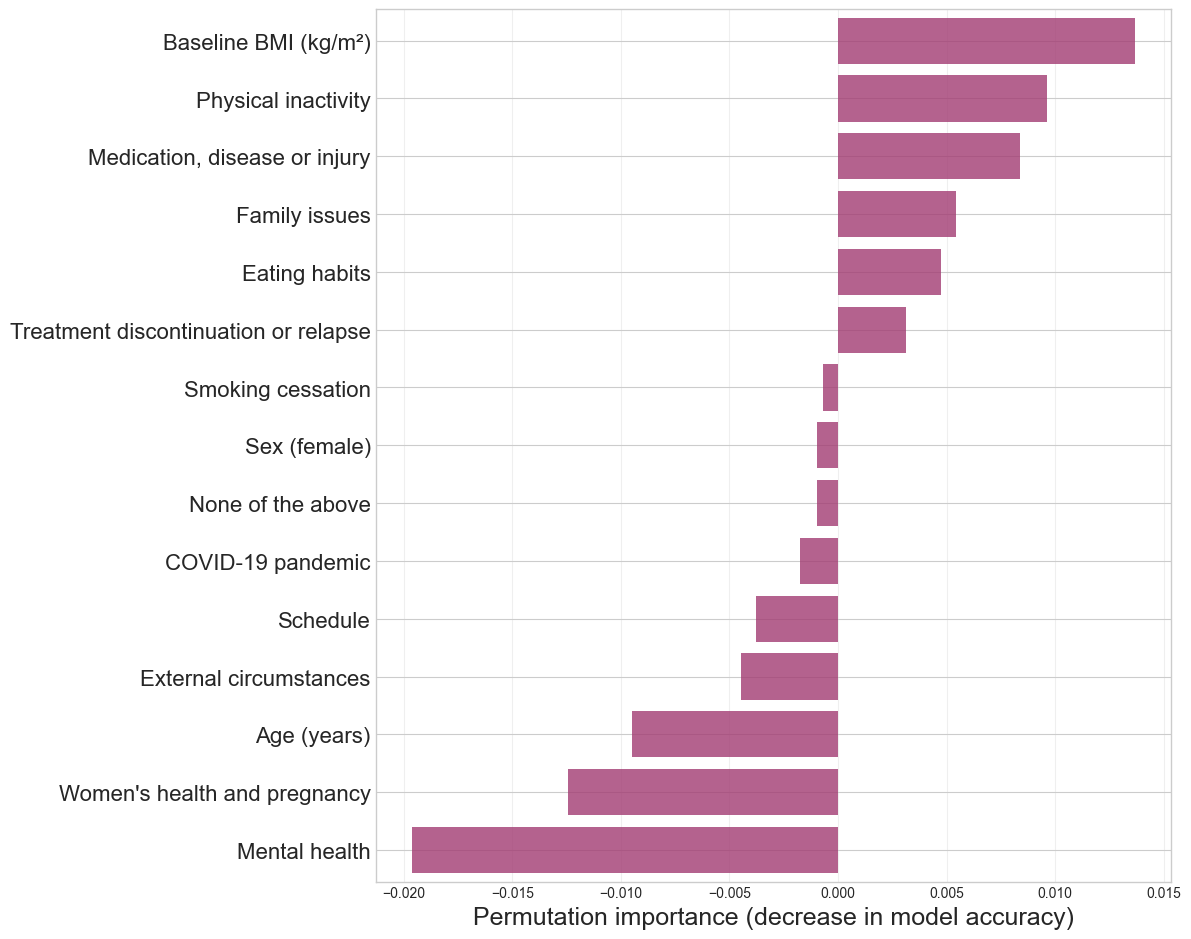

--- Analysis Complete: 10% weight loss achievement by WGCs, adjusted for age, sex and baseline BMI ---
All outputs saved to: C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/rf_outputs
--- Significance Testing Summary ---
Gini significant features (1): ['baseline_bmi']
SHAP significant features (12): ['womens_health_and_pregnancy', 'mental_health', 'family_issues', 'medication_disease_injury', 'schedule', 'smoking_cessation', 'treatment_discontinuation_or_relapse', 'pandemic', 'lifestyle_circumstances', 'none_of_above', 'age', 'sex_f']
Significance threshold: 0.132406
Alpha level: 0.05


In [1]:
# Import analysis engine and config
from paper12_config import paper2_rf_config
from rf_feature_importances import RandomForestAnalyzer

"""
=======================================
1. total weight loss: over or under 10%
=======================================
"""
# # """
# # EXPERIMENT 1A: Predict 10% weight Loss achievement (classifier task) using WGCs, without adjusting for covariates.
# # """
# # # Define experiment parameters
# # config_10p_wl_unadjusted = paper2_rf_config(
# #     analysis_name="10% weight loss achievement by WGCs, unadjusted",
# #     outcome_variable="total_wl_%",
# #     model_type="classifier",
# #     run_hyperparameter_tuning=True, # Default is OFF
# #     classifier_threshold=-10.0,
# #     threshold_direction="less_than_or_equal", # Use 'less_than_or_equal' for weight loss
# #     predictors=[
# #         "womens_health_and_pregnancy",
# #         "mental_health",
# #         "family_issues",
# #         "medication_disease_injury",
# #         "physical_inactivity",
# #         "eating_habits",
# #         "schedule",
# #         "smoking_cessation",
# #         "treatment_discontinuation_or_relapse",
# #         "pandemic",
# #         "lifestyle_circumstances",
# #         "none_of_above"
# #     ],
# #     covariates=[],
# #     output_dir="C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/rf_outputs"
# # )
# # # Initialize and run analysis engine
# # analyzer_10p_wl_unadjusted = RandomForestAnalyzer(config_10p_wl_unadjusted)
# # analyzer_10p_wl_unadjusted.run_and_generate_outputs()

"""
EXPERIMENT 1B: Predict 10% weight loss achievement (classifier task) using WGCs, adjusting for covariates.
"""
# Define experiment parameters
config_10p_wl_adjusted = paper2_rf_config(
    analysis_name="10% weight loss achievement by WGCs, adjusted for age, sex and baseline BMI",
    outcome_variable="total_wl_%",
    model_type="classifier",
    run_hyperparameter_tuning=True, # Default is OFF
    classifier_threshold=-10.0,
    threshold_direction="less_than_or_equal", # Use 'less_than_or_equal' for weight loss
    predictors=[
        "womens_health_and_pregnancy",
        "mental_health",
        "family_issues",
        "medication_disease_injury",
        "physical_inactivity",
        "eating_habits",
        "schedule",
        "smoking_cessation",
        "treatment_discontinuation_or_relapse",
        "pandemic",
        "lifestyle_circumstances",
        "none_of_above"
    ],
    covariates=["age", "sex_f", "baseline_bmi"],
    output_dir="C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/rf_outputs"
)
# Initialize and run analysis engine
analyzer_10p_wl_adjusted = RandomForestAnalyzer(config_10p_wl_adjusted)
analyzer_10p_wl_adjusted.run_and_generate_outputs()


##### I/2.1. other prediction setups 

In [ ]:
# Import analysis engine and config
from paper12_config import paper2_rf_config
from rf_engine import RandomForestAnalyzer

"""
=======================================
1. total weight loss: over or under 10%
=======================================
"""
"""
EXPERIMENT 1A: Predict 10% weight Loss achievement (classifier task) using WGCs, without adjusting for covariates.
"""
# Define experiment parameters
config_10p_wl_unadjusted = paper2_rf_config(
    analysis_name="10% weight loss achievement by WGCs, unadjusted",
    outcome_variable="total_wl_%",
    model_type="classifier",
    run_hyperparameter_tuning=True, # Default is OFF
    classifier_threshold=-10.0,
    threshold_direction="less_than_or_equal", # Use 'less_than_or_equal' for weight loss
    predictors=[
        "womens_health_and_pregnancy",
        "mental_health",
        "family_issues",
        "medication_disease_injury",
        "physical_inactivity",
        "eating_habits",
        "schedule",
        "smoking_cessation",
        "treatment_discontinuation_or_relapse",
        "pandemic",
        "lifestyle_circumstances",
        "none_of_above"
    ],
    covariates=[],
    output_dir="C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/rf_outputs"
)
# Initialize and run analysis engine
analyzer_10p_wl_unadjusted = RandomForestAnalyzer(config_10p_wl_unadjusted)
analyzer_10p_wl_unadjusted.run_and_generate_outputs()

"""
EXPERIMENT 1B: Predict 10% weight loss achievement (classifier task) using WGCs, adjusting for covariates.
"""
# Define experiment parameters
config_10p_wl_adjusted = paper2_rf_config(
    analysis_name="10% weight loss achievement by WGCs, adjusted for age, sex and baseline BMI",
    outcome_variable="total_wl_%",
    model_type="classifier",
    run_hyperparameter_tuning=True, # Default is OFF
    classifier_threshold=-10.0,
    threshold_direction="less_than_or_equal", # Use 'less_than_or_equal' for weight loss
    predictors=[
        "womens_health_and_pregnancy",
        "mental_health",
        "family_issues",
        "medication_disease_injury",
        "physical_inactivity",
        "eating_habits",
        "schedule",
        "smoking_cessation",
        "treatment_discontinuation_or_relapse",
        "pandemic",
        "lifestyle_circumstances",
        "none_of_above"
    ],
    covariates=["age", "sex_f", "baseline_bmi"],
    output_dir="C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/rf_outputs"
)
# Initialize and run analysis engine
analyzer_10p_wl_adjusted = RandomForestAnalyzer(config_10p_wl_adjusted)
analyzer_10p_wl_adjusted.run_and_generate_outputs()

"""
======================================
2. total weight loss: exact percentage
======================================
"""
"""
EXPERIMENT 2A: Predict total weight loss percentage (regression task) using WGCs, without adjusting for covariates.
"""
config_total_wl_unadjusted = paper2_rf_config(
    analysis_name="Total weight loss % by WGCs, unadjusted",
    outcome_variable="total_wl_%",
    model_type="regressor",
    run_hyperparameter_tuning=True, # Default is OFF
    predictors=[
        "womens_health_and_pregnancy",
        "mental_health",
        "family_issues",
        "medication_disease_injury",
        "physical_inactivity",
        "eating_habits",
        "schedule",
        "smoking_cessation",
        "treatment_discontinuation_or_relapse",
        "pandemic",
        "lifestyle_circumstances",
        "none_of_above"
    ],
    covariates=[],
    output_dir="C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/rf_outputs"
)
# Initialize and run the engine
analyzer_total_wl_unadjusted = RandomForestAnalyzer(config_total_wl_unadjusted)
analyzer_total_wl_unadjusted.run_and_generate_outputs()

"""
EXPERIMENT 2B: Predict total weight loss percentage (regression task) using WGCs, adjusting for covariates.
"""
config_total_wl_adjusted = paper2_rf_config(
    analysis_name="Total weight loss % by WGCs, adjusted for age, sex and baseline BMI",
    outcome_variable="total_wl_%",
    model_type="regressor",
    run_hyperparameter_tuning=True, # Default is OFF
    predictors=[
        "womens_health_and_pregnancy",
        "mental_health",
        "family_issues",
        "medication_disease_injury",
        "physical_inactivity",
        "eating_habits",
        "schedule",
        "smoking_cessation",
        "treatment_discontinuation_or_relapse",
        "pandemic",
        "lifestyle_circumstances",
        "none_of_above"
    ],
    covariates=["age", "sex_f", "baseline_bmi"],
    output_dir="C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/rf_outputs"
)
# Initialize and run the engine
analyzer_total_wl_adjusted = RandomForestAnalyzer(config_total_wl_adjusted)
analyzer_total_wl_adjusted.run_and_generate_outputs()

"""
========================================
3. baseline BMI: over or under 30 kg/m^2
========================================
"""
"""
EXPERIMENT 3A: Predict baseline BMI class (classifier task) using WGCs, without adjusting for covariates.
"""
config_bmi_class_unadjusted = paper2_rf_config(
    analysis_name="Baseline BMI over 30 by WGCs, unadjusted",
    outcome_variable="baseline_bmi",
    model_type="classifier",
    run_hyperparameter_tuning=True, # Default is OFF
    classifier_threshold=30.0,
    threshold_direction="greater_than_or_equal", # Use 'greater_than_or_equal' for BMI
    predictors=[
        "womens_health_and_pregnancy",
        "mental_health",
        "family_issues",
        "medication_disease_injury",
        "physical_inactivity",
        "eating_habits",
        "schedule",
        "smoking_cessation",
        "treatment_discontinuation_or_relapse",
        "pandemic",
        "lifestyle_circumstances",
        "none_of_above"
    ],
    covariates=[], # No adjustment variables
    output_dir="C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/rf_outputs"
)

# Initialize and run the engine
analyzer_bmi_class_unadjusted = RandomForestAnalyzer(config_bmi_class_unadjusted)
analyzer_bmi_class_unadjusted.run_and_generate_outputs()

"""
EXPERIMENT 3B: Predict baseline BMI class (classifier task) using WGCs, adjusting for covariates.
"""
config_bmi_class_adjusted = paper2_rf_config(
    analysis_name="Baseline BMI over 30 by WGCs, adjusted for age and sex",
    outcome_variable="baseline_bmi",
    model_type="classifier",
    run_hyperparameter_tuning=True, # Default is OFF
    classifier_threshold=30.0,
    threshold_direction="greater_than_or_equal", # Use 'greater_than_or_equal' for BMI
    predictors=[
        "womens_health_and_pregnancy",
        "mental_health",
        "family_issues",
        "medication_disease_injury",
        "physical_inactivity",
        "eating_habits",
        "schedule",
        "smoking_cessation",
        "treatment_discontinuation_or_relapse",
        "pandemic",
        "lifestyle_circumstances",
        "none_of_above"
    ],
    covariates=["age", "sex_f"], # No adjustment variables
    output_dir="C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/rf_outputs"
)

# Initialize and run the engine
analyzer_bmi_class_adjusted = RandomForestAnalyzer(config_bmi_class_adjusted)
analyzer_bmi_class_adjusted.run_and_generate_outputs()


"""
=============================
4. baseline BMI: exact kg/m^2
=============================
"""
"""
EXPERIMENT 4A: Predict baseline BMI value (regression task) using WGCs, without adjusting for covariates.
"""
config_bmi_value_unadjusted = paper2_rf_config(
    analysis_name="Baseline BMI value by WGCs, unadjusted",
    outcome_variable="baseline_bmi",
    model_type="regressor",
    run_hyperparameter_tuning=True, # Default is OFF
    predictors=[
        "womens_health_and_pregnancy",
        "mental_health",
        "family_issues",
        "medication_disease_injury",
        "physical_inactivity",
        "eating_habits",
        "schedule",
        "smoking_cessation",
        "treatment_discontinuation_or_relapse",
        "pandemic",
        "lifestyle_circumstances",
        "none_of_above"
    ],
    covariates=[], # No adjustment variables
    output_dir="C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/rf_outputs"
)

# Initialize and run the engine
analyzer_bmi_value_unadjusted = RandomForestAnalyzer(config_bmi_value_unadjusted)
analyzer_bmi_value_unadjusted.run_and_generate_outputs()

"""
EXPERIMENT 4B: Predict baseline BMI value (regression task) using WGCs, adjusting for covariates.
"""
config_bmi_value_adjusted = paper2_rf_config(
    analysis_name="Baseline BMI value by WGCs, adjusted for age and sex",
    outcome_variable="baseline_bmi",
    model_type="regressor",
    run_hyperparameter_tuning=True, # Default is OFF
    predictors=[
        "womens_health_and_pregnancy",
        "mental_health",
        "family_issues",
        "medication_disease_injury",
        "physical_inactivity",
        "eating_habits",
        "schedule",
        "smoking_cessation",
        "treatment_discontinuation_or_relapse",
        "pandemic",
        "lifestyle_circumstances",
        "none_of_above"
    ],
    covariates=["age", "sex_f"], # No adjustment variables
    output_dir="C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/rf_outputs"
)

# Initialize and run the engine
analyzer_bmi_value_adjusted = RandomForestAnalyzer(config_bmi_value_adjusted)
analyzer_bmi_value_adjusted.run_and_generate_outputs()

"""
============================
5. baseline weight: exact kg
============================
"""
"""
EXPERIMENT 5A: Predict baseline weight value (regression task) using WGCs, without adjusting for covariates.
"""
config_weight_value_unadjusted = paper2_rf_config(
    analysis_name="Baseline weight value by WGCs, unadjusted",
    outcome_variable="baseline_weight_kg",
    model_type="regressor",
    run_hyperparameter_tuning=True, # Default is OFF
    predictors=[
        "womens_health_and_pregnancy",
        "mental_health",
        "family_issues",
        "medication_disease_injury",
        "physical_inactivity",
        "eating_habits",
        "schedule",
        "smoking_cessation",
        "treatment_discontinuation_or_relapse",
        "pandemic",
        "lifestyle_circumstances",
        "none_of_above"
    ],
    covariates=[], # No adjustment variables
    output_dir="C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/rf_outputs"
)

# Initialize and run the engine
analyzer_weight_value_unadjusted = RandomForestAnalyzer(config_weight_value_unadjusted)
analyzer_weight_value_unadjusted.run_and_generate_outputs()

"""
EXPERIMENT 5B: Predict baseline weight value (regression task) using WGCs, adjusting for covariates.
"""
config_weight_value_adjusted = paper2_rf_config(
    analysis_name="Baseline weight value by WGCs, adjusted for age and sex",
    outcome_variable="baseline_weight_kg",
    model_type="regressor",
    run_hyperparameter_tuning=True, # Default is OFF
    predictors=[
        "womens_health_and_pregnancy",
        "mental_health",
        "family_issues",
        "medication_disease_injury",
        "physical_inactivity",
        "eating_habits",
        "schedule",
        "smoking_cessation",
        "treatment_discontinuation_or_relapse",
        "pandemic",
        "lifestyle_circumstances",
        "none_of_above"
    ],
    covariates=["age", "sex_f"], # No adjustment variables
    output_dir="C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/rf_outputs"
)

# Initialize and run the engine
analyzer_weight_value_adjusted = RandomForestAnalyzer(config_weight_value_adjusted)
analyzer_weight_value_adjusted.run_and_generate_outputs()



##### I/2.1. SHAP dependence plot - deep-dive into specific features

In [ ]:
# In your Jupyter Notebook, in a new cell after running an experiment

# Example: After running the 'analyzer_10p_wl' analysis...
# The grid plot shows 'physical_inactivity' is important. Let's investigate it.
analyzer_total_wl_unadjusted.plot_shap_dependence(feature_name="physical_inactivity")

# Let's see if its effect interacts with age
analyzer_total_wl_unadjusted.plot_shap_dependence(feature_name="physical_inactivity", interaction_feature="lifestyle_circumstances")

#### I/2.2. Risk ratio/risk difference analyses

ideas: RR/RD for likelihood of achieving binary outcomes, or maybe dropout

other related ideas are visualizing continous distributions like bl weight or bl binary distributions such as sex

In [4]:
# #### I/2.2. Risk ratio/risk difference analyses

# Import the descriptive visualizations pipeline
from descriptive_visualizations import *
from paper12_config import paths_config, master_config

# Configure paths (reuse existing configuration pattern)
paths = paths_config(
    source_dir = r"../dbs",
    source_db = r"../dbs/pnk_db2_filtered.sqlite", 
    paper_dir = r"..",
    paper_in_db = r"../dbs/pnk_db2_p2_in.sqlite",
    paper_out_db = r"../dbs/pnk_db2_p2_out.sqlite",
)

config = master_config(paths=paths)

# Run comprehensive descriptive visualizations
# This generates both risk ratio and risk difference forest plots 
# for 10% weight loss achievement and 60-day dropout outcomes
results = run_descriptive_visualizations(
    input_table="timetoevent_wgc_compl",  # Primary configurable parameter
    config=config
)

print("\n" + "="*60)
print("DESCRIPTIVE VISUALIZATIONS COMPLETE")
print("="*60)
print("Generated outputs:")
print("• Risk ratio forest plots for both outcomes")
print("• Risk difference forest plots for both outcomes") 
print("• Comprehensive summary tables with all statistics")
print("• All files saved to ../outputs/descriptive_visualizations/")
print("="*60)

NameError: name 'run_descriptive_visualizations' is not defined

#### I/2.3. Regression analyses

##### I/2.3. logistic - outcomes

In [ ]:
# IMPORTS 
import os
import pandas as pd
from regressions_inference import (
    load_data, 
    generate_logreg_scenarios,
    run_logreg_pipeline
)

# I/O databases
INPUT_DB = r"C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\pnk_db2_p2_in.sqlite"
OUTPUT_DB = r"C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\pnk_db2_p2_out.sqlite"

# Uncomment I/O tables to use

INPUT_TABLE = "timetoevent_wgc_compl"
OUTPUT_TABLE = "lg_outcms_wgc_cmpl"

# INPUT_TABLE = "timetoevent_wgc_gen_compl"
# OUTPUT_TABLE = "lg_outcms_wgc_gen_cmpl"

# Load once for scenario generation
df_all = load_data(INPUT_DB, INPUT_TABLE)

outcome_types = [
    'target_wl',
    'dropout'
]
time_windows = [
    40, 
    60, 
    80, 
    'total'  # Can also use total follow-up time
]
target_percentages = [
    5, 
    10, 
    15
]
main_predictors = [
        "womens_health_and_pregnancy",
        "mental_health",
        "family_issues",
        "medication_disease_injury",
        "physical_inactivity",
        "eating_habits",
        "schedule",
        "smoking_cessation",
        "treatment_discontinuation_or_relapse",
        "pandemic",
        "lifestyle_circumstances",
        "none_of_above"
]

adjustment_sets = [
    ([], "unadjusted"),
    (['age', 'sex_f', 'baseline_bmi'], "adjusted")
]

LOGREG_SCENARIOS = generate_logreg_scenarios(
    outcome_types, time_windows, target_percentages, main_predictors, adjustment_sets,
    input_table=INPUT_TABLE, df_all=df_all
)

run_logreg_pipeline(INPUT_DB, INPUT_TABLE, LOGREG_SCENARIOS, OUTPUT_TABLE, OUTPUT_DB)

##### I/2.3. linear - outcomes

In [ ]:
# IMPORTS 
import os
import pandas as pd
from regressions_inference import (
    load_data, 
    generate_linreg_scenarios,
    run_linreg_pipeline
)

# I/O databases
INPUT_DB = r"C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\pnk_db2_p2_in.sqlite"
OUTPUT_DB = r"C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\pnk_db2_p2_out.sqlite"

# Uncomment I/O tables to use

INPUT_TABLE = "timetoevent_wgc_compl"
OUTPUT_TABLE = "ln_outcms_wgc_compl"

# INPUT_TABLE = "timetoevent_wgc_gen_compl"
# OUTPUT_TABLE = "ln_outcms_wgc_gen_compl"

# Load once for scenario generation
df_all = load_data(INPUT_DB, INPUT_TABLE)

outcome_types = ['weight_change', 'fat_change', 'muscle_change']
time_windows = [40, 60, 80, 'total']
main_predictors = [
        "womens_health_and_pregnancy",
        "mental_health",
        "family_issues",
        "medication_disease_injury",
        "physical_inactivity",
        "eating_habits",
        "schedule",
        "smoking_cessation",
        "treatment_discontinuation_or_relapse",
        "pandemic",
        "lifestyle_circumstances",
        "none_of_above"
]
adjustment_sets = [
    ([], "unadjusted"),
    (['age', 'sex_f', 'baseline_bmi'], "adjusted")
]

LINREG_SCENARIOS = generate_linreg_scenarios(
    outcome_types, time_windows, main_predictors, adjustment_sets,
    input_table=INPUT_TABLE, df_all=df_all
)

run_linreg_pipeline(INPUT_DB, INPUT_TABLE, LINREG_SCENARIOS, OUTPUT_TABLE, OUTPUT_DB)

##### I/2.3. linear - adherence

In [ ]:
# IMPORTS
import os
import pandas as pd
from regressions_inference import (
    load_data, 
    generate_adherence_scenarios,
    run_adherence_linreg_pipeline
)

# I/O databases
INPUT_DB = r"C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\pnk_db2_p2_in.sqlite"
OUTPUT_DB = r"C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\pnk_db2_p2_out.sqlite"

# Uncomment I/O tables to use
INPUT_TABLE = "timetoevent_wgc_compl"
OUTPUT_TABLE = "ln_adher_wgc_compl"

# INPUT_TABLE = "timetoevent_wgc_gen_compl"
# OUTPUT_TABLE = "ln_adher_wgc_gen_compl"

# Load once for scenario generation
df_all = load_data(INPUT_DB, INPUT_TABLE)

adherence_outcomes = [
    'total_followup_days',
    'dietitian_visits',
    'nr_total_measurements',
    'avg_days_between_measurements'
    # days_to_X%_wl handled separately
]
target_percentages = [5, 10, 15]
main_predictors = [
        "womens_health_and_pregnancy",
        "mental_health",
        "family_issues",
        "medication_disease_injury",
        "physical_inactivity",
        "eating_habits",
        "schedule",
        "smoking_cessation",
        "treatment_discontinuation_or_relapse",
        "pandemic",
        "lifestyle_circumstances",
        "none_of_above"
]
adjustment_sets = [
    ([], "unadjusted"),
    (['age', 'sex_f', 'baseline_bmi'], "adjusted")
]

ADHERENCE_SCENARIOS = generate_adherence_scenarios(
    target_percentages,
    main_predictors,
    adjustment_sets,
    input_table=INPUT_TABLE,
    df_all=df_all,
    extra_outcomes=adherence_outcomes
)

run_adherence_linreg_pipeline(INPUT_DB, INPUT_TABLE, ADHERENCE_SCENARIOS, OUTPUT_TABLE, OUTPUT_DB)

## Block II - associations between weight gain causes

### Paper 2 - specific network analyses - pre-cluster EDA

#### Phi correlation network, shell structure

In [ ]:
# Ensure you have these libraries installed:
# pip install pandas networkx sqlalchemy matplotlib seaborn
import sqlite3
import pandas as pd
import numpy as np
import networkx as nx
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests

# --- Configuration ---
paper2_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\paper2_dir"
DB_PATH = os.path.join(paper2_directory, 'pnk_db2_p2_in.sqlite')
OUTPUT_DIR = "wgc_association_networks"

INPUT_TABLE = "timetoevent_wgc_compl"
SIGNIFICANCE_THRESHOLD = 0.05
FDR_CORRECTION = True
CORRELATION_STRENGTH_THRESHOLD = 0.0

# --- Centralized Visualization Configuration ---
VIS_CONFIG = {
    "figure_size": (20, 20),
    "figure_background_color": '#f0f0f0',
    "shell_scale": 1.0,
    "node_order": [
        "physical_inactivity", "womens_health_and_pregnancy", "pandemic",
        "none_of_above", "eating_habits", "smoking_cessation", "schedule",
        "medication_disease_injury", "mental_health",
        "treatment_discontinuation_or_relapse", "family_issues",
        "lifestyle_circumstances",
    ],
    "node_size_base": 1500,
    "node_size_degree_multiplier": 1200,
    "node_color": '#FF6700',
    "node_alpha": 1.0,
    "node_border_width_ratio": 0.1,
    "node_border_alpha": 0.6,
    "edge_width_base": 2.0,
    "edge_width_weight_multiplier": 20.0,
    "edge_alpha": 0.6,
    "edge_curvature": 0.1,
    "edge_color_positive": (0, 0.5, 0),
    "edge_color_negative": (1.0, 0, 0),
    "font_size": 36,
    "font_family": ['Arial', 'sans-serif'],
    "font_color": 'black',
    "draw_label_box": False,
    # --- New settings for the heatmap ---
    "heatmap_cmap": "coolwarm",
    "heatmap_center": 0,
    "heatmap_figsize": (16, 14),
    "heatmap_font_scale": 1.2
}

HUMAN_NAMES_DICT = {
    "womens_health_and_pregnancy": "Women's health\n& pregnancy",
    "mental_health": "Mental health", "family_issues": "Family issues",
    "physical_inactivity": "Physical inactivity", "eating_habits": "Eating habits",
    "schedule": "Schedule", "smoking_cessation": "Smoking cessation",
    "treatment_discontinuation_or_relapse": "Treatment\ndiscontinuation",
    "pandemic": "Pandemic",
    "medication_disease_injury": "Medication, disease,\nor injury",
    "lifestyle_circumstances": "Lifestyle,\ncircumstances",
    # "none_of_above": "None of the above",
}

# --- Data Loading and Preprocessing (Unchanged) ---

def load_data(db_path, table_name):
    print(f"Loading data from table '{table_name}' in '{db_path}'...")
    if not os.path.exists(db_path):
        print(f"Error: Database file not found at '{db_path}'.")
        return pd.DataFrame()
    try:
        with sqlite3.connect(db_path) as conn:
            df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        print(f"Successfully loaded {df.shape[0]} rows and {df.shape[1]} columns.")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

def identify_weight_gain_causes(df):
    print("Identifying Weight Gain Cause (WGC) variables...")
    potential_wgc_vars = list(HUMAN_NAMES_DICT.keys())
    wgc_vars_in_df = [var for var in potential_wgc_vars if var in df.columns]
    print(f"Found {len(wgc_vars_in_df)} WGC variables for correlation.")
    return wgc_vars_in_df

def preprocess_data(df, variables_list):
    print("Preprocessing data...")
    if not variables_list:
        return pd.DataFrame()
    df_processed = df[variables_list].copy()
    for col in df_processed.columns:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed.dropna(axis=1, how='all', inplace=True)
    return df_processed

# --- Core Calculation (Unchanged) ---

def calculate_binary_correlations(df_processed, apply_fdr, significance_threshold):
    # This function remains the same as your original script
    if apply_fdr:
        print("Calculating Phi coefficients and FDR-corrected p-values...")
    else:
        print("Calculating Phi coefficients and RAW (uncorrected) p-values...")
    variables = df_processed.columns
    n_vars = len(variables)
    phi_matrix = pd.DataFrame(np.zeros((n_vars, n_vars)), index=variables, columns=variables)
    pval_matrix = pd.DataFrame(np.ones((n_vars, n_vars)), index=variables, columns=variables)
    p_values_list, coord_list = [], []
    for i in range(n_vars):
        # The for j loop starts from i+1 to avoid calculating redundant self-correlations
        for j in range(i + 1, n_vars):
            var1, var2 = variables[i], variables[j]
            contingency_table = pd.crosstab(df_processed[var1], df_processed[var2])
            if contingency_table.shape != (2, 2):
                continue
            try:
                chi2, p, _, _ = chi2_contingency(contingency_table)
            except ValueError:
                p = 1.0
            pval_matrix.iloc[i, j] = pval_matrix.iloc[j, i] = p
            p_values_list.append(p)
            coord_list.append((i, j))
            a, b, c, d = contingency_table.values.flatten()
            denominator = np.sqrt((a + b) * (c + d) * (a + c) * (b + d))
            phi = ((a * d) - (b * c)) / denominator if denominator != 0 else 0
            phi_matrix.iloc[i, j] = phi_matrix.iloc[j, i] = phi
    if apply_fdr and p_values_list:
        print("Applying Benjamini-Hochberg FDR correction...")
        reject, pvals_corrected, _, _ = multipletests(p_values_list, alpha=significance_threshold, method='fdr_bh')
        for idx, (i, j) in enumerate(coord_list):
            pval_matrix.iloc[i, j] = pval_matrix.iloc[j, i] = pvals_corrected[idx]
    return phi_matrix, pval_matrix

# --- NEW: Heatmap Generation ---

def draw_and_save_heatmap(matrix, node_order, name_map, output_filepath, vis_config):
    """Draws and saves a heatmap of the Phi correlation matrix."""
    print(f"Generating and saving heatmap to '{output_filepath}'...")
    ordered_nodes = [node for node in node_order if node in matrix.columns]
    matrix_ordered = matrix.loc[ordered_nodes, ordered_nodes]
    ordered_labels = [name_map.get(node, node).replace('\n', ' ') for node in ordered_nodes]
    plt.figure(figsize=vis_config["heatmap_figsize"])
    sns.set_theme(style="white", font_scale=vis_config["heatmap_font_scale"])
    sns.heatmap(
        matrix_ordered, cmap=vis_config["heatmap_cmap"], center=vis_config["heatmap_center"],
        annot=True, fmt=".2f", linewidths=.5,
        xticklabels=ordered_labels, yticklabels=ordered_labels
    )
    plt.title("Phi Coefficient Matrix", fontsize=20, pad=20)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(output_filepath, format='svg', bbox_inches='tight')
    plt.close()
    print(f"Heatmap saved successfully to {output_filepath}")

# --- Network Building and Visualization (Unchanged) ---

def build_network_from_phi(phi_matrix, pval_matrix, alpha, corr_threshold):
    # This function remains the same.
    G = nx.Graph()
    for i in range(len(phi_matrix.columns)):
        for j in range(i + 1, len(phi_matrix.columns)):
            var1, var2 = phi_matrix.columns[i], phi_matrix.columns[j]
            p_value = pval_matrix.loc[var1, var2]
            if pd.notna(p_value) and p_value < alpha:
                phi = phi_matrix.loc[var1, var2]
                if abs(phi) >= corr_threshold:
                    G.add_edge(var1, var2, weight=abs(phi), phi=phi)
    return G

def calculate_node_positions(G, vis_config):
    # This function remains the same.
    pos, graph_nodes = {}, set(G.nodes())
    node_order = [node for node in vis_config["node_order"] if node in graph_nodes]
    if not node_order: return nx.circular_layout(G, scale=vis_config["shell_scale"])
    n_nodes = len(node_order)
    angle_step = 2 * np.pi / n_nodes
    for i, node in enumerate(node_order):
        angle = i * angle_step
        pos[node] = (vis_config["shell_scale"] * np.cos(angle), vis_config["shell_scale"] * np.sin(angle))
    return pos

def draw_and_save_network(G, pos, name_map, output_filepath, vis_config):
    # This function remains the same.
    fig, ax = plt.subplots(figsize=vis_config["figure_size"])
    fig.set_facecolor(vis_config["figure_background_color"])
    nodes_in_graph = list(G.nodes())
    degree_map = dict(G.degree())
    node_sizes = [vis_config["node_size_base"] + (degree_map.get(n, 0) * vis_config["node_size_degree_multiplier"]) for n in nodes_in_graph]
    node_color = mcolors.to_rgba(vis_config["node_color"], alpha=vis_config["node_alpha"])
    border_color = mcolors.to_rgba(vis_config["node_color"], alpha=vis_config["node_border_alpha"])
    node_diameters = [np.sqrt(s / np.pi) * 2 for s in node_sizes]
    linewidths = [d * vis_config["node_border_width_ratio"] for d in node_diameters]
    edge_colors = []
    edge_widths = []
    for u, v, data in G.edges(data=True):
        phi_val = data.get('phi', 0)
        base_color = vis_config["edge_color_positive"] if phi_val > 0 else vis_config["edge_color_negative"]
        edge_colors.append((*base_color, vis_config["edge_alpha"]))
        edge_widths.append(vis_config["edge_width_base"] + (data.get('weight', 0) * vis_config["edge_width_weight_multiplier"]))
    nx.draw_networkx_edges(
        G, pos, ax=ax, edge_color=edge_colors, width=edge_widths,
        connectionstyle=f'arc3,rad={vis_config["edge_curvature"]}'
    )
    nx.draw_networkx_nodes(
        G, pos, ax=ax, nodelist=nodes_in_graph, node_color=[node_color] * len(nodes_in_graph),
        node_size=node_sizes, edgecolors=[border_color] * len(nodes_in_graph), linewidths=linewidths
    )
    labels = {node: name_map.get(node, node) for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, ax=ax, labels=labels, font_size=vis_config["font_size"], font_family=vis_config["font_family"], font_color=vis_config["font_color"])
    ax.margins(0.2)
    plt.tight_layout()
    plt.savefig(output_filepath, format='svg', bbox_inches='tight', transparent=True)
    plt.close(fig)

# --- UPDATED: Main Pipeline ---

def run_visualization_pipeline(db_path, table_name, alpha, apply_fdr, corr_threshold, vis_config, name_map, output_dir):
    """Orchestrates data loading, analysis, and visualization for Phi coefficient."""
    df_full = load_data(db_path, table_name)
    if df_full.empty: return

    wgc_vars = identify_weight_gain_causes(df_full)
    df_processed = preprocess_data(df_full, wgc_vars)
    if df_processed.shape[1] < 2: return

    phi_matrix, pval_matrix = calculate_binary_correlations(df_processed, apply_fdr, alpha)

    # --- Generate and Save Outputs ---
    fdr_str = "_fdr" if apply_fdr else ""
    base_filename = f"phi_network_WGC_{table_name}_alpha{str(alpha).replace('.', 'p')}{fdr_str}_phi{str(corr_threshold).replace('.', 'p')}"
    network_filepath = os.path.join(output_dir, f"{base_filename}.svg")
    heatmap_filepath = os.path.join(output_dir, f"{base_filename}_matrix.svg")

    # 1. Save the Heatmap
    draw_and_save_heatmap(phi_matrix, vis_config["node_order"], name_map, heatmap_filepath, vis_config)

    # 2. Build and Save the Network Graph
    G = build_network_from_phi(phi_matrix, pval_matrix, alpha, corr_threshold)
    if not G.nodes:
        print(f"No significant associations found at alpha={alpha} and phi_thresh={corr_threshold}. Cannot build network.")
        return
    pos = calculate_node_positions(G, vis_config)
    draw_and_save_network(G, pos, name_map, network_filepath, vis_config)
    print(f"Network and heatmap saved successfully to '{output_dir}'.")


if __name__ == "__main__":
    print("--- Starting WGC Phi Coefficient Network Analysis ---")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    run_visualization_pipeline(
        db_path=DB_PATH,
        table_name=INPUT_TABLE,
        alpha=SIGNIFICANCE_THRESHOLD,
        apply_fdr=FDR_CORRECTION,
        corr_threshold=CORRELATION_STRENGTH_THRESHOLD,
        vis_config=VIS_CONFIG,
        name_map=HUMAN_NAMES_DICT,
        output_dir=OUTPUT_DIR
    )
    print("--- Process Completed. ---")


#### Ising network, shell structure

In [ ]:
# Ensure you have these libraries installed:
# pip install pandas networkx sqlalchemy matplotlib seaborn rpy2
# You also need to have R installed and the 'IsingFit' package.
# In R: install.packages("IsingFit")
import sqlite3
import pandas as pd
import numpy as np
import networkx as nx
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# --- R and rpy2 setup ---
# It's good practice to handle potential import errors for complex dependencies.
try:
    import rpy2.robjects as ro
    from rpy2.robjects import pandas2ri, default_converter
    from rpy2.robjects.packages import importr
    R_AVAILABLE = True
    print("Successfully imported rpy2 and its components.")
except ImportError:
    R_AVAILABLE = False
    print("Warning: rpy2 is not installed. Ising model functionality will be unavailable.")

# --- Configuration ---
paper2_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\paper2_dir"
DB_PATH = os.path.join(paper2_directory, 'pnk_db2_p2_in.sqlite')
OUTPUT_DIR = "wgc_association_networks"

INPUT_TABLE = "timetoevent_wgc_compl"
# Threshold for including an edge in the network (absolute Ising weight)
# The IsingFit package handles model selection, so we don't need a p-value threshold.
STRENGTH_THRESHOLD = 0.1

# --- Centralized Visualization Configuration ---
VIS_CONFIG = {
    "figure_size": (20, 20),
    "figure_background_color": '#f0f0f0',
    "shell_scale": 1.0,
    "node_order": [
        "physical_inactivity", "womens_health_and_pregnancy", "pandemic",
        "none_of_above", "eating_habits", "smoking_cessation", "schedule",
        "medication_disease_injury", "mental_health",
        "treatment_discontinuation_or_relapse", "family_issues",
        "lifestyle_circumstances",
    ],
    "node_size_base": 1500,
    "node_size_degree_multiplier": 1200,
    "node_color": '#FF6700',
    "node_alpha": 1.0,
    "node_border_width_ratio": 0.1,
    "node_border_alpha": 0.6,
    "edge_width_base": 2.0,
    "edge_width_weight_multiplier": 30.0, # Increased for better visibility of strong connections
    "edge_alpha": 0.7,
    "edge_curvature": 0.15, # Slight curvature for better edge separation
    "edge_color_positive": (0, 0.5, 0),
    "edge_color_negative": (1.0, 0, 0),
    "font_size": 36,
    "font_family": ['Arial', 'sans-serif'],
    "font_color": 'black',
    "draw_label_box": False,
    "label_box_style": {
        "boxstyle": "round,pad=0.2", "facecolor": (0.8, 0.8, 0.8, 0.3),
        "edgecolor": (0.5, 0.5, 0.5, 0.7), "linewidth": 2,
    },
    # --- New settings for the heatmap ---
    "heatmap_cmap": "coolwarm",
    "heatmap_center": 0,
    "heatmap_figsize": (16, 14),
    "heatmap_font_scale": 1.2
}

HUMAN_NAMES_DICT = {
    "womens_health_and_pregnancy": "Women's health\n& pregnancy",
    "mental_health": "Mental health", "family_issues": "Family issues",
    "physical_inactivity": "Physical inactivity", "eating_habits": "Eating habits",
    "schedule": "Schedule", "smoking_cessation": "Smoking cessation",
    "treatment_discontinuation_or_relapse": "Treatment\ndiscontinuation",
    "pandemic": "Pandemic",
    "medication_disease_injury": "Medication, disease,\nor injury",
    "lifestyle_circumstances": "Lifestyle,\ncircumstances",
    "none_of_above": "None of the above",
}

# --- Data Loading and Preprocessing (Unchanged) ---

def load_data(db_path, table_name):
    print(f"Loading data from table '{table_name}' in '{db_path}'...")
    if not os.path.exists(db_path):
        print(f"Error: Database file not found at '{db_path}'.")
        return pd.DataFrame()
    try:
        with sqlite3.connect(db_path) as conn:
            df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        print(f"Successfully loaded {df.shape[0]} rows and {df.shape[1]} columns.")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

def identify_weight_gain_causes(df):
    print("Identifying Weight Gain Cause (WGC) variables...")
    potential_wgc_vars = [
        "womens_health_and_pregnancy", "mental_health", "family_issues",
        "medication_disease_injury", "physical_inactivity", "eating_habits",
        "schedule", "smoking_cessation", "treatment_discontinuation_or_relapse",
        "pandemic", "lifestyle_circumstances", "none_of_above"
    ]
    wgc_vars_in_df = [var for var in potential_wgc_vars if var in df.columns]
    # We will exclude 'none_of_above' from the model itself
    wgc_vars_for_model = [var for var in wgc_vars_in_df if var != 'none_of_above']
    print(f"Found {len(wgc_vars_for_model)} WGC variables for the Ising model.")
    return wgc_vars_for_model

def preprocess_data(df, variables_list):
    print("Preprocessing data for Ising model...")
    if not variables_list:
        print("Warning: No variables provided for preprocessing.")
        return pd.DataFrame()
    df_processed = df[variables_list].copy()
    for col in df_processed.columns:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed.dropna(axis=1, how='all', inplace=True)
    # IsingFit requires 0/1, so we should fill any remaining NaNs with 0
    df_processed.fillna(0, inplace=True)
    df_processed = df_processed.astype(int)
    return df_processed

# --- Ising Model Calculation ---

def calculate_ising_network(df_processed):
    """
    Calculates the Ising model adjacency matrix using R's IsingFit package.
    """
    if not R_AVAILABLE:
        print("Error: rpy2 is not installed. Cannot run Ising model.")
        return None

    print("Calculating Ising model network using R's IsingFit...")
    try:
        IsingFit = importr("IsingFit")
        # Convert pandas DataFrame to R data frame
        converter = default_converter + pandas2ri.converter
        with ro.conversion.localconverter(converter):
            r_df = ro.conversion.py2rpy(df_processed)
        
        # Run IsingFit. plot=False prevents R from opening a graphics device.
        fit = IsingFit.IsingFit(r_df, family="binomial", plot=False)
        
        # Extract the weighted adjacency matrix
        adj_matrix_np = np.array(fit.rx2("weiadj"))
        adj_matrix_df = pd.DataFrame(
            adj_matrix_np,
            index=df_processed.columns,
            columns=df_processed.columns
        )
        print("Ising model calculation complete.")
        return adj_matrix_df
    except Exception as e:
        print(f"An error occurred during Ising model calculation: {e}")
        return None

# --- Heatmap Generation ---

def draw_and_save_heatmap(adj_matrix, node_order, name_map, output_filepath, vis_config):
    """Draws and saves a heatmap of the adjacency matrix, respecting node order."""
    print(f"Generating and saving heatmap to '{output_filepath}'...")
    
    # Filter and reorder the matrix according to the provided node order
    ordered_nodes = [node for node in node_order if node in adj_matrix.columns]
    matrix_ordered = adj_matrix.loc[ordered_nodes, ordered_nodes]
    
    # Get human-readable names for the labels
    ordered_labels = [name_map.get(node, node).replace('\n', ' ') for node in ordered_nodes]

    plt.figure(figsize=vis_config["heatmap_figsize"])
    sns.set_theme(style="white", font_scale=vis_config["heatmap_font_scale"])
    
    heatmap = sns.heatmap(
        matrix_ordered,
        cmap=vis_config["heatmap_cmap"],
        center=vis_config["heatmap_center"],
        annot=True,
        fmt=".2f",
        linewidths=.5,
        xticklabels=ordered_labels,
        yticklabels=ordered_labels
    )
    
    plt.title("Ising Model Adjacency Matrix (Edge Weights)", fontsize=20, pad=20)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(output_filepath, format='svg', bbox_inches='tight')
    plt.close()
    print(f"Heatmap saved successfully to {output_filepath}")

# --- Network Building ---

def build_network_from_ising(adj_matrix, strength_threshold=0.0):
    """Builds a networkx graph from an Ising adjacency matrix."""
    print(f"Building network with edge strength threshold |weight| >= {strength_threshold}...")
    G = nx.Graph()
    
    # Add nodes first to ensure all variables are in the graph, even if isolated
    for node in adj_matrix.columns:
        G.add_node(node)

    # Add edges that meet the strength threshold
    for i in range(len(adj_matrix.columns)):
        for j in range(i + 1, len(adj_matrix.columns)):
            var1, var2 = adj_matrix.columns[i], adj_matrix.columns[j]
            weight = adj_matrix.loc[var1, var2]
            
            if abs(weight) >= strength_threshold:
                # The 'weight' attribute is used for layout and width scaling (must be positive)
                # The 'ising_w' attribute stores the original signed weight for coloring
                G.add_edge(var1, var2, weight=abs(weight), ising_w=weight)
    
    # Remove isolated nodes (nodes with no connections) for a cleaner visualization
    isolated = list(nx.isolates(G))
    G.remove_nodes_from(isolated)
    if isolated:
        print(f"Removed {len(isolated)} isolated nodes: {isolated}")

    return G

# --- VISUALIZATION (adapted for Ising weights) ---

def calculate_node_positions(G, vis_config):
    # This function works as-is, no changes needed.
    print("Calculating node positions based on manual order in VIS_CONFIG...")
    pos = {}
    graph_nodes = set(G.nodes())
    node_order = [node for node in vis_config["node_order"] if node in graph_nodes]

    if not node_order:
        print("Warning: No nodes from the graph found in the manual order. Using default circular layout.")
        return nx.circular_layout(G, scale=vis_config["shell_scale"])

    n_nodes = len(node_order)
    angle_step = 2 * np.pi / n_nodes
    for i, node in enumerate(node_order):
        angle = i * angle_step
        pos[node] = (vis_config["shell_scale"] * np.cos(angle), vis_config["shell_scale"] * np.sin(angle))
    return pos

def draw_and_save_network(G, pos, name_map, output_filepath, vis_config):
    print(f"Drawing network and saving to '{output_filepath}'...")
    fig, ax = plt.subplots(figsize=vis_config["figure_size"])
    fig.set_facecolor(vis_config["figure_background_color"])

    nodes_in_graph = list(G.nodes())
    degree_map = dict(G.degree())
    node_sizes = [vis_config["node_size_base"] + (degree_map.get(n, 0) * vis_config["node_size_degree_multiplier"]) for n in nodes_in_graph]
    node_color_rgba = mcolors.to_rgba(vis_config["node_color"], alpha=vis_config["node_alpha"])
    node_border_color_rgba = mcolors.to_rgba(vis_config["node_color"], alpha=vis_config["node_border_alpha"])
    node_diameters = [np.sqrt(s / np.pi) * 2 for s in node_sizes]
    linewidths = [d * vis_config["node_border_width_ratio"] for d in node_diameters]

    edge_colors = []
    edge_widths = []
    for u, v, data in G.edges(data=True):
        ising_weight = data.get('ising_w', 0) # Use the signed Ising weight for color
        base_color = vis_config["edge_color_positive"] if ising_weight > 0 else vis_config["edge_color_negative"]
        edge_colors.append((*base_color, vis_config["edge_alpha"]))
        # Use the absolute weight for width
        edge_widths.append(vis_config["edge_width_base"] + (data.get('weight', 0) * vis_config["edge_width_weight_multiplier"]))

    nx.draw_networkx_edges(
        G, pos, ax=ax,
        edge_color=edge_colors,
        width=edge_widths,
        connectionstyle=f'arc3,rad={vis_config["edge_curvature"]}'
    )
    nx.draw_networkx_nodes(
        G, pos, ax=ax, nodelist=nodes_in_graph,
        node_color=[node_color_rgba] * len(nodes_in_graph), node_size=node_sizes,
        edgecolors=[node_border_color_rgba] * len(nodes_in_graph), linewidths=linewidths
    )
    labels = {node: name_map.get(node, node) for node in G.nodes()}
    label_options = {
        "font_size": vis_config["font_size"], "font_family": vis_config["font_family"],
        "font_color": vis_config["font_color"],
    }
    if vis_config.get("draw_label_box", False):
        label_options["bbox"] = vis_config["label_box_style"]
    nx.draw_networkx_labels(G, pos, ax=ax, labels=labels, **label_options)

    ax.margins(0.2)
    plt.tight_layout()
    plt.savefig(
        output_filepath, format='svg', bbox_inches='tight',
        pad_inches=0, transparent=True
    )
    plt.close(fig)
    print(f"SVG network saved successfully to {output_filepath}")

# --- MODIFIED: Main Pipeline ---

def run_ising_pipeline(db_path, table_name, strength_threshold, vis_config, name_map, output_dir):
    """Orchestrates the Ising model data loading, analysis, and visualization."""
    df_full = load_data(db_path, table_name)
    if df_full.empty:
        return

    wgc_vars = identify_weight_gain_causes(df_full)
    df_processed = preprocess_data(df_full, wgc_vars)
    if df_processed.shape[1] < 2:
        print("Insufficient data for Ising model. Exiting.")
        return

    # Calculate Ising adjacency matrix
    adj_matrix = calculate_ising_network(df_processed)
    if adj_matrix is None:
        print("Failed to calculate Ising network. Exiting.")
        return

    # Build network
    G = build_network_from_ising(adj_matrix, strength_threshold)
    if not G.nodes:
        print(f"No associations found meeting the strength threshold |w| >= {strength_threshold}. Cannot build network.")
        return

    # --- Generate and Save Outputs ---
    
    # Define file paths
    base_filename = f"ising_network_WGC_{table_name}_thr{str(strength_threshold).replace('.', 'p')}"
    network_filepath = os.path.join(output_dir, f"{base_filename}.svg")
    heatmap_filepath = os.path.join(output_dir, f"{base_filename}_matrix.svg")

    # Generate node positions
    pos = calculate_node_positions(G, vis_config)
    
    # 1. Save the Network Graph
    draw_and_save_network(G, pos, name_map, network_filepath, vis_config)
    
    # 2. Save the Adjacency Matrix Heatmap
    draw_and_save_heatmap(adj_matrix, vis_config["node_order"], name_map, heatmap_filepath, vis_config)


if __name__ == "__main__":
    print("--- Starting WGC Ising Network Analysis ---")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    if R_AVAILABLE:
        run_ising_pipeline(
            db_path=DB_PATH,
            table_name=INPUT_TABLE,
            strength_threshold=STRENGTH_THRESHOLD,
            vis_config=VIS_CONFIG,
            name_map=HUMAN_NAMES_DICT,
            output_dir=OUTPUT_DIR
        )
    else:
        print("\nExecution stopped because rpy2 is not available. Please install it and the R package 'IsingFit'.")

    print("--- Process Completed. ---")


#### Risk ratio network

In [11]:
# Ensure you have these libraries installed:
# pip install pandas networkx sqlalchemy matplotlib seaborn
import sqlite3
import pandas as pd
import numpy as np
# import networkx as nx
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# --- Configuration ---
paper2_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\paper2_dir\\dbs"
DB_PATH = os.path.join(paper2_directory, 'pnk_db2_p2_in.sqlite')
OUTPUT_DIR = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\paper2_dir\\outputs\\wgc_association_networks"

INPUT_TABLE = "timetoevent_wgc_compl"
# Threshold for including an edge. An RR of 1.5 means a 50% increased risk.
# We will only show positive associations for clarity, as is common.
RR_THRESHOLD = 1.5

# --- Centralized Visualization Configuration ---
VIS_CONFIG = {
    "figure_size": (20, 20),
    "figure_background_color": '#f0f0f0',
    "shell_scale": 1.0,
    "node_order": [
        "physical_inactivity", "womens_health_and_pregnancy", "pandemic",
        "none_of_above", "eating_habits", "smoking_cessation", "schedule",
        "medication_disease_injury", "mental_health",
        "treatment_discontinuation_or_relapse", "family_issues",
        "lifestyle_circumstances",
    ],
    "node_size_base": 1500,
    "node_size_degree_multiplier": 1200,
    "node_color": '#FF6700',
    "node_alpha": 1,
    "node_border_width_ratio": 0.1,
    "node_border_alpha": 0.6,
    "edge_width_base": 1.5,
    "edge_width_weight_multiplier": 5.0, # Adjusted for typical RR value ranges
    "edge_alpha": 0.7,
    "edge_curvature": 0.05,
    # For RR, we are primarily interested in positive associations (RR > 1)
    # but include a negative color for completeness if the threshold were < 1.
    "edge_color_positive": (0, 0.5, 0),
    "edge_color_negative": (1.0, 0, 0),
    "font_size": 36,
    "font_family": ['Arial', 'sans-serif'],
    "font_color": 'black',
    "draw_label_box": False,
    # --- Heatmap settings ---
    "heatmap_cmap": "coolwarm",
    "heatmap_center": 1.0, # CRITICAL: Center the heatmap color scale at 1.0 for RR
    "heatmap_figsize": (16, 14),
    "heatmap_font_scale": 1.2, # for relative font size setting
    # for absolute font size setting: 
    "heatmap_label_fontsize": 20,   # Size for X/Y axis labels
    "heatmap_annot_fontsize": 16,   # Size for numbers inside cells

}

HUMAN_NAMES_DICT = {
    "womens_health_and_pregnancy": "Women's health\n& pregnancy",
    "mental_health": "Mental health", "family_issues": "Family issues",
    "physical_inactivity": "Physical inactivity", "eating_habits": "Eating habits",
    "schedule": "Schedule", "smoking_cessation": "Smoking cessation",
    "treatment_discontinuation_or_relapse": "Treatment\ndiscontinuation",
    "pandemic": "Pandemic",
    "medication_disease_injury": "Medication, disease,\nor injury",
    "lifestyle_circumstances": "Lifestyle,\ncircumstances",
    "none_of_above": "None of the above",
}

# --- Data Loading and Preprocessing (Unchanged) ---

def load_data(db_path, table_name):
    # This function remains the same.
    print(f"Loading data from table '{table_name}' in '{db_path}'...")
    if not os.path.exists(db_path):
        print(f"Error: Database file not found at '{db_path}'.")
        return pd.DataFrame()
    try:
        with sqlite3.connect(db_path) as conn:
            df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        print(f"Successfully loaded {df.shape[0]} rows and {df.shape[1]} columns.")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

def identify_weight_gain_causes(df):
    # This function remains the same.
    print("Identifying Weight Gain Cause (WGC) variables...")
    potential_wgc_vars = [
        "womens_health_and_pregnancy", "mental_health", "family_issues",
        "medication_disease_injury", "physical_inactivity", "eating_habits",
        "schedule", "smoking_cessation", "treatment_discontinuation_or_relapse",
        "pandemic", "lifestyle_circumstances", "none_of_above"
    ]
    wgc_vars_in_df = [var for var in potential_wgc_vars if var in df.columns]
    wgc_vars_for_model = [var for var in wgc_vars_in_df if var != 'none_of_above']
    print(f"Found {len(wgc_vars_for_model)} WGC variables for the RR model.")
    return wgc_vars_for_model

def preprocess_data(df, variables_list):
    # This function remains the same.
    print("Preprocessing data...")
    if not variables_list:
        return pd.DataFrame()
    df_processed = df[variables_list].copy()
    for col in df_processed.columns:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed.dropna(axis=1, how='all', inplace=True)
    df_processed.fillna(0, inplace=True)
    df_processed = df_processed.astype(int)
    return df_processed

# --- NEW: Risk Ratio Calculation ---

def calculate_risk_ratio(df_processed, min_prevalence=2):
    """
    Calculates a pairwise Risk Ratio (RR) matrix for all variables.
    Returns both the asymmetric matrix (for heatmap) and a symmetric
    version (for the undirected network graph).
    """
    print("Calculating Risk Ratio (RR) matrix...")
    cols = df_processed.columns
    X = df_processed.values
    n_total, n_vars = X.shape
    
    col_sums = X.sum(axis=0)
    
    # Filter out variables with very low prevalence to avoid division by zero
    valid_indices = np.where(col_sums >= min_prevalence)[0]
    X = X[:, valid_indices]
    cols = cols[valid_indices]
    col_sums = col_sums[valid_indices]
    n_total, n_vars = X.shape

    co_occurrence_matrix = X.T @ X
    
    # Initialize matrices
    rr_matrix = pd.DataFrame(np.ones((n_vars, n_vars)), index=cols, columns=cols)
    ci_matrix = pd.DataFrame(np.empty((n_vars, n_vars), dtype=object), index=cols, columns=cols)

    for i in range(n_vars):
        for j in range(n_vars):
            if i == j:
                ci_matrix.iloc[i, j] = ""
                continue

            n_i = col_sums[i]       # Number of patients reporting cause i
            n_j = col_sums[j]       # Number of patients reporting cause j
            n_ij = co_occurrence_matrix[i, j] # Number of patients reporting both

            # --- DEFINING VARIABLES FOR CI CALCULATION ---
            a = n_ij                    # Exposed (i) and Outcome (j)
            c = n_j - n_ij              # Unexposed (not i) and Outcome (j)
            n_not_i = n_total - n_i     # Total Unexposed (not i)
            # ---------------------------------------------

            # P(j | i): Probability of cause j given cause i
            p_j_given_i = n_ij / n_i if n_i > 0 else 0
            
            # P(j | not i): Probability of cause j given NOT cause i
            n_j_not_i = c # Re-using c here is safer/clearer
            p_j_given_not_i = n_j_not_i / n_not_i if n_not_i > 0 else 0
            
            # Risk Ratio for i -> j
            rr = p_j_given_i / p_j_given_not_i if p_j_given_not_i > 0 else np.inf
            rr_matrix.iloc[i, j] = rr

            # --- CI CALCULATIONS ---
            # Now 'a' and 'c' are defined, so this will work
            if a > 0 and c > 0 and n_i > 0 and n_not_i > 0 and rr != np.inf:
                # Standard Error of log(RR)
                se_log_rr = np.sqrt((1/a) - (1/n_i) + (1/c) - (1/n_not_i))
                
                # 95% CI
                z = 1.96
                log_lower = np.log(rr) - z * se_log_rr
                log_upper = np.log(rr) + z * se_log_rr
                
                lower = np.exp(log_lower)
                upper = np.exp(log_upper)
                
                ci_matrix.iloc[i, j] = f"[{lower:.2f}-{upper:.2f}]"
            else:
                ci_matrix.iloc[i, j] = "[NaN]"

    # Create a symmetric version for the network graph by taking the max RR between any pair
    rr_symmetric = pd.DataFrame(np.maximum(rr_matrix, rr_matrix.T), index=cols, columns=cols)
    
    print("RR calculation complete.")
    return rr_matrix, rr_symmetric, ci_matrix # Returning 3 values now

# def calculate_risk_ratio(df_processed, min_prevalence=2):
#     """
#     Calculates a pairwise Risk Ratio (RR) matrix for all variables.
#     Returns both the asymmetric matrix (for heatmap) and a symmetric
#     version (for the undirected network graph).
#     """
#     print("Calculating Risk Ratio (RR) matrix...")
#     cols = df_processed.columns
#     X = df_processed.values
#     n_total, n_vars = X.shape
    
#     col_sums = X.sum(axis=0)
    
#     # Filter out variables with very low prevalence to avoid division by zero
#     valid_indices = np.where(col_sums >= min_prevalence)[0]
#     X = X[:, valid_indices]
#     cols = cols[valid_indices]
#     col_sums = col_sums[valid_indices]
#     n_total, n_vars = X.shape

#     co_occurrence_matrix = X.T @ X
    
#     # Initialize an asymmetric RR matrix
#     rr_matrix = pd.DataFrame(np.ones((n_vars, n_vars)), index=cols, columns=cols)

#     for i in range(n_vars):
#         for j in range(n_vars):
#             if i == j:
#                 continue

#             n_i = col_sums[i]       # Number of patients reporting cause i
#             n_j = col_sums[j]       # Number of patients reporting cause j
#             n_ij = co_occurrence_matrix[i, j] # Number of patients reporting both

#             # P(j | i): Probability of cause j given cause i
#             p_j_given_i = n_ij / n_i if n_i > 0 else 0
            
#             # P(j | not i): Probability of cause j given NOT cause i
#             n_not_i = n_total - n_i
#             n_j_not_i = n_j - n_ij # Number reporting j but not i
#             p_j_given_not_i = n_j_not_i / n_not_i if n_not_i > 0 else 0
            
#             # Risk Ratio for i -> j
#             rr = p_j_given_i / p_j_given_not_i if p_j_given_not_i > 0 else np.inf
#             rr_matrix.iloc[i, j] = rr

#             # --- CI CALCULATIONS ---
#             if a > 0 and c > 0 and n_i > 0 and n_not_i > 0 and rr != np.inf:
#                 # Standard Error of log(RR)
#                 # Formula: sqrt(1/a - 1/n1 + 1/c - 1/n0)
#                 se_log_rr = np.sqrt((1/a) - (1/n_i) + (1/c) - (1/n_not_i))
                
#                 # 95% CI
#                 z = 1.96
#                 log_lower = np.log(rr) - z * se_log_rr
#                 log_upper = np.log(rr) + z * se_log_rr
                
#                 lower = np.exp(log_lower)
#                 upper = np.exp(log_upper)
                
#                 ci_matrix.iloc[i, j] = f"[{lower:.2f}-{upper:.2f}]"
#             else:
#                 ci_matrix.iloc[i, j] = "[NaN]"

#     # Create a symmetric version for the network graph by taking the max RR between any pair
#     rr_symmetric = pd.DataFrame(np.maximum(rr_matrix, rr_matrix.T), index=cols, columns=cols)
    
#     print("RR calculation complete.")
#     return rr_matrix, rr_symmetric # Return both for different purposes


# --- MODIFIED: Network Building from RR ---

# def build_network_from_rr(rr_asymmetric_matrix, rr_threshold=1.0):
#     """Builds a DIRECTED networkx graph from an asymmetric RR matrix."""
#     print(f"Building DIRECTED network with RR threshold >= {rr_threshold}...")
#     # Use DiGraph to create a directed graph
#     G = nx.DiGraph() 
    
#     for node in rr_asymmetric_matrix.columns:
#         G.add_node(node)

#     # Iterate through every possible directed edge
#     for var1 in rr_asymmetric_matrix.index:
#         for var2 in rr_asymmetric_matrix.columns:
#             if var1 == var2:
#                 continue
                
#             rr_value = rr_asymmetric_matrix.loc[var1, var2]
            
#             # If the directional risk meets the threshold, add a directed edge
#             if rr_value >= rr_threshold:
#                 # The edge goes FROM var1 TO var2
#                 G.add_edge(var1, var2, rr_value=rr_value)
    
#     # Isolate removal is the same
#     isolated = list(nx.isolates(G))
#     G.remove_nodes_from(isolated)
#     if isolated:
#         print(f"Removed {len(isolated)} isolated nodes: {isolated}")

#     return G

# --- MODIFIED: Heatmap Generation for RR ---

def draw_and_save_heatmap(matrix, ci_matrix, node_order, name_map, output_filepath, vis_config):
    """Draws and saves a heatmap of the RR matrix."""
    print(f"Generating and saving heatmap to '{output_filepath}'...")
    
    ordered_nodes = [node for node in node_order if node in matrix.columns]

    # Align the matrices
    matrix_ordered = matrix.loc[ordered_nodes, ordered_nodes]
    ci_ordered = ci_matrix.loc[ordered_nodes, ordered_nodes]

    # Create a custom annotation matrix combining RR and CI
    annot_matrix = pd.DataFrame(index=ordered_nodes, columns=ordered_nodes)
    for r in ordered_nodes:
        for c in ordered_nodes:
            val = matrix_ordered.loc[r, c]
            ci = ci_ordered.loc[r, c]
            if r == c:
                annot_matrix.loc[r, c] = "-"
            else:
                # Format: "1.50\n[1.20-1.80]"
                annot_matrix.loc[r, c] = f"{val:.2f}\n{ci}"
    ordered_labels = [name_map.get(node, node).replace('\n', ' ') for node in ordered_nodes]

    plt.figure(figsize=vis_config["heatmap_figsize"])
    sns.set_theme(style="white", font_scale=vis_config["heatmap_font_scale"])
    
    # Use vmin and vmax to handle potential infinite values from RR calculation
    ax = sns.heatmap(
        matrix_ordered,
        # IF the two lines below are uncommented, the RR CIs will be displayed in the heatmap! It's better to display risk ratio CIs as a table with the save_rr_table function. 
        # annot=annot_matrix.values, # Pass the custom strings here
        # fmt="", # Crucial: Tell seaborn the data is raw strings, not floats
        cmap=vis_config["heatmap_cmap"],
        center=vis_config["heatmap_center"],
        annot=True, fmt=".2f", linewidths=.5,
        xticklabels=ordered_labels, yticklabels=ordered_labels,
        vmin=0, vmax=max(3, matrix_ordered.replace(np.inf, 0).max().max()), # Sensible upper limit
        annot_kws={"size": vis_config.get("heatmap_annot_fontsize", 10)} 
    )

    # NEW: Control Axis Label Font Sizes
    # You must do this AFTER creating the plot object (ax)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=vis_config.get("heatmap_label_fontsize", 12))
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=vis_config.get("heatmap_label_fontsize", 12))
    
    plt.title("Risk Ratio (RR) Matrix", fontsize=20, pad=20)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(output_filepath, format='svg', bbox_inches='tight')
    plt.close()
    print(f"Heatmap saved successfully to {output_filepath}")

def save_rr_table(rr_matrix, ci_matrix, output_filepath):
    """Merges RR and CI matrices into a single readable CSV table."""
    print(f"Saving RR table to '{output_filepath}'...")
    
    # Create a new DataFrame with the same shape
    combined_df = pd.DataFrame(index=rr_matrix.index, columns=rr_matrix.columns)
    
    for r in rr_matrix.index:
        for c in rr_matrix.columns:
            if r == c:
                combined_df.loc[r, c] = "-"
            else:
                rr_val = rr_matrix.loc[r, c]
                ci_str = ci_matrix.loc[r, c]
                # Format: "1.50 [1.20-1.80]"
                combined_df.loc[r, c] = f"{rr_val:.2f} {ci_str}"
                
    combined_df.to_csv(output_filepath)
    print("Table saved.")

# --- VISUALIZATION (Node positions unchanged, edge styling modified for RR) ---

# def calculate_node_positions(G, vis_config):
#     print("Calculating node positions based on manual order in VIS_CONFIG...")
#     pos = {}
#     graph_nodes = set(G.nodes())
#     node_order = [node for node in vis_config["node_order"] if node in graph_nodes]

#     if not node_order:
#         print("Warning: No nodes from the graph found in the manual order. Using default circular layout.")
#         return nx.circular_layout(G, scale=vis_config["shell_scale"])

#     n_nodes = len(node_order)
#     angle_step = 2 * np.pi / n_nodes
#     for i, node in enumerate(node_order):
#         angle = i * angle_step
#         pos[node] = (vis_config["shell_scale"] * np.cos(angle), vis_config["shell_scale"] * np.sin(angle))
#     return pos

# def draw_and_save_network(G, pos, name_map, output_filepath, vis_config):
#     """Draws a DIRECTED network with properly positioned arrows."""
#     print(f"Drawing DIRECTED network and saving to '{output_filepath}'...")
#     fig, ax = plt.subplots(figsize=vis_config["figure_size"])
#     fig.set_facecolor(vis_config["figure_background_color"])

#     # --- Calculate node properties ---
#     nodes_in_graph = list(G.nodes())
#     degree_map = dict(G.degree())
#     node_sizes = [vis_config["node_size_base"] + (degree_map.get(n, 0) * vis_config["node_size_degree_multiplier"]) for n in nodes_in_graph]
#     node_color_rgba = mcolors.to_rgba(vis_config["node_color"], alpha=vis_config["node_alpha"])
#     node_border_color_rgba = mcolors.to_rgba(vis_config["node_color"], alpha=vis_config["node_border_alpha"])
    
#     # Calculate node radii for proper edge positioning
#     node_radii = {}
#     for i, node in enumerate(nodes_in_graph):
#         # Convert node size to radius (approximate)
#         radius = np.sqrt(node_sizes[i] / np.pi) * 0.008  # Scale factor for coordinate system
#         node_radii[node] = radius
    
#     node_diameters = [np.sqrt(s / np.pi) * 2 for s in node_sizes]
#     linewidths = [d * vis_config["node_border_width_ratio"] for d in node_diameters]

#     # --- CRITICAL: Draw elements in correct z-order ---
    
#     # 1. FIRST: Draw edge lines (without arrows)
#     edge_colors = []
#     edge_widths = []
#     edge_list = []
    
#     for u, v, data in G.edges(data=True):
#         rr_val = data.get('rr_value', 1.0)
#         base_color = vis_config["edge_color_positive"] if rr_val > 1.0 else vis_config["edge_color_negative"]
#         edge_colors.append((*base_color, vis_config["edge_alpha"]))
#         strength = abs(rr_val - 1.0)
#         edge_widths.append(vis_config["edge_width_base"] + (strength * vis_config["edge_width_weight_multiplier"]))
#         edge_list.append((u, v))

#     # Draw edges without arrows first (background layer)
#     nx.draw_networkx_edges(
#         G, pos, ax=ax, 
#         edgelist=edge_list,
#         edge_color=edge_colors, 
#         width=edge_widths,
#         connectionstyle=f'arc3,rad={vis_config["edge_curvature"]}',
#         arrows=True  # No arrows in background layer
#     )

#     # 2. SECOND: Draw nodes (middle layer)
#     nx.draw_networkx_nodes(
#         G, pos, ax=ax, 
#         nodelist=nodes_in_graph,
#         node_color=[node_color_rgba] * len(nodes_in_graph),
#         node_size=node_sizes,
#         edgecolors=[node_border_color_rgba] * len(nodes_in_graph),
#         linewidths=linewidths
#     )

#     # 3. THIRD: Draw arrow heads only (foreground layer)
#     # We'll draw custom arrows that stop at node edges
#     for i, (u, v, data) in enumerate(G.edges(data=True)):
#         # Get positions
#         start_pos = pos[u]
#         end_pos = pos[v]
        
#         # Calculate vector from start to end
#         dx = end_pos[0] - start_pos[0]
#         dy = end_pos[1] - start_pos[1]
#         length = np.sqrt(dx**2 + dy**2)
        
#         if length == 0:
#             continue
            
#         # Normalize the direction vector
#         unit_x = dx / length
#         unit_y = dy / length
        
#         # Calculate where arrow should start and end
#         start_radius = node_radii.get(u, 0.05)
#         end_radius = node_radii.get(v, 0.05)
        
#         # Arrow starts just outside the source node
#         arrow_start_x = start_pos[0] + start_radius * unit_x
#         arrow_start_y = start_pos[1] + start_radius * unit_y
        
#         # Arrow ends just before the target node
#         arrow_end_x = end_pos[0] - end_radius * unit_x
#         arrow_end_y = end_pos[1] - end_radius * unit_y
        
#         # Draw the arrow
#         # ax.annotate('', 
#         #            xy=(arrow_end_x, arrow_end_y), 
#         #            xytext=(arrow_start_x, arrow_start_y),
#         #            arrowprops=dict(
#         #                arrowstyle='-|>',
#         #                color=edge_colors[i][:3],  # Remove alpha for arrowprops
#         #                alpha=edge_colors[i][3],
#         #                lw=edge_widths[i] * 0.7,  # Slightly thinner than edge
#         #                shrinkA=0, shrinkB=0
#         #            ))

#     # 4. FOURTH: Draw labels on top
#     labels = {node: name_map.get(node, node) for node in G.nodes()}
#     label_options = {
#         "font_size": vis_config["font_size"],
#         "font_family": vis_config["font_family"],
#         "font_color": vis_config["font_color"],
#     }
#     if vis_config.get("draw_label_box", False):
#         label_options["bbox"] = vis_config["label_box_style"]

#     nx.draw_networkx_labels(G, pos, ax=ax, labels=labels, **label_options)

#     # --- Save ---
#     ax.margins(0.2)
#     plt.tight_layout()
#     plt.savefig(output_filepath, format='svg', bbox_inches='tight', transparent=True)
#     plt.close(fig)
#     print(f"SVG network saved successfully to {output_filepath}")

# --- Main Pipeline for RR ---

def run_rr_pipeline(db_path, table_name, rr_threshold, vis_config, name_map, output_dir):
    """Orchestrates the RR model data loading, analysis, and visualization."""
    df_full = load_data(db_path, table_name)
    if df_full.empty:
        return

    wgc_vars = identify_weight_gain_causes(df_full)
    df_processed = preprocess_data(df_full, wgc_vars)
    if df_processed.shape[1] < 2:
        print("Insufficient data for RR model. Exiting.")
        return

    # Calculate RR matrices
    rr_asymmetric, rr_symmetric, ci_matrix = calculate_risk_ratio(df_processed)
    
    # Build network using the ASYMMETRIC matrix for directed edges
    # G = build_network_from_rr(rr_asymmetric, rr_threshold)
    # if not G.nodes:
    #     print(f"No associations found meeting the threshold RR >= {rr_threshold}. Cannot build network.")
    #     return

    # --- Generate and Save Outputs ---
    base_filename = f"rr_network_WGC_{table_name}_thr{str(rr_threshold).replace('.', 'p')}"
    # network_filepath = os.path.join(output_dir, f"{base_filename}.svg")
    heatmap_filepath = os.path.join(output_dir, f"{base_filename}_matrix.svg")

    table_filepath = os.path.join(output_dir, f"{base_filename}_table.csv")

    # 1. Save the Readable Table (CSV)
    save_rr_table(rr_asymmetric, ci_matrix, table_filepath)

    # pos = calculate_node_positions(G, vis_config)
    
    # 1. Save the Network Graph
    # draw_and_save_network(G, pos, name_map, network_filepath, vis_config)
    
    # 2. Save the (Asymmetric) RR Matrix Heatmap
    draw_and_save_heatmap(rr_asymmetric, ci_matrix, vis_config["node_order"], name_map, heatmap_filepath, vis_config)

if __name__ == "__main__":
    print("--- Starting WGC Risk Ratio (RR) Network Analysis ---")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    run_rr_pipeline(
        db_path=DB_PATH,
        table_name=INPUT_TABLE,
        rr_threshold=RR_THRESHOLD,
        vis_config=VIS_CONFIG,
        name_map=HUMAN_NAMES_DICT,
        output_dir=OUTPUT_DIR
    )

    print("--- Process Completed. ---")


--- Starting WGC Risk Ratio (RR) Network Analysis ---
Loading data from table 'timetoevent_wgc_compl' in 'C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\dbs\pnk_db2_p2_in.sqlite'...
Successfully loaded 2463 rows and 88 columns.
Identifying Weight Gain Cause (WGC) variables...
Found 11 WGC variables for the RR model.
Preprocessing data...
Calculating Risk Ratio (RR) matrix...
RR calculation complete.
Saving RR table to 'C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\outputs\wgc_association_networks\rr_network_WGC_timetoevent_wgc_compl_thr1p5_table.csv'...
Table saved.
Generating and saving heatmap to 'C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\outputs\wgc_association_networks\rr_network_WGC_timetoevent_wgc_compl_thr1p5_matrix.svg'...
Heatmap saved successfully to C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\outputs\wgc_association_networks\rr_network_WGC_timetoevent_wgc_compl_thr1p5_matrix.svg
--- Process Completed. ---


#### Lift network

In [ ]:
# Ensure you have these libraries installed:
# pip install pandas networkx sqlalchemy matplotlib seaborn
import sqlite3
import pandas as pd
import numpy as np
import networkx as nx
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# --- Configuration ---
paper2_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\paper2_dir"
DB_PATH = os.path.join(paper2_directory, 'pnk_db2_p2_in.sqlite')
OUTPUT_DIR = "wgc_association_networks"

INPUT_TABLE = "timetoevent_wgc_compl"
# Threshold for including an edge. A Lift of 1.2 means the two causes
# co-occur 20% more frequently than expected by chance.
LIFT_THRESHOLD = 1.25

# --- Centralized Visualization Configuration ---
VIS_CONFIG = {
    "figure_size": (20, 20),
    "figure_background_color": '#f0f0f0',
    "shell_scale": 1.0,
    "node_order": [
        "physical_inactivity", "womens_health_and_pregnancy", "pandemic",
        "none_of_above", "eating_habits", "smoking_cessation", "schedule",
        "medication_disease_injury", "mental_health",
        "treatment_discontinuation_or_relapse", "family_issues",
        "lifestyle_circumstances",
    ],
    "node_size_base": 1500,
    "node_size_degree_multiplier": 1200,
    "node_color": '#FF6700',
    "node_alpha": 1.0,
    "node_border_width_ratio": 0.1,
    "node_border_alpha": 0.6,
    "edge_width_base": 1.5,
    "edge_width_weight_multiplier": 8.0, # Adjusted for typical Lift value ranges
    "edge_alpha": 0.7,
    "edge_curvature": 0.15,
    "edge_color_positive": (0, 0.5, 0), # Lift > 1
    "edge_color_negative": (1.0, 0, 0), # Lift < 1
    "font_size": 36,
    "font_family": ['Arial', 'sans-serif'],
    "font_color": 'black',
    "draw_label_box": False,
    # --- Heatmap settings ---
    "heatmap_cmap": "coolwarm",
    "heatmap_center": 1.0, # CRITICAL: Center the heatmap color scale at 1.0 for Lift
    "heatmap_figsize": (16, 14),
    "heatmap_font_scale": 1.2
}

HUMAN_NAMES_DICT = {
    "womens_health_and_pregnancy": "Women's health\n& pregnancy",
    "mental_health": "Mental health", "family_issues": "Family issues",
    "physical_inactivity": "Physical inactivity", "eating_habits": "Eating habits",
    "schedule": "Schedule", "smoking_cessation": "Smoking cessation",
    "treatment_discontinuation_or_relapse": "Treatment\ndiscontinuation",
    "pandemic": "Pandemic",
    "medication_disease_injury": "Medication, disease,\nor injury",
    "lifestyle_circumstances": "Lifestyle,\ncircumstances",
    "none_of_above": "None of the above",
}

# --- Data Loading and Preprocessing (Unchanged) ---

def load_data(db_path, table_name):
    # This function remains the same.
    print(f"Loading data from table '{table_name}' in '{db_path}'...")
    if not os.path.exists(db_path):
        print(f"Error: Database file not found at '{db_path}'.")
        return pd.DataFrame()
    try:
        with sqlite3.connect(db_path) as conn:
            df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        print(f"Successfully loaded {df.shape[0]} rows and {df.shape[1]} columns.")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

def identify_weight_gain_causes(df):
    # This function remains the same.
    print("Identifying Weight Gain Cause (WGC) variables...")
    potential_wgc_vars = [
        "womens_health_and_pregnancy", "mental_health", "family_issues",
        "medication_disease_injury", "physical_inactivity", "eating_habits",
        "schedule", "smoking_cessation", "treatment_discontinuation_or_relapse",
        "pandemic", "lifestyle_circumstances", "none_of_above"
    ]
    wgc_vars_in_df = [var for var in potential_wgc_vars if var in df.columns]
    wgc_vars_for_model = [var for var in wgc_vars_in_df if var != 'none_of_above']
    print(f"Found {len(wgc_vars_for_model)} WGC variables for the Lift model.")
    return wgc_vars_for_model

def preprocess_data(df, variables_list):
    # This function remains the same.
    print("Preprocessing data...")
    if not variables_list:
        return pd.DataFrame()
    df_processed = df[variables_list].copy()
    for col in df_processed.columns:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed.dropna(axis=1, how='all', inplace=True)
    df_processed.fillna(0, inplace=True)
    df_processed = df_processed.astype(int)
    return df_processed

# --- NEW: Lift Calculation ---

def calculate_lift(df_processed, min_prevalence=2):
    """Calculates a pairwise Lift matrix for all variables."""
    print("Calculating Lift matrix...")
    cols = df_processed.columns
    X = df_processed.values
    n_total, n_vars = X.shape
    
    col_sums = X.sum(axis=0)
    
    # Filter out variables with very low prevalence
    valid_indices = np.where(col_sums >= min_prevalence)[0]
    X = X[:, valid_indices]
    cols = cols[valid_indices]
    col_sums = col_sums[valid_indices]
    n_total, n_vars = X.shape

    co_occurrence_matrix = X.T @ X
    
    # Lift matrix is symmetric
    lift_matrix = pd.DataFrame(np.ones((n_vars, n_vars)), index=cols, columns=cols)

    for i in range(n_vars):
        for j in range(i, n_vars): # Iterate only through the upper triangle
            if i == j:
                continue

            n_i = col_sums[i]
            n_j = col_sums[j]
            n_ij = co_occurrence_matrix[i, j]

            # P(i), P(j), and P(i, j)
            p_i = n_i / n_total
            p_j = n_j / n_total
            p_ij = n_ij / n_total
            
            # Lift(i, j) = P(i, j) / (P(i) * P(j))
            denominator = p_i * p_j
            lift = p_ij / denominator if denominator > 0 else 0
            
            lift_matrix.iloc[i, j] = lift
            lift_matrix.iloc[j, i] = lift # Symmetric

    print("Lift calculation complete.")
    return lift_matrix


# --- MODIFIED: Network Building from Lift ---

def build_network_from_lift(lift_matrix, lift_threshold=1.0):
    """Builds an undirected networkx graph from a Lift matrix."""
    print(f"Building network with Lift threshold >= {lift_threshold}...")
    G = nx.Graph()
    
    for node in lift_matrix.columns:
        G.add_node(node)

    for i in range(len(lift_matrix.columns)):
        for j in range(i + 1, len(lift_matrix.columns)):
            var1, var2 = lift_matrix.columns[i], lift_matrix.columns[j]
            lift_value = lift_matrix.loc[var1, var2]
            
            # We typically only care about Lift > 1, but the logic can handle < 1.
            if lift_value >= lift_threshold:
                G.add_edge(var1, var2, lift_value=lift_value)
    
    isolated = list(nx.isolates(G))
    G.remove_nodes_from(isolated)
    if isolated:
        print(f"Removed {len(isolated)} isolated nodes: {isolated}")

    return G

# --- MODIFIED: Heatmap Generation for Lift ---

def draw_and_save_heatmap(matrix, node_order, name_map, output_filepath, vis_config):
    """Draws and saves a heatmap of the Lift matrix."""
    print(f"Generating and saving heatmap to '{output_filepath}'...")
    
    ordered_nodes = [node for node in node_order if node in matrix.columns]
    matrix_ordered = matrix.loc[ordered_nodes, ordered_nodes]
    ordered_labels = [name_map.get(node, node).replace('\n', ' ') for node in ordered_nodes]

    plt.figure(figsize=vis_config["heatmap_figsize"])
    sns.set_theme(style="white", font_scale=vis_config["heatmap_font_scale"])
    
    sns.heatmap(
        matrix_ordered, cmap=vis_config["heatmap_cmap"],
        center=vis_config["heatmap_center"], annot=True,
        fmt=".2f", linewidths=.5, xticklabels=ordered_labels,
        yticklabels=ordered_labels
    )
    
    plt.title("Lift Matrix", fontsize=20, pad=20)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(output_filepath, format='svg', bbox_inches='tight')
    plt.close()
    print(f"Heatmap saved successfully to {output_filepath}")

# --- VISUALIZATION (Node positions unchanged, edge styling modified for Lift) ---

def calculate_node_positions(G, vis_config):
    print("Calculating node positions based on manual order in VIS_CONFIG...")
    pos = {}
    graph_nodes = set(G.nodes())
    node_order = [node for node in vis_config["node_order"] if node in graph_nodes]

    if not node_order:
        return nx.circular_layout(G, scale=vis_config["shell_scale"])

    n_nodes = len(node_order)
    angle_step = 2 * np.pi / n_nodes
    for i, node in enumerate(node_order):
        angle = i * angle_step
        pos[node] = (vis_config["shell_scale"] * np.cos(angle), vis_config["shell_scale"] * np.sin(angle))
    return pos

def draw_and_save_network(G, pos, name_map, output_filepath, vis_config):
    # This function is adapted for 'lift_value'
    print(f"Drawing network and saving to '{output_filepath}'...")
    fig, ax = plt.subplots(figsize=vis_config["figure_size"])
    fig.set_facecolor(vis_config["figure_background_color"])

    nodes_in_graph = list(G.nodes())
    degree_map = dict(G.degree())
    node_sizes = [vis_config["node_size_base"] + (degree_map.get(n, 0) * vis_config["node_size_degree_multiplier"]) for n in nodes_in_graph]
    node_color_rgba = mcolors.to_rgba(vis_config["node_color"], alpha=vis_config["node_alpha"])
    node_border_color_rgba = mcolors.to_rgba(vis_config["node_color"], alpha=vis_config["node_border_alpha"])
    node_diameters = [np.sqrt(s / np.pi) * 2 for s in node_sizes]
    linewidths = [d * vis_config["node_border_width_ratio"] for d in node_diameters]

    edge_colors = []
    edge_widths = []
    for u, v, data in G.edges(data=True):
        lift_val = data.get('lift_value', 1.0)
        base_color = vis_config["edge_color_positive"] if lift_val > 1.0 else vis_config["edge_color_negative"]
        edge_colors.append((*base_color, vis_config["edge_alpha"]))
        
        strength = abs(lift_val - 1.0)
        edge_widths.append(vis_config["edge_width_base"] + (strength * vis_config["edge_width_weight_multiplier"]))

    nx.draw_networkx_edges(
        G, pos, ax=ax, edge_color=edge_colors, width=edge_widths,
        connectionstyle=f'arc3,rad={vis_config["edge_curvature"]}'
    )
    nx.draw_networkx_nodes(
        G, pos, ax=ax, nodelist=nodes_in_graph, node_color=[node_color_rgba] * len(nodes_in_graph),
        node_size=node_sizes, edgecolors=[node_border_color_rgba] * len(nodes_in_graph), linewidths=linewidths
    )
    labels = {node: name_map.get(node, node) for node in G.nodes()}
    label_options = {
        "font_size": vis_config["font_size"], "font_family": vis_config["font_family"],
        "font_color": vis_config["font_color"],
    }
    nx.draw_networkx_labels(G, pos, ax=ax, labels=labels, **label_options)

    ax.margins(0.2)
    plt.tight_layout()
    plt.savefig(output_filepath, format='svg', bbox_inches='tight', transparent=True)
    plt.close(fig)
    print(f"SVG network saved successfully to {output_filepath}")

# --- MODIFIED: Main Pipeline for Lift ---

def run_lift_pipeline(db_path, table_name, lift_threshold, vis_config, name_map, output_dir):
    """Orchestrates the Lift model data loading, analysis, and visualization."""
    df_full = load_data(db_path, table_name)
    if df_full.empty:
        return

    wgc_vars = identify_weight_gain_causes(df_full)
    df_processed = preprocess_data(df_full, wgc_vars)
    if df_processed.shape[1] < 2:
        print("Insufficient data for Lift model. Exiting.")
        return

    # Calculate Lift matrix
    lift_matrix = calculate_lift(df_processed)
    
    # Build network
    G = build_network_from_lift(lift_matrix, lift_threshold)
    if not G.nodes:
        print(f"No associations found meeting the threshold Lift >= {lift_threshold}. Cannot build network.")
        return

    # --- Generate and Save Outputs ---
    base_filename = f"lift_network_WGC_{table_name}_thr{str(lift_threshold).replace('.', 'p')}"
    network_filepath = os.path.join(output_dir, f"{base_filename}.svg")
    heatmap_filepath = os.path.join(output_dir, f"{base_filename}_matrix.svg")

    pos = calculate_node_positions(G, vis_config)
    
    draw_and_save_network(G, pos, name_map, network_filepath, vis_config)
    draw_and_save_heatmap(lift_matrix, vis_config["node_order"], name_map, heatmap_filepath, vis_config)

if __name__ == "__main__":
    print("--- Starting WGC Lift Network Analysis ---")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    run_lift_pipeline(
        db_path=DB_PATH,
        table_name=INPUT_TABLE,
        lift_threshold=LIFT_THRESHOLD,
        vis_config=VIS_CONFIG,
        name_map=HUMAN_NAMES_DICT,
        output_dir=OUTPUT_DIR
    )

    print("--- Process Completed. ---")


#### Assoiciation rule mining - Apriori

In [ ]:
# Ensure you have these libraries installed:
# pip install pandas sqlalchemy matplotlib seaborn mlxtend
import sqlite3
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

# --- Configuration ---
paper2_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\paper2_dir"
DB_PATH = os.path.join(paper2_directory, 'pnk_db2_p2_in.sqlite')
OUTPUT_DIR = "wgc_association_networks"
INPUT_TABLE = "timetoevent_wgc_compl"

# --- ARM Configuration ---
# Minimum support for an itemset to be considered frequent (e.g., 2% of patients)
MIN_SUPPORT = 0.01
# Minimum confidence for a rule to be considered
MIN_CONFIDENCE = 0.5
# The metric to sort the final rules by
SORT_METRIC = "lift"
# Number of top rules to display and plot
TOP_K_RULES = 25

# --- Visualization Configuration ---
VIS_CONFIG = {
    "figure_size": (14, 10),
    "bubble_size_metric": "lift", # Can be 'lift', 'leverage', or 'conviction'
    "bubble_scale_factor": 100.0,
    "cmap": "viridis",
    "font_size": 10,
    "title_font_size": 18
}

HUMAN_NAMES_DICT = {
    "womens_health_and_pregnancy": "Women's health & pregnancy",
    "mental_health": "Mental health", "family_issues": "Family issues",
    "physical_inactivity": "Physical inactivity", "eating_habits": "Eating habits",
    "schedule": "Schedule", "smoking_cessation": "Smoking cessation",
    "treatment_discontinuation_or_relapse": "Treatment discontinuation",
    "pandemic": "Pandemic",
    "medication_disease_injury": "Medication, disease, or injury",
    "lifestyle_circumstances": "Lifestyle, circumstances",
    "none_of_above": "None of the above",
}

# --- Data Loading and Preprocessing ---

def load_data(db_path, table_name):
    print(f"Loading data from table '{table_name}' in '{db_path}'...")
    try:
        with sqlite3.connect(db_path) as conn:
            df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        print(f"Successfully loaded {df.shape[0]} rows and {df.shape[1]} columns.")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

def preprocess_for_arm(df):
    print("Preprocessing data for ARM...")
    potential_wgc_vars = list(HUMAN_NAMES_DICT.keys())
    wgc_vars_in_df = [var for var in potential_wgc_vars if var in df.columns]
    
    # For ARM, we want to see all relationships, but can still exclude 'none_of_above' if desired
    wgc_vars_for_model = [var for var in wgc_vars_in_df if var != 'none_of_above']
    
    df_processed = df[wgc_vars_for_model].copy()
    for col in df_processed.columns:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce').fillna(0)
        
    # Apriori requires boolean values
    return df_processed.astype(bool)

# --- Association Rule Mining ---

def run_association_rule_mining(df_processed, min_support, min_confidence, sort_metric, top_k):
    """
    Performs Apriori algorithm and generates association rules with enhanced metrics.
    """
    print(f"Running Apriori algorithm with min_support={min_support}...")
    frequent_itemsets = apriori(
        df_processed, 
        min_support=min_support, 
        use_colnames=True
    )
    
    if frequent_itemsets.empty:
        print("No frequent itemsets found with the given support threshold. Try lowering min_support.")
        return pd.DataFrame()

    print(f"Generating association rules with min_confidence={min_confidence}...")
    # Generate rules and automatically calculate leverage and conviction
    rules = association_rules(
        frequent_itemsets, 
        metric="confidence", 
        min_threshold=min_confidence
    )
    
    if rules.empty:
        print("No rules met the minimum confidence threshold.")
        return pd.DataFrame()
        
    # --- Data Cleaning and Formatting for Readability ---
    # Convert frozensets to more readable strings
    rules["antecedents"] = rules["antecedents"].apply(lambda x: ', '.join(list(x)))
    rules["consequents"] = rules["consequents"].apply(lambda x: ', '.join(list(x)))
    
    # Select and reorder columns for the final output table
    output_columns = [
        'antecedents', 'consequents', 'support', 
        'confidence', 'lift', 'leverage', 'conviction'
    ]
    rules = rules[output_columns]
    
    # Sort the rules and select the top K
    final_rules = rules.sort_values(by=sort_metric, ascending=False).head(top_k).reset_index(drop=True)
    
    print(f"Identified {len(final_rules)} top rules (sorted by {sort_metric}).")
    return final_rules

# --- Visualization ---

def plot_rules_bubble_chart(rules_df, vis_config, output_filepath):
    """
    Creates and saves a bubble chart of the association rules.
    X-axis: Support, Y-axis: Confidence, Bubble Size: Lift, Leverage, or Conviction
    """
    print(f"Generating and saving rules bubble chart to '{output_filepath}'...")
    
    if rules_df.empty:
        print("Cannot generate plot because no rules were found.")
        return
        
    size_metric = vis_config['bubble_size_metric']
    if size_metric not in rules_df.columns:
        print(f"Warning: Metric '{size_metric}' for bubble size not found. Defaulting to 'lift'.")
        size_metric = 'lift'

    plt.figure(figsize=vis_config["figure_size"])
    scatter = sns.scatterplot(
        data=rules_df,
        x='support',
        y='confidence',
        size=size_metric,
        hue=size_metric, # Color bubbles by the same metric for clarity
        sizes=(100, 2000), # Min and max bubble size
        palette=vis_config["cmap"],
        alpha=0.7,
        edgecolor='black',
        linewidth=1.5
    )
    
    # Annotate each bubble with the rule
    for i, row in rules_df.iterrows():
        plt.text(
            row['support'] + 0.001, 
            row['confidence'], 
            f"{row['antecedents']} → {row['consequents']}",
            fontsize=vis_config["font_size"]
        )

    plt.title(f'Top Association Rules (Bubble Size & Color by {size_metric.capitalize()})', fontsize=vis_config["title_font_size"])
    plt.xlabel('Support (Prevalence of Rule)', fontsize=14)
    plt.ylabel('Confidence (Predictive Accuracy)', fontsize=14)
    plt.legend(title=size_metric.capitalize(), loc='best', bbox_to_anchor=(1.15, 1))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    plt.savefig(output_filepath, format='svg', bbox_inches='tight')
    plt.close()
    print("Bubble chart saved successfully.")


# --- Main Pipeline ---

def run_arm_pipeline(db_path, table_name, vis_config, output_dir):
    """Orchestrates the entire Association Rule Mining process."""
    df_full = load_data(db_path, table_name)
    if df_full.empty:
        return

    df_processed = preprocess_for_arm(df_full)
    
    rules = run_association_rule_mining(
        df_processed,
        min_support=MIN_SUPPORT,
        min_confidence=MIN_CONFIDENCE,
        sort_metric=SORT_METRIC,
        top_k=TOP_K_RULES
    )

    if not rules.empty:
        # Display the final table in the console, with each rule on one line
        print("\n--- Top Association Rules ---")
        for index, row in rules.iterrows():
            print(
                f"Rule {index + 1}: "
                f"If {{ {row['antecedents']} }} → {{ {row['consequents']} }} | "
                f"Support: {row['support']:.3f}, "
                f"Confidence: {row['confidence']:.3f}, "
                f"Lift: {row['lift']:.3f}, "
                f"Conviction: {row['conviction']:.3f}"
            )
        print("---------------------------\n")
        
    # if not rules.empty:
    #     # Display the final table in the console
    #     print("\n--- Top Association Rules ---")
    #     # Format numbers for better readability
    #     pd.set_option('display.float_format', '{:.3f}'.format)
    #     print(rules)
    #     print("---------------------------\n")

        # Generate and save the visualization
        output_filepath = os.path.join(output_dir, f"arm_rules_{SORT_METRIC}_top{TOP_K_RULES}.svg")
        plot_rules_bubble_chart(rules, vis_config, output_filepath)

if __name__ == "__main__":
    print("--- Starting Association Rule Mining (ARM) Analysis ---")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    run_arm_pipeline(
        db_path=DB_PATH,
        table_name=INPUT_TABLE,
        vis_config=VIS_CONFIG,
        output_dir=OUTPUT_DIR
    )
    
    print("--- Process Completed. ---")


#### Risk ratio, Lift and Association rule mining analyses - *older code with top Lift partners per variable*

In [ ]:
import os
import sqlite3
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules # For Apriori

# =============================================================================
# CONFIGURATION
# =============================================================================

paper2_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\paper2_dir"
DATABASE_PATH = os.path.join(paper2_directory, "pnk_db2_p2_in.sqlite")
TABLE_NAME = "timetoevent_wgc_compl"

IDENTIFIER_VARS = ['patient_id', 'medical_record_id']

WEIGHT_GAIN_CAUSE_VARS = [
    'womens_health_and_pregnancy', 'mental_health', 'family_issues', 'medication_disease_injury', 
    'physical_inactivity', 'eating_habits', 'schedule', 'smoking_cessation', 
    'treatment_discontinuation_or_relapse', 'pandemic', 'lifestyle_circumstances', 'none_of_above'
]

# =============================================================================
# DATA LOADING
# =============================================================================

def load_data(db_path, table_name, identifier_vars, wgc_vars):
    cols = identifier_vars + wgc_vars
    query = f"SELECT {', '.join(cols)} FROM {table_name} ORDER BY {identifier_vars[1]}"
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql_query(query, conn)
    print(f"Loaded {len(df)} rows and {len(df.columns)} columns from {table_name}")
    return df

# =============================================================================
# ASSOCIATION METRICS (RR & Lift)
# =============================================================================

def compute_rr_lift(df, wgc_vars, drop_vars=('none_of_above',), min_prevalence=2):
    cols = [c for c in wgc_vars if c not in (drop_vars or ())]
    X = df[cols].astype(int).values
    n, p = X.shape
    col_sums = X.sum(axis=0)
    
    keep = col_sums >= min_prevalence
    X = X[:, keep]
    kept_cols = [c for c, k in zip(cols, keep) if k]
    p = len(kept_cols)
    
    C = X.T @ X  # co-occurrence matrix
    n_i = col_sums[keep]
    N = n
    
    RR = np.ones((p, p))
    Lift = np.ones((p, p))
    
    for i in range(p):
        for j in range(p):
            if i == j: 
                continue
            # P(Y|X)
            P_y_given_x = C[i,j] / n_i[i] if n_i[i] > 0 else np.nan
            P_y_given_notx = (n_i[j] - C[i,j]) / (N - n_i[i]) if (N - n_i[i]) > 0 else np.nan
            
            if P_y_given_notx > 0:
                RR[i,j] = P_y_given_x / P_y_given_notx
            
            # Lift
            P_x = n_i[i]/N
            P_y = n_i[j]/N
            P_xy = C[i,j]/N
            if P_x * P_y > 0:
                Lift[i,j] = P_xy / (P_x * P_y)
    
    RR_df = pd.DataFrame(RR, index=kept_cols, columns=kept_cols)
    Lift_df = pd.DataFrame(Lift, index=kept_cols, columns=kept_cols)
    prev = pd.Series(n_i, index=kept_cols, name="prevalence")
    
    return RR_df, Lift_df, prev

# =============================================================================
# NETWORK VISUALIZATION
# =============================================================================

def plot_wgc_network(M_df, prevalence, metric_name="RR", min_val=1.1, top_k=5, seed=42):
    G = nx.Graph()
    for wgc in M_df.index:
        G.add_node(wgc, prevalence=float(prevalence[wgc]))
    
    for i, a in enumerate(M_df.index):
        vals = M_df.loc[a].copy()
        vals = vals.drop(a)
        keep_partners = vals.sort_values(ascending=False).head(top_k).index
        for b in keep_partners:
            val = vals[b]
            if val >= min_val:
                G.add_edge(a, b, weight=float(val))
    
    pos = nx.spring_layout(G, seed=seed, weight='weight')
    node_sizes = [50 + 2500*(G.nodes[n]['prevalence']/prevalence.max()) for n in G.nodes]
    edge_widths = [2 + 2*np.log1p(G.edges[e]['weight']) for e in G.edges]
    
    plt.figure(figsize=(8,7))
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightsteelblue', edgecolors='k')
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title(f"WGC {metric_name} network (node size ~ prevalence, edge width ~ {metric_name})")
    plt.axis('off')
    plt.show()
    return G


# =============================================================================
# HEATMAP AND BARPLOT VISUALIZATIONS
# =============================================================================

def plot_heatmap(M_df, metric_name="RR", figsize=(8,7), cmap="viridis"):
    plt.figure(figsize=figsize)
    sns.heatmap(M_df, annot=False, cmap=cmap, xticklabels=True, yticklabels=True, 
                cbar_kws={'label': metric_name})
    plt.title(f"{metric_name} heatmap")
    plt.show()

def plot_top_barplots(M_df, metric_name="Lift", top_k=5):
    for wgc in M_df.index:
        vals = M_df.loc[wgc].drop(wgc).sort_values(ascending=False).head(top_k)
        plt.figure(figsize=(6,3))
        sns.barplot(x=vals.values, y=vals.index, palette="Blues_r")
        plt.title(f"Top {top_k} {metric_name} partners for {wgc}")
        plt.xlabel(metric_name)
        plt.tight_layout()
        plt.show()

# =============================================================================
# APRIORI ASSOCIATION RULES
# =============================================================================

def run_apriori(df, wgc_vars, min_support=0.05, top_k=20):
    X = df[wgc_vars].astype(bool)
    freq_items = apriori(X, min_support=min_support, use_colnames=True)
    rules = association_rules(freq_items, metric="lift", min_threshold=1.0)
    rules = rules.sort_values("lift", ascending=False).head(top_k)
    
    print("\nTop association rules (Apriori):")
    print(rules[['antecedents','consequents','support','confidence','lift']])
    
    # Bubble chart
    plt.figure(figsize=(8,6))
    plt.scatter(rules['support'], rules['confidence'], 
                s=rules['lift']*50, alpha=0.6, edgecolors="k")
    for i, row in rules.iterrows():
        a = list(row['antecedents'])[0] if len(row['antecedents'])==1 else list(row['antecedents'])
        c = list(row['consequents'])[0] if len(row['consequents'])==1 else list(row['consequents'])
        plt.text(row['support'], row['confidence'], f"{a}→{c}", fontsize=8)
    plt.xlabel("Support")
    plt.ylabel("Confidence")
    plt.title("Association Rules (bubble size ~ Lift)")
    plt.show()
    
    return rules

# =============================================================================
# MAIN
# =============================================================================

def wgc_main():
    df = load_data(DATABASE_PATH, TABLE_NAME, IDENTIFIER_VARS, WEIGHT_GAIN_CAUSE_VARS)
    RR_df, Lift_df, prev = compute_rr_lift(df, WEIGHT_GAIN_CAUSE_VARS)
    
    # RR
    print("\nPlotting Risk Ratio network...")
    G_rr = plot_wgc_network(RR_df, prev, metric_name="RR", min_val=1.1, top_k=6)
    plot_heatmap(RR_df, metric_name="RR")
    
    # Lift
    print("\nPlotting Lift network...")
    G_lift = plot_wgc_network(Lift_df, prev, metric_name="Lift", min_val=1.05, top_k=10)
    plot_heatmap(Lift_df, metric_name="Lift")
    plot_top_barplots(Lift_df, metric_name="Lift", top_k=5)
    
    # Apriori
    rules = run_apriori(df, WEIGHT_GAIN_CAUSE_VARS, min_support=0.05, top_k=20)

    return RR_df, Lift_df, prev, G_rr, G_lift, rules

if __name__ == "__main__":
    wgc_main()


#### Ising network - partially in R script!

##### R-based, with IsingFit

In [ ]:
import os
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, default_converter
from rpy2.robjects.packages import importr

# =============================================================================
# CONFIGURATION
# =============================================================================

paper2_directory = r"C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir"
DATABASE_PATH = os.path.join(paper2_directory, "pnk_db2_p2_in.sqlite")
TABLE_NAME = "timetoevent_wgc_compl"

IDENTIFIER_VARS = ['patient_id', 'medical_record_id']

WEIGHT_GAIN_CAUSE_VARS = [
    'womens_health_and_pregnancy', 'mental_health', 'family_issues', 
    'medication_disease_injury', 'physical_inactivity', 'eating_habits', 
    'schedule', 'smoking_cessation', 'treatment_discontinuation_or_relapse', 
    'pandemic', 'lifestyle_circumstances', 'none_of_above'
]

# =============================================================================
# DATA LOADING
# =============================================================================

def load_data(db_path, table_name, identifier_vars, wgc_vars):
    cols = identifier_vars + wgc_vars
    query = f"SELECT {', '.join(cols)} FROM {table_name} ORDER BY {identifier_vars[1]}"
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql_query(query, conn)
    print(f"Loaded {len(df)} rows and {len(df.columns)} columns from {table_name}")
    return df

# =============================================================================
# ISING NETWORK
# =============================================================================

def run_ising(df, wgc_vars):
    IsingFit = importr("IsingFit")
    
    X = df[wgc_vars].astype(int)

    converter = default_converter + pandas2ri.converter
    with ro.conversion.localconverter(converter):
        r_df = ro.conversion.py2rpy(X)

    fit = IsingFit.IsingFit(r_df, family="binomial", plot=True)
    adj = np.array(fit.rx2("weiadj"))

    adj_df = pd.DataFrame(adj, index=wgc_vars, columns=wgc_vars)

    # --- Heatmap ---
    plt.figure(figsize=(8,7))
    sns.heatmap(adj_df, cmap="coolwarm", center=0)
    plt.title("Ising network adjacency (edge weights)")
    plt.show()

    # --- Network plot ---
    G = nx.from_numpy_array(adj, create_using=nx.Graph)
    mapping = dict(zip(G.nodes(), wgc_vars))
    G = nx.relabel_nodes(G, mapping)

    pos = nx.spring_layout(G, seed=42, k=0.5)  # force-directed layout
    plt.figure(figsize=(9,8))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="lightblue", alpha=0.9)

    # Draw edges with weights
    edges = [(u, v) for u, v, w in G.edges(data=True) if abs(w["weight"]) > 0.01]
    weights = [w["weight"] for (u, v, w) in G.edges(data=True) if abs(w["weight"]) > 0.01]
    edge_colors = ["red" if w < 0 else "green" for w in weights]
    edge_widths = [2*abs(w) for w in weights]

    nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths, edge_color=edge_colors, alpha=0.7)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

    plt.title("Ising Network Graph (edge thickness = association strength)")
    plt.axis("off")
    plt.show()

    return adj_df, G

# =============================================================================
# MAIN
# =============================================================================

if __name__ == "__main__":
    df = load_data(DATABASE_PATH, TABLE_NAME, IDENTIFIER_VARS, WEIGHT_GAIN_CAUSE_VARS)
    adj_df, G = run_ising(df, [c for c in WEIGHT_GAIN_CAUSE_VARS if c != 'none_of_above'])


##### Python-based, with L1 logistic regression

In [ ]:
import os
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# =============================================================================
# CONFIGURATION
# =============================================================================

paper2_directory = r"C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir"
DATABASE_PATH = os.path.join(paper2_directory, "pnk_db2_p2_in.sqlite")
TABLE_NAME = "timetoevent_wgc_compl"

IDENTIFIER_VARS = ['patient_id', 'medical_record_id']

WEIGHT_GAIN_CAUSE_VARS = [
    'womens_health_and_pregnancy', 'mental_health', 'family_issues', 
    'medication_disease_injury', 'physical_inactivity', 'eating_habits', 
    'schedule', 'smoking_cessation', 'treatment_discontinuation_or_relapse', 
    'pandemic', 'lifestyle_circumstances', 'none_of_above'
]

# =============================================================================
# DATA LOADING
# =============================================================================

def load_data(db_path, table_name, identifier_vars, wgc_vars):
    cols = identifier_vars + wgc_vars
    query = f"SELECT {', '.join(cols)} FROM {table_name} ORDER BY {identifier_vars[1]}"
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql_query(query, conn)
    print(f"Loaded {len(df)} rows and {len(df.columns)} columns from {table_name}")
    return df

# =============================================================================
# PYTHON ISING NETWORK (pseudo-likelihood)
# =============================================================================

def run_ising_python(df, wgc_vars, C=0.5):
    """
    Fit an Ising model with nodewise logistic regressions.
    Returns adjacency matrix and graph.
    """
    X = df[wgc_vars].astype(int).values
    n, p = X.shape
    adj = np.zeros((p, p))

    for j in range(p):
        y = X[:, j]
        X_other = np.delete(X, j, axis=1)

        # Logistic regression with L1 penalty (lasso)
        model = LogisticRegression(
            penalty="l1", solver="liblinear", C=C, max_iter=500
        )
        model.fit(X_other, y)

        coefs = model.coef_[0]
        # Insert back into adjacency row/col
        adj[j, :j] = coefs[:j]
        adj[j, j+1:] = coefs[j:]

    # Symmetrize adjacency
    adj = (adj + adj.T) / 2

    adj_df = pd.DataFrame(adj, index=wgc_vars, columns=wgc_vars)

    # --- Heatmap ---
    plt.figure(figsize=(8,7))
    sns.heatmap(adj_df, cmap="coolwarm", center=0)
    plt.title("Ising network adjacency (Python, L1 logistic regression)")
    plt.show()

    # --- Network plot ---
    G = nx.from_numpy_array(adj, create_using=nx.Graph)
    mapping = dict(zip(G.nodes(), wgc_vars))
    G = nx.relabel_nodes(G, mapping)

    pos = nx.spring_layout(G, seed=42, k=0.5)
    plt.figure(figsize=(9,8))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="lightblue", alpha=0.9)

    # Draw edges with signed coloring
    edges, weights = [], []
    for u, v, d in G.edges(data=True):
        w = d["weight"]
        if abs(w) > 0.01:  # threshold
            edges.append((u, v))
            weights.append(w)

    edge_colors = ["red" if w < 0 else "green" for w in weights]
    edge_widths = [2*abs(w) for w in weights]

    nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths,
                           edge_color=edge_colors, alpha=0.7)

    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
    plt.title("Ising Network Graph (Python implementation)")
    plt.axis("off")
    plt.show()

    return adj_df, G

# =============================================================================
# MAIN
# =============================================================================

if __name__ == "__main__":
    df = load_data(DATABASE_PATH, TABLE_NAME, IDENTIFIER_VARS, WEIGHT_GAIN_CAUSE_VARS)
    adj_df, G = run_ising_python(df, [c for c in WEIGHT_GAIN_CAUSE_VARS if c != 'none_of_above'])


--

In [ ]:
# Necessary magic for R integration in Jupyter

%load_ext rpy2.ipython

In [ ]:
%%R -i df,WEIGHT_GAIN_CAUSE_VARS

# Load necessary R libraries
library(IsingFit)

# Load the full table into an R dataframe
# Select only the WGC columns, excluding 'none_of_the_above'
wgc_cols <- setdiff(WEIGHT_GAIN_CAUSE_VARS, c('none_of_the_above'))
wgc_data <- df[, wgc_cols]

cat("Running IsingFit model... This may take a moment.\n")
fit <- IsingFit(wgc_data, family = "binomial", plot = FALSE, progressbar = TRUE, AND = TRUE)

write.csv(fit$weiadj, 'ising_adj_matrix.csv')

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Read the adjacency matrix created by the R script
ising_adj_df = pd.read_csv('ising_adj_matrix.csv', index_col=0)

# Now you can use this DataFrame to build and plot your network with networkx
# For example:
G_ising = nx.from_pandas_adjacency(ising_adj_df)

plt.figure(figsize=(12, 12))
pos = nx.circular_layout(G_ising)
weights = [abs(G_ising[u][v]['weight']) * 5 for u, v in G_ising.edges()]
edge_colors = ['green' if G_ising[u][v]['weight'] > 0 else 'red' for u, v in G_ising.edges()]

nx.draw_networkx(G_ising, pos, width=weights, edge_color=edge_colors, node_color='skyblue', with_labels=True)
plt.title("Ising Model Network of WGC Co-occurrence")
plt.show()


## Block III - weight gain cause-based clusters

### Paper 2-specific cluster adaptation

#### Distance - Jaccard + Gower

=== HYBRID CLUSTERING DATA PREPARATION ===

Loading clustering data from 'C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\pnk_db2_p2_in.sqlite'...
Loaded 2463 rows and 17 columns from timetoevent_wgc_compl
Step 1: Calculating Jaccard distance matrix for weight gain causes...
  Weight gain cause matrix shape: (2463, 12)
  Variables: ['womens_health_and_pregnancy', 'mental_health', 'family_issues', 'medication_disease_injury', 'physical_inactivity', 'eating_habits', 'schedule', 'smoking_cessation', 'treatment_discontinuation_or_relapse', 'pandemic', 'lifestyle_circumstances', 'none_of_above']
  Jaccard distance matrix statistics:
    Min: 0.0000
    Max: 1.0000
    Mean: 0.8653
    Std: 0.2345


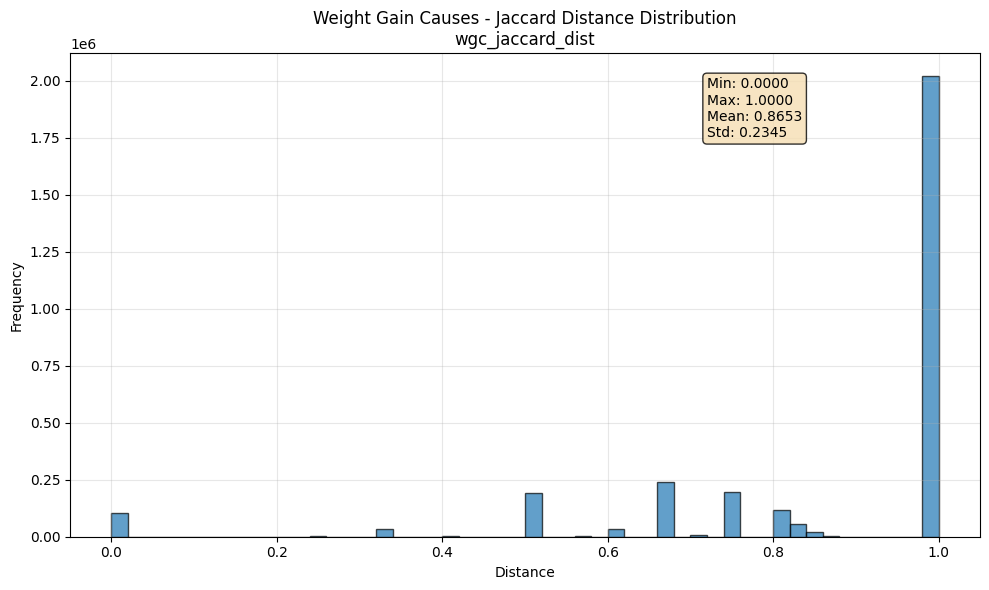

Step 2: Calculating Gower distance matrix for clinical variables...
  Clinical data shape: (2463, 3)
  Variables: ['sex_f', 'age', 'final_bmi']
  Gower distance matrix statistics:
    Min: 0.0000
    Max: 0.8096
    Mean: 0.1965
    Std: 0.1636


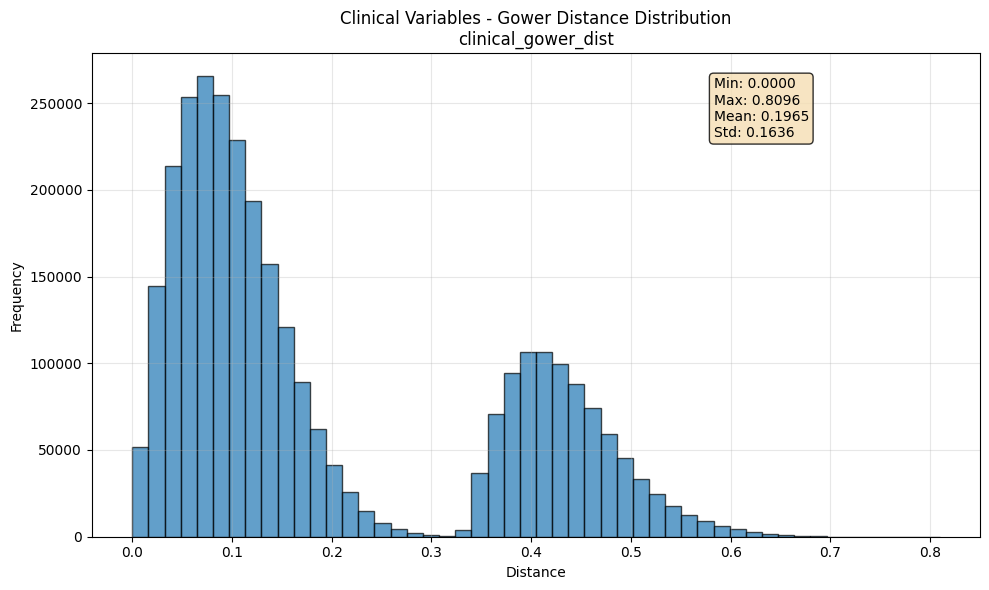

Step 3: Calculating hybrid distance matrix...
  Hybrid distance matrix statistics:
    Min: 0.0000
    Max: 0.9048
    Mean: 0.5309
    Std: 0.1452
 Weighting: 50.0% WGC Jaccard + 50.0% Clinical Gower


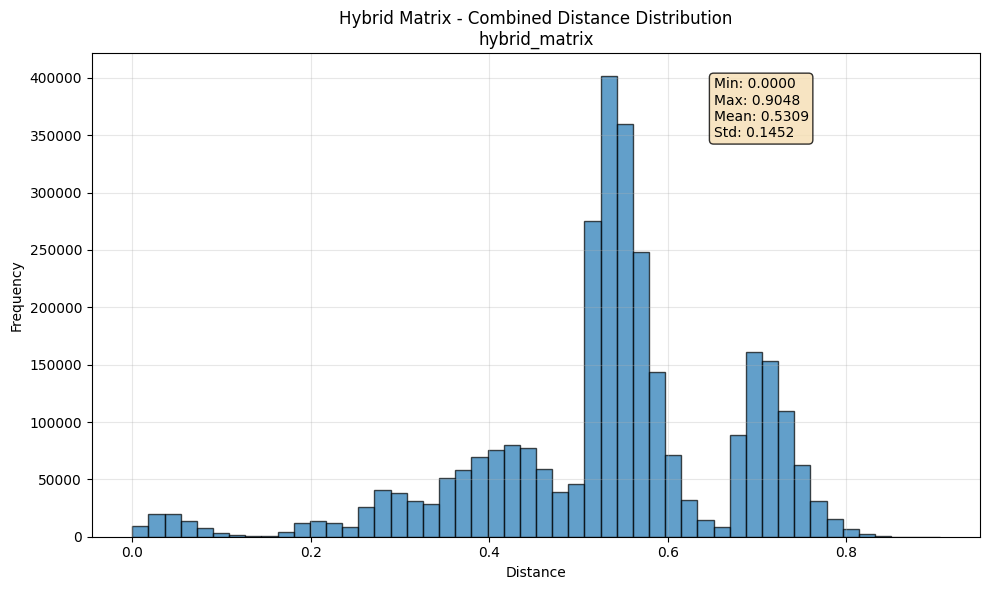


Saving all outputs to 'C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\pnk_db2_p2_cluster_pam_goldstd.sqlite'...
Saving hybrid matrix to 'hybrid_matrix_oc_nobc_bw_pam_goldstd' in 'C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\pnk_db2_p2_cluster_pam_goldstd.sqlite'...
  Matrix reshaped to 6063906 rows and 4 columns.
✓ Successfully saved long-format matrix as 'hybrid_matrix_oc_nobc_bw_pam_goldstd'
Created empty performance scores table 'clust_perf_scores_oc_nobc_bw_pam_goldstd' in 'C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\pnk_db2_p2_cluster_pam_goldstd.sqlite'
Created cluster labels table 'clust_labels_oc_nobc_bw_pam_goldstd' with 2463 records in 'C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\pnk_db2_p2_cluster_pam_goldstd.sqlite'

=== HYBRID CLUSTERING MATRIX PREPARATION COMPLETE ===

=== FINAL PIPELINE SUMMARY ===
Final dataset shape: (2463, 17)
Hybrid matrix shape: (2463, 2463)

=== DATABASE VERIFICATION ===
Connecting to 'C:\Users\Felha

In [2]:
import os
import sqlite3
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
import gower
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# =============================================================================
# CONFIGURATION SECTION
# =============================================================================

# Define data paths
paper2_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\paper2_dir"  # Paper 2-specific files and code


# I/O DBs and input table
INPUT_DB_PATH = os.path.join(paper2_directory, "pnk_db2_p2_in.sqlite")
INPUT_TABLE_NAME = "timetoevent_wgc_compl"
# in cluster DB name, INDICATE THE ALGORITHM TO USE ON THIS PARTICULAR DB - each algorithm setup will have its own DB
# eg PAM 'goldstd' (vs 'default' parameters
CLUSTER_DB_PATH = os.path.join(paper2_directory, "pnk_db2_p2_cluster_pam_goldstd.sqlite")
# Main and metadata output tables
DISTANCE_MATRIX_NAME = "hybrid_matrix_oc_nobc_bw_pam_goldstd"
PERFORMANCE_TABLE = "clust_perf_scores_oc_nobc_bw_pam_goldstd"
LABELS_TABLE = "clust_labels_oc_nobc_bw_pam_goldstd"
# DISTANCE_MATRIX_NAME = "jaccard_matrix_wgc_hclust_ward"
# PERFORMANCE_TABLE = "clust_perf_scores_jaccard_wgc_hclust_ward"
# LABELS_TABLE = "clust_labels_jaccard_wgc_hclust_ward"

# Experiment naming codes: 
# bl/oc: baseline or outcome variables included
# nobc/bc: age-sex-bmi only, or nobc+body composition (fat, vat)
# vw/bw: variable-wise or block-wise weighting during matrix hybridization
#  - ie WGC weight in vw: (n WGC vars)/(n total vars), in bw: 0.5

# Weighting factors for weight gain causes and clinical data when creating the hybrid distance matrix
WGC_WEIGHT = 0.5  # weight for weight gain causes
CLINICAL_WEIGHT = 1 - WGC_WEIGHT  # weight for clinical data

# Define clustering variables
IDENTIFIER_VARS = ['patient_id', 'medical_record_id']
CONTINUOUS_VARS = ['age', 'final_bmi']
BINARY_VARS = [
    'sex_f',
    'womens_health_and_pregnancy', 'mental_health', 'family_issues',
    'medication_disease_injury', 'physical_inactivity', 'eating_habits',
    'schedule', 'smoking_cessation', 'treatment_discontinuation_or_relapse',
    'pandemic', 'lifestyle_circumstances', 'none_of_above'
]

# Weight gain cause variables for Jaccard distance
WEIGHT_GAIN_CAUSE_VARS = [
    'womens_health_and_pregnancy', 'mental_health', 'family_issues', 'medication_disease_injury',
    'physical_inactivity', 'eating_habits', 'schedule', 'smoking_cessation',
    'treatment_discontinuation_or_relapse', 'pandemic', 'lifestyle_circumstances', 'none_of_above'
]

# Clinical variables for Gower distance
CLINICAL_BINARY = ['sex_f', ]
CLINICAL_CONTINUOUS = ['age', 'final_bmi']
ALL_CLINICAL_VARS = CLINICAL_BINARY + CLINICAL_CONTINUOUS



# =============================================================================
# DATA LOADING AND PREPROCESSING FUNCTIONS
# =============================================================================

def load_clustering_data(db_path, table_name, identifier_vars, continuous_vars, binary_vars):
    """Load clustering data using medical record IDs as the primary identifier."""
    all_vars = identifier_vars + continuous_vars + binary_vars
    var_list = ', '.join(all_vars)

    query = f"SELECT {var_list} FROM {table_name} ORDER BY {identifier_vars[1]}"

    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql_query(query, conn)

    print(f"Loaded {len(df)} rows and {len(df.columns)} columns from {table_name}")
    return df

def plot_distance_histogram(distances, title, matrix_name):
    """Plot histogram of distance distributions for diagnostics."""
    plt.figure(figsize=(10, 6))
    plt.hist(distances, bins=50, alpha=0.7, edgecolor='black')
    plt.title(f'{title}\n{matrix_name}')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    # Add statistics text
    stats_text = f'Min: {np.min(distances):.4f}\nMax: {np.max(distances):.4f}\nMean: {np.mean(distances):.4f}\nStd: {np.std(distances):.4f}'
    plt.text(0.7, 0.95, stats_text, transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

def calculate_wgc_jaccard_distance(df, weight_gain_cause_vars, medical_record_ids):
    """
    Calculate Jaccard distance matrix for weight gain causes.
    """
    print("Step 1: Calculating Jaccard distance matrix for weight gain causes...")

    # Extract cause matrix
    cause_matrix = df[weight_gain_cause_vars].copy()

    print(f"  Weight gain cause matrix shape: {cause_matrix.shape}")
    print(f"  Variables: {weight_gain_cause_vars}")

    # Calculate Jaccard distances
    jaccard_distances = pdist(cause_matrix.values, metric='jaccard')
    jaccard_matrix = squareform(jaccard_distances)

    # Handle NaN values
    nan_count = np.isnan(jaccard_matrix).sum()
    if nan_count > 0:
        print(f"  WARNING: {nan_count} NaN values found, replacing with 0")
        jaccard_matrix = np.nan_to_num(jaccard_matrix, nan=0.0)

    # Convert to DataFrame
    jaccard_df = pd.DataFrame(
        jaccard_matrix,
        index=medical_record_ids,
        columns=medical_record_ids
    )

    # Diagnostics
    print(f"  Jaccard distance matrix statistics:")
    print(f"    Min: {np.min(jaccard_distances):.4f}")
    print(f"    Max: {np.max(jaccard_distances):.4f}")
    print(f"    Mean: {np.mean(jaccard_distances):.4f}")
    print(f"    Std: {np.std(jaccard_distances):.4f}")

    # Plot histogram
    plot_distance_histogram(jaccard_distances,
                          'Weight Gain Causes - Jaccard Distance Distribution',
                          'wgc_jaccard_dist')

    return jaccard_df

def calculate_clinical_gower_distance(df, clinical_vars, medical_record_ids):
    """
    Calculate Gower distance matrix for clinical variables.
    """

    print("Step 2: Calculating Gower distance matrix for clinical variables...")
    # Extract clinical data
    clinical_data = df[clinical_vars].copy()

    print(f"  Clinical data shape: {clinical_data.shape}")
    print(f"  Variables: {clinical_vars}")

    clinical_gower_matrix = gower.gower_matrix(clinical_data)

    clinical_gower_df = pd.DataFrame(
        clinical_gower_matrix,
        index=medical_record_ids,
        columns=medical_record_ids
    )

    # Extract the upper triangle for diagnostics (excluding the diagonal)
    gower_distances = clinical_gower_matrix[np.triu_indices_from(clinical_gower_matrix, k=1)]

    # Diagnostics
    print("  Gower distance matrix statistics:")
    print(f"    Min: {np.min(gower_distances):.4f}")
    print(f"    Max: {np.max(gower_distances):.4f}")
    print(f"    Mean: {np.mean(gower_distances):.4f}")
    print(f"    Std: {np.std(gower_distances):.4f}")

    # Plot histogram
    plot_distance_histogram(gower_distances,
                            'Clinical Variables - Gower Distance Distribution',
                            'clinical_gower_dist')

    return clinical_gower_df

def calculate_hybrid_matrix(wgc_jaccard_df, clinical_gower_df, medical_record_ids):
    """
    Calculate hybrid distance matrix.
    """
    print("Step 3: Calculating hybrid distance matrix...")

    hybrid_matrix = WGC_WEIGHT * wgc_jaccard_df.values + CLINICAL_WEIGHT * clinical_gower_df.values

    hybrid_df = pd.DataFrame(
        hybrid_matrix,
        index=medical_record_ids,
        columns=medical_record_ids
    )

    avg_distances = []
    n_patients = len(medical_record_ids)
    for i in range(n_patients):
        patient_distances = np.concatenate([
            hybrid_matrix[i, :i],
            hybrid_matrix[i, i+1:]
        ])
        avg_distance = np.mean(patient_distances)
        avg_distances.append(avg_distance)

    hybrid_distances = hybrid_matrix[np.triu_indices_from(hybrid_matrix, k=1)]

    print(f"  Hybrid distance matrix statistics:")
    print(f"    Min: {np.min(hybrid_distances):.4f}")
    print(f"    Max: {np.max(hybrid_distances):.4f}")
    print(f"    Mean: {np.mean(hybrid_distances):.4f}")
    print(f"    Std: {np.std(hybrid_distances):.4f}")
    print(f" Weighting: {WGC_WEIGHT*100}% WGC Jaccard + {CLINICAL_WEIGHT*100}% Clinical Gower")

    plot_distance_histogram(hybrid_distances,
                          'Hybrid Matrix - Combined Distance Distribution',
                          'hybrid_matrix')

    return hybrid_df, avg_distances

def save_hybrid_matrix_long_format(hybrid_df, avg_distances, db_path, matrix_name):
    """
    Save hybrid matrix in a long format.
    """
    print(f"Saving hybrid matrix to '{matrix_name}' in '{db_path}'...")

    hybrid_to_save = hybrid_df.reset_index()
    hybrid_to_save.rename(columns={'index': 'medical_record_id_1'}, inplace=True)
    hybrid_to_save.insert(1, 'avg_dist_to_all', avg_distances)

    long_format_df = hybrid_to_save.melt(
        id_vars=['medical_record_id_1', 'avg_dist_to_all'],
        var_name='medical_record_id_2',
        value_name='distance'
    )

    long_format_df = long_format_df[long_format_df['medical_record_id_1'] != long_format_df['medical_record_id_2']]

    print(f"  Matrix reshaped to {len(long_format_df)} rows and 4 columns.")

    with sqlite3.connect(db_path) as conn:
        long_format_df.to_sql(matrix_name, conn, if_exists='replace', index=False)

    print(f"✓ Successfully saved long-format matrix as '{matrix_name}'")

# =============================================================================
# UTILITY FUNCTIONS FOR CLUSTERING PIPELINE
# =============================================================================

def create_performance_scores_table(db_path, table_name):
    """Create empty performance scores table."""
    performance_df = pd.DataFrame(columns=[
        'algorithm', 'k', 'hclust_linkage', 'silhouette', 'davies_bouldin', 'calinski_harabasz'
    ])

    with sqlite3.connect(db_path) as conn:
        performance_df.to_sql(table_name, conn, if_exists='replace', index=False)

    print(f"Created empty performance scores table '{table_name}' in '{db_path}'")

def create_cluster_labels_table_with_medical_record_ids(df, db_path, table_name, identifier_vars):
    """Create cluster labels table."""
    labels_df = df[identifier_vars].copy()

    with sqlite3.connect(db_path) as conn:
        labels_df.to_sql(table_name, conn, if_exists='replace', index=False)

    print(f"Created cluster labels table '{table_name}' with {len(labels_df)} records in '{db_path}'")

# =============================================================================
# MAIN PIPELINE FUNCTION
# =============================================================================

def prepare_hybrid_clustering_data():
    """
    Main function to prepare and save the hybrid distance matrix.
    """
    print("=== HYBRID CLUSTERING DATA PREPARATION ===")
    
    # Load initial data from the input database
    print(f"\nLoading clustering data from '{INPUT_DB_PATH}'...")
    df = load_clustering_data(INPUT_DB_PATH, INPUT_TABLE_NAME, IDENTIFIER_VARS, CONTINUOUS_VARS, BINARY_VARS)
    
    medical_record_ids = df['medical_record_id'].tolist()
    
    # Calculate distance matrices
    wgc_jaccard_dist = calculate_wgc_jaccard_distance(df, WEIGHT_GAIN_CAUSE_VARS, medical_record_ids)
    clinical_gower_dist = calculate_clinical_gower_distance(df, ALL_CLINICAL_VARS, medical_record_ids)
    hybrid_matrix, avg_distances = calculate_hybrid_matrix(wgc_jaccard_dist, clinical_gower_dist, medical_record_ids)
    
    # Save hybrid matrix and metadata tables to the output database
    print(f"\nSaving all outputs to '{CLUSTER_DB_PATH}'...")
    save_hybrid_matrix_long_format(hybrid_matrix, avg_distances, CLUSTER_DB_PATH, DISTANCE_MATRIX_NAME)
    create_performance_scores_table(CLUSTER_DB_PATH, PERFORMANCE_TABLE)
    create_cluster_labels_table_with_medical_record_ids(df, CLUSTER_DB_PATH, LABELS_TABLE, IDENTIFIER_VARS)
    
    print("\n=== HYBRID CLUSTERING MATRIX PREPARATION COMPLETE ===")
    
    return df, hybrid_matrix

# =============================================================================
# MAIN EXECUTION
# =============================================================================

# Execute hybrid data preparation
df_clustering, prepared_hybrid_matrix = prepare_hybrid_clustering_data()

# Display comprehensive summary
print(f"\n=== FINAL PIPELINE SUMMARY ===")
print(f"Final dataset shape: {df_clustering.shape}")
print(f"Hybrid matrix shape: {prepared_hybrid_matrix.shape}")

print(f"\n=== DATABASE VERIFICATION ===")
# Verify the output database and its tables
try:
    with sqlite3.connect(CLUSTER_DB_PATH) as conn:
        print(f"Connecting to '{CLUSTER_DB_PATH}' for verification...")
        labels_sample = pd.read_sql_query(f"SELECT * FROM {LABELS_TABLE} LIMIT 3", conn)
        
        query = f"""
        SELECT 
            medical_record_id_1 AS medical_record_id, 
            avg_dist_to_all 
        FROM 
            {DISTANCE_MATRIX_NAME}
        LIMIT 3
        """
        hybrid_sample = pd.read_sql_query(query, conn)

    print("\nSample labels table from the new cluster database:")
    print(labels_sample.to_string())
    print("\nSample hybrid matrix with outlier detection from the new cluster database:")
    print(hybrid_sample.to_string())
    print("\nVerification successful. All output tables created in the correct database.")

except Exception as e:
    print(f"An error occurred during verification: {e}")

print(f"\n🎯 READY FOR CLUSTERING: All data saved to '{CLUSTER_DB_PATH}'!")

#### Clustering algorithms

##### Hierarchical clustering

=== HIERARCHICAL CLUSTERING PIPELINE ===
Dendrograms directory already exists: C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\hclust_dendrograms
Loading long-format distance matrix from 'hybrid_matrix_bl_nobc_vw_hclust_ward'...
✓ Reconstructed long-format input distance matrix to square matrix of shape (2463, 2463)
No outlier filtering applied.
Loaded existing labels table with 2463 records

Running clustering in parallel across 1 linkage methods...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Saving results to database...


C:\Users\Felhasználó\AppData\Local\Temp\ipykernel_652\960096875.py:342: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  updated_df = pd.concat([existing_df, new_row], ignore_index=True)



Running final evaluations...


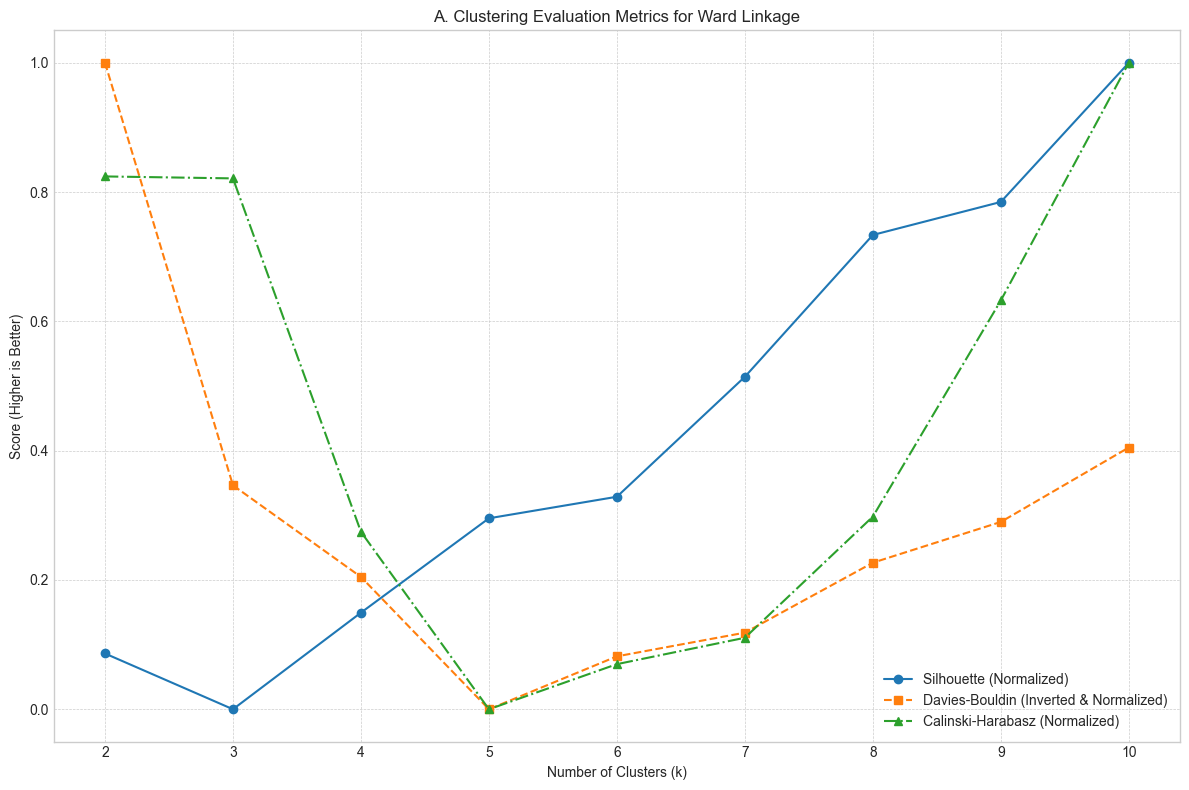


=== HIERARCHICAL CLUSTERING COMPLETE ===
Total runs completed: 9
Original dataset: 2463 patients
Clustering performed on: 2463 patients
Results saved to:
  - Performance scores: clust_perf_scores_bl_nobc_vw_hclust_ward
  - Cluster labels: clust_labels_bl_nobc_vw_hclust_ward
  - Dendrograms: C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\hclust_dendrograms

=== SUMMARY ===
Generated 9 hierarchical clustering results

Best results by metric:
  Best Silhouette: ward k=10 (score: 0.3447)
  Best Davies-Bouldin: ward k=2 (score: 0.8648)
  Best Calinski-Harabasz: ward k=10 (score: 448.7591)

Cluster labels table contains 2463 records
Medical Record ID range: 101ECB42A682D to 140B4142A682D


In [10]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.preprocessing import MinMaxScaler # Added for normalization
from sklearn.utils import resample # Added for bootstrapping
from joblib import Parallel, delayed # Added for parallelization

# =============================================================================
# CONFIGURATION SECTION
# =============================================================================

# Define data paths
# Assuming paper1_directory is defined in the execution environment
# For standalone execution, you might need to define it, e.g., paper1_directory = '.'

paper2_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\paper2_dir"  # Paper 2-specific files and code

DATABASE_PATH = os.path.join(paper2_directory, "pnk_db2_p2_cluster_hclust_ward.sqlite")

INPUT_DISTANCE_MATRIX = "hybrid_matrix_bl_nobc_vw_hclust_ward"
PERFORMANCE_TABLE = "clust_perf_scores_bl_nobc_vw_hclust_ward"
LABELS_TABLE = "clust_labels_bl_nobc_vw_hclust_ward"

# INPUT_DISTANCE_MATRIX = "jaccard_matrix_wgc_hclust_ward"
# PERFORMANCE_TABLE = "clust_perf_scores_jaccard_wgc_hclust_ward"
# LABELS_TABLE = "clust_labels_jaccard_wgc_hclust_ward"

# Output directory for dendrograms
DENDROGRAMS_DIR = os.path.join(paper2_directory, "hclust_dendrograms")

# Clustering parameters
LINKAGE_METHODS = [
    'ward', 
    # 'complete', 
    # 'average', 
    # 'single'
]

K_RANGE = range(
    2, 11
)  # k values from 2 to 10

N_JOBS = -1 # Use all available CPU cores for parallel processing

# Bootstrap evaluation parameters
N_BOOTSTRAP = 0 # Number of bootstrap resamples

# Outlier filtering parameters
N_OUTLIERS = 0  # Set to 0 to disable outlier removal

# Plot parameters
FIGURE_SIZE = (12, 8)
DPI = 300

# =============================================================================
# FUNCTIONS
# =============================================================================

def load_longform_input_matrix(db_path, table_name):
    """
    Load long-format hybrid distance matrix from SQLite database.
    """
    print(f"Loading long-format distance matrix from '{table_name}'...")

    with sqlite3.connect(db_path) as conn:
        long_distance_matrix_df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    
    # Store avg_dist_to_all before pivoting - the average distance to other records is used for outlier detection and filtering
    avg_dist_df = long_distance_matrix_df[['medical_record_id_1', 'avg_dist_to_all']].drop_duplicates().set_index('medical_record_id_1')

    square_distance_matrix_df = long_distance_matrix_df.pivot(
        index='medical_record_id_1',
        columns='medical_record_id_2',
        values='distance'
    )

    # Ensure the matrix is perfectly square and ordered correctly
    all_ids = sorted(list(square_distance_matrix_df.index))
    square_distance_matrix_df = square_distance_matrix_df.reindex(index=all_ids, columns=all_ids)

    # Align avg_dist_df with the final sorted matrix
    avg_dist_df = avg_dist_df.reindex(all_ids)

    # Fill diagonal with 0s for self-distance
    np.fill_diagonal(square_distance_matrix_df.values, 0)

    record_ids = square_distance_matrix_df.index.tolist()
    square_distance_matrix = square_distance_matrix_df.values

    print(f"✓ Reconstructed long-format input distance matrix to square matrix of shape {square_distance_matrix.shape}")
    return square_distance_matrix, record_ids, avg_dist_df['avg_dist_to_all'].values

def detect_and_filter_outliers(square_distance_matrix, all_record_ids, avg_distances, n_outliers):
    """Detects outliers and returns the filtered matrix and corresponding IDs."""
    if n_outliers <= 0:
        print("No outlier filtering applied.")
        return square_distance_matrix, all_record_ids, [], []

    print(f"\n--- OUTLIER DETECTION ---")
    print(f"Detecting and removing top {n_outliers} outliers...")
    
    # Use the avg_distances array to find the indices of the outliers
    outlier_indices = np.argsort(avg_distances)[-n_outliers:]
    outlier_record_ids = [all_record_ids[i] for i in outlier_indices]
    
    # Create a boolean mask to select non-outliers
    keep_mask = np.ones(len(all_record_ids), dtype=bool)
    keep_mask[outlier_indices] = False
    
    # Get the record IDs of the patients we are keeping
    filtered_record_ids = [rid for i, rid in enumerate(all_record_ids) if keep_mask[i]]
    
    # Use the boolean mask to slice the matrix efficiently
    filtered_distance_matrix = square_distance_matrix[keep_mask][:, keep_mask]

    print(f"Identified {len(outlier_record_ids)} outliers. Retaining {len(filtered_record_ids)} patients.")
    print(f"Final clustering matrix shape: {filtered_distance_matrix.shape}")
    
    return filtered_distance_matrix, filtered_record_ids, outlier_record_ids, outlier_indices

def ensure_labels_table_exists(db_path, labels_table, all_record_ids):
    """
    Ensure the cluster labels table exists with ALL record IDs (including outliers).
    
    Parameters:
    -----------
    db_path : str
        Path to SQLite database
    labels_table : str
        Name of the cluster labels table
    all_record_ids : list
        List of ALL medical record IDs (including outliers)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with patient identifiers
    """
    with sqlite3.connect(db_path) as conn:
        try:
            # Try to load existing table
            labels_df = pd.read_sql_query(f"SELECT * FROM {labels_table}", conn)
            print(f"Loaded existing labels table with {len(labels_df)} records")
            
            # Verify that record IDs match
            existing_ids = labels_df['medical_record_id'].tolist()
            if set(existing_ids) != set(all_record_ids):
                print("Warning: Record IDs in labels table don't match full dataset")
                print("Updating labels table with ALL record IDs (including outliers)...")
                # Update with ALL IDs
                labels_df = pd.DataFrame({'medical_record_id': all_record_ids})
                labels_df['patient_id'] = range(len(all_record_ids))  # Sequential patient IDs
                labels_df.to_sql(labels_table, conn, if_exists='replace', index=False)
        
        except:
            # Create new table if it doesn't exist
            print(f"Creating new labels table with {len(all_record_ids)} records (including outliers)")
            labels_df = pd.DataFrame({'medical_record_id': all_record_ids})
            labels_df['patient_id'] = range(len(all_record_ids))  # Sequential patient IDs
            labels_df.to_sql(labels_table, conn, if_exists='replace', index=False)
    
    return labels_df

def create_dendrograms_directory(output_dir):
    """
    Create directory for saving dendrograms.
    
    Parameters:
    -----------
    output_dir : str
        Path to the output directory
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created dendrograms directory: {output_dir}")
    else:
        print(f"Dendrograms directory already exists: {output_dir}")

def perform_hierarchical_clustering(distance_matrix, linkage_method):
    """
    Perform hierarchical clustering using specified linkage method.
    
    Parameters:
    -----------
    distance_matrix : np.ndarray
        Distance matrix (Gower dissimilarity matrix)
    linkage_method : str
        Linkage method ('ward', 'complete', 'average', 'single')
    
    Returns:
    --------
    np.ndarray
        Linkage matrix from hierarchical clustering
    """
    # Convert distance matrix to condensed form for scipy
    condensed_distances = squareform(distance_matrix, checks=False)
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(condensed_distances, method=linkage_method)
    
    return linkage_matrix

def extract_clusters(linkage_matrix, k):
    """
    Extract cluster labels for specified number of clusters.
    
    Parameters:
    -----------
    linkage_matrix : np.ndarray
        Linkage matrix from hierarchical clustering
    k : int
        Number of clusters
    
    Returns:
    --------
    np.ndarray
        Cluster labels (0-indexed)
    """
    # Extract clusters (fcluster returns 1-indexed labels, convert to 0-indexed)
    cluster_labels = fcluster(linkage_matrix, k, criterion='maxclust') - 1
    return cluster_labels

def calculate_clustering_metrics(distance_matrix, cluster_labels):
    """
    Calculate clustering evaluation metrics.
    
    Parameters:
    -----------
    distance_matrix : np.ndarray
        Distance matrix
    cluster_labels : np.ndarray
        Cluster labels
    
    Returns:
    --------
    tuple
        (silhouette_score, davies_bouldin_score, calinski_harabasz_score)
    """
    # For silhouette score, we need the distance matrix in the right format
    n_clusters = len(np.unique(cluster_labels))
    
    if n_clusters <= 1 or n_clusters >= len(cluster_labels):
        # Can't calculate metrics with only one cluster or n_samples clusters
        return np.nan, np.nan, np.nan
    
    try:
        # Silhouette score using precomputed distance matrix
        sil_score = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
        
        # For Davies-Bouldin and Calinski-Harabasz, we need the original data
        # Since we only have distances, we'll use MDS to reconstruct approximate coordinates
        from sklearn.manifold import MDS
        # Ensure n_components is less than n_samples
        n_components = min(10, len(distance_matrix) - 1)
        mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42, n_init=4)
        coords = mds.fit_transform(distance_matrix)
        
        db_score = davies_bouldin_score(coords, cluster_labels)
        ch_score = calinski_harabasz_score(coords, cluster_labels)
        
        return sil_score, db_score, ch_score
    
    except Exception as e:
        print(f"Warning: Could not calculate all metrics - {e}")
        return np.nan, np.nan, np.nan

def plot_dendrogram(linkage_matrix, linkage_method, k, output_dir, record_ids, figure_size=(12, 8), outlier_info=None):
    """
    Plot and save dendrogram with record ID information.
    
    Parameters:
    -----------
    linkage_matrix : np.ndarray
        Linkage matrix from hierarchical clustering
    linkage_method : str
        Linkage method used
    k : int
        Number of clusters (for color coding)
    output_dir : str
        Directory to save the plot
    record_ids : list
        List of medical record IDs
    figure_size : tuple
        Figure size (width, height)
    outlier_info : dict
        Information about outliers (optional)
    """
    plt.figure(figsize=FIGURE_SIZE)
    
    # Create dendrogram with color threshold for k clusters
    dendrogram(linkage_matrix, 
                color_threshold=linkage_matrix[-k+1, 2],
                above_threshold_color='gray')
    
    # Create title with outlier information
    title = f'B. Hierarchical Clustering Dendrogram\n{linkage_method.capitalize()} Linkage, k={k}\n({len(record_ids)} patients'
    if outlier_info and outlier_info['n_outliers'] > 0:
        title += f', {outlier_info["n_outliers"]} outliers removed)'
    else:
        title += ')'
    
    plt.title(title)
    plt.xlabel('Patient Index (Medical Record IDs)')
    plt.ylabel('Distance')
    plt.grid(True, alpha=0.3)
    
    # Save plot
    filename = f"hclust_{linkage_method}_k{k}.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=DPI, bbox_inches='tight')
    plt.close()
    
    print(f"Saved dendrogram: {filename}")

def add_performance_scores(db_path, table_name, algorithm, k, hclust_linkage, silhouette, davies_bouldin, calinski_harabasz):
    """
    Adds performance scores to the database, handling None for hclust_linkage.
    """
    new_row = pd.DataFrame({
        'algorithm': [algorithm], 'k': [k], 'hclust_linkage': [hclust_linkage],
        'silhouette': [silhouette], 'davies_bouldin': [davies_bouldin], 'calinski_harabasz': [calinski_harabasz]
    })
    
    with sqlite3.connect(db_path) as conn:
        try:
            existing_df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
            # Logic to handle both PAM (linkage is None) and HCA
            if hclust_linkage is None:
                mask = (existing_df['algorithm'] == algorithm) & (existing_df['k'] == k)
            else:
                mask = (existing_df['algorithm'] == algorithm) & (existing_df['k'] == k) & (existing_df['hclust_linkage'] == hclust_linkage)
            
            if mask.any():
                for col in new_row.columns: existing_df.loc[mask, col] = new_row[col].iloc[0]
                updated_df = existing_df
            else:
                updated_df = pd.concat([existing_df, new_row], ignore_index=True)
        except:
            updated_df = new_row
        
        updated_df.to_sql(table_name, conn, if_exists='replace', index=False)

def add_cluster_labels_column(db_path, table_name, column_name, labels, clustering_record_ids, all_record_ids, outlier_record_ids):
    """
    Add cluster labels column to the database, ensuring proper record ID alignment.
    
    Parameters:
    -----------
    db_path : str
        Path to SQLite database
    table_name : str
        Name of the cluster labels table
    column_name : str
        Name of the new column
    labels : array-like
        Cluster labels
    clustering_record_ids : list
        List of medical record IDs used in clustering
    all_record_ids : list
        List of all medical record IDs for verification
    outlier_record_ids : list
        List of medical record IDs identified as outliers
    """
    with sqlite3.connect(db_path) as conn:
        existing_df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        
        # Convert column to object type to handle mixed types
        existing_df[column_name] = pd.Series(dtype='object')
        
        # Create a mapping from clustering record_id to label
        label_mapping = dict(zip(clustering_record_ids, labels))
        
        # Apply labels to non-outliers, mark outliers with -1
        for idx, rid in enumerate(existing_df['medical_record_id']):
            if rid in label_mapping:
                existing_df.loc[idx, column_name] = int(label_mapping[rid])  # Ensure integer labels
            elif rid in outlier_record_ids:
                existing_df.loc[idx, column_name] = -1  # Mark outliers with -1
            else:
                # This shouldn't happen if data is consistent
                existing_df.loc[idx, column_name] = -999  # Error flag
        
        existing_df.to_sql(table_name, conn, if_exists='replace', index=False)

# --- Plotting Evaluation Metrics ---
def plot_evaluation_metrics(performance_df, linkage_method):
    """
    Plots normalized internal metrics and the non-normalized bootstrap ARI score.

    Parameters:
    -----------
    performance_df : pd.DataFrame
        DataFrame containing 'k', 'silhouette', 'davies_bouldin', 
        'calinski_harabasz', and optionally 'bootstrap_ari' columns.
    linkage_method : str
        The linkage method used, for the plot title.
    """
    df = performance_df.copy()
    
    # --- Internal metrics processing ---
    internal_metrics = [
        'silhouette', 
        # 'davies_bouldin', 
        'calinski_harabasz'
    ]
    df_internal = df.dropna(subset=internal_metrics)
    
    if not df_internal.empty:
        # Invert Davies-Bouldin score (lower is better -> higher is better)
        df_internal['inv_davies_bouldin'] = 1 / (df_internal['davies_bouldin'] + 1e-6)
        
        # Select scores for normalization
        scores_to_normalize = df_internal[['silhouette', 'inv_davies_bouldin', 'calinski_harabasz']]
        
        # Normalize scores using MinMaxScaler
        scaler = MinMaxScaler()
        normalized_scores = scaler.fit_transform(scores_to_normalize)
        
        # Create a new DataFrame with normalized scores
        normalized_df = pd.DataFrame(normalized_scores, columns=[
            'Silhouette (Normalized)', 
            'Davies-Bouldin (Inverted & Normalized)', 
            'Calinski-Harabasz (Normalized)'
        ], index=df_internal.index)
        normalized_df['k'] = df_internal['k']
    else:
        normalized_df = pd.DataFrame() # Empty df if no internal metrics

    # --- Plotting ---
    plt.figure(figsize=FIGURE_SIZE)
    
    # Plot normalized internal metrics if available
    if not normalized_df.empty:
        plt.plot(normalized_df['k'], normalized_df['Silhouette (Normalized)'], marker='o', linestyle='-', label='Silhouette (Normalized)')
        plt.plot(normalized_df['k'], normalized_df['Davies-Bouldin (Inverted & Normalized)'], marker='s', linestyle='--', label='Davies-Bouldin (Inverted & Normalized)')
        plt.plot(normalized_df['k'], normalized_df['Calinski-Harabasz (Normalized)'], marker='^', linestyle='-.', label='Calinski-Harabasz (Normalized)')

    # Plot Bootstrap ARI score if available (it's already 0-1 scaled)
    # if 'bootstrap_ari' in df.columns and df['bootstrap_ari'].notna().any():
    #     df_ari = df.dropna(subset=['bootstrap_ari'])
    #     plt.plot(df_ari['k'], df_ari['bootstrap_ari'], marker='D', linestyle=':', color='red', label='Bootstrap Stability (ARI)')

    # if normalized_df.empty and ('bootstrap_ari' not in df.columns or not df['bootstrap_ari'].notna().any()):
    #     print(f"No valid scores to plot for {linkage_method} linkage.")
    #     plt.close()
    #     return

    plt.title(f'A. Clustering Evaluation Metrics for {linkage_method.capitalize()} Linkage')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Score (Higher is Better)')
    plt.xticks(ticks=df['k'].unique())
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# --- Bootstrap Stability Evaluation ---
def run_bootstrap_evaluation(db_path, labels_table, performance_table, distance_matrix, linkage_method, k_range, n_bootstrap):
    """
    Performs bootstrap cluster stability evaluation and saves the mean ARI score.
    
    Parameters:
    -----------
    db_path : str
        Path to the SQLite database.
    labels_table : str
        Name of the table containing original cluster labels.
    performance_table : str
        Name of the table to save performance scores.
    distance_matrix : np.ndarray
        The original distance matrix used for clustering.
    linkage_method : str
        The linkage method to evaluate.
    k_range : range
        The range of k values to test.
    n_bootstrap : int
        The number of bootstrap iterations.
    """
    print(f"\n--- Running Bootstrap Stability Evaluation for {linkage_method} linkage ({n_bootstrap} iterations) ---")
    with sqlite3.connect(db_path) as conn:
        labels_df = pd.read_sql_query(f"SELECT * FROM {labels_table}", conn)
        performance_df = pd.read_sql_query(f"SELECT * FROM {performance_table}", conn)

    if 'bootstrap_ari' not in performance_df.columns:
        performance_df['bootstrap_ari'] = np.nan

    n_samples = distance_matrix.shape[0]
    original_indices = np.arange(n_samples)

    for k in k_range:
        col_name = f"hclust_{linkage_method}_k{k}"
        if col_name not in labels_df.columns:
            print(f"Warning: Original labels for k={k} not found. Skipping bootstrap.")
            continue
        
        # Get original labels for non-outlier data
        original_labels = labels_df[labels_df[col_name] != -1][col_name].values
        
        if len(original_labels) != n_samples:
            print(f"Warning: Mismatch in label count for k={k}. Skipping bootstrap.")
            continue

        ari_scores = []
        for i in range(n_bootstrap):
            # Create bootstrap sample of indices
            boot_indices = resample(original_indices, replace=True, n_samples=n_samples)
            
            # Get labels and distance matrix for the bootstrap sample
            boot_labels_original = original_labels[boot_indices]
            boot_distance_matrix = distance_matrix[np.ix_(boot_indices, boot_indices)]

            # Perform clustering on the bootstrap sample
            try:
                boot_linkage_matrix = perform_hierarchical_clustering(boot_distance_matrix, linkage_method)
                boot_labels_new = extract_clusters(boot_linkage_matrix, k)
                
                # Calculate ARI between original labels (of bootstrapped items) and new labels
                ari = adjusted_rand_score(boot_labels_original, boot_labels_new)
                ari_scores.append(ari)
            except Exception as e:
                # This can happen if a bootstrap sample results in a single cluster
                # print(f"Could not compute ARI for bootstrap sample {i+1} at k={k}: {e}")
                pass
        
        if ari_scores:
            mean_ari = np.mean(ari_scores)
            print(f"   k={k}: Mean Adjusted Rand Index = {mean_ari:.4f}")
            
            # Find the corresponding row in the performance DataFrame and update it
            mask = (performance_df['algorithm'] == 'hclust') & \
                    (performance_df['k'] == k) & \
                    (performance_df['hclust_linkage'] == linkage_method)
            performance_df.loc[mask, 'bootstrap_ari'] = mean_ari
        else:
            print(f"   k={k}: Could not calculate any valid ARI scores.")

    # Save the updated performance table back to the database
    with sqlite3.connect(db_path) as conn:
        performance_df.to_sql(performance_table, conn, if_exists='replace', index=False)
    print("Bootstrap ARI scores saved to the performance table.")

# PARALLEL PROCESSING WORKER FUNCTION

def process_linkage_method(linkage_method, distance_matrix, k_range, output_dir, record_ids, fig_size, outlier_info):
    """Worker function to process one linkage method. Runs in a separate process."""
    print(f"\n--- Processing {linkage_method} linkage ---")
    results = []
    try:
        print(f"\n--- Starting linkage calculation for {linkage_method}... (This is the slow part) ---")
        linkage_matrix = perform_hierarchical_clustering(distance_matrix, linkage_method)
        print(f"--- Linkage calculation for {linkage_method} COMPLETE. Now processing k values... ---")
        for k in k_range:
            labels = extract_clusters(linkage_matrix, k)
            sil, db, ch = calculate_clustering_metrics(distance_matrix, labels)
            
            run_result = {
                'k': k, 'hclust_linkage': linkage_method, 'silhouette': sil,
                'davies_bouldin': db, 'calinski_harabasz': ch, 'labels': labels
            }
            results.append(run_result)
            
            plot_dendrogram(linkage_matrix, linkage_method, k, output_dir, record_ids, fig_size, outlier_info)
        return results
    except Exception as e:
        print(f"FATAL ERROR processing {linkage_method} linkage: {e}")
        return []
    
# =============================================================================
# MAIN ORCHESTRATION PIPELINE
# =============================================================================

def run_hierarchical_clustering_pipeline():
    """Main function to run the complete, parallelized pipeline."""
    print("=== HIERARCHICAL CLUSTERING PIPELINE ===")
    
    # Step 1: Setup and Load Data
    create_dendrograms_directory(DENDROGRAMS_DIR)
    full_distance_matrix, all_record_ids, avg_distances = load_longform_input_matrix(DATABASE_PATH, INPUT_DISTANCE_MATRIX)
    
    # Step 2: Outlier Filtering
    clustering_matrix, clustering_ids, outlier_ids, _ = detect_and_filter_outliers(
        full_distance_matrix, all_record_ids, avg_distances, N_OUTLIERS
    )
    
    # Step 3: Prepare Database Tables
    ensure_labels_table_exists(DATABASE_PATH, LABELS_TABLE, all_record_ids)
    
    # Step 4: Run Clustering in Parallel
    print(f"\nRunning clustering in parallel across {len(LINKAGE_METHODS)} linkage methods...")
    outlier_info = {'n_outliers': len(outlier_ids), 'outlier_ids': outlier_ids}
    
    parallel_results = Parallel(n_jobs=N_JOBS, verbose=1)(
        delayed(process_linkage_method)(
            method, clustering_matrix, K_RANGE, DENDROGRAMS_DIR, clustering_ids, FIGURE_SIZE, outlier_info
        ) for method in LINKAGE_METHODS
    )
    all_results = [item for sublist in parallel_results for item in sublist]

    # Step 5: Save All Results Serially
    print("\nSaving results to database...")
    for result in all_results:
        add_performance_scores(DATABASE_PATH, PERFORMANCE_TABLE, 'hclust', result['k'], result['hclust_linkage'],
                               result['silhouette'], result['davies_bouldin'], result['calinski_harabasz'])
        
        column_name = f"hclust_{result['hclust_linkage']}_k{result['k']}"
        add_cluster_labels_column(DATABASE_PATH, LABELS_TABLE, column_name, result['labels'], 
                                  clustering_ids, all_record_ids, outlier_ids)
        
    # Step 6: Optional Bootstrap and Final Evaluation Plots
    print("\nRunning final evaluations...")
    with sqlite3.connect(DATABASE_PATH) as conn:
        final_perf_df = pd.read_sql_query(f"SELECT * FROM {PERFORMANCE_TABLE} WHERE algorithm='hclust'", conn)

    for linkage_method in LINKAGE_METHODS:
        # Check if bootstrap evaluation is enabled in the config
        if 'N_BOOTSTRAP' in globals() and N_BOOTSTRAP > 0:
            run_bootstrap_evaluation(DATABASE_PATH, LABELS_TABLE, PERFORMANCE_TABLE, 
                                     clustering_matrix, linkage_method, K_RANGE, N_BOOTSTRAP)
        
        method_df = final_perf_df[final_perf_df['hclust_linkage'] == linkage_method]
        if not method_df.empty:
            plot_evaluation_metrics(method_df, linkage_method)

    # --- Final Summary ---
    print("\n=== HIERARCHICAL CLUSTERING COMPLETE ===")
    print(f"Total runs completed: {len(all_results)}")
    if N_OUTLIERS > 0:
        print(f"Outlier filtering: {N_OUTLIERS} outliers removed")
    print(f"Original dataset: {len(all_record_ids)} patients")
    print(f"Clustering performed on: {len(clustering_ids)} patients")
    print(f"Results saved to:")
    print(f"  - Performance scores: {PERFORMANCE_TABLE}")
    print(f"  - Cluster labels: {LABELS_TABLE}")
    print(f"  - Dendrograms: {DENDROGRAMS_DIR}")

# =============================================================================
# MAIN EXECUTION
# =============================================================================

# Run the complete hierarchical clustering pipeline
run_hierarchical_clustering_pipeline()

# Display summary of results
print(f"\n=== SUMMARY ===")
with sqlite3.connect(DATABASE_PATH) as conn:
    performance_df = pd.read_sql_query(f"SELECT * FROM {PERFORMANCE_TABLE} WHERE algorithm='hclust'", conn)
    print(f"Generated {len(performance_df)} hierarchical clustering results")
    
    if len(performance_df) > 0:
        print(f"\nBest results by metric:")
        best_sil = performance_df.loc[performance_df['silhouette'].idxmax()]
        print(f"  Best Silhouette: {best_sil['hclust_linkage']} k={best_sil['k']} (score: {best_sil['silhouette']:.4f})")
        
        best_db = performance_df.loc[performance_df['davies_bouldin'].idxmin()]
        print(f"  Best Davies-Bouldin: {best_db['hclust_linkage']} k={best_db['k']} (score: {best_db['davies_bouldin']:.4f})")
        
        best_ch = performance_df.loc[performance_df['calinski_harabasz'].idxmax()]
        print(f"  Best Calinski-Harabasz: {best_ch['hclust_linkage']} k={best_ch['k']} (score: {best_ch['calinski_harabasz']:.4f})")
        
        # --- NEW: Display best bootstrap ARI score ---
        if 'bootstrap_ari' in performance_df.columns and not performance_df['bootstrap_ari'].isnull().all():
            best_ari = performance_df.loc[performance_df['bootstrap_ari'].idxmax()]
            print(f"  Best Bootstrap Stability (ARI): {best_ari['hclust_linkage']} k={best_ari['k']} (score: {best_ari['bootstrap_ari']:.4f})")

    # Display record ID information
    labels_df = pd.read_sql_query(f"SELECT * FROM {LABELS_TABLE}", conn)
    print(f"\nCluster labels table contains {len(labels_df)} records")
    print(f"Medical Record ID range: {labels_df['medical_record_id'].min()} to {labels_df['medical_record_id'].max()}")
    
    if N_OUTLIERS > 0:
        print(f"\nOutlier filtering was applied:")
        print(f"  - {N_OUTLIERS} outliers removed from clustering")
        print(f"  - Final clustering performed on {len(labels_df) - N_OUTLIERS} patients")


##### PAM/K-medoids

###### Theoretical gold standard: method = PAM, init = k-medoids++, 10 init iterations for each k

vw run 15pm 22Sept25

=== PAM CLUSTERING PIPELINE (PARALLELIZED) ===
Loading long-format distance matrix from 'hybrid_matrix_oc_nobc_vw_pam_goldstd'...
✓ Reconstructed long-format input distance matrix to square matrix of shape (2463, 2463)
No outlier filtering applied.
Loaded existing labels table with 2463 records

Running PAM clustering in parallel for k in [2, 3, 4, 5, 6, 7, 8, 9, 10]...
--- Processing PAM for k=9 ---
  Running k=9 with 10 initializations...
--- Processing PAM for k=6 ---
  Running k=6 with 10 initializations...
--- Processing PAM for k=7 ---
  Running k=7 with 10 initializations...
--- Processing PAM for k=5 ---
  Running k=5 with 10 initializations...
--- Processing PAM for k=4 ---
  Running k=4 with 10 initializations...
--- Processing PAM for k=3 ---
  Running k=3 with 10 initializations...
--- Processing PAM for k=8 ---
  Running k=8 with 10 initializations...
--- Processing PAM for k=2 ---
  Running k=2 with 10 initializations...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


  Medoid-to-Cluster Map for k=2: {np.int64(0): '1373AE42A682D', np.int64(1): '12CBE242A682D'}
  Best run for k=2 found with seed=4 (Inertia: 1351.97)
  Medoid-to-Cluster Map for k=3: {np.int64(0): '136C2142A682D', np.int64(1): '13E91A42A682D', np.int64(2): '10B09942A682D'}
  Best run for k=3 found with seed=0 (Inertia: 1134.15)
  Medoid-to-Cluster Map for k=4: {np.int64(0): '1289F342A682D', np.int64(1): '1162FC42A682D', np.int64(2): '10B09942A682D', np.int64(3): '12A88A42A682D'}
  Best run for k=4 found with seed=0 (Inertia: 1005.71)
  Medoid-to-Cluster Map for k=5: {np.int64(0): '1292C842A682D', np.int64(1): '13700D42A682D', np.int64(2): '10B09942A682D', np.int64(3): '12AC1642A682D', np.int64(4): '13335E42A682D'}
  Best run for k=5 found with seed=0 (Inertia: 912.72)
  Medoid-to-Cluster Map for k=6: {np.int64(0): '12B73742A682D', np.int64(1): '13664C42A682D', np.int64(2): '12BCB742A682D', np.int64(3): '136C6B42A682D', np.int64(4): '12B35B42A682D', np.int64(5): '1397F142A682D'}
  Best 

[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed: 36.6min remaining: 127.9min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed: 36.8min remaining: 73.6min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed: 37.0min remaining: 46.3min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed: 37.7min remaining: 30.2min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 38.7min remaining: 19.4min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 39.3min remaining: 11.2min


  Medoid-to-Cluster Map for k=10: {np.int64(0): '1362E042A682D', np.int64(1): '13664C42A682D', np.int64(2): '134FDE42A682D', np.int64(3): '12B73742A682D', np.int64(4): '12AC1642A682D', np.int64(5): '137F8D42A682D', np.int64(6): '12826342A682D', np.int64(7): '10A53B42A682D', np.int64(8): '12A49742A682D', np.int64(9): '135F7042A682D'}
  Best run for k=10 found with seed=0 (Inertia: 642.31)


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 45.9min finished
C:\Users\Felhasználó\AppData\Local\Temp\ipykernel_912\315473617.py:260: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  updated_df = pd.concat([existing_df, new_row], ignore_index=True)



Saving results to database...

=== PAM CLUSTERING COMPLETE ===

Generating final plots and summary...


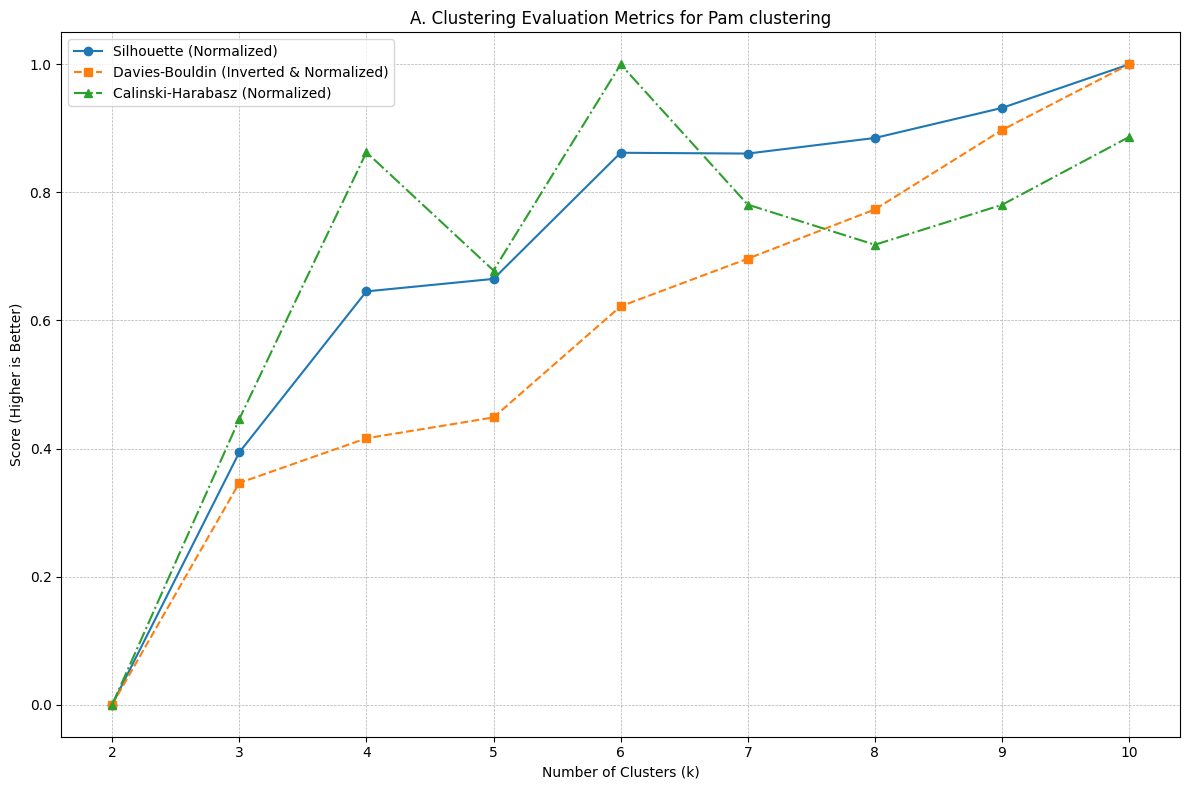


=== SUMMARY OF PAM RESULTS ===
Generated 9 PAM clustering results
  Best Silhouette: PAM k=10 (score: 0.3665)
  Best Davies-Bouldin: PAM k=10 (score: 1.2422)
  Best Calinski-Harabasz: PAM k=6 (score: 516.0414)

--- Definitive Medoid Mapping for Best Result (k=10) ---
  Cluster 0: Medoid Record ID = 1362E042A682D
  Cluster 1: Medoid Record ID = 13664C42A682D
  Cluster 2: Medoid Record ID = 134FDE42A682D
  Cluster 3: Medoid Record ID = 12B73742A682D
  Cluster 4: Medoid Record ID = 12AC1642A682D
  Cluster 5: Medoid Record ID = 137F8D42A682D
  Cluster 6: Medoid Record ID = 12826342A682D
  Cluster 7: Medoid Record ID = 10A53B42A682D
  Cluster 8: Medoid Record ID = 12A49742A682D
  Cluster 9: Medoid Record ID = 135F7042A682D

Cluster labels table contains 2463 records
Medical Record ID range: 101ECB42A682D to 140B4142A682D
Number of outliers flagged: 0

Medoids for best PAM result (k=10): ['10A53B42A682D', '12826342A682D', '12A49742A682D', '12AC1642A682D', '12B73742A682D', '134FDE42A682D', '

In [3]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler # Added for evaluation metric normalization during plotting
from sklearn_extra.cluster import KMedoids
from sklearn.utils import resample # Added for bootstrapping
from joblib import Parallel, delayed # Added for parallelization
# from sklearn.metrics import adjusted_rand_score # Added for ARI calculation

# =============================================================================
# CONFIGURATION SECTION
# =============================================================================

paper2_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\paper2_dir"  # Paper 2-specific files and code

DATABASE_PATH = os.path.join(paper2_directory, "pnk_db2_p2_cluster_pam_goldstd.sqlite")
# INPUT_DISTANCE_MATRIX = "hybrid_matrix_bl_nobc_vw_pam_goldstd"
# PERFORMANCE_TABLE = "clust_perf_scores_bl_nobc_vw_pam_goldstd"
# LABELS_TABLE = "clust_labels_bl_nobc_vw_pam_goldstd"

INPUT_DISTANCE_MATRIX = "hybrid_matrix_oc_nobc_vw_pam_goldstd"
PERFORMANCE_TABLE = "clust_perf_scores_oc_nobc_vw_pam_goldstd"
LABELS_TABLE = "clust_labels_oc_nobc_vw_pam_goldstd"

# Input name examples and code meanings: 
# pam_goldstd: K-medoids 'gold standard' approach, with PAM method, k-medoids++ initialization, 10 iterations over random init seeds
# "hybrid_matrix_bl_nobc_vw_pam_goldstd"
# "clust_perf_scores_bl_nobc_vw_pam_goldstd"
# "clust_labels_bl_nobc_vw_pam_goldstd"
# Experiment naming codes: 
# bl/oc: baseline or outcome variables included
# nobc/bc: age-sex-bmi only, or nobc+body composition (fat, vat)
# vw/bw: variable-wise or block-wise weighting during matrix hybdridization
#  - ie WGC weight in vw: (n WGC vars)/(n total vars), in bw: 0.5

K_RANGE = range(2, 11)  # k values from 2 to 10

N_JOBS = -1 # Use all available CPU cores for parallel processing

# Bootstrap evaluation parameters for assessing cluster stability - set to a positive number to use
N_BOOTSTRAP = 0 # Number of bootstrap resamples for ARI stability score calculation

# Outlier filtering to exclude extremely dissimilar patients from clustering
N_OUTLIERS = 0  # Set to 0 to disable outlier removal

# Plot parameters
FIGURE_SIZE = (12, 8)
DPI = 300

# =============================================================================
# FUNCTIONS
# =============================================================================

def load_longform_input_matrix(db_path, table_name):
    """
    Load long-format hybrid distance matrix from SQLite database.
    """
    print(f"Loading long-format distance matrix from '{table_name}'...")

    with sqlite3.connect(db_path) as conn:
        long_distance_matrix_df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    
    # Store avg_dist_to_all before pivoting - the average distance to other records is used for outlier detection and filtering
    avg_dist_df = long_distance_matrix_df[['medical_record_id_1', 'avg_dist_to_all']].drop_duplicates().set_index('medical_record_id_1')

    square_distance_matrix_df = long_distance_matrix_df.pivot(
        index='medical_record_id_1',
        columns='medical_record_id_2',
        values='distance'
    )

    # Ensure the matrix is perfectly square and ordered correctly
    all_ids = sorted(list(square_distance_matrix_df.index))
    square_distance_matrix_df = square_distance_matrix_df.reindex(index=all_ids, columns=all_ids)

    # Align avg_dist_df with the final sorted matrix
    avg_dist_df = avg_dist_df.reindex(all_ids)

    # Fill diagonal with 0s for self-distance
    np.fill_diagonal(square_distance_matrix_df.values, 0)

    record_ids = square_distance_matrix_df.index.tolist()
    square_distance_matrix = square_distance_matrix_df.values

    print(f"✓ Reconstructed long-format input distance matrix to square matrix of shape {square_distance_matrix.shape}")
    return square_distance_matrix, record_ids, avg_dist_df['avg_dist_to_all'].values

def detect_and_filter_outliers(square_distance_matrix, all_record_ids, avg_distances, n_outliers):
    """Detects outliers and returns the filtered matrix and corresponding IDs."""
    if n_outliers <= 0:
        print("No outlier filtering applied.")
        return square_distance_matrix, all_record_ids, [], []

    print(f"\n--- OUTLIER DETECTION ---")
    print(f"Detecting and removing top {n_outliers} outliers...")
    
    # Use the avg_distances array to find the indices of the outliers
    outlier_indices = np.argsort(avg_distances)[-n_outliers:]
    outlier_record_ids = [all_record_ids[i] for i in outlier_indices]
    
    # Create a boolean mask to select non-outliers
    keep_mask = np.ones(len(all_record_ids), dtype=bool)
    keep_mask[outlier_indices] = False
    
    # Get the record IDs of the patients we are keeping
    filtered_record_ids = [rid for i, rid in enumerate(all_record_ids) if keep_mask[i]]
    
    # Use the boolean mask to slice the matrix efficiently
    filtered_distance_matrix = square_distance_matrix[keep_mask][:, keep_mask]

    print(f"Identified {len(outlier_record_ids)} outliers. Retaining {len(filtered_record_ids)} patients.")
    print(f"Final clustering matrix shape: {filtered_distance_matrix.shape}")
    
    return filtered_distance_matrix, filtered_record_ids, outlier_record_ids, outlier_indices

def ensure_labels_table_exists(db_path, labels_table, all_record_ids):
    """
    Ensure the cluster labels table exists with ALL record IDs (including outliers).
    
    Parameters:
    -----------
    db_path : str
        Path to SQLite database
    labels_table : str
        Name of the cluster labels table
    all_record_ids : list
        List of ALL medical record IDs (including outliers)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with patient identifiers
    """
    with sqlite3.connect(db_path) as conn:
        try:
            # Try to load existing table
            labels_df = pd.read_sql_query(f"SELECT * FROM {labels_table}", conn)
            print(f"Loaded existing labels table with {len(labels_df)} records")
            
            # Verify that record IDs match
            existing_ids = labels_df['medical_record_id'].tolist()
            if set(existing_ids) != set(all_record_ids):
                print("Warning: Record IDs in labels table don't match full dataset")
                print("Updating labels table with ALL record IDs (including outliers)...")
                # Update with ALL IDs
                labels_df = pd.DataFrame({'medical_record_id': all_record_ids})
                labels_df['patient_id'] = range(len(all_record_ids))  # Sequential patient IDs
                labels_df.to_sql(labels_table, conn, if_exists='replace', index=False)
        
        except:
            # Create new table if it doesn't exist
            print(f"Creating new labels table with {len(all_record_ids)} records (including outliers)")
            labels_df = pd.DataFrame({'medical_record_id': all_record_ids})
            labels_df['patient_id'] = range(len(all_record_ids))  # Sequential patient IDs
            labels_df.to_sql(labels_table, conn, if_exists='replace', index=False)
    
    return labels_df

def perform_pam_clustering(distance_matrix, k, n_runs=10):
    """
    Performs robust PAM clustering and returns the best result along with 
    the random seed that generated it.
    """
    best_inertia = np.inf
    best_labels = None
    best_medoid_indices = None
    best_seed = -1  # Initialize with a placeholder

    print(f"  Running k={k} with {n_runs} initializations...")
    
    for i in range(n_runs):
        kmedoids = KMedoids(
            n_clusters=k,
            metric='precomputed',
            method='pam',
            init='k-medoids++',
            random_state=i,
            max_iter=300
        )
        kmedoids.fit(distance_matrix)
        
        if kmedoids.inertia_ < best_inertia:
            best_inertia = kmedoids.inertia_
            best_labels = kmedoids.labels_
            best_medoid_indices = kmedoids.medoid_indices_
            best_seed = i # Save the winning seed

    # Return the full set of information for the best run
    return best_labels, best_medoid_indices, best_inertia, best_seed

def calculate_clustering_metrics(distance_matrix, cluster_labels):
    """
    Calculate clustering evaluation metrics.
    
    Parameters:
    -----------
    distance_matrix : np.ndarray
        Distance matrix
    cluster_labels : np.ndarray
        Cluster labels
    
    Returns:
    --------
    tuple
        (silhouette_score, davies_bouldin_score, calinski_harabasz_score)
    """
    # For silhouette score, we need the distance matrix in the right format
    n_clusters = len(np.unique(cluster_labels))
    
    if n_clusters <= 1 or n_clusters >= len(cluster_labels):
        # Can't calculate metrics with only one cluster or n_samples clusters
        return np.nan, np.nan, np.nan
    
    try:
        # Silhouette score using precomputed distance matrix
        sil_score = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
        
        # For Davies-Bouldin and Calinski-Harabasz, we need the original data
        # Since we only have distances, we'll use MDS to reconstruct approximate coordinates
        from sklearn.manifold import MDS
        # Ensure n_components is less than n_samples
        n_components = min(10, len(distance_matrix) - 1)
        mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42, n_init=4)
        coords = mds.fit_transform(distance_matrix)
        
        db_score = davies_bouldin_score(coords, cluster_labels)
        ch_score = calinski_harabasz_score(coords, cluster_labels)
        
        return sil_score, db_score, ch_score
    
    except Exception as e:
        print(f"Warning: Could not calculate all metrics - {e}")
        return np.nan, np.nan, np.nan

def add_performance_scores(db_path, table_name, algorithm, k, hclust_linkage, silhouette, davies_bouldin, calinski_harabasz, inertia, seed):
    """Adds performance scores to the database, handling None for hclust_linkage."""
    new_row = pd.DataFrame({
        'algorithm': [algorithm], 'k': [k], 'hclust_linkage': [hclust_linkage],
        'silhouette': [silhouette], 'davies_bouldin': [davies_bouldin], 'calinski_harabasz': [calinski_harabasz], 
        'inertia': [inertia], # Add inertia
        'best_seed': [seed]     # Add the winning seed
    })
    
    with sqlite3.connect(db_path) as conn:
        try:
            existing_df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
            # Logic to handle both PAM (linkage is None) and HCA
            if hclust_linkage is None:
                mask = (existing_df['algorithm'] == algorithm) & (existing_df['k'] == k)
            else:
                mask = (existing_df['algorithm'] == algorithm) & (existing_df['k'] == k) & (existing_df['hclust_linkage'] == hclust_linkage)
            
            if mask.any():
                for col in new_row.columns: existing_df.loc[mask, col] = new_row[col].iloc[0]
                updated_df = existing_df
            else:
                updated_df = pd.concat([existing_df, new_row], ignore_index=True)
        except:
            updated_df = new_row
        
        updated_df.to_sql(table_name, conn, if_exists='replace', index=False)

def add_cluster_labels_column(db_path, table_name, column_name, labels, clustering_record_ids, all_record_ids, outlier_record_ids):
    """
    Add cluster labels column to the database, ensuring proper record ID alignment.
    
    Parameters:
    -----------
    db_path : str
        Path to SQLite database
    table_name : str
        Name of the cluster labels table
    column_name : str
        Name of the new column
    labels : array-like
        Cluster labels
    clustering_record_ids : list
        List of medical record IDs used in clustering
    all_record_ids : list
        List of all medical record IDs for verification
    outlier_record_ids : list
        List of medical record IDs identified as outliers
    """
    with sqlite3.connect(db_path) as conn:
        existing_df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        
        # Convert column to object type to handle mixed types
        existing_df[column_name] = pd.Series(dtype='object')
        
        # Create a mapping from clustering record_id to label
        label_mapping = dict(zip(clustering_record_ids, labels))
        
        # Apply labels to non-outliers, mark outliers with -1
        for idx, rid in enumerate(existing_df['medical_record_id']):
            if rid in label_mapping:
                existing_df.loc[idx, column_name] = int(label_mapping[rid])  # Ensure integer labels
            elif rid in outlier_record_ids:
                existing_df.loc[idx, column_name] = -1  # Mark outliers with -1
            else:
                # This shouldn't happen if data is consistent
                existing_df.loc[idx, column_name] = -999  # Error flag
        
        existing_df.to_sql(table_name, conn, if_exists='replace', index=False)

def add_medoid_info_column(db_path, table_name, column_name, medoid_indices, clustering_record_ids,
                          all_record_ids, outlier_record_ids):
    """
    Add medoid information column to the database with proper outlier handling.
    """
    with sqlite3.connect(db_path) as conn:
        existing_df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        
        # Convert column to object type to handle mixed types
        existing_df[column_name] = pd.Series(dtype='object')
        
        # Get the actual record IDs of medoids
        medoid_record_ids = [clustering_record_ids[i] for i in medoid_indices]
        
        # Mark medoids with 1, outliers with -1, others with 0
        for idx, rid in enumerate(existing_df['medical_record_id']):
            if rid in medoid_record_ids:
                existing_df.loc[idx, column_name] = 1
            elif rid in outlier_record_ids:
                existing_df.loc[idx, column_name] = -1
            else:
                existing_df.loc[idx, column_name] = 0
        
        existing_df.to_sql(table_name, conn, if_exists='replace', index=False)

# --- Plotting Evaluation Metrics ---
def plot_evaluation_metrics(performance_df, clustering_algorithm):
    """
    Plots normalized internal metrics and the non-normalized bootstrap ARI score.

    Parameters:
    -----------
    performance_df : pd.DataFrame
        DataFrame containing 'k', 'silhouette', 'davies_bouldin', 
        'calinski_harabasz', and optionally 'bootstrap_ari' columns.
    clustering_algorithm : str
        The clustering algorithm used, for the plot title.
    """

    df = performance_df.copy()
    
    # --- Internal metrics processing ---
    internal_metrics = [
        'silhouette', 
        'davies_bouldin', 
        'calinski_harabasz'
    ]
    df_internal = df.dropna(subset=internal_metrics)
    
    if not df_internal.empty:
        # Invert Davies-Bouldin score (lower is better -> higher is better)
        df_internal['inv_davies_bouldin'] = 1 / (df_internal['davies_bouldin'] + 1e-6)
        
        # Select scores for normalization
        scores_to_normalize = df_internal[['silhouette', 'inv_davies_bouldin', 'calinski_harabasz']]
        
        # Normalize scores using MinMaxScaler
        scaler = MinMaxScaler()
        normalized_scores = scaler.fit_transform(scores_to_normalize)
        
        # Create a new DataFrame with normalized scores
        normalized_df = pd.DataFrame(normalized_scores, columns=[
            'Silhouette (Normalized)', 
            'Davies-Bouldin (Inverted & Normalized)', 
            'Calinski-Harabasz (Normalized)'
        ], index=df_internal.index)
        normalized_df['k'] = df_internal['k']
    else:
        normalized_df = pd.DataFrame() # Empty df if no internal metrics

    # --- Plotting ---
    plt.figure(figsize=FIGURE_SIZE)
    
    # Plot normalized internal metrics if available
    if not normalized_df.empty:
        plt.plot(normalized_df['k'], normalized_df['Silhouette (Normalized)'], marker='o', linestyle='-', label='Silhouette (Normalized)')
        plt.plot(normalized_df['k'], normalized_df['Davies-Bouldin (Inverted & Normalized)'], marker='s', linestyle='--', label='Davies-Bouldin (Inverted & Normalized)')
        plt.plot(normalized_df['k'], normalized_df['Calinski-Harabasz (Normalized)'], marker='^', linestyle='-.', label='Calinski-Harabasz (Normalized)')

    # Plot Bootstrap ARI score if available (it's already 0-1 scaled)
    # if 'bootstrap_ari' in df.columns and df['bootstrap_ari'].notna().any():
    #     df_ari = df.dropna(subset=['bootstrap_ari'])
    #     plt.plot(df_ari['k'], df_ari['bootstrap_ari'], marker='D', linestyle=':', color='red', label='Bootstrap Stability (ARI)')

    # if normalized_df.empty and ('bootstrap_ari' not in df.columns or not df['bootstrap_ari'].notna().any()):
    #     print(f"No valid scores to plot for {clustering_algorithm} clustering.")
    #     plt.close()
    #     return

    plt.title(f'A. Clustering Evaluation Metrics for {clustering_algorithm.capitalize()} clustering')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Score (Higher is Better)')
    plt.xticks(ticks=df['k'].unique())
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# PARALLEL WORKER AND BOOTSTRAP FUNCTIONS

def process_pam_for_k(k, distance_matrix, clustering_ids):
    """Worker function to process a single k value for PAM. Runs in parallel."""
    print(f"--- Processing PAM for k={k} ---")
    try:
        if distance_matrix.shape[0] < k:
            print(f"  Skipping k={k}: Not enough data points.")
            return None
            
        # Unpack the four returned values from our robust function
        labels, medoid_indices, inertia, seed = perform_pam_clustering(distance_matrix, k, n_runs=10)
        
        # --- DIAGNOSTICS ---
        medoid_record_ids = [clustering_ids[i] for i in medoid_indices]
        medoid_labels = labels[medoid_indices]
        medoid_map = dict(zip(medoid_labels, medoid_record_ids))
        print(f"  Medoid-to-Cluster Map for k={k}: {medoid_map}")
        print(f"  Best run for k={k} found with seed={seed} (Inertia: {inertia:.2f})")
        # --- END DIAGNOSTICS ---
        
        sil, db, ch = calculate_clustering_metrics(distance_matrix, labels)
        
        return {
            'k': k, 'silhouette': sil, 'davies_bouldin': db, 
            'calinski_harabasz': ch, 'labels': labels, 'medoid_indices': medoid_indices,
            'medoid_map': medoid_map, 'inertia': inertia, 'seed': seed # Pass the seed info along
        }
    except Exception as e:
        print(f"FATAL ERROR processing PAM for k={k}: {e}")
        return None

def run_bootstrap_evaluation_pam(db_path, labels_table, performance_table, distance_matrix, k_range, n_bootstrap):
    """Performs bootstrap stability evaluation for PAM with robust error handling."""
    print(f"\n--- Running Bootstrap Stability Evaluation for PAM ({n_bootstrap} iterations) ---")
    with sqlite3.connect(db_path) as conn:
        labels_df = pd.read_sql_query(f"SELECT * FROM {labels_table}", conn)
        performance_df = pd.read_sql_query(f"SELECT * FROM {performance_table}", conn)

    if 'bootstrap_ari' not in performance_df.columns:
        performance_df['bootstrap_ari'] = np.nan

    n_samples = distance_matrix.shape[0]
    original_indices = np.arange(n_samples)

    for k in k_range:
        col_name = f"pam_k{k}"
        if col_name not in labels_df.columns: 
            print(f"Warning: Original PAM labels for k={k} not found. Skipping bootstrap.")
            continue
        original_labels = labels_df.loc[labels_df[col_name] != -1, col_name].values
        if len(original_labels) != n_samples: continue

        ari_scores = []
        for i in range(n_bootstrap):
            try:
                boot_indices = resample(original_indices, replace=True, n_samples=n_samples)
                boot_labels_original = original_labels[boot_indices]
                boot_distance_matrix = distance_matrix[np.ix_(boot_indices, boot_indices)]
                boot_labels_new, _ = perform_pam_clustering(boot_distance_matrix, k)
                ari = adjusted_rand_score(boot_labels_original, boot_labels_new)
                ari_scores.append(ari)
            except Exception as e:
                # Explicitly log the error instead of silently passing
                print(f"  Warning: Bootstrap iteration {i+1} for k={k} failed: {e}")
        
        if ari_scores:
            mean_ari = np.mean(ari_scores)
            print(f"  k={k}: Mean Adjusted Rand Index = {mean_ari:.4f} ({len(ari_scores)}/{n_bootstrap} successful iterations)")
            mask = (performance_df['algorithm'] == 'pam') & (performance_df['k'] == k)
            performance_df.loc[mask, 'bootstrap_ari'] = mean_ari

    with sqlite3.connect(db_path) as conn:
        performance_df.to_sql(performance_table, conn, if_exists='replace', index=False)
    print("✓ Bootstrap ARI scores saved to the performance table.")

# =============================================================================
# MAIN EXECUTION
# =============================================================================

def run_pam_clustering_pipeline():
    """Main function to run the complete, parallelized PAM pipeline."""
    print("=== PAM CLUSTERING PIPELINE (PARALLELIZED) ===")
    
    # Step 1: Load and Prepare Data
    full_distance_matrix, all_record_ids, avg_distances = load_longform_input_matrix(DATABASE_PATH, INPUT_DISTANCE_MATRIX)
    
    # Step 2: Outlier Filtering
    clustering_matrix, clustering_ids, outlier_ids, _ = detect_and_filter_outliers(
        full_distance_matrix, all_record_ids, avg_distances, N_OUTLIERS
    )
    
    # Step 3: Prepare Database Tables
    ensure_labels_table_exists(DATABASE_PATH, LABELS_TABLE, all_record_ids)
    
    # Step 4: Run Clustering in Parallel
    print(f"\nRunning PAM clustering in parallel for k in {list(K_RANGE)}...")
    parallel_results = Parallel(n_jobs=N_JOBS, prefer="threads", verbose=10)(
        delayed(process_pam_for_k)(k, clustering_matrix, clustering_ids) for k in K_RANGE
    )
    all_results = [r for r in parallel_results if r is not None]
        
    # Step 5: Save All Results Serially
    print("\nSaving results to database...")
    for result in all_results:
        k = result['k']
        # Add performance scores (pass None for hclust_linkage)        
        add_performance_scores(DATABASE_PATH, PERFORMANCE_TABLE, 'pam', k, None,
                       result['silhouette'], result['davies_bouldin'], result['calinski_harabasz'],
                       result['inertia'], result['seed']) # Pass inertia and seed
        
        # Add cluster labels
        labels_col_name = f"pam_k{k}"
        add_cluster_labels_column(DATABASE_PATH, LABELS_TABLE, labels_col_name, result['labels'],
                                  clustering_ids, all_record_ids, outlier_ids)
                                  
        # Add medoid info
        medoids_col_name = f"pam_medoid_k{k}"
        add_medoid_info_column(DATABASE_PATH, LABELS_TABLE, medoids_col_name, result['medoid_indices'],
                               clustering_ids, all_record_ids, outlier_ids)
                               
    # Step 6: Optional Bootstrap and Final Evaluation Plots
    # print("\nRunning bootstrap stability evaluations...")
    # if 'N_BOOTSTRAP' in globals() and N_BOOTSTRAP > 0:
    #     run_bootstrap_evaluation_pam(DATABASE_PATH, LABELS_TABLE, PERFORMANCE_TABLE, 
    #                                  clustering_matrix, K_RANGE, N_BOOTSTRAP)

    print("\n=== PAM CLUSTERING COMPLETE ===")


    print("\nGenerating final plots and summary...")
    with sqlite3.connect(DATABASE_PATH) as conn:
        # Load the FINAL version of the performance table, which now includes ARI scores
        final_perf_df = pd.read_sql_query(f"SELECT * FROM {PERFORMANCE_TABLE} WHERE algorithm='pam'", conn)
        labels_df = pd.read_sql_query(f"SELECT * FROM {LABELS_TABLE}", conn)

    if not final_perf_df.empty:
        plot_evaluation_metrics(final_perf_df, "PAM")
        
        print(f"\n=== SUMMARY OF PAM RESULTS ===")
        print(f"Generated {len(final_perf_df)} PAM clustering results")
        
        best_sil = final_perf_df.loc[final_perf_df['silhouette'].idxmax()]
        print(f"  Best Silhouette: PAM k={best_sil['k']} (score: {best_sil['silhouette']:.4f})")

        best_db = final_perf_df.loc[final_perf_df['davies_bouldin'].idxmin()]
        print(f"  Best Davies-Bouldin: PAM k={best_db['k']} (score: {best_db['davies_bouldin']:.4f})")

        best_ch = final_perf_df.loc[final_perf_df['calinski_harabasz'].idxmax()]
        print(f"  Best Calinski-Harabasz: PAM k={best_ch['k']} (score: {best_ch['calinski_harabasz']:.4f})")

        # ---CLUSTER LABEL TO MEDOID MAPPING ---
        best_k = best_sil['k']
        # Find the full result dictionary for the best k from our parallel run
        # Note: 'all_results' must be accessible here. If not, we need a small scope adjustment.
        best_result = next((r for r in all_results if r['k'] == best_k), None)
        
        if best_result:
            print(f"\n--- Definitive Medoid Mapping for Best Result (k={best_k}) ---")
            definitive_map = best_result['medoid_map']
            
            # Sort by cluster label for a clean, ordered printout
            for cluster_label in sorted(definitive_map.keys()):
                medoid_id = definitive_map[cluster_label]
                print(f"  Cluster {cluster_label}: Medoid Record ID = {medoid_id}")
            
        # Display record ID and outlier information
        labels_df = pd.read_sql_query(f"SELECT * FROM {LABELS_TABLE}", conn)
        print(f"\nCluster labels table contains {len(labels_df)} records")
        print(f"Medical Record ID range: {labels_df['medical_record_id'].min()} to {labels_df['medical_record_id'].max()}")
        
        # Count outliers in the results
        pam_columns = [col for col in labels_df.columns if col.startswith('pam_k')]
        if len(pam_columns) > 0:
            outlier_count = len(labels_df[labels_df[pam_columns[0]] == -1])
            print(f"Number of outliers flagged: {outlier_count}")
            if outlier_count > 0:
                outlier_ids = labels_df[labels_df[pam_columns[0]] == -1]['medical_record_id'].tolist()
                print(f"Outlier record IDs: {outlier_ids}")
        
        # Display medoid information for best silhouette result
        if len(final_perf_df) > 0:
            best_k = best_sil['k']
            medoid_col = f"pam_medoid_k{best_k}"
            if medoid_col in labels_df.columns:
                medoid_records = labels_df[labels_df[medoid_col] == 1]['medical_record_id'].tolist()
                print(f"\nMedoids for best PAM result (k={best_k}): {medoid_records}")

# Run the complete PAM clustering pipeline
if __name__ == '__main__':
    run_pam_clustering_pipeline()

###### Practical best performer with default settings: method = alternating, init = heuristic

=== PAM CLUSTERING PIPELINE (PARALLELIZED) ===
Loading long-format distance matrix from 'hybrid_matrix_bl_nobc_vw_pam_default'...
✓ Reconstructed long-format input distance matrix to square matrix of shape (2463, 2463)
No outlier filtering applied.
Loaded existing labels table with 2463 records

Running PAM clustering in parallel for k in [2, 3, 4, 5, 6, 7, 8, 9, 10]...
--- Processing PAM for k=9 ---
--- Processing PAM for k=4 ---
--- Processing PAM for k=6 ---
--- Processing PAM for k=8 ---
--- Processing PAM for k=3 ---
--- Processing PAM for k=7 ---
--- Processing PAM for k=5 ---
--- Processing PAM for k=2 ---


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


  Medoid-to-Cluster Map for k=3: {np.int64(0): '1297EF42A682D', np.int64(1): '12DAED42A682D', np.int64(2): '10921342A682D'}
  Medoid-to-Cluster Map for k=2: {np.int64(0): '1297EF42A682D', np.int64(1): '12DAED42A682D'}
  Medoid-to-Cluster Map for k=9: {np.int64(0): '1294CD42A682D', np.int64(1): '13849A42A682D', np.int64(2): '13413542A682D', np.int64(3): '132D1E42A682D', np.int64(4): '13580042A682D', np.int64(5): '10B56442A682D', np.int64(6): '13BF7F42A682D', np.int64(7): '1294C642A682D', np.int64(8): '13E73B42A682D'}
  Medoid-to-Cluster Map for k=7: {np.int64(0): '1294CD42A682D', np.int64(1): '13849A42A682D', np.int64(2): '13413542A682D', np.int64(3): '12C90442A682D', np.int64(4): '13774F42A682D', np.int64(5): '12BCB742A682D', np.int64(6): '12BBBC42A682D'}
  Medoid-to-Cluster Map for k=8: {np.int64(0): '1294CD42A682D', np.int64(1): '13849A42A682D', np.int64(2): '13413542A682D', np.int64(3): '12A70942A682D', np.int64(4): '13774F42A682D', np.int64(5): '13E48742A682D', np.int64(6): '133EF3

[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed: 26.0min remaining: 91.2min


  Medoid-to-Cluster Map for k=10: {np.int64(0): '13AFB342A682D', np.int64(1): '12B4AA42A682D', np.int64(2): '13413542A682D', np.int64(3): '13A07942A682D', np.int64(4): '13580042A682D', np.int64(5): '128FF942A682D', np.int64(6): '12BBBC42A682D', np.int64(7): '1294C642A682D', np.int64(8): '13C7C642A682D', np.int64(9): '1387A942A682D'}


[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed: 26.1min remaining: 52.1min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed: 26.1min remaining: 32.6min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed: 26.7min remaining: 21.4min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 26.7min remaining: 13.4min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 26.7min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 32.1min finished
C:\Users\Felhasználó\AppData\Local\Temp\ipykernel_652\63187210.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  updated_df = pd.concat([existing_df, new_row], ignore_index=True)



Saving results to database...

=== PAM CLUSTERING COMPLETE ===

Generating final plots and summary...


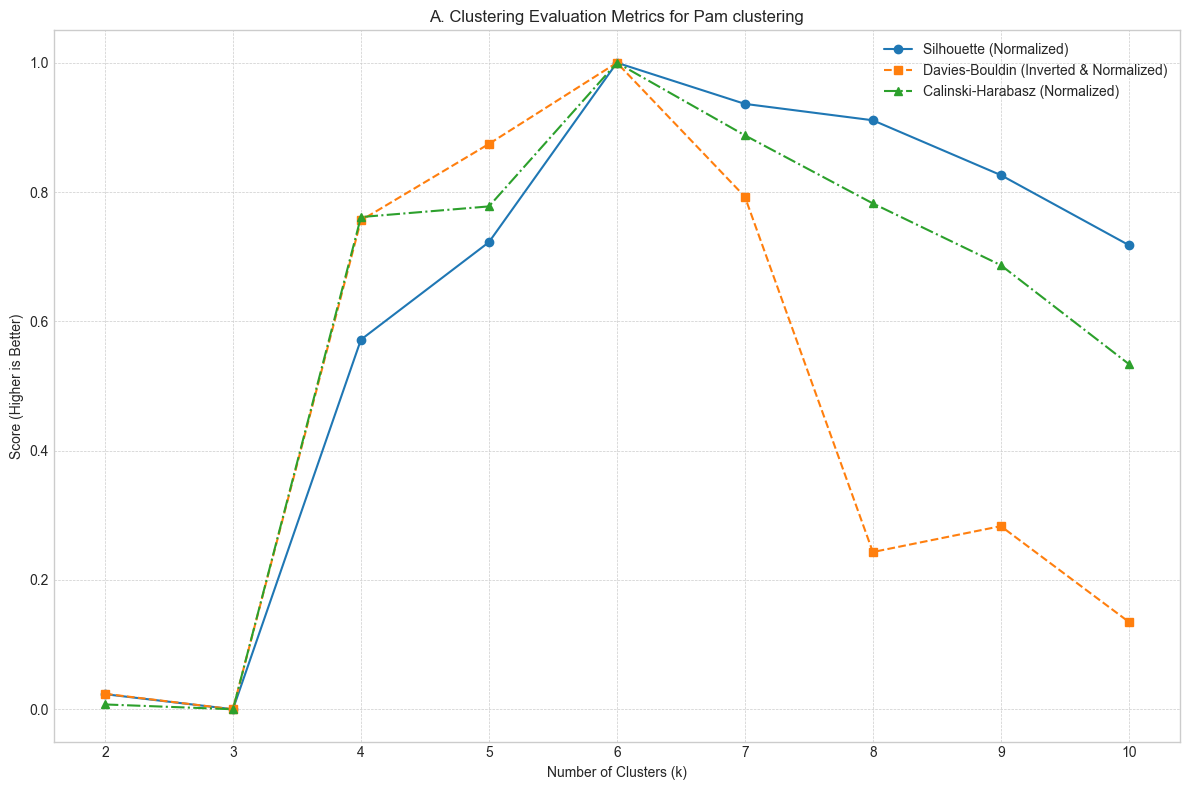


=== SUMMARY OF PAM RESULTS ===
Generated 9 PAM clustering results
  Best Silhouette: PAM k=6 (score: 0.1775)
  Best Davies-Bouldin: PAM k=6 (score: 1.9875)
  Best Calinski-Harabasz: PAM k=6 (score: 240.7740)

--- Definitive Medoid Mapping for Best Result (k=6) ---
  Cluster 0: Medoid Record ID = 1294CD42A682D
  Cluster 1: Medoid Record ID = 13367542A682D
  Cluster 2: Medoid Record ID = 13413542A682D
  Cluster 3: Medoid Record ID = 1162FC42A682D
  Cluster 4: Medoid Record ID = 13D0C142A682D
  Cluster 5: Medoid Record ID = 13846542A682D

Cluster labels table contains 2463 records
Medical Record ID range: 101ECB42A682D to 140B4142A682D
Number of outliers flagged: 0

Medoids for best PAM result (k=6): ['1162FC42A682D', '1294CD42A682D', '13367542A682D', '13413542A682D', '13846542A682D', '13D0C142A682D']


In [4]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler # Added for evaluation metric normalization during plotting
from sklearn_extra.cluster import KMedoids
from sklearn.utils import resample # Added for bootstrapping
from joblib import Parallel, delayed # Added for parallelization
# from sklearn.metrics import adjusted_rand_score # Added for ARI calculation

# =============================================================================
# CONFIGURATION SECTION
# =============================================================================

paper2_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\paper2_dir"  # Paper 2-specific files and code

# DATABASE_PATH = os.path.join(paper2_directory, "pnk_db2_p2_cluster_pam_default.sqlite")
# INPUT_DISTANCE_MATRIX = "hybrid_matrix_bl_nobc_bw_pam_default"
# PERFORMANCE_TABLE = "clust_perf_scores_bl_nobc_bw_pam_default"
# LABELS_TABLE = "clust_labels_bl_nobc_bw_pam_default"
DATABASE_PATH = os.path.join(paper2_directory, "pnk_db2_p2_cluster_pam_default.sqlite")
INPUT_DISTANCE_MATRIX = "hybrid_matrix_bl_nobc_vw_pam_default"
PERFORMANCE_TABLE = "clust_perf_scores_bl_nobc_vw_pam_default"
LABELS_TABLE = "clust_labels_bl_nobc_vw_pam_default"

# Input name examples and code meanings: 
# "hybrid_matrix_bl_nobc_bw"
# "clust_perf_scores_bl_nobc_bw"
# "clust_labels_bl_nobc_bw"
# Experiment naming codes: 
# bl/oc: baseline or outcome variables included
# nobc/bc: age-sex-bmi only, or nobc+body composition (fat, vat)
# vw/bw: variable-wise or block-wise weighting during matrix hybdridization
#  - ie WGC weight in vw: (n WGC vars)/(n total vars), in bw: 0.5

K_RANGE = range(2, 11)  # k values from 2 to 10

N_JOBS = -1 # Use all available CPU cores for parallel processing

# Bootstrap evaluation parameters for assessing cluster stability - set to a positive number to use
N_BOOTSTRAP = 0 # Number of bootstrap resamples for ARI stability score calculation

# Outlier filtering to exclude extremely dissimilar patients from clustering
N_OUTLIERS = 0  # Set to 0 to disable outlier removal

# Plot parameters
FIGURE_SIZE = (12, 8)
DPI = 300

# =============================================================================
# FUNCTIONS
# =============================================================================

def load_longform_input_matrix(db_path, table_name):
    """
    Load long-format hybrid distance matrix from SQLite database.
    """
    print(f"Loading long-format distance matrix from '{table_name}'...")

    with sqlite3.connect(db_path) as conn:
        long_distance_matrix_df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    
    # Store avg_dist_to_all before pivoting - the average distance to other records is used for outlier detection and filtering
    avg_dist_df = long_distance_matrix_df[['medical_record_id_1', 'avg_dist_to_all']].drop_duplicates().set_index('medical_record_id_1')

    square_distance_matrix_df = long_distance_matrix_df.pivot(
        index='medical_record_id_1',
        columns='medical_record_id_2',
        values='distance'
    )

    # Ensure the matrix is perfectly square and ordered correctly
    all_ids = sorted(list(square_distance_matrix_df.index))
    square_distance_matrix_df = square_distance_matrix_df.reindex(index=all_ids, columns=all_ids)

    # Align avg_dist_df with the final sorted matrix
    avg_dist_df = avg_dist_df.reindex(all_ids)

    # Fill diagonal with 0s for self-distance
    np.fill_diagonal(square_distance_matrix_df.values, 0)

    record_ids = square_distance_matrix_df.index.tolist()
    square_distance_matrix = square_distance_matrix_df.values

    print(f"✓ Reconstructed long-format input distance matrix to square matrix of shape {square_distance_matrix.shape}")
    return square_distance_matrix, record_ids, avg_dist_df['avg_dist_to_all'].values

def detect_and_filter_outliers(square_distance_matrix, all_record_ids, avg_distances, n_outliers):
    """Detects outliers and returns the filtered matrix and corresponding IDs."""
    if n_outliers <= 0:
        print("No outlier filtering applied.")
        return square_distance_matrix, all_record_ids, [], []

    print(f"\n--- OUTLIER DETECTION ---")
    print(f"Detecting and removing top {n_outliers} outliers...")
    
    # Use the avg_distances array to find the indices of the outliers
    outlier_indices = np.argsort(avg_distances)[-n_outliers:]
    outlier_record_ids = [all_record_ids[i] for i in outlier_indices]
    
    # Create a boolean mask to select non-outliers
    keep_mask = np.ones(len(all_record_ids), dtype=bool)
    keep_mask[outlier_indices] = False
    
    # Get the record IDs of the patients we are keeping
    filtered_record_ids = [rid for i, rid in enumerate(all_record_ids) if keep_mask[i]]
    
    # Use the boolean mask to slice the matrix efficiently
    filtered_distance_matrix = square_distance_matrix[keep_mask][:, keep_mask]

    print(f"Identified {len(outlier_record_ids)} outliers. Retaining {len(filtered_record_ids)} patients.")
    print(f"Final clustering matrix shape: {filtered_distance_matrix.shape}")
    
    return filtered_distance_matrix, filtered_record_ids, outlier_record_ids, outlier_indices

def ensure_labels_table_exists(db_path, labels_table, all_record_ids):
    """
    Ensure the cluster labels table exists with ALL record IDs (including outliers).
    
    Parameters:
    -----------
    db_path : str
        Path to SQLite database
    labels_table : str
        Name of the cluster labels table
    all_record_ids : list
        List of ALL medical record IDs (including outliers)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with patient identifiers
    """
    with sqlite3.connect(db_path) as conn:
        try:
            # Try to load existing table
            labels_df = pd.read_sql_query(f"SELECT * FROM {labels_table}", conn)
            print(f"Loaded existing labels table with {len(labels_df)} records")
            
            # Verify that record IDs match
            existing_ids = labels_df['medical_record_id'].tolist()
            if set(existing_ids) != set(all_record_ids):
                print("Warning: Record IDs in labels table don't match full dataset")
                print("Updating labels table with ALL record IDs (including outliers)...")
                # Update with ALL IDs
                labels_df = pd.DataFrame({'medical_record_id': all_record_ids})
                labels_df['patient_id'] = range(len(all_record_ids))  # Sequential patient IDs
                labels_df.to_sql(labels_table, conn, if_exists='replace', index=False)
        
        except:
            # Create new table if it doesn't exist
            print(f"Creating new labels table with {len(all_record_ids)} records (including outliers)")
            labels_df = pd.DataFrame({'medical_record_id': all_record_ids})
            labels_df['patient_id'] = range(len(all_record_ids))  # Sequential patient IDs
            labels_df.to_sql(labels_table, conn, if_exists='replace', index=False)
    
    return labels_df

def perform_pam_clustering(distance_matrix, k):
    """
    Perform PAM (Partitioning Around Medoids) clustering.
    
    Parameters:
    -----------
    distance_matrix : np.ndarray
        Symmetric distance matrix (Gower dissimilarity matrix)
    k : int
        Number of clusters
    
    Returns:
    --------
    tuple
        (cluster_labels, medoid_indices) where:
        - cluster_labels is np.ndarray of cluster assignments (0-indexed)
        - medoid_indices is np.ndarray of medoid indices
    """
    # Use KMedoids with precomputed distance matrix, setting init='k-medoids++' to select separated initial medoids
    kmedoids = KMedoids(n_clusters=k, metric='precomputed', method='alternate', init='heuristic', random_state=42, max_iter=300)
    cluster_labels = kmedoids.fit_predict(distance_matrix)
    medoid_indices = kmedoids.medoid_indices_
    
    return cluster_labels, medoid_indices

def calculate_clustering_metrics(distance_matrix, cluster_labels):
    """
    Calculate clustering evaluation metrics.
    
    Parameters:
    -----------
    distance_matrix : np.ndarray
        Distance matrix
    cluster_labels : np.ndarray
        Cluster labels
    
    Returns:
    --------
    tuple
        (silhouette_score, davies_bouldin_score, calinski_harabasz_score)
    """
    # For silhouette score, we need the distance matrix in the right format
    n_clusters = len(np.unique(cluster_labels))
    
    if n_clusters <= 1 or n_clusters >= len(cluster_labels):
        # Can't calculate metrics with only one cluster or n_samples clusters
        return np.nan, np.nan, np.nan
    
    try:
        # Silhouette score using precomputed distance matrix
        sil_score = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
        
        # For Davies-Bouldin and Calinski-Harabasz, we need the original data
        # Since we only have distances, we'll use MDS to reconstruct approximate coordinates
        from sklearn.manifold import MDS
        # Ensure n_components is less than n_samples
        n_components = min(10, len(distance_matrix) - 1)
        mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42, n_init=4)
        coords = mds.fit_transform(distance_matrix)
        
        db_score = davies_bouldin_score(coords, cluster_labels)
        ch_score = calinski_harabasz_score(coords, cluster_labels)
        
        return sil_score, db_score, ch_score
    
    except Exception as e:
        print(f"Warning: Could not calculate all metrics - {e}")
        return np.nan, np.nan, np.nan

def add_performance_scores(db_path, table_name, algorithm, k, hclust_linkage, silhouette, davies_bouldin, calinski_harabasz):
    """Adds performance scores to the database, handling None for hclust_linkage."""
    new_row = pd.DataFrame({
        'algorithm': [algorithm], 'k': [k], 'hclust_linkage': [hclust_linkage],
        'silhouette': [silhouette], 'davies_bouldin': [davies_bouldin], 'calinski_harabasz': [calinski_harabasz]
    })
    
    with sqlite3.connect(db_path) as conn:
        try:
            existing_df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
            # Logic to handle both PAM (linkage is None) and HCA
            if hclust_linkage is None:
                mask = (existing_df['algorithm'] == algorithm) & (existing_df['k'] == k)
            else:
                mask = (existing_df['algorithm'] == algorithm) & (existing_df['k'] == k) & (existing_df['hclust_linkage'] == hclust_linkage)
            
            if mask.any():
                for col in new_row.columns: existing_df.loc[mask, col] = new_row[col].iloc[0]
                updated_df = existing_df
            else:
                updated_df = pd.concat([existing_df, new_row], ignore_index=True)
        except:
            updated_df = new_row
        
        updated_df.to_sql(table_name, conn, if_exists='replace', index=False)

def add_cluster_labels_column(db_path, table_name, column_name, labels, clustering_record_ids, all_record_ids, outlier_record_ids):
    """
    Add cluster labels column to the database, ensuring proper record ID alignment.
    
    Parameters:
    -----------
    db_path : str
        Path to SQLite database
    table_name : str
        Name of the cluster labels table
    column_name : str
        Name of the new column
    labels : array-like
        Cluster labels
    clustering_record_ids : list
        List of medical record IDs used in clustering
    all_record_ids : list
        List of all medical record IDs for verification
    outlier_record_ids : list
        List of medical record IDs identified as outliers
    """
    with sqlite3.connect(db_path) as conn:
        existing_df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        
        # Convert column to object type to handle mixed types
        existing_df[column_name] = pd.Series(dtype='object')
        
        # Create a mapping from clustering record_id to label
        label_mapping = dict(zip(clustering_record_ids, labels))
        
        # Apply labels to non-outliers, mark outliers with -1
        for idx, rid in enumerate(existing_df['medical_record_id']):
            if rid in label_mapping:
                existing_df.loc[idx, column_name] = int(label_mapping[rid])  # Ensure integer labels
            elif rid in outlier_record_ids:
                existing_df.loc[idx, column_name] = -1  # Mark outliers with -1
            else:
                # This shouldn't happen if data is consistent
                existing_df.loc[idx, column_name] = -999  # Error flag
        
        existing_df.to_sql(table_name, conn, if_exists='replace', index=False)

def add_medoid_info_column(db_path, table_name, column_name, medoid_indices, clustering_record_ids,
                          all_record_ids, outlier_record_ids):
    """
    Add medoid information column to the database with proper outlier handling.
    """
    with sqlite3.connect(db_path) as conn:
        existing_df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        
        # Convert column to object type to handle mixed types
        existing_df[column_name] = pd.Series(dtype='object')
        
        # Get the actual record IDs of medoids
        medoid_record_ids = [clustering_record_ids[i] for i in medoid_indices]
        
        # Mark medoids with 1, outliers with -1, others with 0
        for idx, rid in enumerate(existing_df['medical_record_id']):
            if rid in medoid_record_ids:
                existing_df.loc[idx, column_name] = 1
            elif rid in outlier_record_ids:
                existing_df.loc[idx, column_name] = -1
            else:
                existing_df.loc[idx, column_name] = 0
        
        existing_df.to_sql(table_name, conn, if_exists='replace', index=False)

# --- Plotting Evaluation Metrics ---
def plot_evaluation_metrics(performance_df, clustering_algorithm):
    """
    Plots normalized internal metrics and the non-normalized bootstrap ARI score.

    Parameters:
    -----------
    performance_df : pd.DataFrame
        DataFrame containing 'k', 'silhouette', 'davies_bouldin', 
        'calinski_harabasz', and optionally 'bootstrap_ari' columns.
    clustering_algorithm : str
        The clustering algorithm used, for the plot title.
    """

    df = performance_df.copy()
    
    # --- Internal metrics processing ---
    internal_metrics = [
        'silhouette', 
        'davies_bouldin', 
        'calinski_harabasz'
    ]
    df_internal = df.dropna(subset=internal_metrics)
    
    if not df_internal.empty:
        # Invert Davies-Bouldin score (lower is better -> higher is better)
        df_internal['inv_davies_bouldin'] = 1 / (df_internal['davies_bouldin'] + 1e-6)
        
        # Select scores for normalization
        scores_to_normalize = df_internal[['silhouette', 'inv_davies_bouldin', 'calinski_harabasz']]
        
        # Normalize scores using MinMaxScaler
        scaler = MinMaxScaler()
        normalized_scores = scaler.fit_transform(scores_to_normalize)
        
        # Create a new DataFrame with normalized scores
        normalized_df = pd.DataFrame(normalized_scores, columns=[
            'Silhouette (Normalized)', 
            'Davies-Bouldin (Inverted & Normalized)', 
            'Calinski-Harabasz (Normalized)'
        ], index=df_internal.index)
        normalized_df['k'] = df_internal['k']
    else:
        normalized_df = pd.DataFrame() # Empty df if no internal metrics

    # --- Plotting ---
    plt.figure(figsize=FIGURE_SIZE)
    
    # Plot normalized internal metrics if available
    if not normalized_df.empty:
        plt.plot(normalized_df['k'], normalized_df['Silhouette (Normalized)'], marker='o', linestyle='-', label='Silhouette (Normalized)')
        plt.plot(normalized_df['k'], normalized_df['Davies-Bouldin (Inverted & Normalized)'], marker='s', linestyle='--', label='Davies-Bouldin (Inverted & Normalized)')
        plt.plot(normalized_df['k'], normalized_df['Calinski-Harabasz (Normalized)'], marker='^', linestyle='-.', label='Calinski-Harabasz (Normalized)')

    # Plot Bootstrap ARI score if available (it's already 0-1 scaled)
    # if 'bootstrap_ari' in df.columns and df['bootstrap_ari'].notna().any():
    #     df_ari = df.dropna(subset=['bootstrap_ari'])
    #     plt.plot(df_ari['k'], df_ari['bootstrap_ari'], marker='D', linestyle=':', color='red', label='Bootstrap Stability (ARI)')

    # if normalized_df.empty and ('bootstrap_ari' not in df.columns or not df['bootstrap_ari'].notna().any()):
    #     print(f"No valid scores to plot for {clustering_algorithm} clustering.")
    #     plt.close()
    #     return

    plt.title(f'A. Clustering Evaluation Metrics for {clustering_algorithm.capitalize()} clustering')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Score (Higher is Better)')
    plt.xticks(ticks=df['k'].unique())
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


# PARALLEL WORKER AND BOOTSTRAP FUNCTIONS

def process_pam_for_k(k, distance_matrix, clustering_ids):
    """Worker function to process a single k value for PAM. Runs in parallel."""
    print(f"--- Processing PAM for k={k} ---")
    try:
        if distance_matrix.shape[0] < k:
            print(f"  Skipping k={k}: Not enough data points.")
            return None
            
        labels, medoid_indices = perform_pam_clustering(distance_matrix, k)
        
        # --- DIAGNOSTIC MAPPING: SEE WHICH CLUSTER LABELS EACH INITIAL MEDOID GETS ---
        # Get the actual record IDs of the medoids
        medoid_record_ids = [clustering_ids[i] for i in medoid_indices]
        # Get the cluster label for each of those medoids
        medoid_labels = labels[medoid_indices]
        # Create a dictionary for easy printing
        medoid_map = dict(zip(medoid_labels, medoid_record_ids))
        print(f"  Medoid-to-Cluster Map for k={k}: {medoid_map}")
        # --- END DIAGNOSTIC ---
        
        sil, db, ch = calculate_clustering_metrics(distance_matrix, labels)
        
        # Add the medoid_map to the returned dictionary
        return {
            'k': k, 'silhouette': sil, 'davies_bouldin': db, 
            'calinski_harabasz': ch, 'labels': labels, 'medoid_indices': medoid_indices,
            'medoid_map': medoid_map # Return the map for later use
        }
    except Exception as e:
        print(f"FATAL ERROR processing PAM for k={k}: {e}")
        return None


def run_bootstrap_evaluation_pam(db_path, labels_table, performance_table, distance_matrix, k_range, n_bootstrap):
    """Performs bootstrap stability evaluation for PAM with robust error handling."""
    print(f"\n--- Running Bootstrap Stability Evaluation for PAM ({n_bootstrap} iterations) ---")
    with sqlite3.connect(db_path) as conn:
        labels_df = pd.read_sql_query(f"SELECT * FROM {labels_table}", conn)
        performance_df = pd.read_sql_query(f"SELECT * FROM {performance_table}", conn)

    if 'bootstrap_ari' not in performance_df.columns:
        performance_df['bootstrap_ari'] = np.nan

    n_samples = distance_matrix.shape[0]
    original_indices = np.arange(n_samples)

    for k in k_range:
        col_name = f"pam_k{k}"
        if col_name not in labels_df.columns: 
            print(f"Warning: Original PAM labels for k={k} not found. Skipping bootstrap.")
            continue
        original_labels = labels_df.loc[labels_df[col_name] != -1, col_name].values
        if len(original_labels) != n_samples: continue

        ari_scores = []
        for i in range(n_bootstrap):
            try:
                boot_indices = resample(original_indices, replace=True, n_samples=n_samples)
                boot_labels_original = original_labels[boot_indices]
                boot_distance_matrix = distance_matrix[np.ix_(boot_indices, boot_indices)]
                boot_labels_new, _ = perform_pam_clustering(boot_distance_matrix, k)
                ari = adjusted_rand_score(boot_labels_original, boot_labels_new)
                ari_scores.append(ari)
            except Exception as e:
                # Explicitly log the error instead of silently passing
                print(f"  Warning: Bootstrap iteration {i+1} for k={k} failed: {e}")
        
        if ari_scores:
            mean_ari = np.mean(ari_scores)
            print(f"  k={k}: Mean Adjusted Rand Index = {mean_ari:.4f} ({len(ari_scores)}/{n_bootstrap} successful iterations)")
            mask = (performance_df['algorithm'] == 'pam') & (performance_df['k'] == k)
            performance_df.loc[mask, 'bootstrap_ari'] = mean_ari

    with sqlite3.connect(db_path) as conn:
        performance_df.to_sql(performance_table, conn, if_exists='replace', index=False)
    print("✓ Bootstrap ARI scores saved to the performance table.")

# =============================================================================
# MAIN EXECUTION
# =============================================================================

def run_pam_clustering_pipeline():
    """Main function to run the complete, parallelized PAM pipeline."""
    print("=== PAM CLUSTERING PIPELINE (PARALLELIZED) ===")
    
    # Step 1: Load and Prepare Data
    full_distance_matrix, all_record_ids, avg_distances = load_longform_input_matrix(DATABASE_PATH, INPUT_DISTANCE_MATRIX)
    
    # Step 2: Outlier Filtering
    clustering_matrix, clustering_ids, outlier_ids, _ = detect_and_filter_outliers(
        full_distance_matrix, all_record_ids, avg_distances, N_OUTLIERS
    )
    
    # Step 3: Prepare Database Tables
    ensure_labels_table_exists(DATABASE_PATH, LABELS_TABLE, all_record_ids)
    
    # Step 4: Run Clustering in Parallel
    print(f"\nRunning PAM clustering in parallel for k in {list(K_RANGE)}...")
    parallel_results = Parallel(n_jobs=N_JOBS, prefer="threads", verbose=10)(
        delayed(process_pam_for_k)(k, clustering_matrix, clustering_ids) for k in K_RANGE
    )
    all_results = [r for r in parallel_results if r is not None]
        
    # Step 5: Save All Results Serially
    print("\nSaving results to database...")
    for result in all_results:
        k = result['k']
        # Add performance scores (pass None for hclust_linkage)
        add_performance_scores(DATABASE_PATH, PERFORMANCE_TABLE, 'pam', k, None,
                               result['silhouette'], result['davies_bouldin'], result['calinski_harabasz'])
        
        # Add cluster labels
        labels_col_name = f"pam_k{k}"
        add_cluster_labels_column(DATABASE_PATH, LABELS_TABLE, labels_col_name, result['labels'],
                                  clustering_ids, all_record_ids, outlier_ids)
                                  
        # Add medoid info
        medoids_col_name = f"pam_medoid_k{k}"
        add_medoid_info_column(DATABASE_PATH, LABELS_TABLE, medoids_col_name, result['medoid_indices'],
                               clustering_ids, all_record_ids, outlier_ids)
                               
    # Step 6: Optional Bootstrap and Final Evaluation Plots
    # print("\nRunning bootstrap stability evaluations...")
    # if 'N_BOOTSTRAP' in globals() and N_BOOTSTRAP > 0:
    #     run_bootstrap_evaluation_pam(DATABASE_PATH, LABELS_TABLE, PERFORMANCE_TABLE, 
    #                                  clustering_matrix, K_RANGE, N_BOOTSTRAP)

    print("\n=== PAM CLUSTERING COMPLETE ===")


    print("\nGenerating final plots and summary...")
    with sqlite3.connect(DATABASE_PATH) as conn:
        # Load the FINAL version of the performance table, which now includes ARI scores
        final_perf_df = pd.read_sql_query(f"SELECT * FROM {PERFORMANCE_TABLE} WHERE algorithm='pam'", conn)
        labels_df = pd.read_sql_query(f"SELECT * FROM {LABELS_TABLE}", conn)

    if not final_perf_df.empty:
        plot_evaluation_metrics(final_perf_df, "PAM")
        
        print(f"\n=== SUMMARY OF PAM RESULTS ===")
        print(f"Generated {len(final_perf_df)} PAM clustering results")
        
        best_sil = final_perf_df.loc[final_perf_df['silhouette'].idxmax()]
        print(f"  Best Silhouette: PAM k={best_sil['k']} (score: {best_sil['silhouette']:.4f})")

        best_db = final_perf_df.loc[final_perf_df['davies_bouldin'].idxmin()]
        print(f"  Best Davies-Bouldin: PAM k={best_db['k']} (score: {best_db['davies_bouldin']:.4f})")

        best_ch = final_perf_df.loc[final_perf_df['calinski_harabasz'].idxmax()]
        print(f"  Best Calinski-Harabasz: PAM k={best_ch['k']} (score: {best_ch['calinski_harabasz']:.4f})")

        # ---CLUSTER LABEL TO MEDOID MAPPING ---
        best_k = best_sil['k']
        # Find the full result dictionary for the best k from our parallel run
        # Note: 'all_results' must be accessible here. If not, we need a small scope adjustment.
        best_result = next((r for r in all_results if r['k'] == best_k), None)
        
        if best_result:
            print(f"\n--- Definitive Medoid Mapping for Best Result (k={best_k}) ---")
            definitive_map = best_result['medoid_map']
            
            # Sort by cluster label for a clean, ordered printout
            for cluster_label in sorted(definitive_map.keys()):
                medoid_id = definitive_map[cluster_label]
                print(f"  Cluster {cluster_label}: Medoid Record ID = {medoid_id}")
            
        # Display record ID and outlier information
        labels_df = pd.read_sql_query(f"SELECT * FROM {LABELS_TABLE}", conn)
        print(f"\nCluster labels table contains {len(labels_df)} records")
        print(f"Medical Record ID range: {labels_df['medical_record_id'].min()} to {labels_df['medical_record_id'].max()}")
        
        # Count outliers in the results
        pam_columns = [col for col in labels_df.columns if col.startswith('pam_k')]
        if len(pam_columns) > 0:
            outlier_count = len(labels_df[labels_df[pam_columns[0]] == -1])
            print(f"Number of outliers flagged: {outlier_count}")
            if outlier_count > 0:
                outlier_ids = labels_df[labels_df[pam_columns[0]] == -1]['medical_record_id'].tolist()
                print(f"Outlier record IDs: {outlier_ids}")
        
        # Display medoid information for best silhouette result
        if len(final_perf_df) > 0:
            best_k = best_sil['k']
            medoid_col = f"pam_medoid_k{best_k}"
            if medoid_col in labels_df.columns:
                medoid_records = labels_df[labels_df[medoid_col] == 1]['medical_record_id'].tolist()
                print(f"\nMedoids for best PAM result (k={best_k}): {medoid_records}")

# Run the complete PAM clustering pipeline
if __name__ == '__main__':
    run_pam_clustering_pipeline()

##### Potentially, algorithms with a different input structure - K-prototypes

#### Cluster comparisons

new

=== CLUSTER COMPARISON PIPELINE ===
Configuration: {'algorithm': 'pam', 'k': 7, 'include_outliers': False}
Looking for cluster column: pam_k7

Loading cluster data (labels from LABELS_DB_PATH, clinical from SOURCE_DB_PATH)...
Loaded data for 7 clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Total patients in valid clusters: 2463
  Cluster 0: 271 patients (11.0%)
  Cluster 1: 500 patients (20.3%)
  Cluster 2: 279 patients (11.3%)
  Cluster 3: 302 patients (12.3%)
  Cluster 4: 279 patients (11.3%)
  Cluster 5: 389 patients (15.8%)
  Cluster 6: 443 patients (18.0%)

Comparing 25 variables across 7 groups...

=== CLUSTER COMPARISON RESULTS ===
                                  Variable     Cluster_0     Cluster_1     Cluster_2     Cluster_3     Cluster_4     Cluster_5     Cluster_6  p-value      Test_Used
                           N (sample size)           271           500           279           302           279           389       

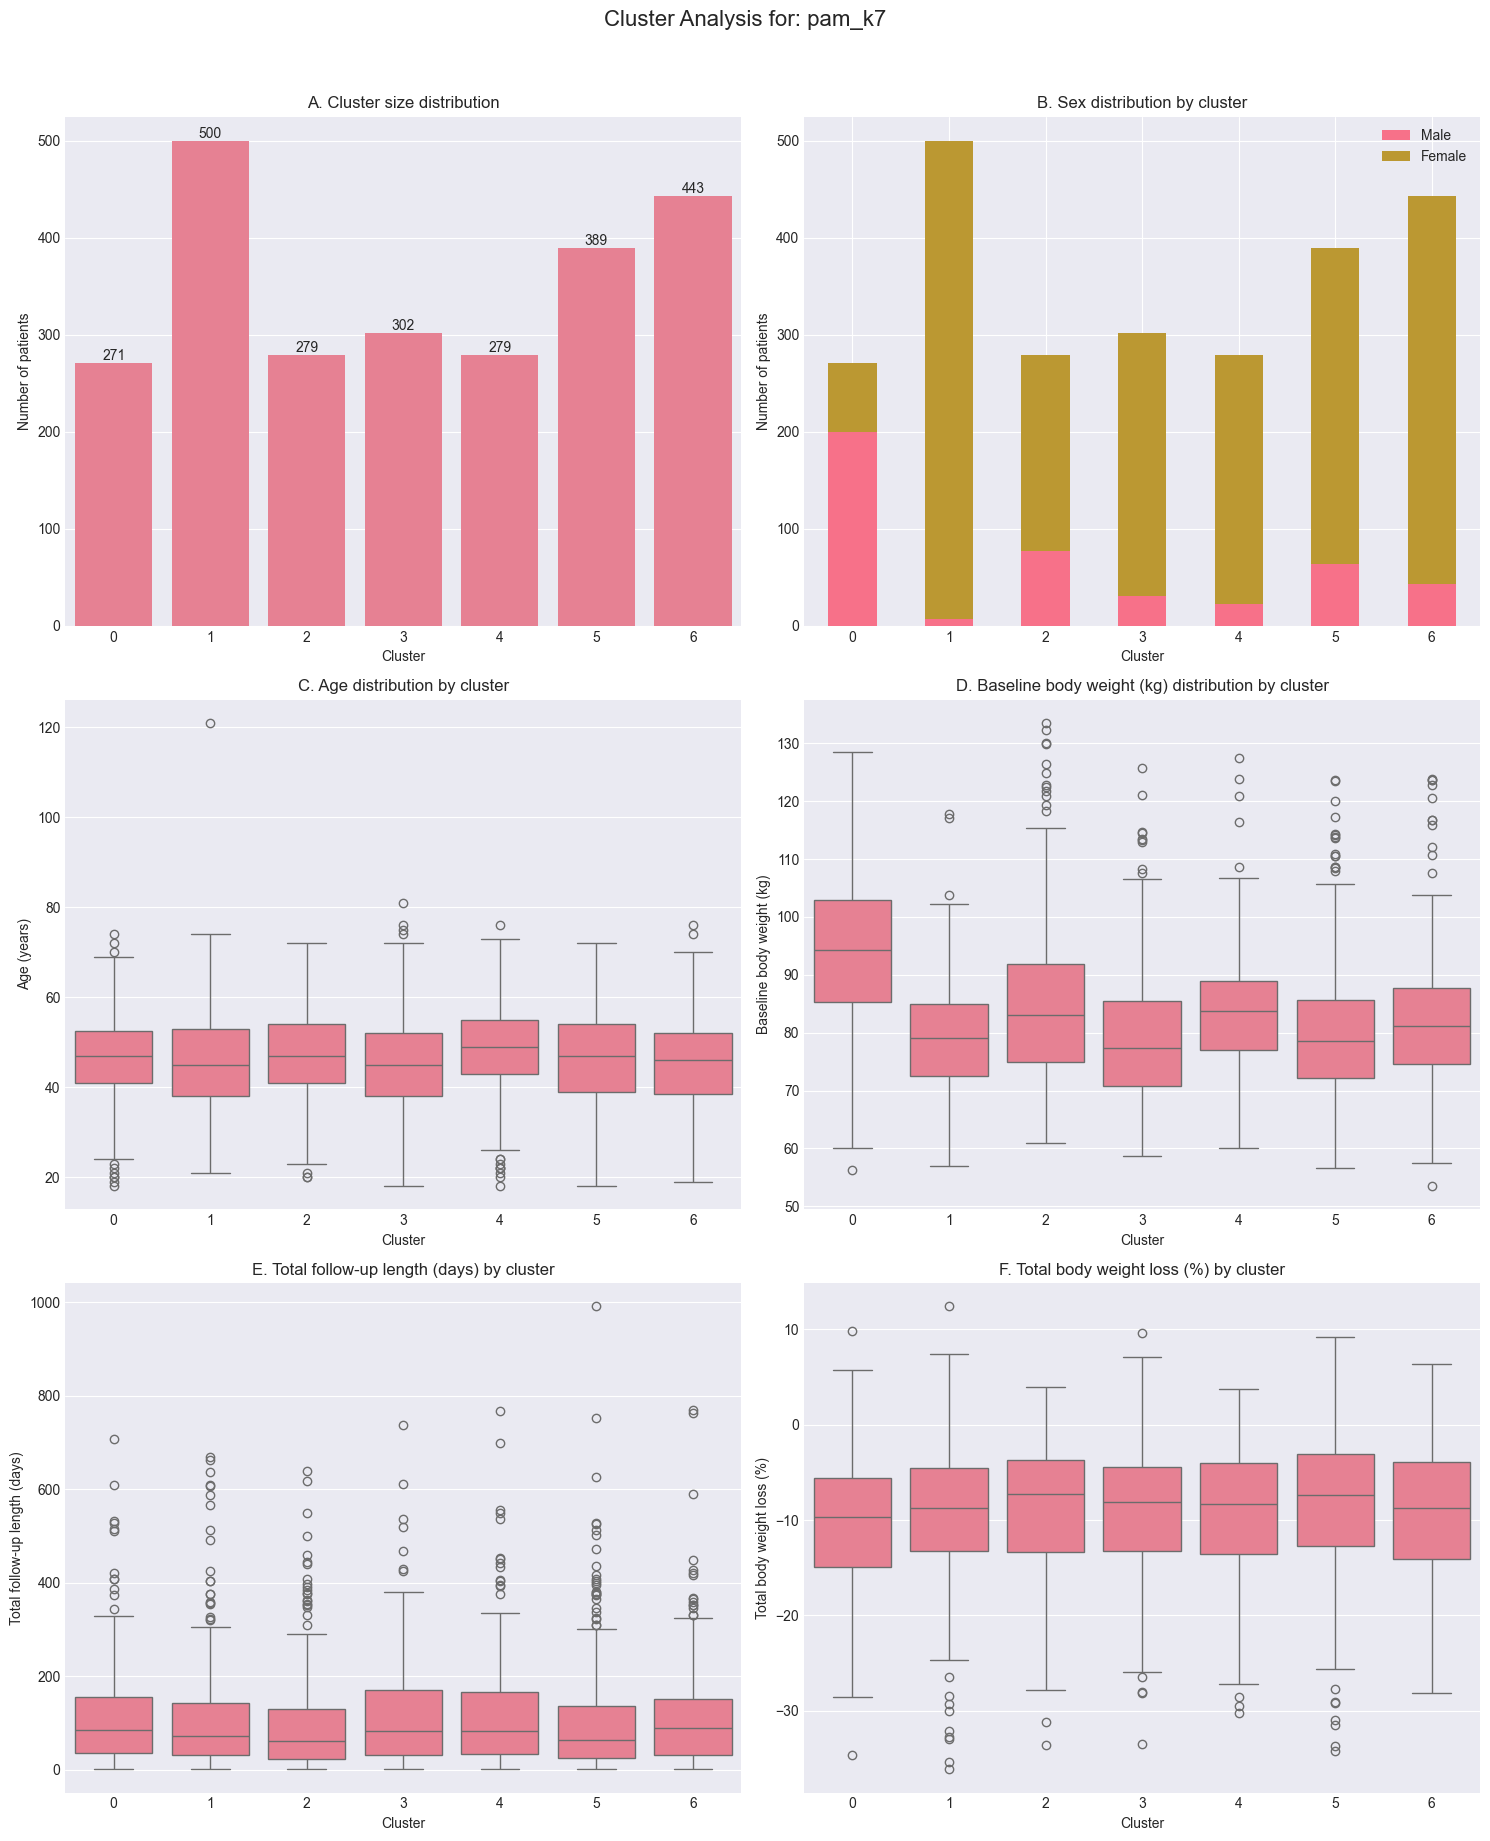


=== SIGNIFICANT DIFFERENCES (p < 0.05) ===
Found 25 variables with significant differences:
  Women's health & pregnancy (y/n): p = 1.00E-04 (fisher_exact)
  Mental health (y/n): p = 1.00E-04 (fisher_exact)
  Family issues (y/n): p = 1.00E-04 (fisher_exact)
  Medication, disease, or injury (y/n): p = 1.00E-04 (fisher_exact)
  Physical inactivity (y/n): p = 1.00E-04 (fisher_exact)
  Eating habits (y/n): p = 1.00E-04 (fisher_exact)
  Schedule (y/n): p = 1.00E-04 (fisher_exact)
  Smoking cessation (y/n): p = 1.00E-04 (fisher_exact)
  Treatment discontinuation or relapse (y/n): p = 1.00E-04 (fisher_exact)
  Pandemic (y/n): p = 1.00E-04 (fisher_exact)
  Lifestyle, circumstances (y/n): p = 1.00E-04 (fisher_exact)
  None of the above (y/n): p = 1.00E-04 (fisher_exact)
  Sex (female): p = 1.00E-04 (fisher_exact)
  Age (years): p = 6.37E-06 (kruskal_wallis)
  Baseline BMI (kg/m²): p = 1.26E-23 (kruskal_wallis)
  Baseline weight (kg): p = 1.02E-57 (kruskal_wallis)
  Final BMI (kg/m²): p = 7.55E

In [23]:
import os
import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import kruskal, fisher_exact
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURATION SECTION
# =============================================================================

# Define the paper2_directory path (modify this to your actual path)
paper2_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\paper2_dir"  # Paper 2-specific files and code

# Input databases and tables
SOURCE_DB_PATH = os.path.join(paper2_directory, "pnk_db2_p2_in.sqlite")                  # Clinical/source data DB
SOURCE_DATA_TABLE = "timetoevent_wgc_compl"                                              # Clinical/source data table

LABELS_DB_PATH = os.path.join(paper2_directory, "pnk_db2_p2_cluster_pam_goldstd.sqlite") # Cluster labels DB (experiment-specific)
LABELS_TABLE = "clust_labels_bl_nobc_bw_pam_goldstd"                                     # Cluster labels table (experiment-specific)
# LABELS_TABLE = "clust_labels_jaccard_wgc_pam_goldstd"                                     # Cluster labels table (experiment-specific)

# Output database and table
OUTPUT_DATABASE_PATH = os.path.join(paper2_directory, "pnk_db2_p2_out.sqlite")           # Output DB for comparison results
OUTPUT_TABLE = "bl_nobc_bw_pam_goldstd_k7"                                                             # Manual table name for results

# =============================================================================
# CLUSTER SELECTION CONFIGURATION
# =============================================================================

# Configure the clustering setup you want to analyze
CLUSTERING_CONFIG = {
    'algorithm': 'pam',           # 'hclust', 'pam', 'kmeans', etc.
    'k': 7,                          # number of clusters
    # 'linkage': 'ward',               # for hclust: 'ward', 'complete', 'average', 'single'
    'include_outliers': False        # whether to include outliers as separate group
}

# Variables to compare across clusters
COMPARISON_VARIABLES = [
    "womens_health_and_pregnancy",
    "mental_health",
    "family_issues",
    "medication_disease_injury",
    "physical_inactivity",
    "eating_habits",
    "schedule",
    "smoking_cessation",
    "treatment_discontinuation_or_relapse",
    "pandemic",
    "lifestyle_circumstances",
    "none_of_above",
    # Demographics & baseline anthropometry
    "sex_f", "age",
    "baseline_bmi",
    "baseline_weight_kg",
    # Weight loss outcomes
    "final_bmi",
    "total_wl_%",
    "bmi_reduction",
    # Dynamic time windows (if available)
    "60d_dropout",
    "60d_wl_%",
    "60d_bmi_reduction",
    # Targets (if available)
    "10%_wl_achieved", "days_to_10%_wl",
    # Follow-up
    "total_followup_days",
]

# Human-readable variable names
VARIABLE_NAME_MAP = {
    "N (sample size)": "N (sample size)",
    "womens_health_and_pregnancy": "Women's health & pregnancy (y/n)",
    "mental_health": "Mental health (y/n)",
    "family_issues": "Family issues (y/n)",
    "medication_disease_injury": "Medication, disease, or injury (y/n)",
    "physical_inactivity": "Physical inactivity (y/n)",
    "eating_habits": "Eating habits (y/n)",
    "schedule": "Schedule (y/n)",
    "smoking_cessation": "Smoking cessation (y/n)",
    "treatment_discontinuation_or_relapse": "Treatment discontinuation or relapse (y/n)",
    "pandemic": "Pandemic (y/n)",
    "lifestyle_circumstances": "Lifestyle, circumstances (y/n)",
    "none_of_above": "None of the above (y/n)",
    "sex_f": "Sex (female)",
    "age": "Age (years)",
    "baseline_weight_kg": "Baseline weight (kg)",
    "baseline_bmi": "Baseline BMI (kg/m²)",
    "final_bmi": "Final BMI (kg/m²)",
    "total_wl_%": "Total Weight Loss (%)",
    "bmi_reduction": "BMI reduction (kg/m²)",
    "60d_dropout": "Dropout at 60 days (yes/no)",
    "60d_wl_%": "Weight loss at 60 days (%)",
    "60d_bmi_reduction": "BMI Reduction at 60 days (kg/m²)",
    "10%_wl_achieved": "Achieved 10% weight loss (yes/no)",
    "days_to_10%_wl": "Days to 10% weight loss",
    "total_followup_days": "Total follow-up (days)",
}

# =============================================================================
# HELPER FUNCTIONS FOR STATISTICAL FORMATTING
# =============================================================================

def format_mean_sd(series, decimals=2):
    """Format mean ± SD for continuous variables."""
    if series.isna().all():
        return "N/A"
    mean_val = series.mean()
    sd_val = series.std()
    return f"{mean_val:.{decimals}f}±{sd_val:.{decimals}f}"

def format_n_perc(series):
    """Format n (%) for categorical variables."""
    if series.isna().all():
        return "N/A"
    total = series.notna().sum()
    positive = series.sum() if series.dtype in ['bool', 'int64'] else (series == 1).sum()
    if total == 0:
        return "0 (0.0%)"
    percentage = (positive / total) * 100
    return f"{int(positive)} ({percentage:.1f}%)"

def format_pval(p_value, threshold=0.001):
    """Format p-values with appropriate precision, showing exact values."""
    if pd.isna(p_value):
        return "N/A"
    if p_value < threshold:
        return f"{p_value:.2E}"
    else:
        return f"{p_value:.3f}"

# =============================================================================
# STATISTICAL TEST FUNCTIONS
# =============================================================================

def perform_continuous_test(groups_data, variable):
    """Kruskal-Wallis test for continuous variables."""
    valid_groups = [group[variable].dropna() for group in groups_data if not group[variable].isna().all()]
    if len(valid_groups) < 2:
        return np.nan, "insufficient_data"
    group_sizes = [len(group) for group in valid_groups]
    if min(group_sizes) == 0:
        return np.nan, "empty_groups"
    try:
        _, p_value = kruskal(*valid_groups)
        return p_value, "kruskal_wallis"
    except Exception:
        return np.nan, "error"

def perform_categorical_test(groups_data, variable):
    """Fisher's Exact Test for categorical variables."""
    try:
        contingency_data = []
        for group in groups_data:
            group_data = group[variable].dropna()
            if len(group_data) == 0:
                contingency_data.append([0, 0])
            else:
                positive = group_data.sum() if group_data.dtype in ['bool', 'int64'] else (group_data == 1).sum()
                negative = len(group_data) - positive
                contingency_data.append([positive, negative])
        contingency_table = np.array(contingency_data)
        if np.any(contingency_table.sum(axis=0) == 0):
            return 1.0, "no_variation"
        _, p_value = fisher_exact(contingency_table)
        return p_value, "fisher_exact"
    except ValueError:
        return np.nan, "test_failed"
    except Exception:
        return np.nan, "error"

# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def construct_cluster_column_name(config):
    """Construct the column name for the specified clustering configuration."""
    algorithm = config['algorithm'].lower()
    k = config['k']
    if algorithm == 'hclust':
        linkage = config.get('linkage', 'ward')
        return f"hclust_{linkage}_k{k}"
    elif algorithm == 'pam':
        return f"pam_k{k}"
    elif algorithm == 'kmeans':
        return f"kmeans_k{k}"
    else:
        raise ValueError(f"Unsupported algorithm: {algorithm}")

def determine_variable_type(variable, df):
    """Determine if a variable is continuous or categorical."""
    if variable not in df.columns:
        return "missing"
    categorical_indicators = ["_yn", "_achieved", "_dropout", "sex_f", "instant_dropout"]
    if any(indicator in variable for indicator in categorical_indicators):
        return "categorical"
    continuous_likert = ["emotional_eating_value_likert", "quantity_control_likert", "impulse_control_likert"]
    if variable in continuous_likert:
        return "continuous"
    series = df[variable].dropna()
    if len(series) == 0:
        return "missing"
    if series.dtype == 'bool' or set(series.unique()).issubset({0, 1, True, False}):
        return "categorical"
    unique_ratio = len(series.unique()) / len(series)
    if unique_ratio < 0.05 and len(series.unique()) <= 10:
        return "categorical"
    return "continuous"

# =============================================================================
# DATA LOADING FUNCTIONS
# =============================================================================

def _list_tables(conn):
    cur = conn.cursor()
    cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
    return [row[0] for row in cur.fetchall()]

def load_cluster_data(labels_db_path, labels_table, source_db_path, source_table, cluster_column, include_outliers=True):
    """
    Load cluster labels (from labels DB) and source/clinical data (from source DB), then merge by medical_record_id.
    """
    if not os.path.exists(labels_db_path):
        raise FileNotFoundError(f"Labels DB not found: {labels_db_path}")
    if not os.path.exists(source_db_path):
        raise FileNotFoundError(f"Source DB not found: {source_db_path}")

    # Load labels from labels DB
    with sqlite3.connect(labels_db_path) as conn_lab:
        lab_tables = _list_tables(conn_lab)
        if labels_table not in lab_tables:
            raise ValueError(f"Table '{labels_table}' not in labels DB; available: {lab_tables}")
        labels_df = pd.read_sql_query(f"SELECT * FROM {labels_table}", conn_lab)

    # Load source data from source DB
    with sqlite3.connect(source_db_path) as conn_src:
        src_tables = _list_tables(conn_src)
        if source_table not in src_tables:
            raise ValueError(f"Table '{source_table}' not in source DB; available: {src_tables}")
        source_df = pd.read_sql_query(f"SELECT * FROM {source_table}", conn_src)

    # Check cluster column presence
    if cluster_column not in labels_df.columns:
        available_columns = [c for c in labels_df.columns if any(alg in c for alg in ['hclust', 'pam', 'kmeans'])]
        raise ValueError(f"Cluster column '{cluster_column}' not found in labels table; candidates: {available_columns}")

    # Merge on medical_record_id
    merged_df = source_df.merge(labels_df, on='medical_record_id', how='inner')

    # Split out outliers (if any requested)
    outliers_df = merged_df[merged_df[cluster_column] == -1].copy() if include_outliers else pd.DataFrame()
    valid_clusters_df = merged_df[merged_df[cluster_column] != -1].copy()

    unique_clusters = sorted([x for x in merged_df[cluster_column].unique() if x != -1])
    if len(unique_clusters) == 0:
        raise ValueError("No valid cluster labels found")

    print(f"Loaded data for {len(unique_clusters)} clusters: {unique_clusters}")
    if include_outliers and len(outliers_df) > 0:
        print(f"Outliers (excluded from clustering): {len(outliers_df)} patients")
    print(f"Total patients in valid clusters: {len(valid_clusters_df)}")

    cluster_sizes = valid_clusters_df[cluster_column].value_counts().sort_index()
    for cluster, size in cluster_sizes.items():
        print(f"  Cluster {cluster}: {size} patients ({size/len(valid_clusters_df)*100:.1f}%)")

    return merged_df, unique_clusters, cluster_column, outliers_df

# =============================================================================
# ANALYSIS FUNCTIONS
# =============================================================================

def compare_clusters(df, clusters, cluster_column, outliers_df, variables, name_map):
    """Perform statistical comparisons across clusters."""
    results = []

    # Build group containers
    cluster_groups = []
    group_names = []

    # Add regular clusters
    for cluster in clusters:
        cluster_data = df[df[cluster_column] == cluster]
        cluster_groups.append(cluster_data)
        group_names.append(f"Cluster_{cluster}")

    # Add outliers if provided
    if len(outliers_df) > 0:
        cluster_groups.append(outliers_df)
        group_names.append("Outliers")

    # Sample sizes row
    size_row = {"Variable": "N (sample size)"}
    for i, group_name in enumerate(group_names):
        size_row[group_name] = f"{len(cluster_groups[i])}"
    size_row["p-value"] = "N/A"
    size_row["Test_Used"] = "N/A"
    results.append(size_row)

    # Variable-wise stats and tests
    for variable in variables:
        if variable not in df.columns:
            row = {"Variable": variable}
            for group_name in group_names:
                row[group_name] = "N/A"
            row["p-value"] = "N/A"
            row["Test_Used"] = "missing_variable"
            results.append(row)
            continue

        var_type = determine_variable_type(variable, df)
        row = {"Variable": variable}

        # Descriptives
        for i, group_name in enumerate(group_names):
            group_data = cluster_groups[i]
            if var_type == "continuous":
                row[group_name] = format_mean_sd(group_data[variable])
            elif var_type == "categorical":
                row[group_name] = format_n_perc(group_data[variable])
            else:
                row[group_name] = "N/A"

        # Inference
        if var_type == "continuous":
            p_value, test_used = perform_continuous_test(cluster_groups, variable)
        elif var_type == "categorical":
            p_value, test_used = perform_categorical_test(cluster_groups, variable)
        else:
            p_value, test_used = np.nan, "unsupported_type"

        row["p-value"] = format_pval(p_value)
        row["Test_Used"] = test_used
        results.append(row)

    # Assemble results
    column_order = ["Variable"] + group_names + ["p-value", "Test_Used"]
    results_df = pd.DataFrame(results, columns=column_order)
    results_df['Variable'] = results_df['Variable'].apply(lambda v: name_map.get(v, v))
    return results_df

def save_comparisons_to_db(df, db_path, table_name):
    """Save a DataFrame to SQLite using pandas to_sql."""
    try:
        # Ensure parent directory exists; sqlite3.connect will create the DB file if the directory exists
        os.makedirs(os.path.dirname(db_path), exist_ok=True)
        print(f"\nSaving results to table '{table_name}' in database '{db_path}'...")
        with sqlite3.connect(db_path) as conn:
            df.to_sql(name=table_name, con=conn, if_exists='replace', index=False)
        print("Save successful.")
    except Exception as e:
        print(f"Error saving results to the database: {e}")

# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def create_cluster_visualization(df, cluster_column, clusters, outliers_df):
    """Create visualizations to understand cluster characteristics."""
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    axes = axes.flatten()

    viz_df = df.copy()
    if not outliers_df.empty:
        viz_df = pd.concat([df[df[cluster_column] != -1], outliers_df])
        viz_df.loc[viz_df[cluster_column] == -1, cluster_column] = 'Outliers'

    unique_labels = viz_df[cluster_column].unique()
    numeric_clusters = sorted([c for c in unique_labels if c != 'Outliers'])
    ordered_labels = numeric_clusters
    if 'Outliers' in unique_labels:
        ordered_labels.append('Outliers')

    # A. Cluster size distribution
    ax = axes[0]
    cluster_counts = viz_df[cluster_column].value_counts().reindex(ordered_labels)
    sns.barplot(x=cluster_counts.index.astype(str), y=cluster_counts.values, ax=ax, order=[str(l) for l in ordered_labels])
    ax.set_title('A. Cluster size distribution')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Number of patients')
    for i, count in enumerate(cluster_counts):
        if pd.notna(count):
            ax.text(i, count, str(int(count)), ha='center', va='bottom')

    # B. Sex distribution by cluster
    ax = axes[1]
    if 'sex_f' in viz_df.columns:
        sex_crosstab = pd.crosstab(viz_df[cluster_column], viz_df['sex_f']).reindex(ordered_labels)
        sex_crosstab.plot(kind='bar', stacked=True, ax=ax, rot=0)
        ax.set_title('B. Sex distribution by cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Number of patients')
        ax.legend(['Male', 'Female'])
    else:
        ax.text(0.5, 0.5, 'Sex data not available', transform=ax.transAxes, ha='center')

    # C. Age distribution by cluster
    ax = axes[2]
    if 'age' in viz_df.columns:
        sns.boxplot(data=viz_df, x=cluster_column, y='age', ax=ax, order=ordered_labels)
        ax.set_title('C. Age distribution by cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Age (years)')
    else:
        ax.text(0.5, 0.5, 'Age data not available', transform=ax.transAxes, ha='center')

    # D. Baseline weight distribution by cluster
    ax = axes[3]
    if 'baseline_weight_kg' in viz_df.columns:
        sns.boxplot(data=viz_df, x=cluster_column, y='baseline_weight_kg', ax=ax, order=ordered_labels)
        ax.set_title('D. Baseline body weight (kg) distribution by cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Baseline body weight (kg)')
    else:
        ax.text(0.5, 0.5, 'Baseline body weight data not available', transform=ax.transAxes, ha='center')

    # E. Total follow-up days by cluster
    ax = axes[4]
    if 'total_followup_days' in viz_df.columns:
        sns.boxplot(data=viz_df, x=cluster_column, y='total_followup_days', ax=ax, order=ordered_labels)
        ax.set_title('E. Total follow-up length (days) by cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Total follow-up length (days)')
    else:
        ax.text(0.5, 0.5, 'Follow-up data not available', transform=ax.transAxes, ha='center')

    # F. Total weight loss (%) by cluster
    ax = axes[5]
    if 'total_wl_%' in viz_df.columns:
        sns.boxplot(data=viz_df, x=cluster_column, y='total_wl_%', ax=ax, order=ordered_labels)
        ax.set_title('F. Total body weight loss (%) by cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Total body weight loss (%)')
    else:
        ax.text(0.5, 0.5, 'Weight loss % data not available', transform=ax.transAxes, ha='center')

    fig.suptitle(f'Cluster Analysis for: {cluster_column}', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

# =============================================================================
# MAIN PIPELINE FUNCTION
# =============================================================================

def run_cluster_comparison_pipeline():
    """Main function to run the cluster comparison pipeline."""
    print("=== CLUSTER COMPARISON PIPELINE ===")
    print(f"Configuration: {CLUSTERING_CONFIG}")

    try:
        # Step 1: Construct cluster column name
        cluster_column = construct_cluster_column_name(CLUSTERING_CONFIG)
        print(f"Looking for cluster column: {cluster_column}")

        # Step 2: Load cluster data from two DBs
        print("\nLoading cluster data (labels from LABELS_DB_PATH, clinical from SOURCE_DB_PATH)...")
        df, clusters, cluster_col, outliers_df = load_cluster_data(
            LABELS_DB_PATH, LABELS_TABLE, SOURCE_DB_PATH, SOURCE_DATA_TABLE,
            cluster_column, CLUSTERING_CONFIG['include_outliers']
        )

        # Step 3: Perform statistical comparisons
        total_groups = len(clusters) + (1 if len(outliers_df) > 0 else 0)
        print(f"\nComparing {len(COMPARISON_VARIABLES)} variables across {total_groups} groups...")
        comparison_results = compare_clusters(df, clusters, cluster_col, outliers_df, COMPARISON_VARIABLES, VARIABLE_NAME_MAP)

        # Step 4: Display and save results
        print("\n=== CLUSTER COMPARISON RESULTS ===")
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_colwidth', 100)
        print(comparison_results.to_string(index=False))

        # Save to manually specified output table
        save_comparisons_to_db(comparison_results, OUTPUT_DATABASE_PATH, OUTPUT_TABLE)

        # Step 5: Create visualizations
        print("\nCreating cluster visualizations...")
        create_cluster_visualization(df, cluster_col, clusters, outliers_df)

        # Step 6: Summary of significant differences
        print("\n=== SIGNIFICANT DIFFERENCES (p < 0.05) ===")
        significant_results = comparison_results[
            (comparison_results['p-value'] != 'N/A') &
            (comparison_results['Variable'] != 'N (sample size)')
        ].copy()

        def extract_pvalue(p_str):
            """Converts formatted p-value string back to float."""
            if p_str == 'N/A':
                return 1.0
            try:
                return float(p_str)
            except ValueError:
                return 1.0

        significant_results['p_numeric'] = significant_results['p-value'].apply(extract_pvalue)
        significant_vars = significant_results[significant_results['p_numeric'] < 0.05]

        if len(significant_vars) > 0:
            print(f"Found {len(significant_vars)} variables with significant differences:")
            for _, row in significant_vars.iterrows():
                print(f"  {row['Variable']}: p = {row['p-value']} ({row['Test_Used']})")
        else:
            print("No variables showed significant differences between groups.")

        return comparison_results, df

    except Exception as e:
        print(f"Error in pipeline execution: {e}")
        print("\nPlease check:")
        print("1. Both database file paths are correct (labels vs. source)")
        print("2. Tables exist in their respective databases")
        print("3. Cluster column name matches available columns in the labels table")
        return None, None

# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    # Configure display options
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 100)

    # Run the cluster comparison pipeline
    results_df, cluster_data = run_cluster_comparison_pipeline()


### Paper 2 - cluster-based analyses

#### Comparative table, heatmap and lollipop plot

Loading cluster data...
  ✓ Loaded 2463 cluster assignments
  ✓ Loaded 2463 outcome records
  ✓ Merged: 2463 records with clusters
  ✓ Clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
  ✓ Population for comparisons: entire clustered dataset (n=2463)

STATISTICAL ANALYSIS: Cluster vs Clustered Population Mean
Note: Each cluster compared to entire clustered population
  ⚠️ No variable types provided, inferring from data...
    womens_health_and_pregnancy: categorical
    mental_health: categorical
    family_issues: categorical
    medication_disease_injury: categorical
    physical_inactivity: categorical
    eating_habits: categorical
    schedule: categorical
    smoking_cessation: categorical
    treatment_discontinuation_or_relapse: categorical
    pandemic: categorical
    lifestyle_circumstances: categorical
    none_of_above: categorical
    sex_f: categorical
    age: continuous
    baseline_bmi: continuous
    baseline_weight

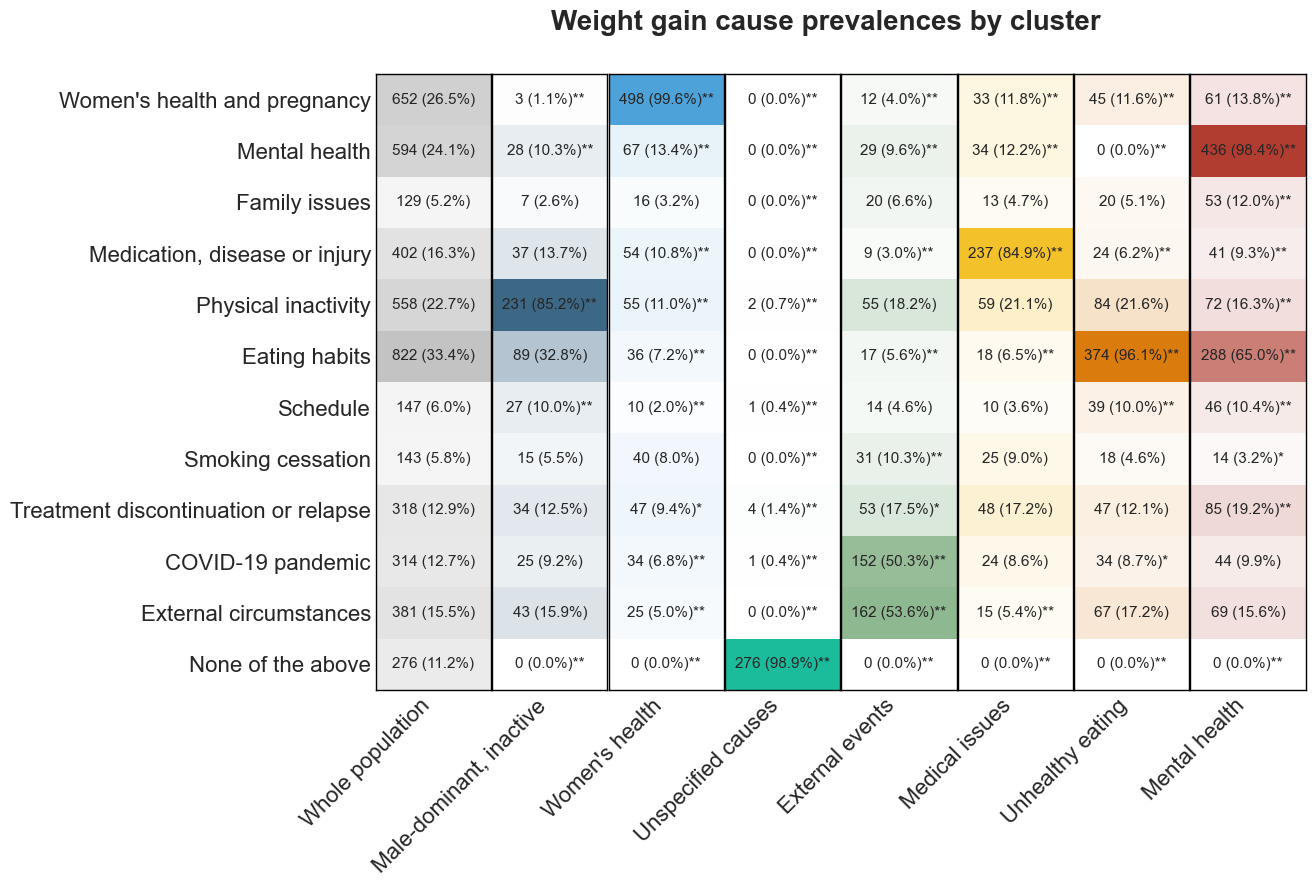

  ✓ Heatmap saved: ../outputs/cluster_bl_nobc_bw_pam_goldst_k7\wgc_prev_heatmap.png

Generating lollipop plot...
  Extracting p-values from results_df...
  ⚠️ Warning: Variable 'total_weight_loss_kg' not found in results_df
✓ Extracted p-values for 9 variables across 7 clusters


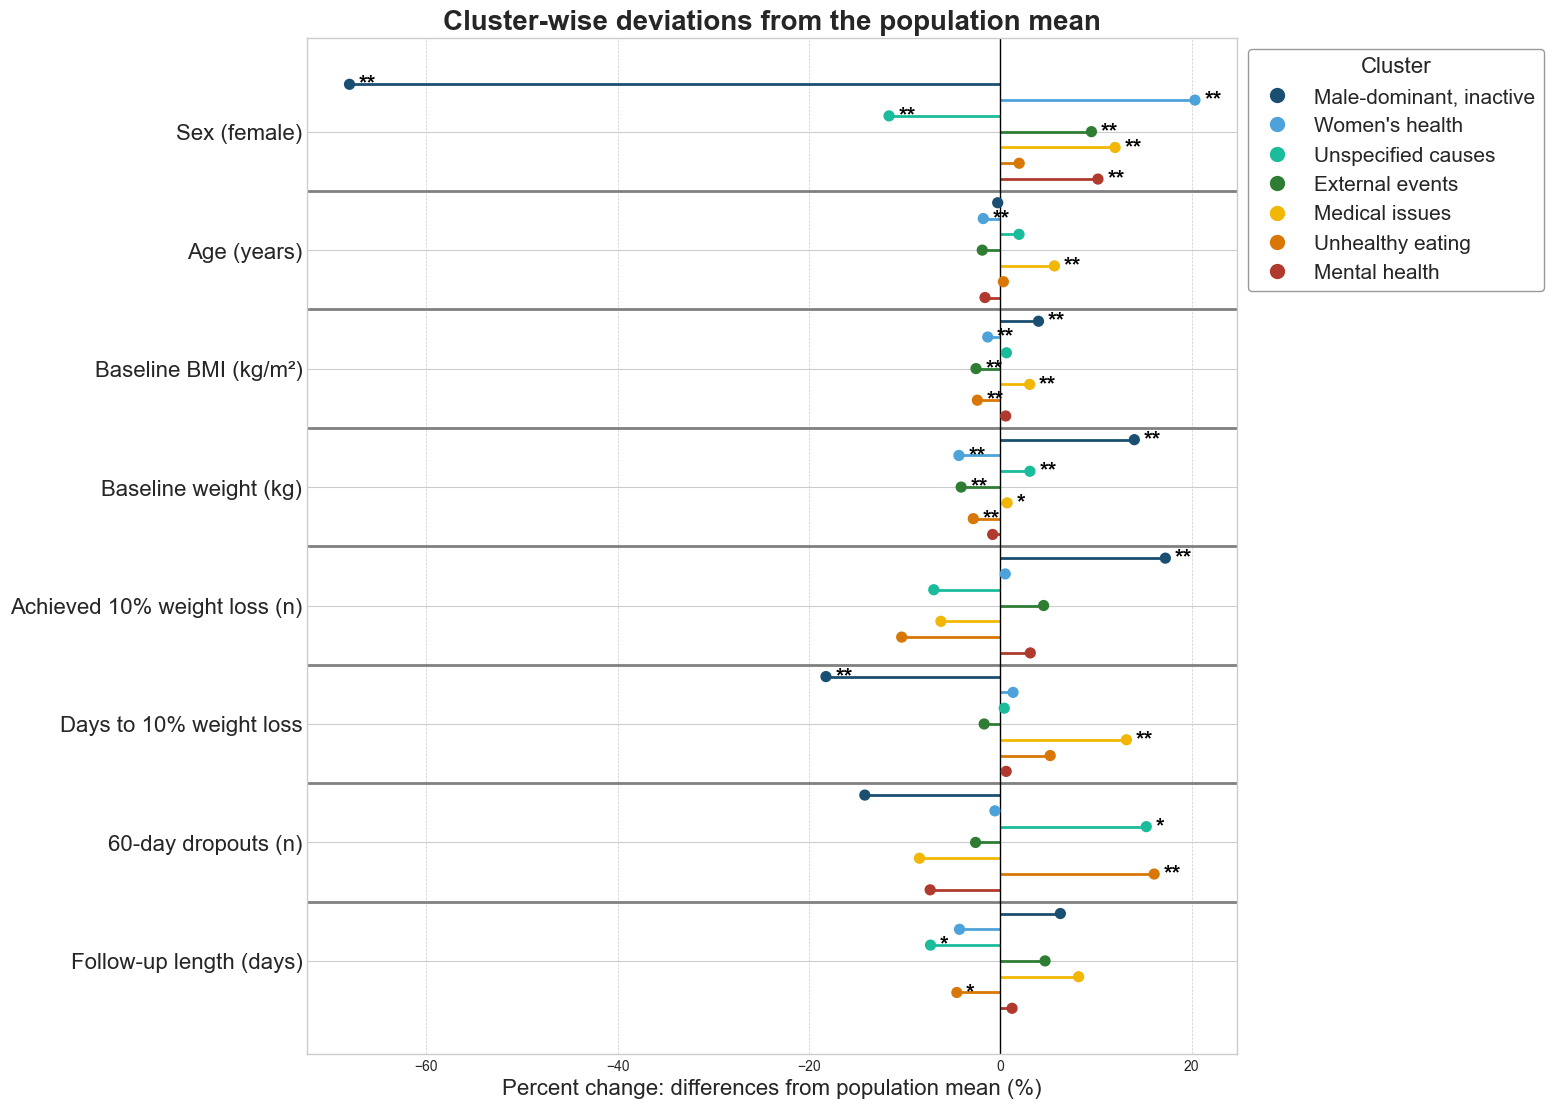

  ✓ Lollipop plot saved: ../outputs/cluster_bl_nobc_bw_pam_goldst_k7\percent_changes_lollipop.png


In [1]:
from cluster_descriptions import *

# Load date
cluster_df = load_and_merge_cluster_data(
    cluster_db_path="../dbs/pnk_db2_p2_cluster_pam_goldstd.sqlite",
    main_db_path="../dbs/pnk_db2_p2_in.sqlite",
    cluster_table="clust_labels_bl_nobc_bw_pam_goldstd",
    cluster_column="pam_k7",
    outcome_table="timetoevent_wgc_compl",
)

# Define variables of interest
# Weight gain causes (table+heatmap)
wgc_vars = [
    "womens_health_and_pregnancy",
    "mental_health",
    "family_issues",
    "medication_disease_injury",
    "physical_inactivity",
    "eating_habits",
    "schedule",
    "smoking_cessation",
    "treatment_discontinuation_or_relapse",
    "pandemic",
    "lifestyle_circumstances",
    "none_of_above",
]
# Clinical/demographic variables (table+lollipop)
clinical_vars = [
    "sex_f", 
    "age",
    "baseline_bmi",
    "baseline_weight_kg",
    "total_weight_loss_kg",
    "10%_wl_achieved", 
    "days_to_10%_wl",
    "60d_dropout",
    "total_followup_days",

    # "baseline_fat_%", 
    # "total_fat_loss_%", 
    # "baseline_muscle_%", 
    # "total_muscle_change_%"


]
# ALL variables for statistical analysis (table only)
all_vars = wgc_vars + clinical_vars

# Generate comparison table
results_df = analyze_cluster_vs_population(
    cluster_df,
    variables=all_vars,  # Analyze ALL variables
    output_db_path="../dbs/pnk_db2_p2_out.sqlite",
    output_table_name="clust_comps_bl_nobc_bw_pam_goldstd_k7",
    fdr_correction=True
)

# Generate WGC prevalence heatmap
plot_cluster_heatmap(
    results_df,
    output_filename='wgc_prev_heatmap.png',
    output_dir='../outputs/cluster_bl_nobc_bw_pam_goldst_k7',
    variables=wgc_vars,  # Only WGC variables in heatmap
    title='Weight gain cause prevalences by cluster',
    xlabel='',
    ylabel='',
    cbar_label='Prevalence (%)'
)

# Generate lollipop plot
plot_cluster_lollipop(
    cluster_df,
    variables=clinical_vars,  # Clinical variables for lollipop
    output_filename='percent_changes_lollipop.png',
    output_dir='../outputs/cluster_bl_nobc_bw_pam_goldst_k7',
    results_df=results_df,
    # pvalues_raw=pvalues_raw,
    # pvalues_fdr=pvalues_fdr,
    alpha=0.05,
    title='Cluster-wise deviations from the population mean',
    xlabel='Percent change: differences from population mean (%)'
)

#### Distribution of binary variables

Loading cluster data...
  ✓ Loaded 2463 cluster assignments
  ✓ Loaded 2463 outcome records
  ✓ Merged: 2463 records with clusters
  ✓ Clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
  ✓ Population for comparisons: entire clustered dataset (n=2463)

Generating stacked bar plots for 3 variables...
  Processing: sex_f
    Using chi-squared (categorical) test for variable 'sex_f'


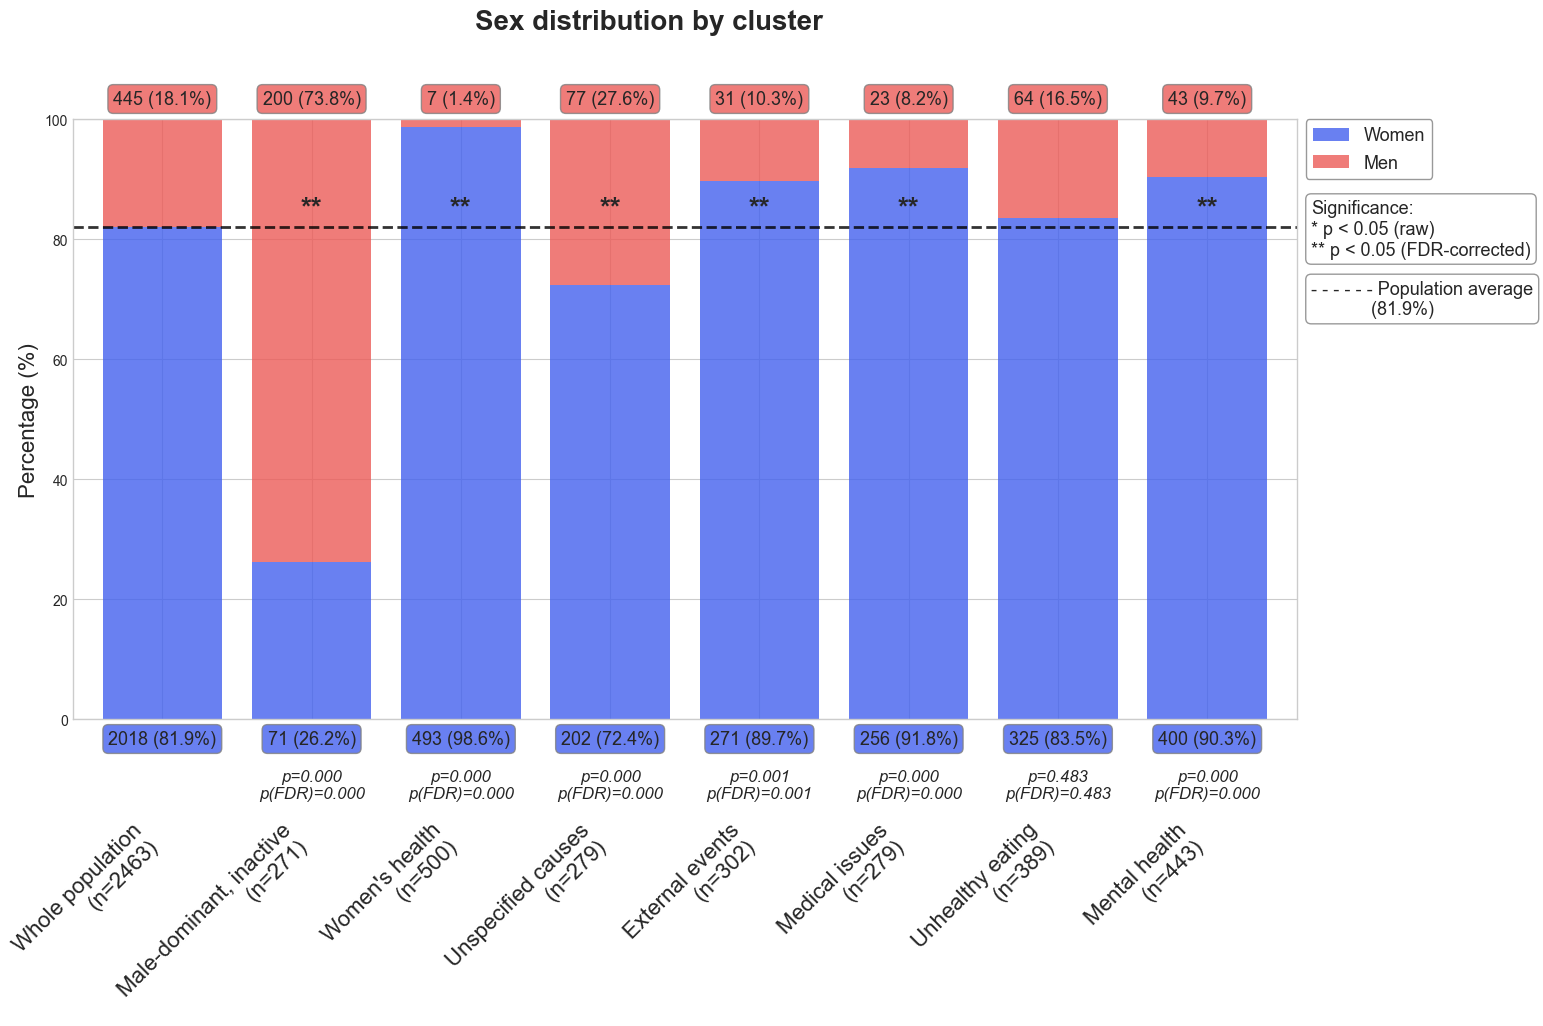

    ✓ Saved
  Processing: 10%_wl_achieved
    Using chi-squared (categorical) test for variable '10%_wl_achieved'


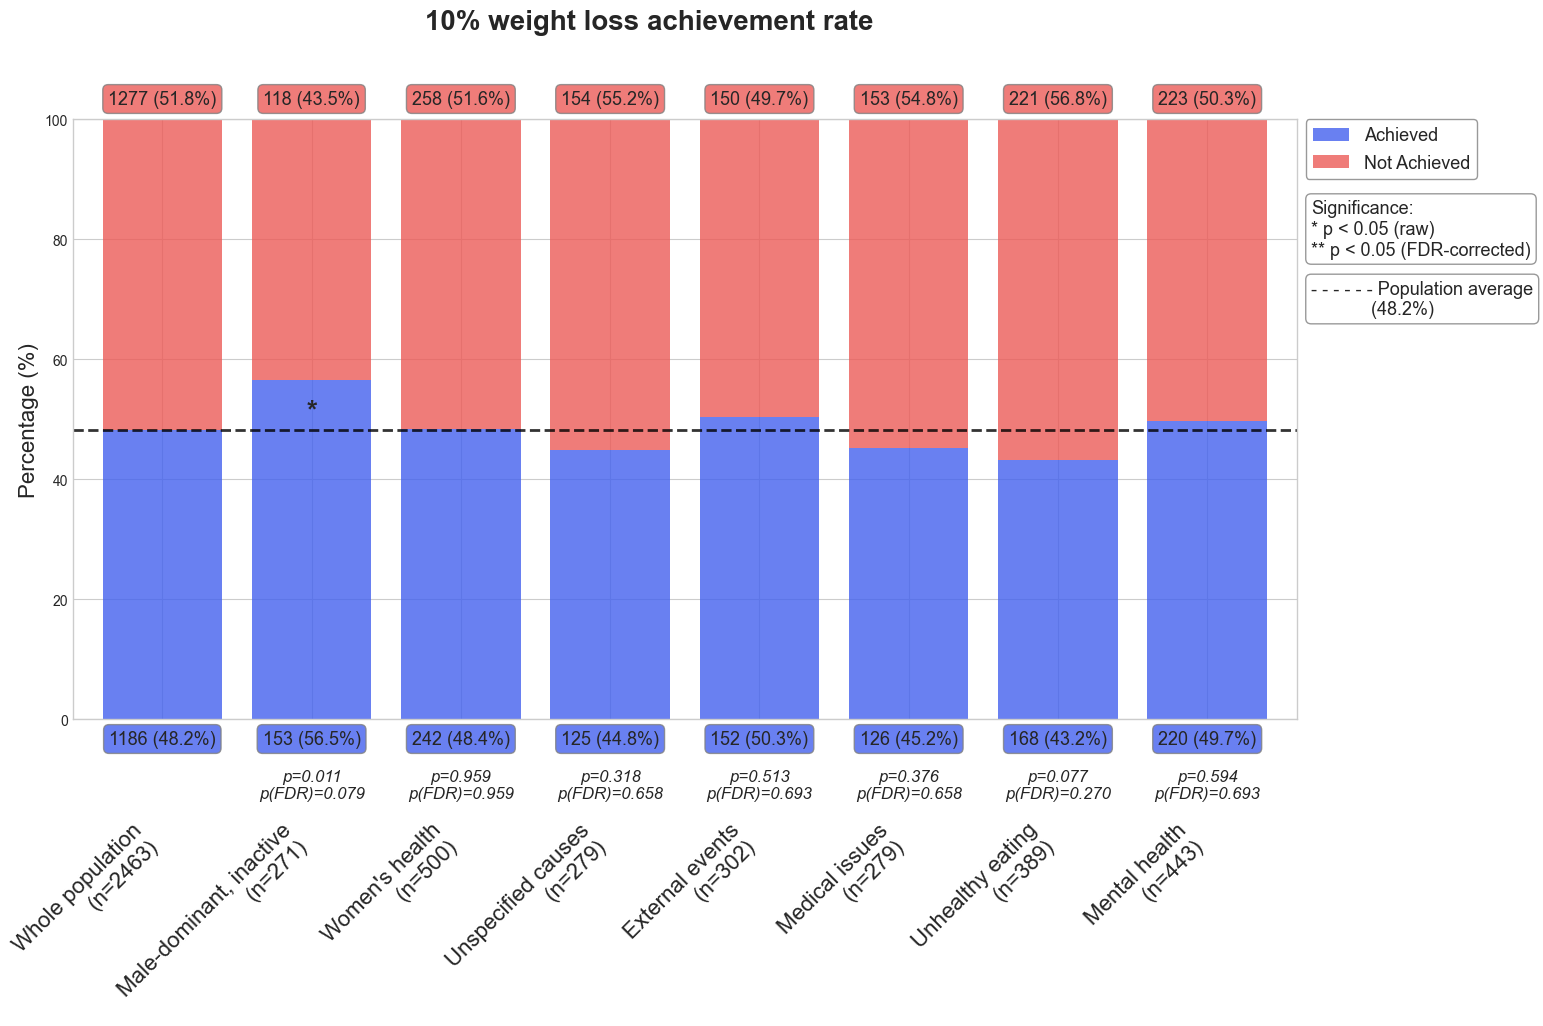

    ✓ Saved
  Processing: 60d_dropout
    Using chi-squared (categorical) test for variable '60d_dropout'


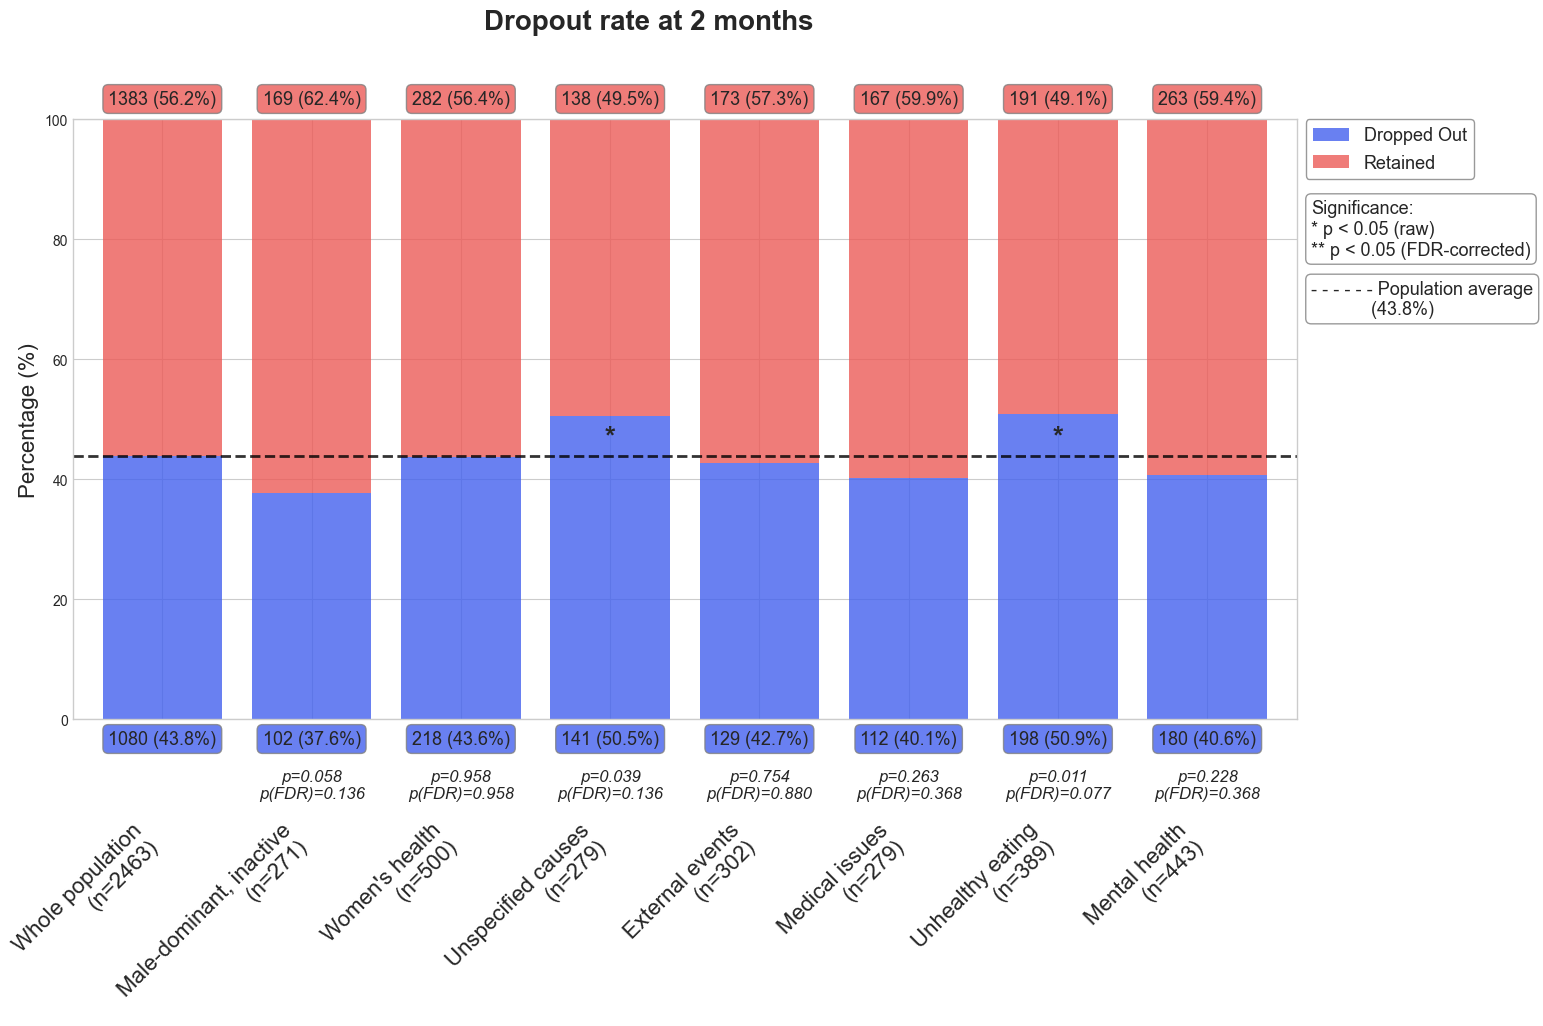

    ✓ Saved


In [2]:
from cluster_descriptions import *
# Load data
cluster_df = load_and_merge_cluster_data(
    cluster_db_path="../dbs/pnk_db2_p2_cluster_pam_goldstd.sqlite",
    main_db_path="../dbs/pnk_db2_p2_in.sqlite",
    cluster_table="clust_labels_bl_nobc_bw_pam_goldstd",
    cluster_column="pam_k7",
    outcome_table="timetoevent_wgc_compl",
)

cluster_categorical_distributions(
    cluster_df,
    variables=[
        'sex_f', 
        '10%_wl_achieved', 
        '60d_dropout'],
    output_dir='../outputs/cluster_bl_nobc_bw_pam_goldst_k7',
    # Global settings
    ylabel='Percentage (%)',
    xlabel='Groups',
    legend_labels={'achieved': 'Yes', 'not_achieved': 'No'},
    # Per-variable overrides
    variable_configs={
        'sex_f': {
            'title': 'Sex distribution by cluster',
            'legend_labels': {'achieved': 'Women', 'not_achieved': 'Men'}
        },
        '10%_wl_achieved': {
            'title': '10% weight loss achievement rate',
            'legend_labels': {'achieved': 'Achieved', 'not_achieved': 'Not Achieved'}
        },
        '60d_dropout': {
            'title': 'Dropout rate at 2 months',
            'legend_labels': {'achieved': 'Dropped Out', 'not_achieved': 'Retained'}
        }
    }
)

#### Distribution of continuos variables

Loading cluster data...
  ✓ Loaded 2463 cluster assignments
  ✓ Loaded 2463 outcome records
  ✓ Merged: 2463 records with clusters
  ✓ Clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
  ✓ Population for comparisons: entire clustered dataset (n=2463)

Generating violin plots for 7 variables...
  Processing: age
    Using Mann-Whitney U (continuous) test for variable 'age'


KeyboardInterrupt: 

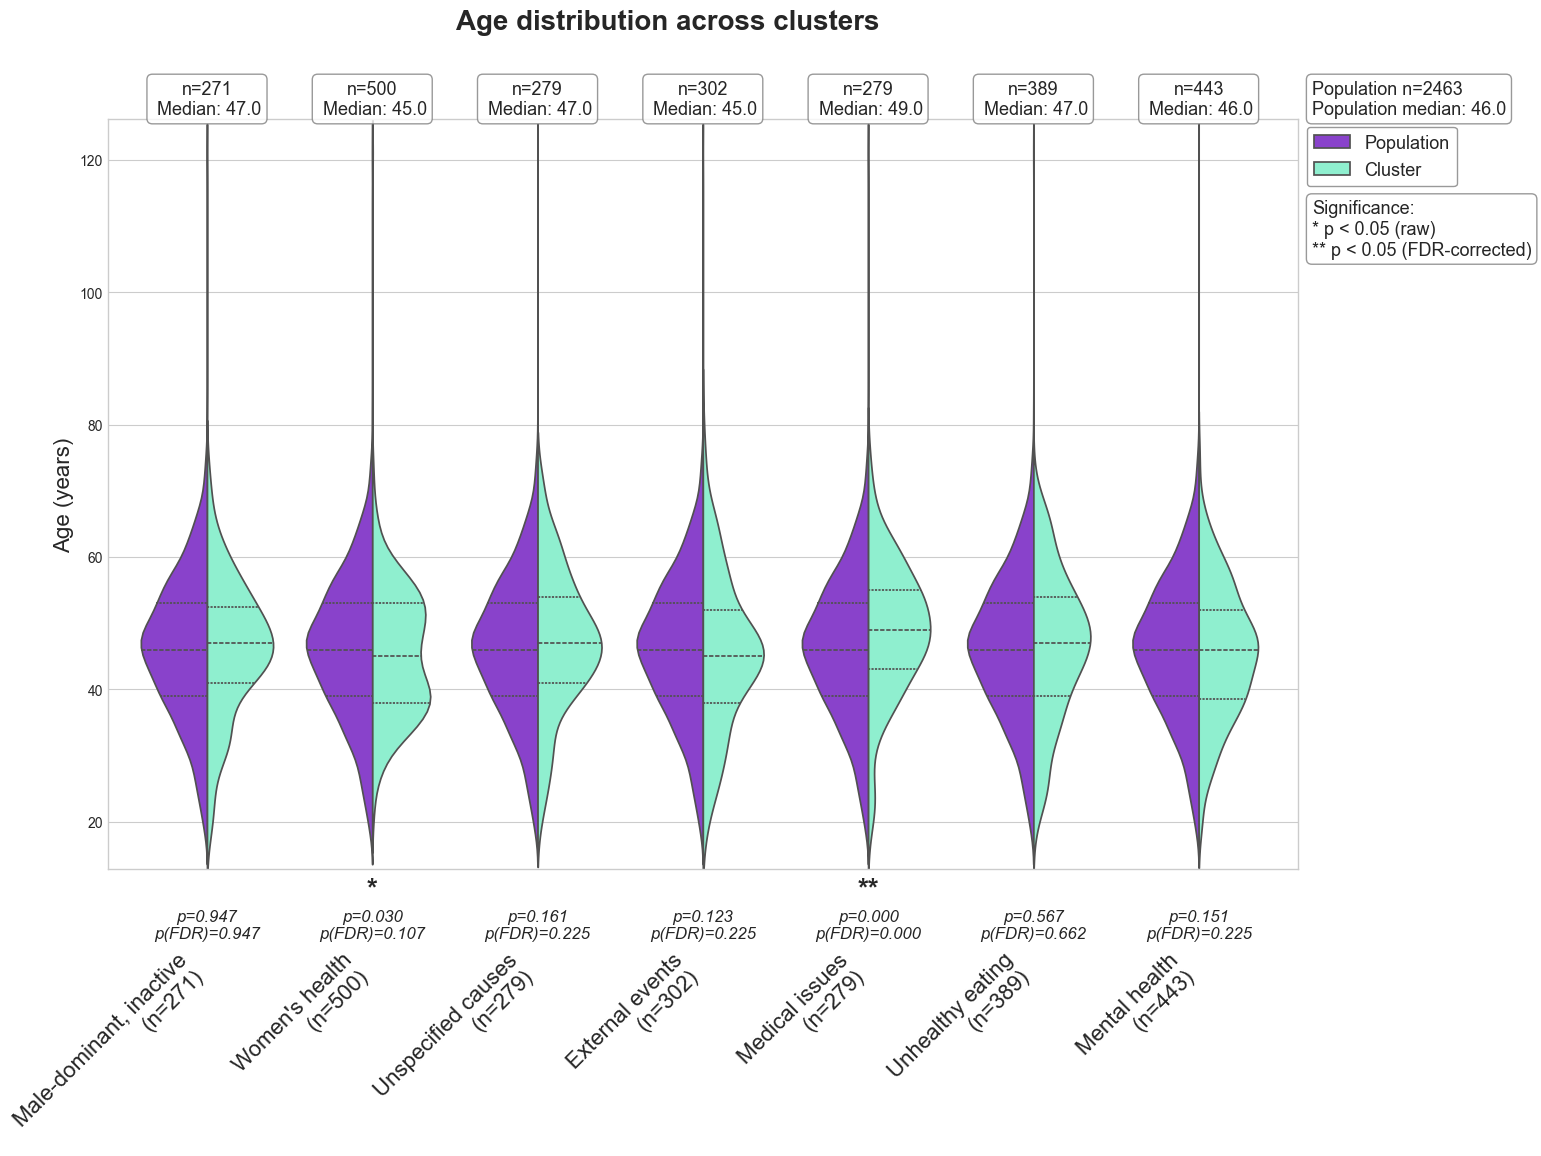

In [3]:
from cluster_descriptions import *
# Load data
cluster_df = load_and_merge_cluster_data(
    cluster_db_path="../dbs/pnk_db2_p2_cluster_pam_goldstd.sqlite",
    main_db_path="../dbs/pnk_db2_p2_in.sqlite",
    cluster_table="clust_labels_bl_nobc_bw_pam_goldstd",
    cluster_column="pam_k7",
    outcome_table="timetoevent_wgc_compl",
)

cluster_continuous_distributions(
    cluster_df,
    variables=[
        "age",
        "baseline_weight_kg",
        "baseline_bmi", 
        "total_wl_%", 
        "bmi_reduction",
        "days_to_10%_wl",
        "total_followup_days",        
    ],
    output_dir='../outputs/cluster_bl_nobc_bw_pam_goldst_k7',
    # Global settings
    title='Distribution of {variable} by Cluster',
    ylabel='{variable}',
    xlabel='Patient Clusters',
    # Per-variable overrides
    variable_configs={
        'age': {
            'title': 'Age distribution across clusters',
            # 'xlabel': 'Patient clusters',
            'ylabel': 'Age (years)',

        },
        'baseline_bmi': {
            'title': 'Baseline BMI distribution across clusters',
            # 'xlabel': 'Patient clusters',
            'ylabel': 'BMI (kg/m²)'
        },
        'baseline_weight_kg': {
            'title': 'Baseline weight distribution across clusters',
            # 'xlabel': 'Patient clusters',
            'ylabel': 'Weight (kg)'
        },
        'total_wl_%"': {
            'title': 'Total weight loss across clusters',
            # 'xlabel': 'Patient clusters',
            'ylabel': 'Total weight loss (%)'
        },
        'bmi_reduction': {
            'title': 'BMI reduction across clusters',
            # 'xlabel': 'Patient clusters',
            'ylabel': 'BMI (kg/m²)'
        },  
        'days_to_10%_wl': {
            'title': 'Weight loss speed as days to 10% weight loss across clusters',
            # 'xlabel': 'Patient clusters',
            'ylabel': 'Days to 10% weight loss (days)'
        },  
        'total_followup_days': {
            'title': 'Total follow-up length across clusters',
            # 'xlabel': 'Patient clusters',
            'ylabel': 'Total follow-up (days)'
        },  
    }
)

#### Effect size forest plots

Loading cluster data...
  ✓ Loaded 2463 cluster assignments
  ✓ Loaded 2463 outcome records
  ✓ Merged: 2463 records with clusters
  ✓ Clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
  ✓ Population for comparisons: entire clustered dataset (n=2463)

Generating forest plot(s) for '10%_wl_achieved'...


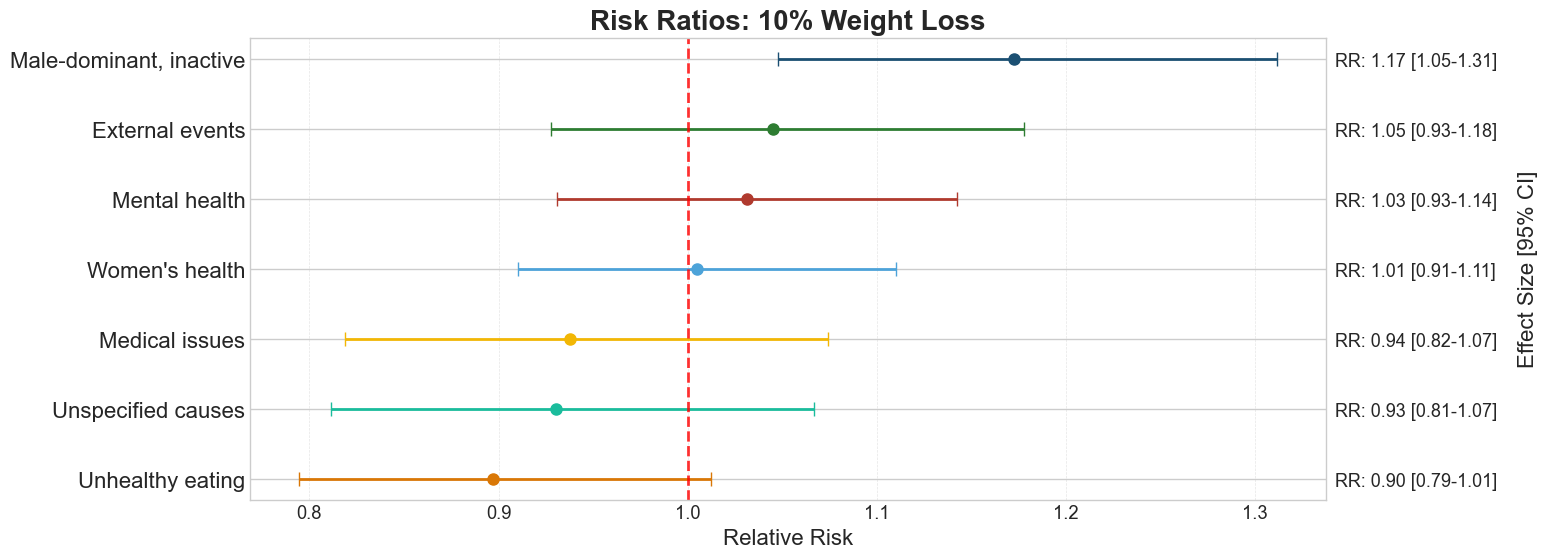

  ✓ Risk Ratio plot saved


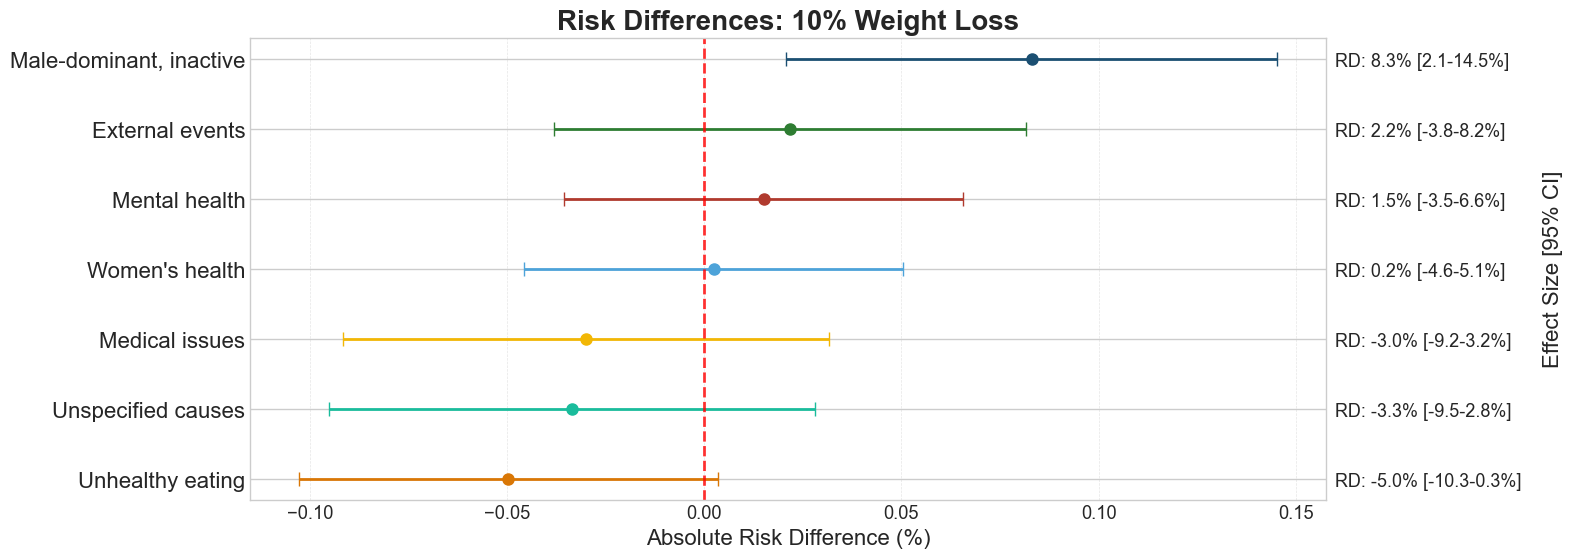

  ✓ Risk Difference plot saved

Generating forest plot(s) for '60d_dropout'...


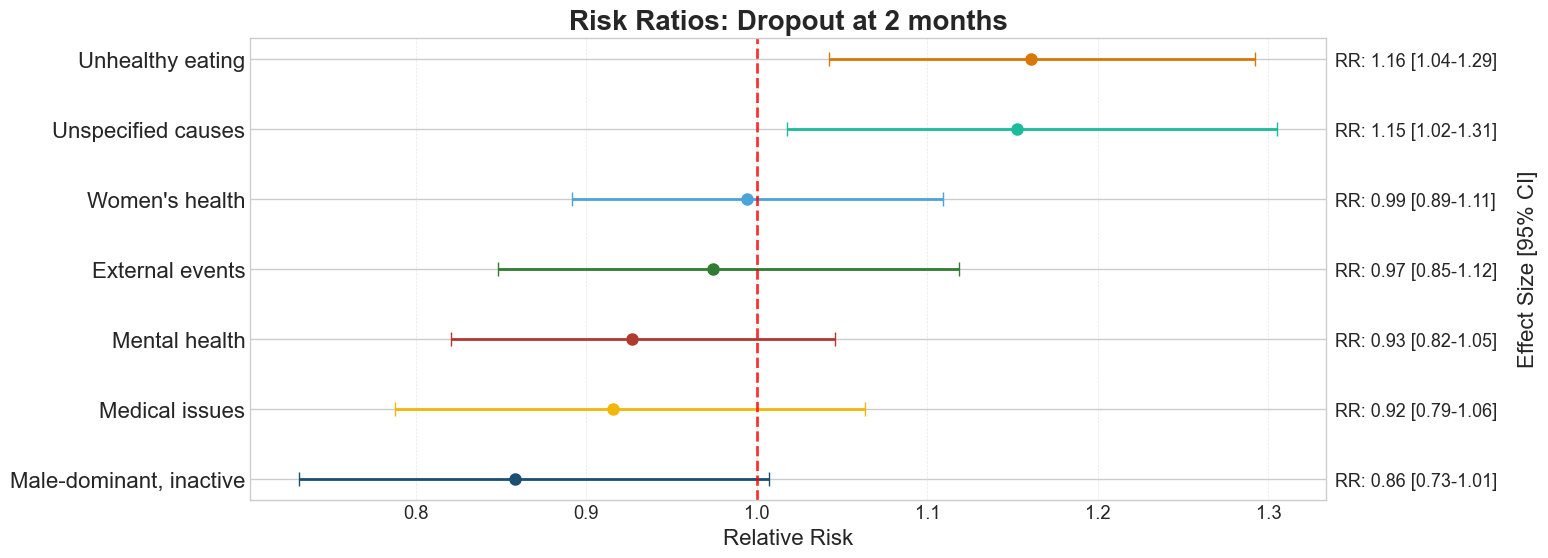

  ✓ Risk Ratio plot saved


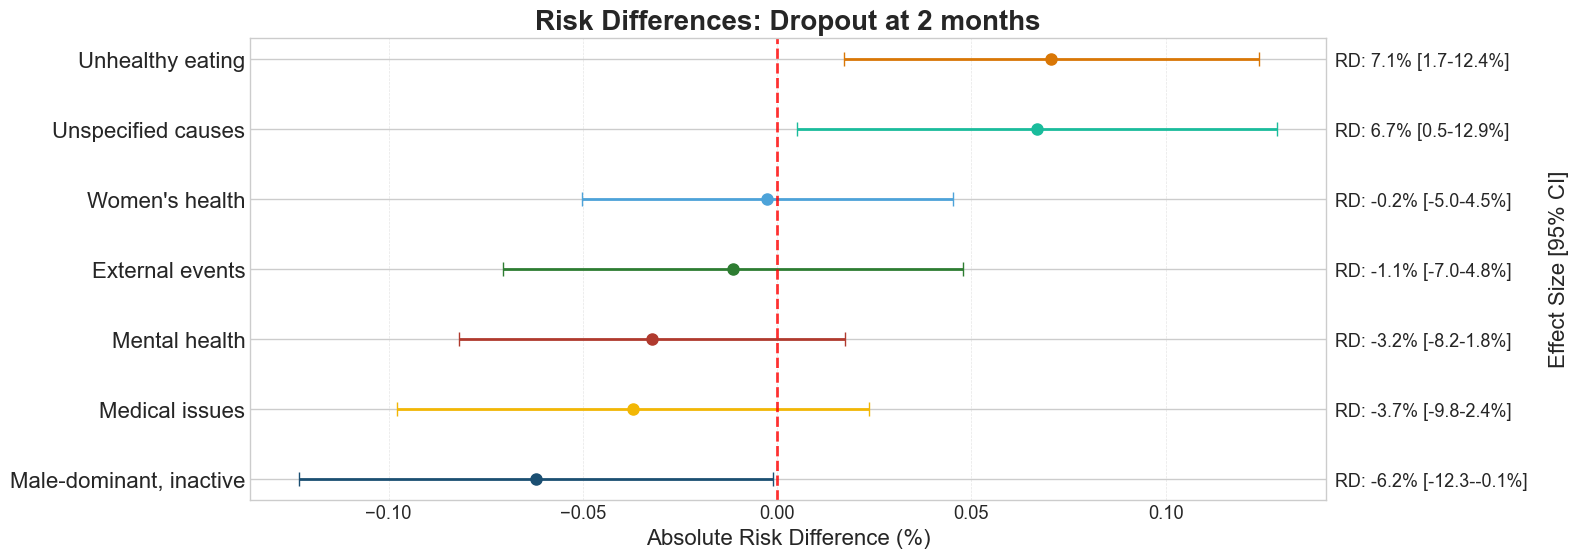

  ✓ Risk Difference plot saved


In [12]:
from cluster_descriptions import *

# Load data
cluster_df = load_and_merge_cluster_data(
    cluster_db_path="../dbs/pnk_db2_p2_cluster_pam_goldstd.sqlite",
    main_db_path="../dbs/pnk_db2_p2_in.sqlite",
    cluster_table="clust_labels_bl_nobc_bw_pam_goldstd",
    cluster_column="pam_k7",
    outcome_table="timetoevent_wgc_compl",
)

plot_cluster_forest(
    cluster_df,
    outcome_variable='10%_wl_achieved',
    output_dir='../outputs/cluster_bl_nobc_bw_pam_goldst_k7',
    effect_type='both',
    title_rr='Risk Ratios: 10% Weight Loss',
    title_rd='Risk Differences: 10% Weight Loss',
    ylabel='Patient Clusters',
    xlabel_rr='Relative Risk',
    xlabel_rd='Absolute Risk Difference (%)'
)

plot_cluster_forest(
    cluster_df,
    outcome_variable='60d_dropout',
    output_dir='../outputs/cluster_bl_nobc_bw_pam_goldst_k7',
    effect_type='both',
    title_rr='Risk Ratios: Dropout at 2 months',
    title_rd='Risk Differences: Dropout at 2 months',
    ylabel='Patient Clusters',
    xlabel_rr='Relative Risk',
    xlabel_rd='Absolute Risk Difference (%)'
)

#### *LEGACY?* Cluster comparisons 

new

In [1]:
"""
Cluster-wise Follow-up Analysis using Existing Infrastructure
VERSION: 2.4 (Final Debugging & Implementation)

DESCRIPTION:
This final version addresses all identified bugs from the v2.3 execution.
It corrects table formatting, CSV encoding, plot generation errors, and
ensures all significance markers display correctly.

CHANGELOG (v2.4):
- Fixed table generation to correctly interleave p-value columns.
- Fixed CSV export to use 'utf-8-sig' encoding to prevent character errors in Excel.
- Fixed a TypeError in the visualization loop that prevented Lollipop and Forest plots from generating.
- Corrected the significance map logic to ensure FDR-corrected p-values (**) are displayed on plots.
"""

import os
import sqlite3
import pandas as pd
import numpy as np

# --- Keep original project-specific imports ---
from descriptive_comparisons import (
    mann_whitney_u_test, format_mean_sd, format_n_perc, categorical_pvalue,
    add_fdr_corrected_pvalues_to_table, create_publication_table
)

# --- Import the visualization toolkit ---
import descriptive_visualizations as dv

# =============================================================================
# CONFIGURATION
# =============================================================================
# (This section is unchanged)
paper2_dbs_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\paper2_dir"
SOURCE_DB_PATH = os.path.join(paper2_dbs_directory, "dbs", "pnk_db2_p2_in.sqlite")
SOURCE_DATA_TABLE = "timetoevent_wgc_compl"
LABELS_DB_PATH = os.path.join(paper2_dbs_directory, "dbs", "pnk_db2_p2_cluster_pam_goldstd.sqlite")
LABELS_TABLE = "clust_labels_bl_nobc_bw_pam_goldstd"
OUTPUT_DIR = os.path.join(paper2_dbs_directory, "outputs", "cluster_analysis")
NAME_MAP_PATH = os.path.join(paper2_dbs_directory, "scripts", "human_readable_variable_names.json")
CLUSTERING_CONFIG = {'algorithm': 'pam', 'k': 7, 'include_outliers': False}
ALPHA = 0.05
VARIABLE_CONFIG = {
    'TABLE_VARS': [
        # Weight gain causes
        "womens_health_and_pregnancy",
        "mental_health",
        "family_issues",
        "medication_disease_injury",
        "physical_inactivity",
        "eating_habits",
        "schedule",
        "smoking_cessation",
        "treatment_discontinuation_or_relapse",
        "pandemic",
        "lifestyle_circumstances",
        "none_of_above",
        # Demographics & baseline anthropometry
        "sex_f", "age",
        "baseline_bmi",
        "baseline_weight_kg",
        # Weight loss outcomes
        # "final_bmi",
        "total_wl_%",
        # "bmi_reduction",
        # Dynamic time windows (if available)
        "60d_dropout",
        # "60d_wl_%",
        # "60d_bmi_reduction",
        # Targets (if available)
        "10%_wl_achieved", "days_to_10%_wl",
        # Follow-up
        "total_followup_days",
    ],
    'PLOT_VARS': {
        'violin': [
            "age",
            "baseline_weight_kg", 
            "total_followup_days", 
            "total_wl_%", 
            "days_to_10%_wl"
            ],
        'stacked_bar': [
            "sex_f",
            "10%_wl_achieved", 
            "60d_dropout"
            ],
        'forest': [
            "10%_wl_achieved", "60d_dropout"
            ],
        'lollipop': [
            # Demographics & baseline anthropometry
            "sex_f", "age",
            "baseline_bmi",
            "baseline_weight_kg",
            # Weight loss outcomes
            # "final_bmi",
            "total_wl_%",
            # "bmi_reduction",
            # Dynamic time windows (if available)
            "60d_dropout",
            # "60d_wl_%",
            # "60d_bmi_reduction",
            # Targets (if available)
            "10%_wl_achieved", "days_to_10%_wl",
            # Follow-up
            "total_followup_days",
            ]
    }
}


# =============================================================================
# VARIABLE CONFIGURATION CLASS (Unchanged)
# =============================================================================
class VariableConfig:
    def __init__(self, config_dict: dict): self.table_vars, self.plot_vars = config_dict.get('TABLE_VARS', []), config_dict.get('PLOT_VARS', {})
    def get_ordered_variables(self) -> list: return self.table_vars
    def get_plot_vars(self, plot_type: str) -> list: return self.plot_vars.get(plot_type, [])
    def get_variable_type(self, variable: str, df: pd.DataFrame) -> str:
        if variable not in df.columns or df[variable].isnull().all(): return 'missing'
        unique_values = set(df[variable].dropna().unique())
        if unique_values.issubset({0, 1}): return 'binary'
        return 'continuous'

# =============================================================================
# DATA LOADING (Unchanged)
# =============================================================================
def construct_cluster_column_name(config): return f"{config['algorithm'].lower()}_k{config['k']}"
def load_cluster_data_simple(labels_db_path, labels_table, source_db_path, source_table, cluster_column):
    with sqlite3.connect(labels_db_path) as conn: labels_df = pd.read_sql_query(f"SELECT * FROM {labels_table}", conn)
    with sqlite3.connect(source_db_path) as conn: source_df = pd.read_sql_query(f"SELECT * FROM {source_table}", conn)
    merged_df = source_df.merge(labels_df, on='medical_record_id', how='inner')
    valid_clusters_df = merged_df[merged_df[cluster_column] != -1].copy()
    unique_clusters = sorted([int(x) for x in merged_df[cluster_column].unique() if x != -1])
    return valid_clusters_df, unique_clusters, cluster_column

# =============================================================================
# MAIN ANALYSIS EXECUTION
# =============================================================================
print("=== COMPREHENSIVE CLUSTER ANALYSIS (v2.4 Final) ===")
os.makedirs(OUTPUT_DIR, exist_ok=True)
config = VariableConfig(VARIABLE_CONFIG)

cluster_column = construct_cluster_column_name(CLUSTERING_CONFIG)
cluster_df, unique_clusters, cluster_col = load_cluster_data_simple(LABELS_DB_PATH, LABELS_TABLE, SOURCE_DB_PATH, SOURCE_DATA_TABLE, cluster_column)
with sqlite3.connect(SOURCE_DB_PATH) as conn: population_df = pd.read_sql_query(f"SELECT * FROM {SOURCE_DATA_TABLE}", conn)

print("\n=== CREATING CLUSTER COMPARISON TABLE ===")
try:
    comparison_rows = []
    n_row = {"Variable": "N", "Population": len(population_df)}
    for cluster in unique_clusters: n_row[f"Cluster_{cluster}"] = len(cluster_df[cluster_df[cluster_col] == cluster])
    comparison_rows.append(n_row)
    
    for var in config.get_ordered_variables():
        if var not in cluster_df.columns: continue
        vtype = config.get_variable_type(var, cluster_df)
        if vtype == 'missing': continue
        row = {"Variable": var}
        row["Population"] = format_mean_sd(population_df[var]) if vtype == 'continuous' else format_n_perc(population_df[var])
        for cluster in unique_clusters:
            cluster_data = cluster_df[cluster_df[cluster_col] == cluster]
            p_val = np.nan
            if vtype == 'continuous':
                row[f"Cluster_{cluster}"] = format_mean_sd(cluster_data[var])
                p_val = mann_whitney_u_test(cluster_data[var], population_df[var])
            else: # binary
                row[f"Cluster_{cluster}"] = format_n_perc(cluster_data[var])
                p_val = categorical_pvalue(cluster_data[var], population_df[var])
            row[f"Cluster_{cluster}: p-value"] = f"{p_val:.4f}" if pd.notna(p_val) else "N/A"
        comparison_rows.append(row)

    comparison_df = pd.DataFrame(comparison_rows)
    detailed_df = add_fdr_corrected_pvalues_to_table(comparison_df)
    pub_df = create_publication_table(detailed_df)
    
    # CORRECTED: Save with 'utf-8-sig' encoding for Excel compatibility
    detailed_df.to_csv(os.path.join(OUTPUT_DIR, 'cluster_comparison_detailed_with_fdr.csv'), index=False, encoding='utf-8-sig')
    pub_df.to_csv(os.path.join(OUTPUT_DIR, 'cluster_comparison_publication.csv'), index=False, encoding='utf-8-sig')
    print("✓ Detailed and publication tables saved successfully.")
except Exception as e:
    print(f"✗ Cluster comparison table generation failed: {str(e)}"); detailed_df = pd.DataFrame()

print("\n=== GENERATING VISUALIZATIONS ===")
p_raw_map, p_fdr_map = {}, {}
if not detailed_df.empty:
    for var in config.get_ordered_variables():
        var_p_raw, var_p_fdr = {}, {}
        row_data = detailed_df.loc[detailed_df['Variable'] == var]
        if not row_data.empty:
            for cluster in unique_clusters:
                # CORRECTED: Find the correct FDR column name
                raw_col = f'Cluster_{cluster}: p-value'
                fdr_col = f'Cluster_{cluster}: p-value (FDR-corrected)'
                var_p_raw[cluster] = pd.to_numeric(row_data.get(raw_col, pd.Series([1.0])).iloc[0], errors='coerce')
                var_p_fdr[cluster] = pd.to_numeric(row_data.get(fdr_col, pd.Series([1.0])).iloc[0], errors='coerce')
        p_raw_map[var], p_fdr_map[var] = var_p_raw, var_p_fdr

try:
    for plot_type in ['violin', 'stacked_bar', 'forest', 'lollipop']:
        for var in config.get_plot_vars(plot_type):
            if var not in cluster_df.columns: continue
            
            if plot_type == 'violin':
                dv.plot_distribution_comparison(df=cluster_df, population_df=population_df, variable=var, group_col=cluster_col, output_filename=f'split_violin_{var}.png', name_map_path=NAME_MAP_PATH, output_dir=OUTPUT_DIR, significance_map_raw=p_raw_map.get(var), significance_map_fdr=p_fdr_map.get(var), alpha=ALPHA)
            
            elif plot_type == 'stacked_bar':
                dv.plot_stacked_bar_comparison(df=cluster_df, population_df=population_df, variable=var, group_col=cluster_col, output_filename=f'stacked_bar_{var}.png', name_map_path=NAME_MAP_PATH, output_dir=OUTPUT_DIR, significance_map_raw=p_raw_map.get(var), significance_map_fdr=p_fdr_map.get(var), alpha=ALPHA)

    # Lollipop and Forest plots have specific data prep, so we handle them separately
    lollipop_data = []
    for var in config.get_plot_vars('lollipop'):
        if var not in cluster_df.columns: continue
        pop_mean = population_df[var].mean()
        for cluster in unique_clusters:
            cluster_mean = cluster_df[cluster_df[cluster_col] == cluster][var].mean()
            if pd.notna(pop_mean) and pd.notna(cluster_mean) and pop_mean != 0:
                pct_change = ((cluster_mean - pop_mean) / pop_mean) * 100
                lollipop_data.append({'variable': var, 'cluster': f'Cluster {cluster}', 'value': pct_change})
    if lollipop_data:
        dv.plot_multi_lollipop(pd.DataFrame(lollipop_data), 'multi_cluster_lollipop.png', NAME_MAP_PATH, OUTPUT_DIR)

    for var in config.get_plot_vars('forest'):
        if var not in cluster_df.columns: continue
        forest_data = []
        for cluster in unique_clusters:
            cluster_group, other_group = cluster_df[cluster_df[cluster_col] == cluster], cluster_df[cluster_df[cluster_col] != cluster]
            if not (cluster_group.empty or other_group.empty):
                risk_cluster, risk_others = cluster_group[var].mean(), other_group[var].mean()
                rd = risk_cluster - risk_others; n1, n2 = len(cluster_group), len(other_group)
                se = np.sqrt((risk_cluster*(1-risk_cluster)/n1) + (risk_others*(1-risk_others)/n2))
                forest_data.append({'group': f'Cluster {cluster}', 'effect': rd, 'ci_lower': rd-1.96*se, 'ci_upper': rd+1.96*se})
        if forest_data:
            dv.plot_forest(pd.DataFrame(forest_data), f'forest_plot_{var}.png', NAME_MAP_PATH, OUTPUT_DIR, title=f'Risk Differences: {dv.get_nice_name(var, dv.load_name_map(NAME_MAP_PATH))}')

except Exception as e:
    print(f"✗ An error occurred during visualization: {e}")

print(f"\n✓ Comprehensive analysis complete! Check the output folder: {OUTPUT_DIR}")


=== COMPREHENSIVE CLUSTER ANALYSIS (v2.4 Final) ===

=== CREATING CLUSTER COMPARISON TABLE ===
✓ Detailed and publication tables saved successfully.

=== GENERATING VISUALIZATIONS ===
✓ Split-violin plot saved to: C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\outputs\cluster_analysis\split_violin_age.png
✓ Split-violin plot saved to: C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\outputs\cluster_analysis\split_violin_baseline_weight_kg.png
✓ Split-violin plot saved to: C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\outputs\cluster_analysis\split_violin_total_followup_days.png
✓ Split-violin plot saved to: C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\outputs\cluster_analysis\split_violin_total_wl_%.png
✓ Split-violin plot saved to: C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\outputs\cluster_analysis\split_violin_days_to_10%_wl.png
✓ Corrected stacked bar plot saved to: C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\output

prev

=== CLUSTER COMPARISON PIPELINE ===
Configuration: {'algorithm': 'pam', 'k': 7, 'include_outliers': False}
Looking for cluster column: pam_k7

Loading cluster data (labels from LABELS_DB_PATH, clinical from SOURCE_DB_PATH)...
Loaded data for 7 clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Total patients in valid clusters: 2463
  Cluster 0: 271 patients (11.0%)
  Cluster 1: 500 patients (20.3%)
  Cluster 2: 279 patients (11.3%)
  Cluster 3: 302 patients (12.3%)
  Cluster 4: 279 patients (11.3%)
  Cluster 5: 389 patients (15.8%)
  Cluster 6: 443 patients (18.0%)

Comparing 25 variables across 7 groups...

=== CLUSTER COMPARISON RESULTS ===
                                  Variable     Cluster_0     Cluster_1     Cluster_2     Cluster_3     Cluster_4     Cluster_5     Cluster_6  p-value      Test_Used
                           N (sample size)           271           500           279           302           279           389       

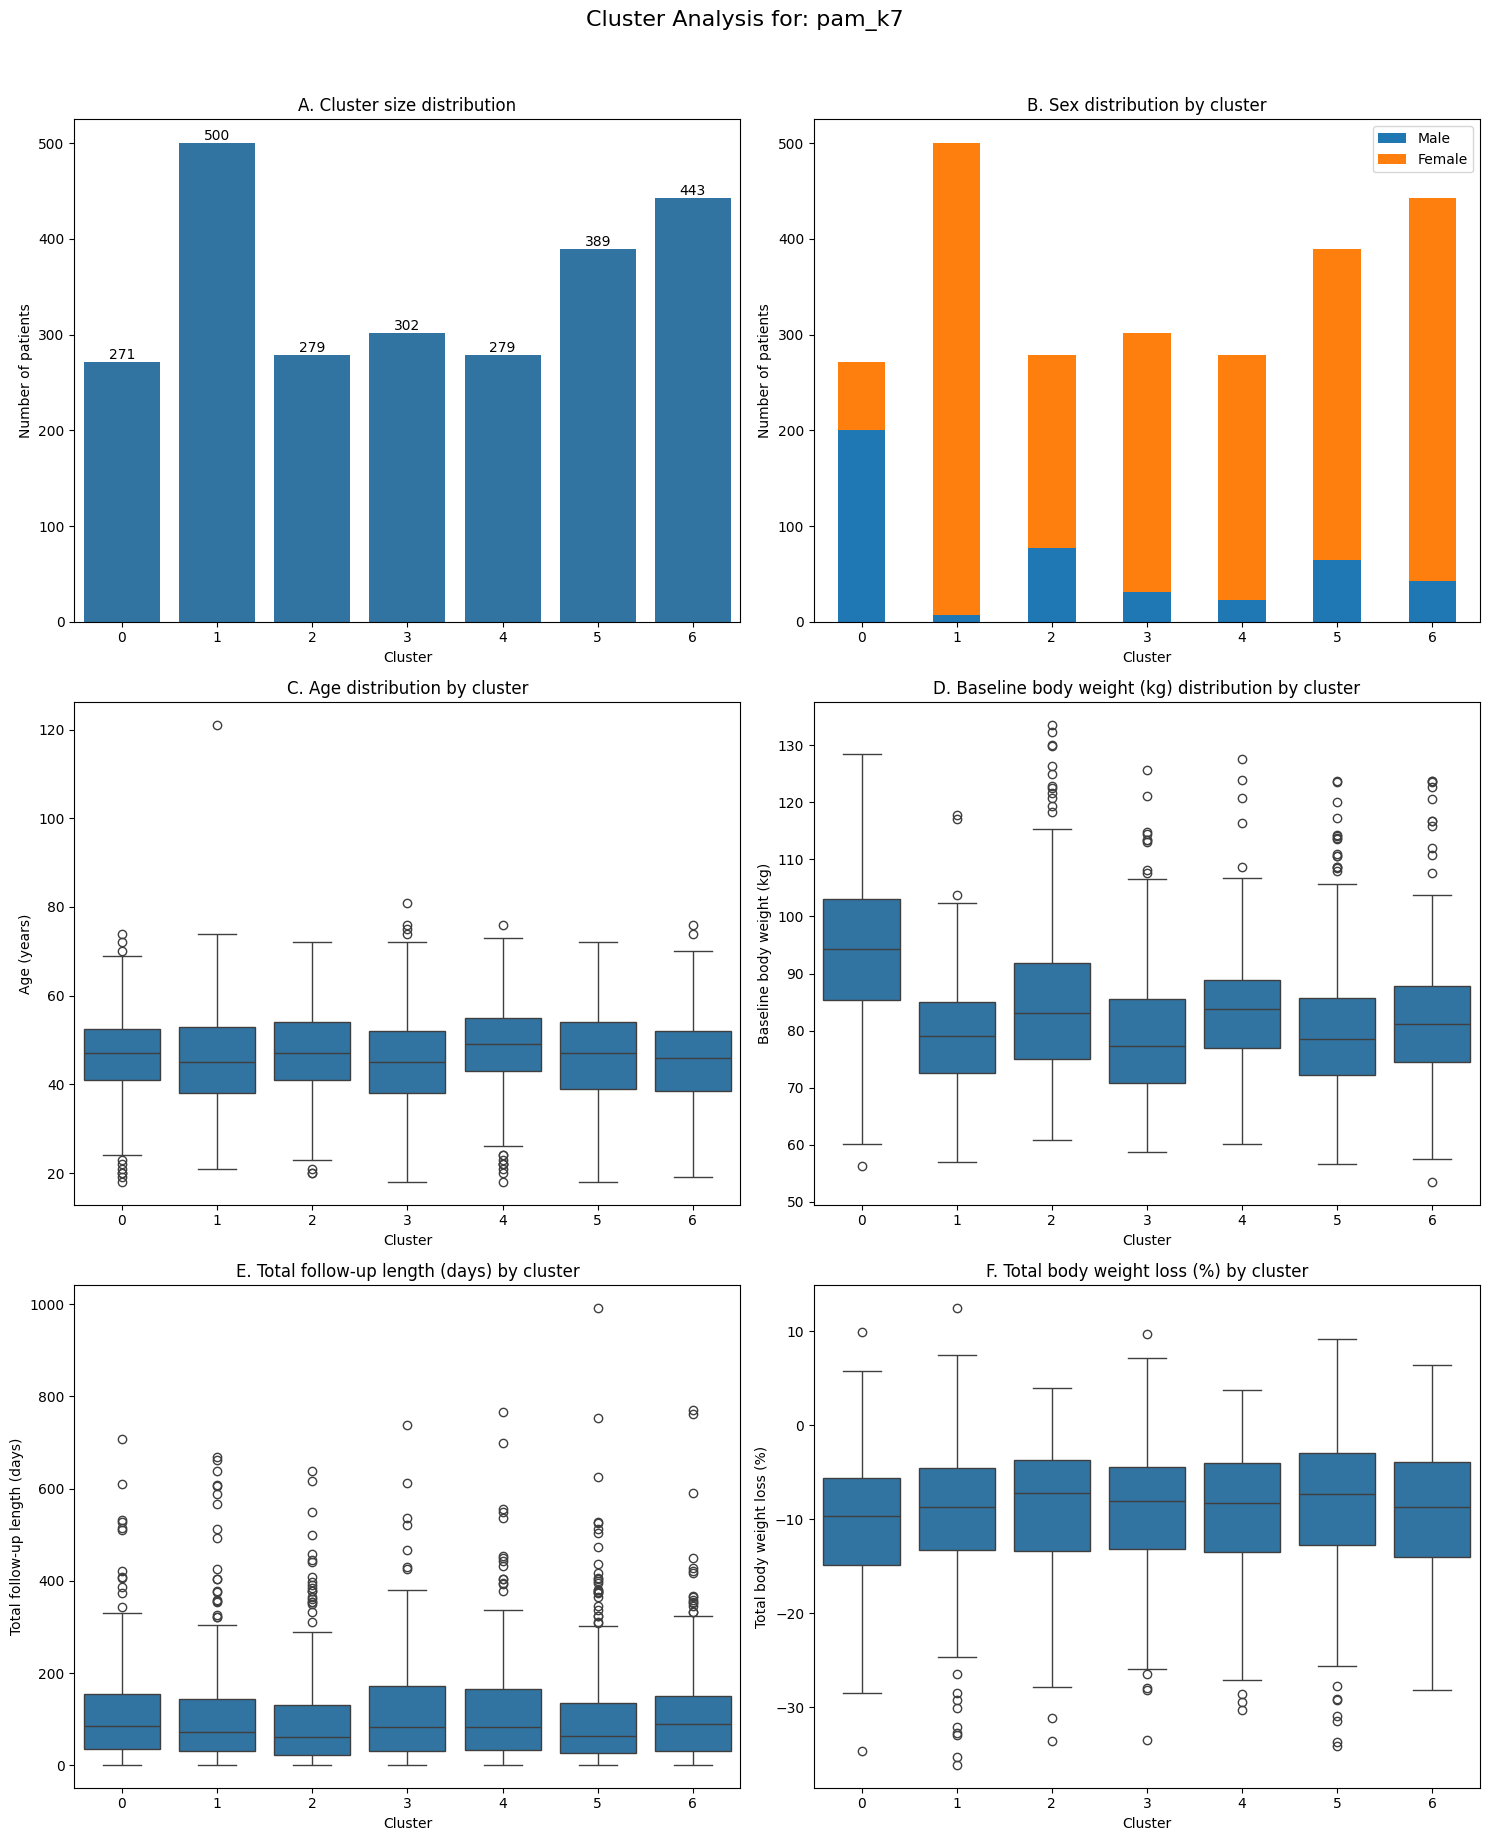


=== SIGNIFICANT DIFFERENCES (p < 0.05) ===
Found 25 variables with significant differences:
  Women's health & pregnancy (y/n): p = 1.00E-04 (fisher_exact)
  Mental health (y/n): p = 1.00E-04 (fisher_exact)
  Family issues (y/n): p = 1.00E-04 (fisher_exact)
  Medication, disease, or injury (y/n): p = 1.00E-04 (fisher_exact)
  Physical inactivity (y/n): p = 1.00E-04 (fisher_exact)
  Eating habits (y/n): p = 1.00E-04 (fisher_exact)
  Schedule (y/n): p = 1.00E-04 (fisher_exact)
  Smoking cessation (y/n): p = 1.00E-04 (fisher_exact)
  Treatment discontinuation or relapse (y/n): p = 1.00E-04 (fisher_exact)
  Pandemic (y/n): p = 1.00E-04 (fisher_exact)
  Lifestyle, circumstances (y/n): p = 1.00E-04 (fisher_exact)
  None of the above (y/n): p = 1.00E-04 (fisher_exact)
  Sex (female): p = 1.00E-04 (fisher_exact)
  Age (years): p = 6.37E-06 (kruskal_wallis)
  Baseline BMI (kg/m²): p = 1.26E-23 (kruskal_wallis)
  Baseline weight (kg): p = 1.02E-57 (kruskal_wallis)
  Final BMI (kg/m²): p = 7.55E

In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import kruskal, fisher_exact
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURATION SECTION
# =============================================================================

# Define the paper2_directory path (modify this to your actual path)
paper2_dbs_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\paper2_dir\\dbs"  # Paper 2-specific files and code

# Input databases and tables
SOURCE_DB_PATH = os.path.join(paper2_dbs_directory, "pnk_db2_p2_in.sqlite")                  # Clinical/source data DB
SOURCE_DATA_TABLE = "timetoevent_wgc_compl"                                              # Clinical/source data table

LABELS_DB_PATH = os.path.join(paper2_dbs_directory, "pnk_db2_p2_cluster_pam_goldstd.sqlite") # Cluster labels DB (experiment-specific)
LABELS_TABLE = "clust_labels_bl_nobc_bw_pam_goldstd"                                     # Cluster labels table (experiment-specific)
# LABELS_TABLE = "clust_labels_jaccard_wgc_pam_goldstd"                                     # Cluster labels table (experiment-specific)

# Output database and table
OUTPUT_DATABASE_PATH = os.path.join(paper2_dbs_directory, "pnk_db2_p2_out.sqlite")           # Output DB for comparison results
OUTPUT_TABLE = "bl_nobc_bw_pam_goldstd_k7"                                                             # Manual table name for results

# =============================================================================
# CLUSTER SELECTION CONFIGURATION
# =============================================================================

# Configure the clustering setup you want to analyze
CLUSTERING_CONFIG = {
    'algorithm': 'pam',           # 'hclust', 'pam', 'kmeans', etc.
    'k': 7,                          # number of clusters
    # 'linkage': 'ward',               # for hclust: 'ward', 'complete', 'average', 'single'
    'include_outliers': False        # whether to include outliers as separate group
}

# Variables to compare across clusters
COMPARISON_VARIABLES = [
    "womens_health_and_pregnancy",
    "mental_health",
    "family_issues",
    "medication_disease_injury",
    "physical_inactivity",
    "eating_habits",
    "schedule",
    "smoking_cessation",
    "treatment_discontinuation_or_relapse",
    "pandemic",
    "lifestyle_circumstances",
    "none_of_above",
    # Demographics & baseline anthropometry
    "sex_f", "age",
    "baseline_bmi",
    "baseline_weight_kg",
    # Weight loss outcomes
    "final_bmi",
    "total_wl_%",
    "bmi_reduction",
    # Dynamic time windows (if available)
    "60d_dropout",
    "60d_wl_%",
    "60d_bmi_reduction",
    # Targets (if available)
    "10%_wl_achieved", "days_to_10%_wl",
    # Follow-up
    "total_followup_days",
]

# Human-readable variable names
VARIABLE_NAME_MAP = {
    "N (sample size)": "N (sample size)",
    "womens_health_and_pregnancy": "Women's health & pregnancy (y/n)",
    "mental_health": "Mental health (y/n)",
    "family_issues": "Family issues (y/n)",
    "medication_disease_injury": "Medication, disease, or injury (y/n)",
    "physical_inactivity": "Physical inactivity (y/n)",
    "eating_habits": "Eating habits (y/n)",
    "schedule": "Schedule (y/n)",
    "smoking_cessation": "Smoking cessation (y/n)",
    "treatment_discontinuation_or_relapse": "Treatment discontinuation or relapse (y/n)",
    "pandemic": "Pandemic (y/n)",
    "lifestyle_circumstances": "Lifestyle, circumstances (y/n)",
    "none_of_above": "None of the above (y/n)",
    "sex_f": "Sex (female)",
    "age": "Age (years)",
    "baseline_weight_kg": "Baseline weight (kg)",
    "baseline_bmi": "Baseline BMI (kg/m²)",
    "final_bmi": "Final BMI (kg/m²)",
    "total_wl_%": "Total Weight Loss (%)",
    "bmi_reduction": "BMI reduction (kg/m²)",
    "60d_dropout": "Dropout at 60 days (yes/no)",
    "60d_wl_%": "Weight loss at 60 days (%)",
    "60d_bmi_reduction": "BMI Reduction at 60 days (kg/m²)",
    "10%_wl_achieved": "Achieved 10% weight loss (yes/no)",
    "days_to_10%_wl": "Days to 10% weight loss",
    "total_followup_days": "Total follow-up (days)",
}

# =============================================================================
# HELPER FUNCTIONS FOR STATISTICAL FORMATTING
# =============================================================================

def format_mean_sd(series, decimals=2):
    """Format mean ± SD for continuous variables."""
    if series.isna().all():
        return "N/A"
    mean_val = series.mean()
    sd_val = series.std()
    return f"{mean_val:.{decimals}f}±{sd_val:.{decimals}f}"

def format_n_perc(series):
    """Format n (%) for categorical variables."""
    if series.isna().all():
        return "N/A"
    total = series.notna().sum()
    positive = series.sum() if series.dtype in ['bool', 'int64'] else (series == 1).sum()
    if total == 0:
        return "0 (0.0%)"
    percentage = (positive / total) * 100
    return f"{int(positive)} ({percentage:.1f}%)"

def format_pval(p_value, threshold=0.001):
    """Format p-values with appropriate precision, showing exact values."""
    if pd.isna(p_value):
        return "N/A"
    if p_value < threshold:
        return f"{p_value:.2E}"
    else:
        return f"{p_value:.3f}"

# =============================================================================
# STATISTICAL TEST FUNCTIONS
# =============================================================================

def perform_continuous_test(groups_data, variable):
    """Kruskal-Wallis test for continuous variables."""
    valid_groups = [group[variable].dropna() for group in groups_data if not group[variable].isna().all()]
    if len(valid_groups) < 2:
        return np.nan, "insufficient_data"
    group_sizes = [len(group) for group in valid_groups]
    if min(group_sizes) == 0:
        return np.nan, "empty_groups"
    try:
        _, p_value = kruskal(*valid_groups)
        return p_value, "kruskal_wallis"
    except Exception:
        return np.nan, "error"

def perform_categorical_test(groups_data, variable):
    """Fisher's Exact Test for categorical variables."""
    try:
        contingency_data = []
        for group in groups_data:
            group_data = group[variable].dropna()
            if len(group_data) == 0:
                contingency_data.append([0, 0])
            else:
                positive = group_data.sum() if group_data.dtype in ['bool', 'int64'] else (group_data == 1).sum()
                negative = len(group_data) - positive
                contingency_data.append([positive, negative])
        contingency_table = np.array(contingency_data)
        if np.any(contingency_table.sum(axis=0) == 0):
            return 1.0, "no_variation"
        _, p_value = fisher_exact(contingency_table)
        return p_value, "fisher_exact"
    except ValueError:
        return np.nan, "test_failed"
    except Exception:
        return np.nan, "error"

# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def construct_cluster_column_name(config):
    """Construct the column name for the specified clustering configuration."""
    algorithm = config['algorithm'].lower()
    k = config['k']
    if algorithm == 'hclust':
        linkage = config.get('linkage', 'ward')
        return f"hclust_{linkage}_k{k}"
    elif algorithm == 'pam':
        return f"pam_k{k}"
    elif algorithm == 'kmeans':
        return f"kmeans_k{k}"
    else:
        raise ValueError(f"Unsupported algorithm: {algorithm}")

def determine_variable_type(variable, df):
    """Determine if a variable is continuous or categorical."""
    if variable not in df.columns:
        return "missing"
    categorical_indicators = ["_yn", "_achieved", "_dropout", "sex_f", "instant_dropout"]
    if any(indicator in variable for indicator in categorical_indicators):
        return "categorical"
    continuous_likert = ["emotional_eating_value_likert", "quantity_control_likert", "impulse_control_likert"]
    if variable in continuous_likert:
        return "continuous"
    series = df[variable].dropna()
    if len(series) == 0:
        return "missing"
    if series.dtype == 'bool' or set(series.unique()).issubset({0, 1, True, False}):
        return "categorical"
    unique_ratio = len(series.unique()) / len(series)
    if unique_ratio < 0.05 and len(series.unique()) <= 10:
        return "categorical"
    return "continuous"

# =============================================================================
# DATA LOADING FUNCTIONS
# =============================================================================

def _list_tables(conn):
    cur = conn.cursor()
    cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
    return [row[0] for row in cur.fetchall()]

def load_cluster_data(labels_db_path, labels_table, source_db_path, source_table, cluster_column, include_outliers=True):
    """
    Load cluster labels (from labels DB) and source/clinical data (from source DB), then merge by medical_record_id.
    """
    if not os.path.exists(labels_db_path):
        raise FileNotFoundError(f"Labels DB not found: {labels_db_path}")
    if not os.path.exists(source_db_path):
        raise FileNotFoundError(f"Source DB not found: {source_db_path}")

    # Load labels from labels DB
    with sqlite3.connect(labels_db_path) as conn_lab:
        lab_tables = _list_tables(conn_lab)
        if labels_table not in lab_tables:
            raise ValueError(f"Table '{labels_table}' not in labels DB; available: {lab_tables}")
        labels_df = pd.read_sql_query(f"SELECT * FROM {labels_table}", conn_lab)

    # Load source data from source DB
    with sqlite3.connect(source_db_path) as conn_src:
        src_tables = _list_tables(conn_src)
        if source_table not in src_tables:
            raise ValueError(f"Table '{source_table}' not in source DB; available: {src_tables}")
        source_df = pd.read_sql_query(f"SELECT * FROM {source_table}", conn_src)

    # Check cluster column presence
    if cluster_column not in labels_df.columns:
        available_columns = [c for c in labels_df.columns if any(alg in c for alg in ['hclust', 'pam', 'kmeans'])]
        raise ValueError(f"Cluster column '{cluster_column}' not found in labels table; candidates: {available_columns}")

    # Merge on medical_record_id
    merged_df = source_df.merge(labels_df, on='medical_record_id', how='inner')

    # Split out outliers (if any requested)
    outliers_df = merged_df[merged_df[cluster_column] == -1].copy() if include_outliers else pd.DataFrame()
    valid_clusters_df = merged_df[merged_df[cluster_column] != -1].copy()

    unique_clusters = sorted([x for x in merged_df[cluster_column].unique() if x != -1])
    if len(unique_clusters) == 0:
        raise ValueError("No valid cluster labels found")

    print(f"Loaded data for {len(unique_clusters)} clusters: {unique_clusters}")
    if include_outliers and len(outliers_df) > 0:
        print(f"Outliers (excluded from clustering): {len(outliers_df)} patients")
    print(f"Total patients in valid clusters: {len(valid_clusters_df)}")

    cluster_sizes = valid_clusters_df[cluster_column].value_counts().sort_index()
    for cluster, size in cluster_sizes.items():
        print(f"  Cluster {cluster}: {size} patients ({size/len(valid_clusters_df)*100:.1f}%)")

    return merged_df, unique_clusters, cluster_column, outliers_df

# =============================================================================
# ANALYSIS FUNCTIONS
# =============================================================================

def compare_clusters(df, clusters, cluster_column, outliers_df, variables, name_map):
    """Perform statistical comparisons across clusters."""
    results = []

    # Build group containers
    cluster_groups = []
    group_names = []

    # Add regular clusters
    for cluster in clusters:
        cluster_data = df[df[cluster_column] == cluster]
        cluster_groups.append(cluster_data)
        group_names.append(f"Cluster_{cluster}")

    # Add outliers if provided
    if len(outliers_df) > 0:
        cluster_groups.append(outliers_df)
        group_names.append("Outliers")

    # Sample sizes row
    size_row = {"Variable": "N (sample size)"}
    for i, group_name in enumerate(group_names):
        size_row[group_name] = f"{len(cluster_groups[i])}"
    size_row["p-value"] = "N/A"
    size_row["Test_Used"] = "N/A"
    results.append(size_row)

    # Variable-wise stats and tests
    for variable in variables:
        if variable not in df.columns:
            row = {"Variable": variable}
            for group_name in group_names:
                row[group_name] = "N/A"
            row["p-value"] = "N/A"
            row["Test_Used"] = "missing_variable"
            results.append(row)
            continue

        var_type = determine_variable_type(variable, df)
        row = {"Variable": variable}

        # Descriptives
        for i, group_name in enumerate(group_names):
            group_data = cluster_groups[i]
            if var_type == "continuous":
                row[group_name] = format_mean_sd(group_data[variable])
            elif var_type == "categorical":
                row[group_name] = format_n_perc(group_data[variable])
            else:
                row[group_name] = "N/A"

        # Inference
        if var_type == "continuous":
            p_value, test_used = perform_continuous_test(cluster_groups, variable)
        elif var_type == "categorical":
            p_value, test_used = perform_categorical_test(cluster_groups, variable)
        else:
            p_value, test_used = np.nan, "unsupported_type"

        row["p-value"] = format_pval(p_value)
        row["Test_Used"] = test_used
        results.append(row)

    # Assemble results
    column_order = ["Variable"] + group_names + ["p-value", "Test_Used"]
    results_df = pd.DataFrame(results, columns=column_order)
    results_df['Variable'] = results_df['Variable'].apply(lambda v: name_map.get(v, v))
    return results_df

def save_comparisons_to_db(df, db_path, table_name):
    """Save a DataFrame to SQLite using pandas to_sql."""
    try:
        # Ensure parent directory exists; sqlite3.connect will create the DB file if the directory exists
        os.makedirs(os.path.dirname(db_path), exist_ok=True)
        print(f"\nSaving results to table '{table_name}' in database '{db_path}'...")
        with sqlite3.connect(db_path) as conn:
            df.to_sql(name=table_name, con=conn, if_exists='replace', index=False)
        print("Save successful.")
    except Exception as e:
        print(f"Error saving results to the database: {e}")

# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def create_cluster_visualization(df, cluster_column, clusters, outliers_df):
    """Create visualizations to understand cluster characteristics."""
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    axes = axes.flatten()

    viz_df = df.copy()
    if not outliers_df.empty:
        viz_df = pd.concat([df[df[cluster_column] != -1], outliers_df])
        viz_df.loc[viz_df[cluster_column] == -1, cluster_column] = 'Outliers'

    unique_labels = viz_df[cluster_column].unique()
    numeric_clusters = sorted([c for c in unique_labels if c != 'Outliers'])
    ordered_labels = numeric_clusters
    if 'Outliers' in unique_labels:
        ordered_labels.append('Outliers')

    # A. Cluster size distribution
    ax = axes[0]
    cluster_counts = viz_df[cluster_column].value_counts().reindex(ordered_labels)
    sns.barplot(x=cluster_counts.index.astype(str), y=cluster_counts.values, ax=ax, order=[str(l) for l in ordered_labels])
    ax.set_title('A. Cluster size distribution')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Number of patients')
    for i, count in enumerate(cluster_counts):
        if pd.notna(count):
            ax.text(i, count, str(int(count)), ha='center', va='bottom')

    # B. Sex distribution by cluster
    ax = axes[1]
    if 'sex_f' in viz_df.columns:
        sex_crosstab = pd.crosstab(viz_df[cluster_column], viz_df['sex_f']).reindex(ordered_labels)
        sex_crosstab.plot(kind='bar', stacked=True, ax=ax, rot=0)
        ax.set_title('B. Sex distribution by cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Number of patients')
        ax.legend(['Male', 'Female'])
    else:
        ax.text(0.5, 0.5, 'Sex data not available', transform=ax.transAxes, ha='center')

    # C. Age distribution by cluster
    ax = axes[2]
    if 'age' in viz_df.columns:
        sns.boxplot(data=viz_df, x=cluster_column, y='age', ax=ax, order=ordered_labels)
        ax.set_title('C. Age distribution by cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Age (years)')
    else:
        ax.text(0.5, 0.5, 'Age data not available', transform=ax.transAxes, ha='center')

    # D. Baseline weight distribution by cluster
    ax = axes[3]
    if 'baseline_weight_kg' in viz_df.columns:
        sns.boxplot(data=viz_df, x=cluster_column, y='baseline_weight_kg', ax=ax, order=ordered_labels)
        ax.set_title('D. Baseline body weight (kg) distribution by cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Baseline body weight (kg)')
    else:
        ax.text(0.5, 0.5, 'Baseline body weight data not available', transform=ax.transAxes, ha='center')

    # E. Total follow-up days by cluster
    ax = axes[4]
    if 'total_followup_days' in viz_df.columns:
        sns.boxplot(data=viz_df, x=cluster_column, y='total_followup_days', ax=ax, order=ordered_labels)
        ax.set_title('E. Total follow-up length (days) by cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Total follow-up length (days)')
    else:
        ax.text(0.5, 0.5, 'Follow-up data not available', transform=ax.transAxes, ha='center')

    # F. Total weight loss (%) by cluster
    ax = axes[5]
    if 'total_wl_%' in viz_df.columns:
        sns.boxplot(data=viz_df, x=cluster_column, y='total_wl_%', ax=ax, order=ordered_labels)
        ax.set_title('F. Total body weight loss (%) by cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Total body weight loss (%)')
    else:
        ax.text(0.5, 0.5, 'Weight loss % data not available', transform=ax.transAxes, ha='center')

    fig.suptitle(f'Cluster Analysis for: {cluster_column}', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

# =============================================================================
# MAIN PIPELINE FUNCTION
# =============================================================================

def run_cluster_comparison_pipeline():
    """Main function to run the cluster comparison pipeline."""
    print("=== CLUSTER COMPARISON PIPELINE ===")
    print(f"Configuration: {CLUSTERING_CONFIG}")

    try:
        # Step 1: Construct cluster column name
        cluster_column = construct_cluster_column_name(CLUSTERING_CONFIG)
        print(f"Looking for cluster column: {cluster_column}")

        # Step 2: Load cluster data from two DBs
        print("\nLoading cluster data (labels from LABELS_DB_PATH, clinical from SOURCE_DB_PATH)...")
        df, clusters, cluster_col, outliers_df = load_cluster_data(
            LABELS_DB_PATH, LABELS_TABLE, SOURCE_DB_PATH, SOURCE_DATA_TABLE,
            cluster_column, CLUSTERING_CONFIG['include_outliers']
        )

        # Step 3: Perform statistical comparisons
        total_groups = len(clusters) + (1 if len(outliers_df) > 0 else 0)
        print(f"\nComparing {len(COMPARISON_VARIABLES)} variables across {total_groups} groups...")
        comparison_results = compare_clusters(df, clusters, cluster_col, outliers_df, COMPARISON_VARIABLES, VARIABLE_NAME_MAP)

        # Step 4: Display and save results
        print("\n=== CLUSTER COMPARISON RESULTS ===")
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_colwidth', 100)
        print(comparison_results.to_string(index=False))

        # Save to manually specified output table
        save_comparisons_to_db(comparison_results, OUTPUT_DATABASE_PATH, OUTPUT_TABLE)

        # Step 5: Create visualizations
        print("\nCreating cluster visualizations...")
        create_cluster_visualization(df, cluster_col, clusters, outliers_df)

        # Step 6: Summary of significant differences
        print("\n=== SIGNIFICANT DIFFERENCES (p < 0.05) ===")
        significant_results = comparison_results[
            (comparison_results['p-value'] != 'N/A') &
            (comparison_results['Variable'] != 'N (sample size)')
        ].copy()

        def extract_pvalue(p_str):
            """Converts formatted p-value string back to float."""
            if p_str == 'N/A':
                return 1.0
            try:
                return float(p_str)
            except ValueError:
                return 1.0

        significant_results['p_numeric'] = significant_results['p-value'].apply(extract_pvalue)
        significant_vars = significant_results[significant_results['p_numeric'] < 0.05]

        if len(significant_vars) > 0:
            print(f"Found {len(significant_vars)} variables with significant differences:")
            for _, row in significant_vars.iterrows():
                print(f"  {row['Variable']}: p = {row['p-value']} ({row['Test_Used']})")
        else:
            print("No variables showed significant differences between groups.")

        return comparison_results, df

    except Exception as e:
        print(f"Error in pipeline execution: {e}")
        print("\nPlease check:")
        print("1. Both database file paths are correct (labels vs. source)")
        print("2. Tables exist in their respective databases")
        print("3. Cluster column name matches available columns in the labels table")
        return None, None

# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    # Configure display options
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 100)

    # Run the cluster comparison pipeline
    results_df, cluster_data = run_cluster_comparison_pipeline()


--- Running Example Usage for descriptive_visualizations.py ---


ValueError: keyword ha is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

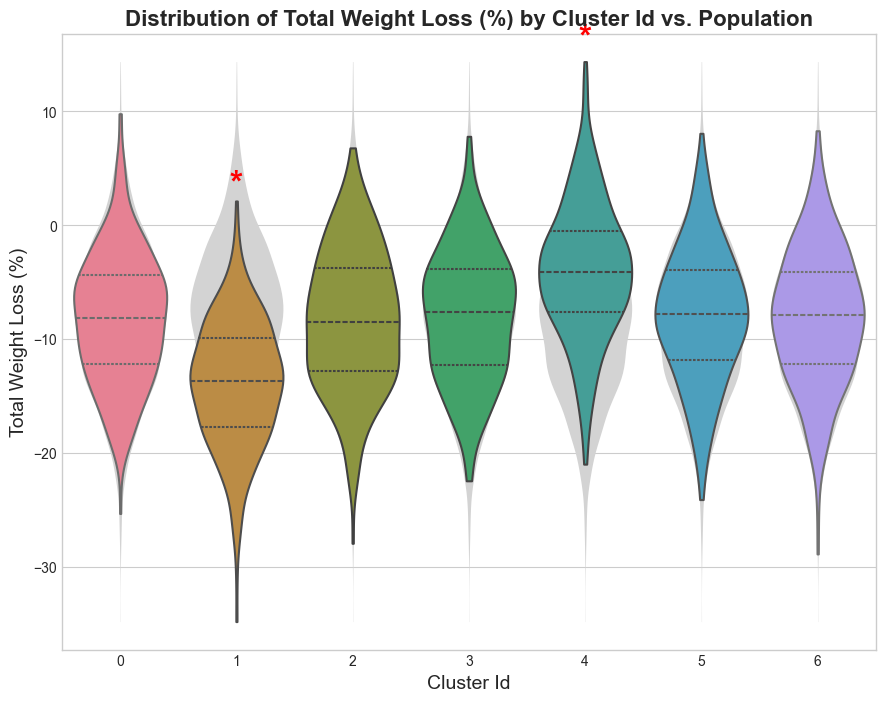

In [ ]:
# =============================================================================
# MODULE: DESCRIPTIVE_VISUALIZATIONS.PY
# VERSION: 2.0 (Comprehensive Refactor)
#
# DESCRIPTION:
# A generalized, reusable, and publication-ready library for creating a
# wide range of descriptive visualizations for clinical and research data.
# This module serves as a "Swiss Army knife" for population-level and
# cluster-based analyses, including violin, bar, forest, and lollipop plots.
#
# KEY PRINCIPLES:
# 1.  Separation of Concerns: Plotting functions ONLY plot. Data preparation and
#     statistical tests are performed externally and results are passed in.
# 2.  Reusability & Generality: Functions are designed to be generic and
#     flexible for a wide range of use cases.
# 3.  Publication-Ready: Automatically uses human-readable names, professional
#     styling, and saves high-quality figures to a standardized directory.
#
# AUTHOR:
# Refactored and consolidated by your AI Supervisor.
# =============================================================================

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional, Any, Union

# --- CONFIGURATION & SETUP ---

OUTPUT_DIR = "outputs/descriptive_visualizations"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define a professional color palette
DEFAULT_PALETTE = sns.color_palette("husl", 8)
POPULATION_COLOR = 'lightgrey'

# Embedded dictionary of human-readable names
NICE_NAMES_MAP = {
    "baseline_bmi": "Baseline BMI (kg/m²)",
    "baseline_weight_kg": "Baseline Weight (kg)",
    "total_follow_up_days": "Total Follow-up (days)",
    "total_wl": "Total Weight Loss (%)",
    "dropout_60d": "60-Day Dropout",
    "achieved_10pct_wl": "Achieved 10% Weight Loss",
    "time_to_10pct_wl": "Days to 10% Weight Loss",
    "womens_health_and_pregnancy": "Women's Health & Pregnancy",
    "mental_health": "Mental Health",
    "family_issues": "Family Issues",
    "medication_disease_injury": "Medication, Disease, or Injury",
    "physical_inactivity": "Physical Inactivity",
    "eating_habits": "Eating Habits",
    "schedule": "Schedule",
    "smoking_cessation": "Smoking Cessation",
    "treatment_discontinuation_or_relapse": "Treatment Relapse",
    "pandemic": "Pandemic",
    "lifestyle_circumstances": "Lifestyle Circumstances",
    "none_of_the_above": "None of the Above"
}

# --- HELPER FUNCTIONS ---

def get_nice_name(variable: str, name_map: Dict[str, str] = NICE_NAMES_MAP) -> str:
    """Returns the human-readable name for a variable, or a formatted default."""
    return name_map.get(variable, variable.replace('_', ' ').title())

def _annotate_significance(ax: plt.Axes, x: float, y: float, p_value: float, alpha: float = 0.05):
    """Helper to add a significance asterisk to a plot."""
    if p_value < alpha:
        ax.text(x, y, '*', ha='center', va='bottom', fontsize=24, color='red', weight='bold')

# =============================================================================
# CORE VISUALIZATION FUNCTIONS
# =============================================================================

def plot_distribution_comparison(
    df: pd.DataFrame,
    variable: str,
    group_col: str,
    output_filename: str,
    compare_to_population: bool = False,
    significance_map: Optional[Dict[Any, float]] = None,
    alpha: float = 0.05
):
    """
    Creates and saves a violin plot comparing distributions of a continuous variable
    across different groups. Can operate in two modes: multi-group comparison or
    cluster-vs-population split view.

    Args:
        df (pd.DataFrame): DataFrame containing all data.
        variable (str): The continuous variable to plot.
        group_col (str): The column defining the groups (e.g., 'cluster_id', 'wgc').
        output_filename (str): Filename for the saved plot.
        compare_to_population (bool): If True, creates a split-violin plot comparing
            each group to the total population. If False, creates standard violin plots
            for inter-group comparison. Defaults to False.
        significance_map (Optional[Dict]): A map from group label to its p-value for annotation.
        alpha (float): The significance threshold for marking with an asterisk.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    groups = sorted(df[group_col].unique())
    n_groups = len(groups)
    fig, ax = plt.subplots(figsize=(max(8, n_groups * 1.5), 8))

    nice_variable_name = get_nice_name(variable)
    title = f'Distribution of {nice_variable_name} by {get_nice_name(group_col)}'

    if compare_to_population:
        title += " vs. Population"
        # Create a split-violin plot
        population_data = df[variable].dropna()
        for i, group in enumerate(groups):
            group_data = df[df[group_col] == group][variable].dropna()
            # Left half: Population
            sns.violinplot(y=population_data, x=np.full(len(population_data), i),
                           ax=ax, color=POPULATION_COLOR, inner=None, cut=0, scale='width', linewidth=0)
            # Right half: Group
            sns.violinplot(y=group_data, x=np.full(len(group_data), i),
                           ax=ax, color=DEFAULT_PALETTE[i % len(DEFAULT_PALETTE)], inner='quartile', cut=0, scale='width', linewidth=1.5)
            if significance_map:
                _annotate_significance(ax, i, group_data.max() * 1.05, significance_map.get(group, 1.0), alpha)
        ax.set_xticklabels([get_nice_name(str(g)) for g in groups])
    else:
        # Create standard violin plots for group-to-group comparison
        sns.violinplot(x=group_col, y=variable, data=df, order=groups, palette=DEFAULT_PALETTE, inner='quartile', cut=0)
        if significance_map: # For omnibus test
             _annotate_significance(ax, 0.5, df[variable].max() * 1.1, significance_map.get('omnibus', 1.0), alpha)
        ax.set_xticklabels([get_nice_name(str(g)) for g in groups])

    ax.set_title(title, fontsize=16, weight='bold')
    ax.set_ylabel(nice_variable_name, fontsize=14)
    ax.set_xlabel(get_nice_name(group_col), fontsize=14)
    ax.tick_params(axis='x', rotation=45, ha='right')

    output_path = os.path.join(OUTPUT_DIR, output_filename)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ Distribution plot saved to: {output_path}")

def plot_proportion_comparison(
    df: pd.DataFrame,
    variable: str,
    group_col: str,
    output_filename: str,
    significance_map: Optional[Dict[Any, float]] = None,
    alpha: float = 0.05
):
    """
    Creates and saves a bar chart comparing proportions of a binary variable
    across groups, with a reference line for the overall population proportion.

    Args:
        df (pd.DataFrame): DataFrame containing all data.
        variable (str): The binary (0/1) variable to plot.
        group_col (str): The column defining the groups.
        output_filename (str): Filename for the saved plot.
        significance_map (Optional[Dict]): Map from group label to p-value for annotation.
        alpha (float): Significance threshold.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    groups = sorted(df[group_col].unique())
    n_groups = len(groups)
    fig, ax = plt.subplots(figsize=(max(8, n_groups * 1.2), 7))

    population_proportion = df[variable].mean()
    group_proportions = df.groupby(group_col)[variable].mean().reindex(groups)

    sns.barplot(x=group_proportions.index, y=group_proportions.values, palette=DEFAULT_PALETTE, ax=ax)
    ax.axhline(y=population_proportion, color='black', linestyle='--', linewidth=2, label=f'Population Average ({population_proportion:.1%})')

    if significance_map:
        for i, group in enumerate(groups):
            p_value = significance_map.get(group, 1.0)
            bar_height = group_proportions.loc[group]
            _annotate_significance(ax, i, bar_height + 0.02, p_value, alpha)

    nice_variable_name = get_nice_name(variable)
    ax.set_title(f'Proportion of {nice_variable_name} by {get_nice_name(group_col)}', fontsize=16, weight='bold')
    ax.set_ylabel(f'Proportion ({nice_variable_name})', fontsize=14)
    ax.set_xlabel(get_nice_name(group_col), fontsize=14)
    ax.set_xticklabels([get_nice_name(str(g)) for g in groups], rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.legend()

    output_path = os.path.join(OUTPUT_DIR, output_filename)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ Proportion plot saved to: {output_path}")

def plot_forest(
    results_df: pd.DataFrame,
    effect_col: str,
    ci_lower_col: str,
    ci_upper_col: str,
    label_col: str,
    output_filename: str,
    reference_line: float = 1.0,
    use_log_scale: bool = True
):
    """
    Creates and saves a forest plot for effect sizes (e.g., Risk Ratios).

    Args:
        results_df (pd.DataFrame): DataFrame with effect sizes and CIs. Must be sorted.
        effect_col (str): Column name for the point estimate.
        ci_lower_col (str): Column for the lower confidence interval.
        ci_upper_col (str): Column for the upper confidence interval.
        label_col (str): Column with labels for the y-axis.
        output_filename (str): Filename for the saved plot.
        reference_line (float): Value for the line of no effect (1.0 for ratios, 0.0 for diffs).
        use_log_scale (bool): Whether to use a log scale for the x-axis.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, max(6, len(results_df) * 0.4)))

    y_pos = np.arange(len(results_df))
    errors = [results_df[effect_col] - results_df[ci_lower_col], results_df[ci_upper_col] - results_df[effect_col]]

    ax.errorbar(x=results_df[effect_col], y=y_pos, xerr=errors, fmt='o',
                color='black', ecolor='black', elinewidth=1, capsize=5)
    ax.axvline(x=reference_line, color='red', linestyle='--')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(results_df[label_col])
    ax.invert_yaxis()  # Puts top item at top

    if use_log_scale:
        ax.set_xscale('log')

    ax.set_title(f'Forest Plot of {get_nice_name(effect_col)}', fontsize=16, weight='bold')
    ax.set_xlabel(get_nice_name(effect_col), fontsize=14)
    ax.set_ylabel(get_nice_name(label_col), fontsize=14)

    output_path = os.path.join(OUTPUT_DIR, output_filename)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ Forest plot saved to: {output_path}")

def plot_lollipop(
    df: pd.DataFrame,
    variable: str,
    group_col: str,
    output_filename: str,
    reference_group: Any,
    significance_map: Optional[Dict[Any, float]] = None,
    alpha: float = 0.05
):
    """
    Creates and saves a lollipop plot showing the deviation of group means from a reference mean.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        variable (str): The continuous variable to plot.
        group_col (str): Column defining the groups.
        output_filename (str): Filename for the saved plot.
        reference_group (Any): The specific group label to use as the reference.
        significance_map (Optional[Dict]): Map from group label to p-value for annotation.
        alpha (float): Significance threshold.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, max(6, df[group_col].nunique() * 0.5)))

    mean_values = df.groupby(group_col)[variable].mean()
    reference_mean = mean_values.loc[reference_group]
    deviations = mean_values - reference_mean
    deviations = deviations.drop(reference_group).sort_values()

    ax.hlines(y=deviations.index.map(str).map(get_nice_name), xmin=0, xmax=deviations,
              color=np.where(deviations < 0, 'skyblue', 'salmon'), alpha=0.7, linewidth=3)
    ax.scatter(deviations, deviations.index.map(str).map(get_nice_name),
               color=np.where(deviations < 0, 'blue', 'red'), s=100, alpha=0.9, zorder=3)

    if significance_map:
        for group, deviation in deviations.items():
            p_value = significance_map.get(group, 1.0)
            if p_value < alpha:
                ax.text(deviation, get_nice_name(str(group)), ' *', color='red',
                        va='center', ha='left' if deviation > 0 else 'right', weight='bold')

    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    ax.set_title(f'Deviation from {get_nice_name(str(reference_group))} Mean for {get_nice_name(variable)}', fontsize=16, weight='bold')
    ax.set_xlabel(f'Difference in Mean {get_nice_name(variable)}', fontsize=14)
    ax.set_ylabel(get_nice_name(group_col), fontsize=14)

    output_path = os.path.join(OUTPUT_DIR, output_filename)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ Lollipop plot saved to: {output_path}")


#### Spaghetti plots of weight loss trajectory

##### with mean followup: 

ideas/concepts: 
- plotting mean population trajectories, adding it to the overlay too - panel 9 
- make params adjustable, like do i put the smoothed curves, etc, no? 
- document

new

🚀 STARTING ANALYSIS V5
Loading cluster labels...
Loading measurements...
Calculating days from baseline...
Merging data...

--- Generating Plot 1: Smoothed & Length-Adjusted (Full Timespan) ---


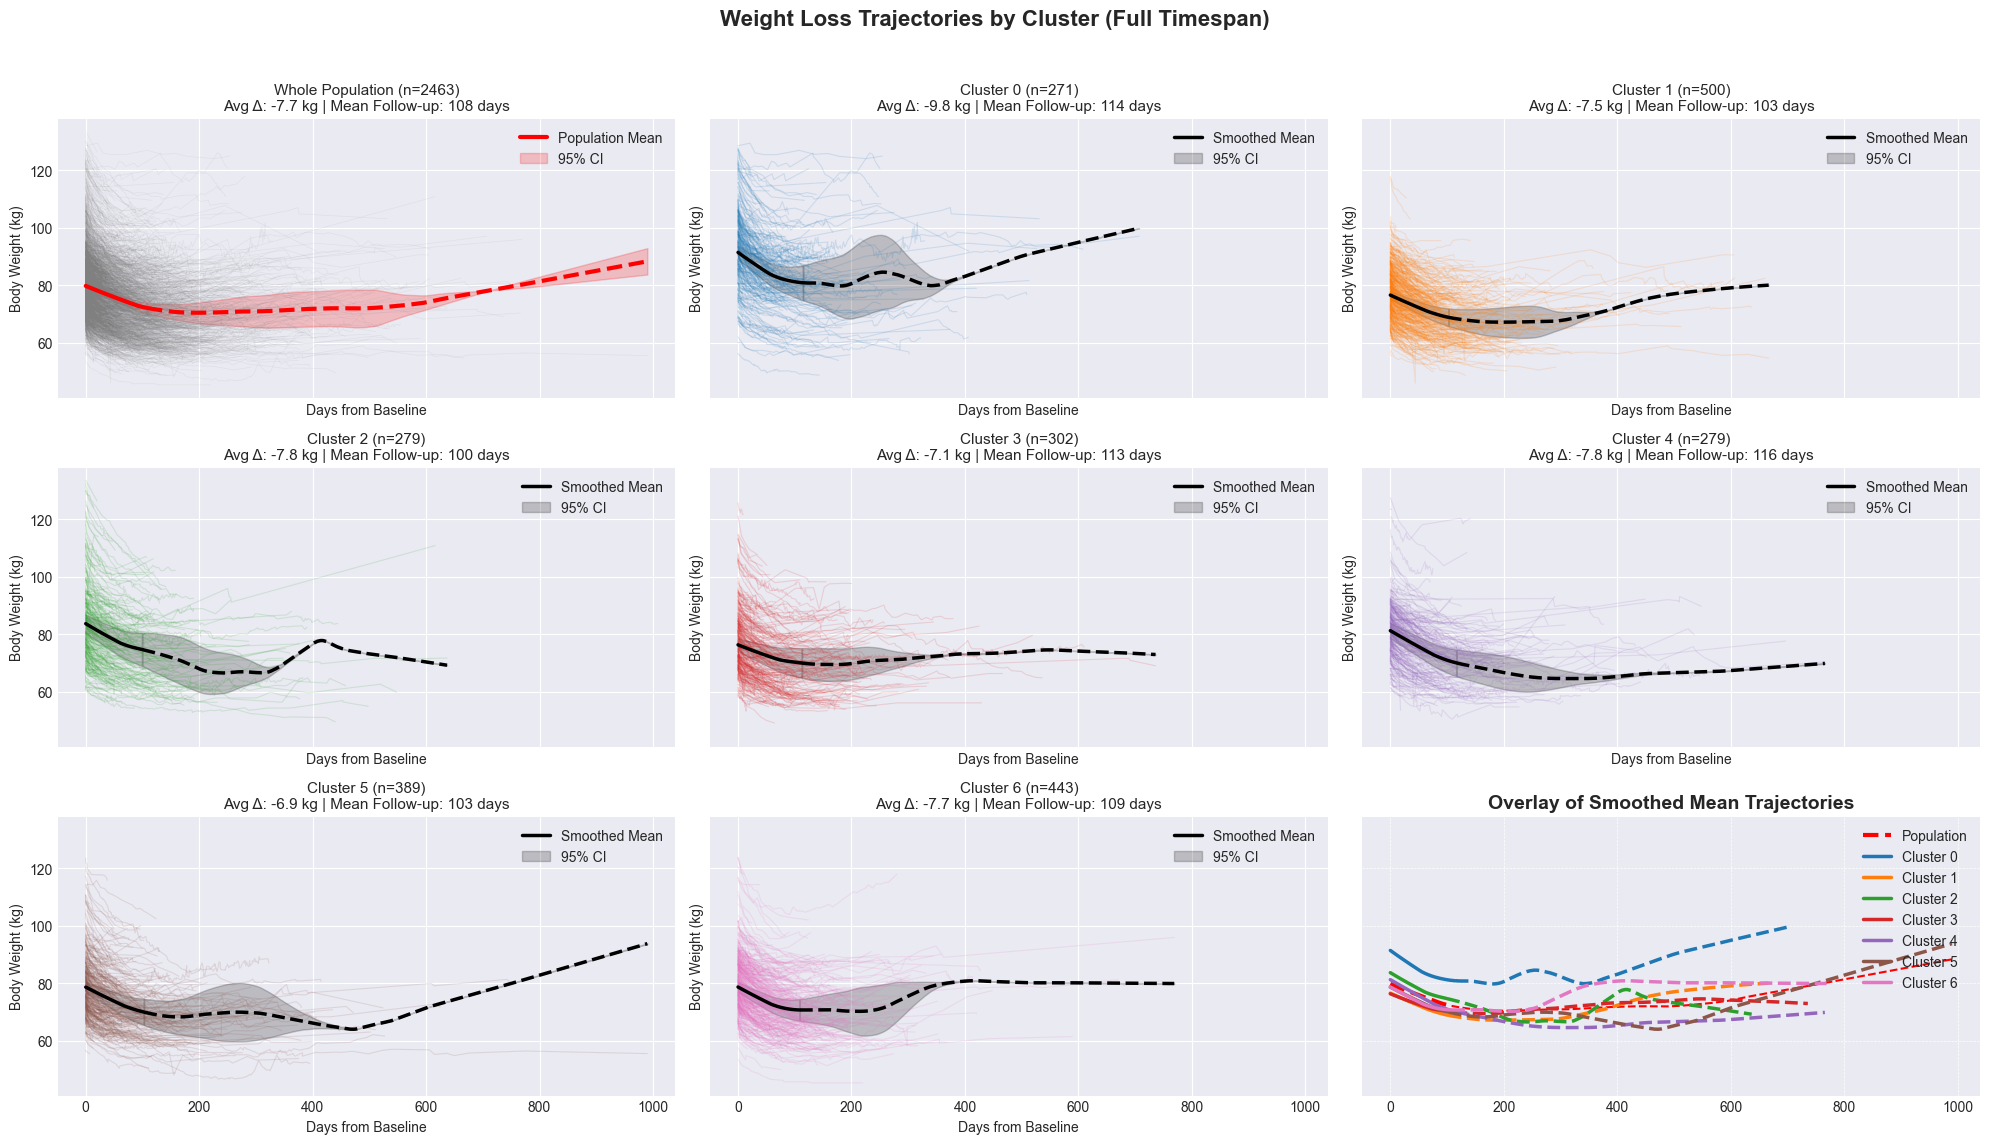


--- Generating Plot 2: Smoothed & Length-Adjusted (Cutoff) ---

Creating dataset for 365-day cutoff analysis...


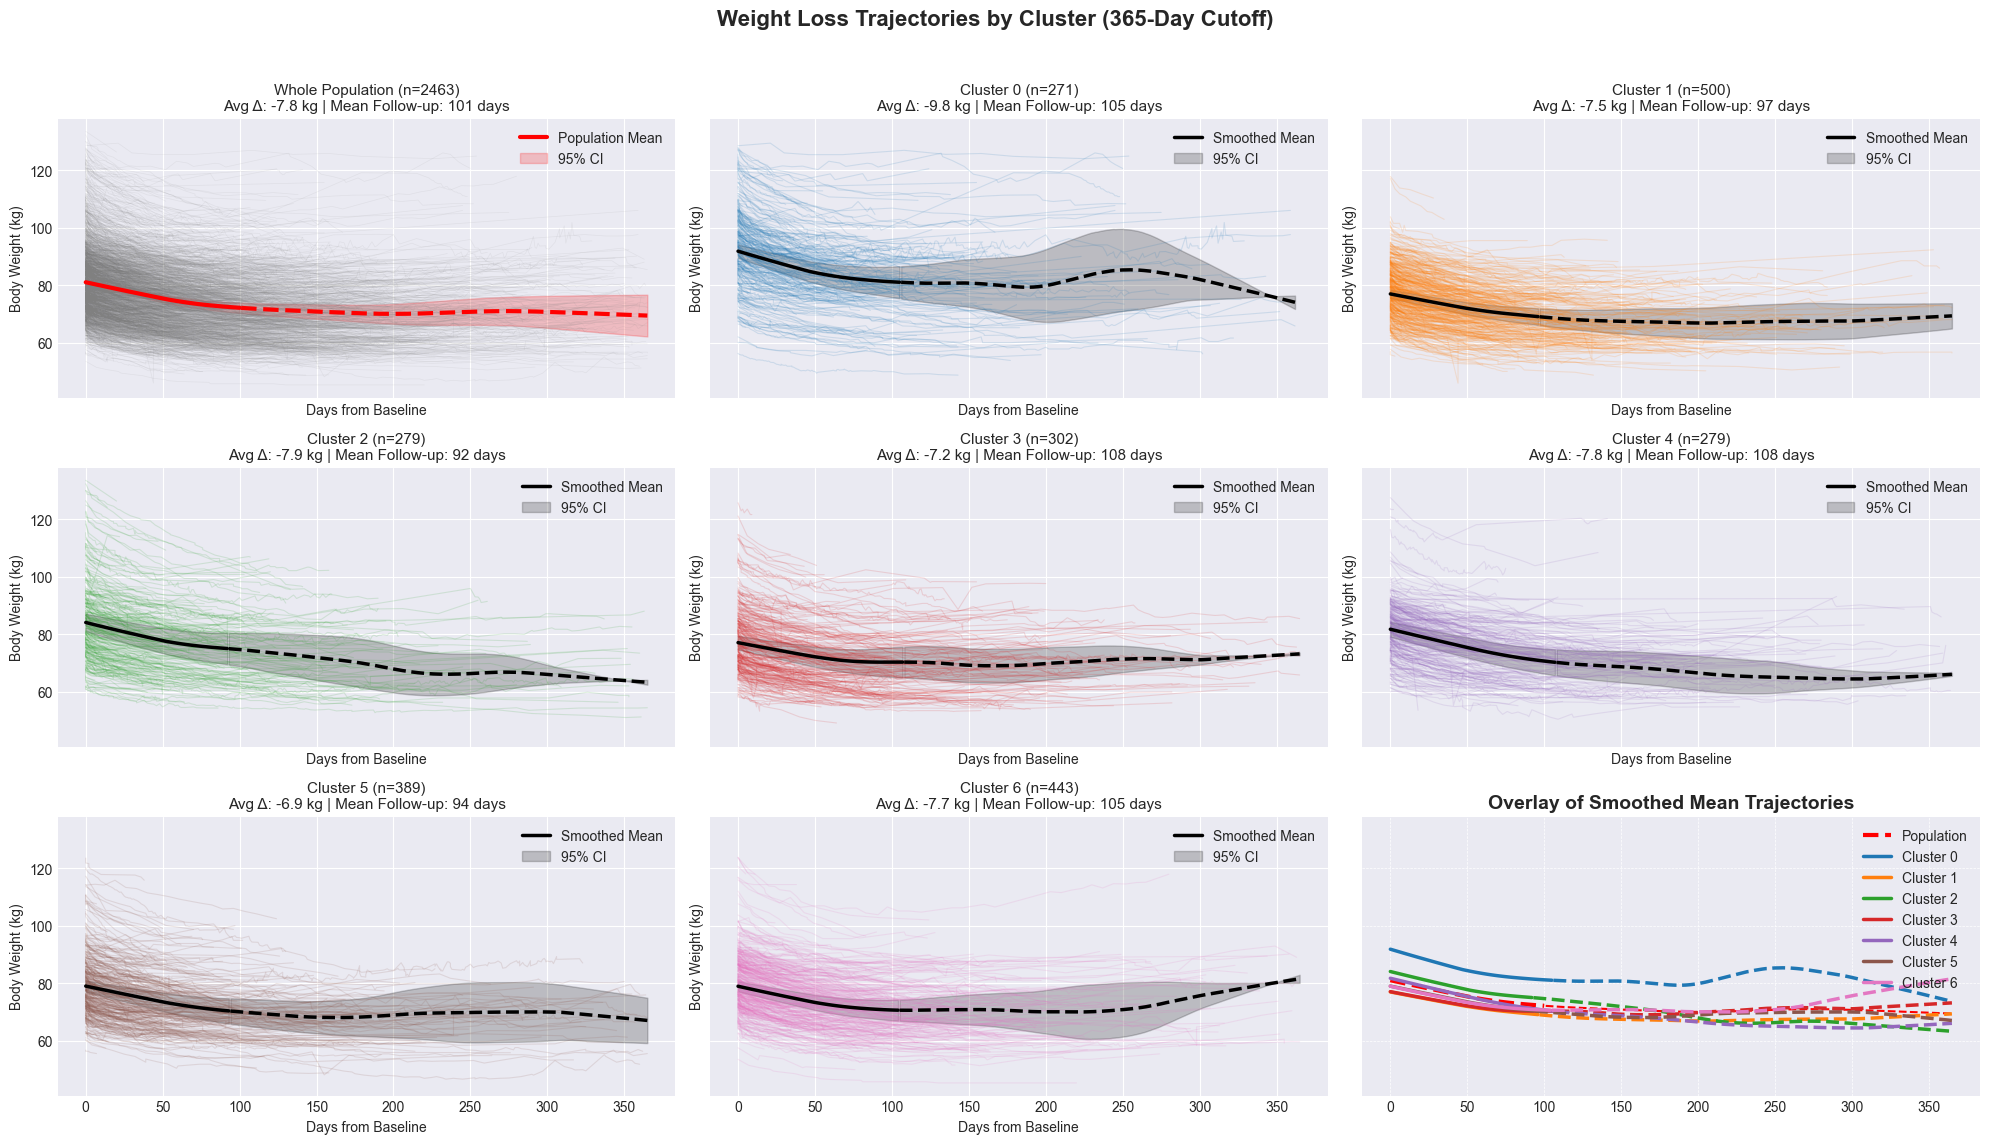


✅ ANALYSIS COMPLETE!


In [9]:
# =============================================================================
# CLUSTER-BASED SPAGHETTI PLOT PIPELINE V5 - LENGTH-ADJUSTED & PUBLICATION READY
# =============================================================================
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import statsmodels.api as sm

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# =============================================================================
# 1. CONFIGURATION SECTION
# =============================================================================
# --- FILE PATHS ---
# Both databases are in the dbs directory (relative to project root)
CLUSTER_DB_NAME = "../dbs/pnk_db2_p2_cluster_pam_goldstd.sqlite"
MEASUREMENTS_DB_NAME = "../dbs/pnk_db2_p2_in.sqlite"

# --- ANALYSIS PARAMETERS ---
CLUSTERING_ALGORITHM = "pam"
N_CLUSTERS = 7
CUTOFF_DAYS = 365  # Updated to 365 days

# --- DATABASE & COLUMN NAMES ---
CLUSTER_TABLE_NAME = "clust_labels_bl_nobc_bw_pam_goldstd"
MEASUREMENTS_TABLE_NAME = "measurements_p2"
PATIENT_ID_COL = "patient_id"
MEDICAL_RECORD_ID_COL = "medical_record_id"
MEASUREMENT_DATE_COL = "measurement_date"
BODY_WEIGHT_COL = "weight_kg"

# --- PLOT & MODELING CONFIG ---
FIGURE_SIZE = (20, 12)
SMOOTHING_FRAC = 0.3
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
CLUSTER_COLUMN = f"{CLUSTERING_ALGORITHM}_k{N_CLUSTERS}"
CLUSTER_DB_PATH = CLUSTER_DB_NAME
MEASUREMENTS_DB_PATH = MEASUREMENTS_DB_NAME

# =============================================================================
# 2. DATA LOADING & PROCESSING FUNCTIONS
# =============================================================================
def load_cluster_labels():
    print("Loading cluster labels...")
    query = f"SELECT {PATIENT_ID_COL}, {MEDICAL_RECORD_ID_COL}, {CLUSTER_COLUMN} as cluster_id FROM {CLUSTER_TABLE_NAME} WHERE {CLUSTER_COLUMN} IS NOT NULL"
    try:
        with sqlite3.connect(CLUSTER_DB_PATH) as conn: 
            return pd.read_sql_query(query, conn)
    except Exception as e: 
        print(f"❌ Error: {e}"); return None

def load_measurements_for_patients(cluster_labels):
    print("Loading measurements...")
    if cluster_labels is None or cluster_labels.empty: 
        return None
    try:
        with sqlite3.connect(MEASUREMENTS_DB_PATH) as conn:
            cluster_labels.to_sql('temp_cluster_patients', conn, if_exists='replace', index=False)
            query = f"""SELECT m.{PATIENT_ID_COL}, m.{MEDICAL_RECORD_ID_COL}, m.{MEASUREMENT_DATE_COL}, m.{BODY_WEIGHT_COL} 
                       FROM {MEASUREMENTS_TABLE_NAME} m 
                       JOIN temp_cluster_patients tcp ON m.{PATIENT_ID_COL} = tcp.{PATIENT_ID_COL} 
                       AND m.{MEDICAL_RECORD_ID_COL} = tcp.{MEDICAL_RECORD_ID_COL} 
                       ORDER BY m.{PATIENT_ID_COL}, m.{MEDICAL_RECORD_ID_COL}, m.{MEASUREMENT_DATE_COL}"""
            return pd.read_sql_query(query, conn)
    except Exception as e: 
        print(f"❌ Error: {e}"); return None

def calculate_days_from_baseline(df):
    print("Calculating days from baseline...")
    if df is None or df.empty: 
        return None
    df[MEASUREMENT_DATE_COL] = pd.to_datetime(df[MEASUREMENT_DATE_COL])
    df['days_from_baseline'] = df.groupby([PATIENT_ID_COL, MEDICAL_RECORD_ID_COL])[MEASUREMENT_DATE_COL].transform(
        lambda x: (x - x.min()).dt.days)
    return df

def merge_with_clusters(measurements_with_baseline, cluster_labels):
    print("Merging data...")
    if measurements_with_baseline is None or cluster_labels is None: 
        return None
    return pd.merge(measurements_with_baseline, cluster_labels, on=[PATIENT_ID_COL, MEDICAL_RECORD_ID_COL], how='inner')

def create_fixed_time_cutoff_data(df, cutoff):
    print(f"\nCreating dataset for {cutoff}-day cutoff analysis...")
    return df[df['days_from_baseline'] <= cutoff].copy()

# =============================================================================
# 3. VISUALIZATION FUNCTIONS (Upgraded for V5)
# =============================================================================
def plot_whole_population(ax, analysis_data):
    """Plots whole population trajectories in the first panel."""
    n_trajectories = analysis_data[[PATIENT_ID_COL, MEDICAL_RECORD_ID_COL]].nunique().max()
    
    # Plot individual trajectories
    for _, group in analysis_data.groupby([PATIENT_ID_COL, MEDICAL_RECORD_ID_COL]):
        ax.plot(group['days_from_baseline'], group[BODY_WEIGHT_COL], 
                alpha=0.1, linewidth=0.5, color='gray')
    
    # Calculate population statistics
    followup_times = analysis_data.groupby([PATIENT_ID_COL, MEDICAL_RECORD_ID_COL])['days_from_baseline'].max()
    mean_followup = followup_times.mean()
    
    deltas = analysis_data.groupby([PATIENT_ID_COL, MEDICAL_RECORD_ID_COL])[BODY_WEIGHT_COL].apply(
        lambda x: x.iloc[-1] - x.iloc[0] if len(x) > 1 else 0)
    avg_delta = deltas.mean()
    
    # Calculate and plot smoothed mean
    daily_stats = analysis_data.groupby('days_from_baseline')[BODY_WEIGHT_COL].agg(['mean', 'count', 'std']).reset_index()
    daily_stats['sem'] = daily_stats['std'] / np.sqrt(daily_stats['count'])
    
    if len(daily_stats) > 3:
        smoothed = sm.nonparametric.lowess(daily_stats['mean'], daily_stats['days_from_baseline'], 
                                         frac=SMOOTHING_FRAC, return_sorted=True)
        sem_smooth_full = sm.nonparametric.lowess(daily_stats['sem'].fillna(0), daily_stats['days_from_baseline'], 
                                                frac=SMOOTHING_FRAC, return_sorted=False)
        
        # Plot solid line until mean follow-up, then dashed
        mask_solid = smoothed[:, 0] <= mean_followup
        mask_dashed = smoothed[:, 0] > mean_followup
        
        x_solid = smoothed[:, 0][mask_solid]
        y_solid = smoothed[:, 1][mask_solid]
        sem_solid = sem_smooth_full[mask_solid]
        
        x_dashed = smoothed[:, 0][mask_dashed]
        y_dashed = smoothed[:, 1][mask_dashed]
        sem_dashed = sem_smooth_full[mask_dashed]
        
        # Plot solid portion
        ax.plot(x_solid, y_solid, color='red', linewidth=3, label='Population Mean')
        ax.fill_between(x_solid, y_solid - 1.96 * sem_solid, y_solid + 1.96 * sem_solid, 
                       color='red', alpha=0.2, label='95% CI')
        
        # Plot dashed portion
        if len(x_dashed) > 0:
            ax.plot(x_dashed, y_dashed, color='red', linewidth=3, linestyle='--')
            ax.fill_between(x_dashed, y_dashed - 1.96 * sem_dashed, y_dashed + 1.96 * sem_dashed, 
                           color='red', alpha=0.2)
    
    ax.set_title(f'Whole Population (n={n_trajectories})\nAvg Δ: {avg_delta:.1f} kg | Mean Follow-up: {mean_followup:.0f} days', 
                fontsize=11)
    ax.set_xlabel('Days from Baseline')
    ax.set_ylabel('Body Weight (kg)')
    ax.legend(loc='upper right')
    
    return mean_followup, smoothed, sem_smooth_full

def plot_single_cluster_length_adjusted(ax, cluster_data, cluster_id):
    """Plots trajectories and a length-adjusted smoothed mean."""
    n_trajectories = cluster_data[[PATIENT_ID_COL, MEDICAL_RECORD_ID_COL]].nunique().max()
    
    for _, group in cluster_data.groupby([PATIENT_ID_COL, MEDICAL_RECORD_ID_COL]):
        ax.plot(group['days_from_baseline'], group[BODY_WEIGHT_COL], 
                alpha=0.15, linewidth=0.8, color=COLORS[cluster_id % len(COLORS)])
    
    # Calculate mean follow-up and robust average delta
    followup_times = cluster_data.groupby([PATIENT_ID_COL, MEDICAL_RECORD_ID_COL])['days_from_baseline'].max()
    mean_followup = followup_times.mean()
    
    deltas = cluster_data.groupby([PATIENT_ID_COL, MEDICAL_RECORD_ID_COL])[BODY_WEIGHT_COL].apply(
        lambda x: x.iloc[-1] - x.iloc[0] if len(x) > 1 else 0)
    avg_delta = deltas.mean()
    
    daily_stats = cluster_data.groupby('days_from_baseline')[BODY_WEIGHT_COL].agg(['mean', 'count', 'std']).reset_index()
    daily_stats['sem'] = daily_stats['std'] / np.sqrt(daily_stats['count'])
    
    if len(daily_stats) > 3:
        smoothed = sm.nonparametric.lowess(daily_stats['mean'], daily_stats['days_from_baseline'], 
                                         frac=SMOOTHING_FRAC, return_sorted=True)
        sem_smooth_full = sm.nonparametric.lowess(daily_stats['sem'].fillna(0), daily_stats['days_from_baseline'], 
                                                frac=SMOOTHING_FRAC, return_sorted=False)
        
        # FIXED: Plot solid line until mean follow-up, then dashed
        mask_solid = smoothed[:, 0] <= mean_followup
        mask_dashed = smoothed[:, 0] > mean_followup
        
        x_solid = smoothed[:, 0][mask_solid]
        y_solid = smoothed[:, 1][mask_solid]
        sem_solid = sem_smooth_full[mask_solid]
        
        x_dashed = smoothed[:, 0][mask_dashed]
        y_dashed = smoothed[:, 1][mask_dashed]
        sem_dashed = sem_smooth_full[mask_dashed]
        
        # Plot solid portion
        ax.plot(x_solid, y_solid, color='black', linewidth=2.5, label='Smoothed Mean')
        ax.fill_between(x_solid, y_solid - 1.96 * sem_solid, y_solid + 1.96 * sem_solid, 
                       color='black', alpha=0.2, label='95% CI')
        
        # Plot dashed portion
        if len(x_dashed) > 0:
            ax.plot(x_dashed, y_dashed, color='black', linewidth=2.5, linestyle='--')
            ax.fill_between(x_dashed, y_dashed - 1.96 * sem_dashed, y_dashed + 1.96 * sem_dashed, 
                           color='black', alpha=0.2)
    
    ax.set_title(f'Cluster {cluster_id} (n={n_trajectories})\nAvg Δ: {avg_delta:.1f} kg | Mean Follow-up: {mean_followup:.0f} days', 
                fontsize=11)
    ax.set_xlabel('Days from Baseline')
    ax.set_ylabel('Body Weight (kg)')
    ax.legend(loc='upper right')
    
    return mean_followup

def create_spaghetti_plots_with_overlay(analysis_data, title_suffix=""):
    """Main plotting function with automated, length-adjusted overlay panel."""
    clusters = sorted(analysis_data['cluster_id'].unique())
    n_panels = len(clusters) + 2  # +1 for population, +1 for overlay
    n_cols = min(3, len(clusters) + 1)
    n_rows = int(np.ceil(n_panels / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(FIGURE_SIZE[0], (FIGURE_SIZE[1]/3)*n_rows), 
                            sharey=True, sharex=True, squeeze=False)
    axes_flat = axes.flatten()
    
    # Plot whole population in first panel
    pop_mean_followup, pop_smoothed, pop_sem = plot_whole_population(axes_flat[0], analysis_data)
    
    mean_followups = {}
    
    # Plot individual cluster panels
    for i, cluster_id in enumerate(clusters):
        mean_followups[cluster_id] = plot_single_cluster_length_adjusted(
            axes_flat[i+1], analysis_data[analysis_data['cluster_id'] == cluster_id], cluster_id)
    
    # Create the overlay plot
    overlay_ax = axes_flat[len(clusters) + 1]
    overlay_ax.set_title("Overlay of Smoothed Mean Trajectories", fontsize=14, fontweight='bold')
    
    # Add population trajectory as red dashed line
    mask_solid_pop = pop_smoothed[:, 0] <= pop_mean_followup
    mask_dashed_pop = pop_smoothed[:, 0] > pop_mean_followup
    
    x_solid_pop = pop_smoothed[:, 0][mask_solid_pop]
    y_solid_pop = pop_smoothed[:, 1][mask_solid_pop]
    x_dashed_pop = pop_smoothed[:, 0][mask_dashed_pop]
    y_dashed_pop = pop_smoothed[:, 1][mask_dashed_pop]
    
    # Plot population line (thick solid, then thin dashed)
    overlay_ax.plot(x_solid_pop, y_solid_pop, color='red', linewidth=3, linestyle='--', label='Population')
    if len(x_dashed_pop) > 0:
        overlay_ax.plot(x_dashed_pop, y_dashed_pop, color='red', linewidth=1.5, linestyle='--')
    
    # Plot cluster trajectories with dashed lines after mean follow-up
    for cluster_id in clusters:
        cluster_data = analysis_data[analysis_data['cluster_id'] == cluster_id]
        daily_stats = cluster_data.groupby('days_from_baseline')[BODY_WEIGHT_COL].agg(['mean']).reset_index()
        
        if len(daily_stats) > 3:
            smoothed = sm.nonparametric.lowess(daily_stats['mean'], daily_stats['days_from_baseline'], 
                                             frac=SMOOTHING_FRAC, return_sorted=True)
            
            # Split into solid and dashed portions based on mean follow-up
            mask_solid = smoothed[:, 0] <= mean_followups[cluster_id]
            mask_dashed = smoothed[:, 0] > mean_followups[cluster_id]
            
            x_solid = smoothed[:, 0][mask_solid]
            y_solid = smoothed[:, 1][mask_solid]
            x_dashed = smoothed[:, 0][mask_dashed]
            y_dashed = smoothed[:, 1][mask_dashed]
            
            # Plot solid portion
            overlay_ax.plot(x_solid, y_solid, color=COLORS[cluster_id % len(COLORS)], 
                           linewidth=2.5, label=f'Cluster {cluster_id}')
            
            # Plot dashed portion
            if len(x_dashed) > 0:
                overlay_ax.plot(x_dashed, y_dashed, color=COLORS[cluster_id % len(COLORS)], 
                               linewidth=2.5, linestyle='--')
    
    overlay_ax.legend(loc='best')
    overlay_ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Hide unused panels
    for i in range(len(clusters) + 2, len(axes_flat)): 
        axes_flat[i].set_visible(False)
    
    fig.suptitle(f'Weight Loss Trajectories by Cluster {title_suffix}', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    return fig

# =============================================================================
# 4. MAIN EXECUTION PIPELINE
# =============================================================================
def run_analysis():
    print("🚀 STARTING ANALYSIS V5")
    labels = load_cluster_labels()
    measurements = load_measurements_for_patients(labels)
    df_baseline = calculate_days_from_baseline(measurements)
    analysis_data = merge_with_clusters(df_baseline, labels)
    
    if analysis_data is None or analysis_data.empty: 
        print("❌ Analysis stopped."); return
    
    print("\n--- Generating Plot 1: Smoothed & Length-Adjusted (Full Timespan) ---")
    fig1 = create_spaghetti_plots_with_overlay(analysis_data, title_suffix="(Full Timespan)")
    plt.show()
    
    print("\n--- Generating Plot 2: Smoothed & Length-Adjusted (Cutoff) ---")
    analysis_data_cutoff = create_fixed_time_cutoff_data(analysis_data, cutoff=CUTOFF_DAYS)
    fig2 = create_spaghetti_plots_with_overlay(analysis_data_cutoff, title_suffix=f"({CUTOFF_DAYS}-Day Cutoff)")
    plt.show()
    
    print("\n✅ ANALYSIS COMPLETE!")

# =============================================================================
# 5. EXECUTION
# =============================================================================
run_analysis()


prev

In [2]:
# =============================================================================
# CLUSTER-BASED SPAGHETTI PLOT PIPELINE V5 - LENGTH-ADJUSTED & PUBLICATION READY
# =============================================================================

import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# =============================================================================
# 1. CONFIGURATION SECTION
# =============================================================================

# --- FILE PATHS ---
WORKING_DIR = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\paper2_dir"
CLUSTER_DB_NAME = "pnk_db2_p2_cluster_pam_goldstd.sqlite"
MEASUREMENTS_DB_NAME = "pnk_db2_p2_in.sqlite"

# --- ANALYSIS PARAMETERS ---
CLUSTERING_ALGORITHM = "pam"
N_CLUSTERS = 7
CUTOFF_DAYS = 400

# --- DATABASE & COLUMN NAMES ---
CLUSTER_TABLE_NAME = "clust_labels_bl_nobc_bw_pam_goldstd"
MEASUREMENTS_TABLE_NAME = "measurements_p2"
PATIENT_ID_COL = "patient_id"
MEDICAL_RECORD_ID_COL = "medical_record_id"
MEASUREMENT_DATE_COL = "measurement_date"
BODY_WEIGHT_COL = "weight_kg"

# --- PLOT & MODELING CONFIG ---
FIGURE_SIZE = (20, 12)
SMOOTHING_FRAC = 0.3
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
CLUSTER_COLUMN = f"{CLUSTERING_ALGORITHM}_k{N_CLUSTERS}"
CLUSTER_DB_PATH = f"{WORKING_DIR}\\{CLUSTER_DB_NAME}"
MEASUREMENTS_DB_PATH = f"{WORKING_DIR}\\{MEASUREMENTS_DB_NAME}"

# =============================================================================
# 2. DATA LOADING & PROCESSING FUNCTIONS (Unchanged)
# =============================================================================
def load_cluster_labels():
    print("Loading cluster labels...")
    query = f"SELECT {PATIENT_ID_COL}, {MEDICAL_RECORD_ID_COL}, {CLUSTER_COLUMN} as cluster_id FROM {CLUSTER_TABLE_NAME} WHERE {CLUSTER_COLUMN} IS NOT NULL"
    try:
        with sqlite3.connect(CLUSTER_DB_PATH) as conn: return pd.read_sql_query(query, conn)
    except Exception as e: print(f"❌ Error: {e}"); return None

def load_measurements_for_patients(cluster_labels):
    print("Loading measurements...")
    if cluster_labels is None or cluster_labels.empty: return None
    try:
        with sqlite3.connect(MEASUREMENTS_DB_PATH) as conn:
            cluster_labels.to_sql('temp_cluster_patients', conn, if_exists='replace', index=False)
            query = f"SELECT m.{PATIENT_ID_COL}, m.{MEDICAL_RECORD_ID_COL}, m.{MEASUREMENT_DATE_COL}, m.{BODY_WEIGHT_COL} FROM {MEASUREMENTS_TABLE_NAME} m JOIN temp_cluster_patients tcp ON m.{PATIENT_ID_COL} = tcp.{PATIENT_ID_COL} AND m.{MEDICAL_RECORD_ID_COL} = tcp.{MEDICAL_RECORD_ID_COL} ORDER BY m.{PATIENT_ID_COL}, m.{MEDICAL_RECORD_ID_COL}, m.{MEASUREMENT_DATE_COL}"
            return pd.read_sql_query(query, conn)
    except Exception as e: print(f"❌ Error: {e}"); return None

def calculate_days_from_baseline(df):
    print("Calculating days from baseline...")
    if df is None or df.empty: return None
    df[MEASUREMENT_DATE_COL] = pd.to_datetime(df[MEASUREMENT_DATE_COL])
    df['days_from_baseline'] = df.groupby([PATIENT_ID_COL, MEDICAL_RECORD_ID_COL])[MEASUREMENT_DATE_COL].transform(lambda x: (x - x.min()).dt.days)
    return df

def merge_with_clusters(measurements_with_baseline, cluster_labels):
    print("Merging data...")
    if measurements_with_baseline is None or cluster_labels is None: return None
    return pd.merge(measurements_with_baseline, cluster_labels, on=[PATIENT_ID_COL, MEDICAL_RECORD_ID_COL], how='inner')

def create_fixed_time_cutoff_data(df, cutoff):
    print(f"\nCreating dataset for {cutoff}-day cutoff analysis...")
    return df[df['days_from_baseline'] <= cutoff].copy()

# =============================================================================
# 3. VISUALIZATION FUNCTIONS (Upgraded for V5)
# =============================================================================
def plot_single_cluster_length_adjusted(ax, cluster_data, cluster_id):
    """Plots trajectories and a length-adjusted smoothed mean."""
    n_trajectories = cluster_data[[PATIENT_ID_COL, MEDICAL_RECORD_ID_COL]].nunique().max()
    
    for _, group in cluster_data.groupby([PATIENT_ID_COL, MEDICAL_RECORD_ID_COL]):
        ax.plot(group['days_from_baseline'], group[BODY_WEIGHT_COL], alpha=0.15, linewidth=0.8, color=COLORS[cluster_id % len(COLORS)])

    # NEW: Calculate mean follow-up and robust average delta
    followup_times = cluster_data.groupby([PATIENT_ID_COL, MEDICAL_RECORD_ID_COL])['days_from_baseline'].max()
    mean_followup = followup_times.mean()
    deltas = cluster_data.groupby([PATIENT_ID_COL, MEDICAL_RECORD_ID_COL])[BODY_WEIGHT_COL].apply(lambda x: x.iloc[-1] - x.iloc[0] if len(x) > 1 else 0)
    avg_delta = deltas.mean()
    
    daily_stats = cluster_data.groupby('days_from_baseline')[BODY_WEIGHT_COL].agg(['mean', 'count', 'std']).reset_index()
    daily_stats['sem'] = daily_stats['std'] / np.sqrt(daily_stats['count'])
    
    if len(daily_stats) > 3:
        smoothed = sm.nonparametric.lowess(daily_stats['mean'], daily_stats['days_from_baseline'], frac=SMOOTHING_FRAC, return_sorted=True)
        sem_smooth_full = sm.nonparametric.lowess(daily_stats['sem'].fillna(0), daily_stats['days_from_baseline'], frac=SMOOTHING_FRAC, return_sorted=False)

        # NEW: Trim smoothed data to the mean follow-up length
        mask = smoothed[:, 0] <= mean_followup
        x_smooth = smoothed[:, 0][mask]
        y_smooth = smoothed[:, 1][mask]
        sem_smooth = sem_smooth_full[mask]
        
        ax.plot(x_smooth, y_smooth, color='black', linewidth=2.5, label='Smoothed Mean')
        ax.fill_between(x_smooth, y_smooth - 1.96 * sem_smooth, y_smooth + 1.96 * sem_smooth, color='black', alpha=0.2, label='95% CI')

    ax.set_title(f'Cluster {cluster_id} (n={n_trajectories})\nAvg Δ: {avg_delta:.1f} kg | Mean Follow-up: {mean_followup:.0f} days', fontsize=11)
    ax.set_xlabel('Days from Baseline'); ax.set_ylabel('Body Weight (kg)')
    ax.legend(loc='upper right')
    return mean_followup # Return for use in overlay

def create_spaghetti_plots_with_overlay(analysis_data, title_suffix=""):
    """Main plotting function with automated, length-adjusted overlay panel."""
    clusters = sorted(analysis_data['cluster_id'].unique())
    n_panels = len(clusters) + 1 
    n_cols = min(3, len(clusters)); n_rows = int(np.ceil(n_panels / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(FIGURE_SIZE[0], (FIGURE_SIZE[1]/3)*n_rows), sharey=True, sharex=True, squeeze=False)
    axes_flat = axes.flatten()
    
    mean_followups = {} # Store follow-up times for the overlay

    # Plot individual cluster panels
    for i, cluster_id in enumerate(clusters):
        mean_followups[cluster_id] = plot_single_cluster_length_adjusted(axes_flat[i], analysis_data[analysis_data['cluster_id'] == cluster_id], cluster_id)

    # Create the overlay plot
    overlay_ax = axes_flat[len(clusters)]
    overlay_ax.set_title("Overlay of Smoothed Mean Trajectories", fontsize=14, fontweight='bold')

    for cluster_id in clusters:
        cluster_data = analysis_data[analysis_data['cluster_id'] == cluster_id]
        daily_stats = cluster_data.groupby('days_from_baseline')[BODY_WEIGHT_COL].agg(['mean']).reset_index()
        if len(daily_stats) > 3:
            smoothed = sm.nonparametric.lowess(daily_stats['mean'], daily_stats['days_from_baseline'], frac=SMOOTHING_FRAC, return_sorted=True)
            
            # NEW: Trim overlay lines using stored mean follow-up times
            mask = smoothed[:, 0] <= mean_followups[cluster_id]
            x_smooth = smoothed[:, 0][mask]
            y_smooth = smoothed[:, 1][mask]

            overlay_ax.plot(x_smooth, y_smooth, color=COLORS[cluster_id % len(COLORS)], linewidth=2.5, label=f'Cluster {cluster_id}')
    
    overlay_ax.legend(loc='best'); overlay_ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    for i in range(len(clusters) + 1, len(axes_flat)): axes_flat[i].set_visible(False)
    
    fig.suptitle(f'Weight Loss Trajectories by Cluster {title_suffix}', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    return fig

# =============================================================================
# 4. MAIN EXECUTION PIPELINE
# =============================================================================
def run_analysis():
    print("🚀 STARTING ANALYSIS V5")
    labels = load_cluster_labels()
    measurements = load_measurements_for_patients(labels)
    df_baseline = calculate_days_from_baseline(measurements)
    analysis_data = merge_with_clusters(df_baseline, labels)

    if analysis_data is None or analysis_data.empty: print("❌ Analysis stopped."); return

    print("\n--- Generating Plot 1: Smoothed & Length-Adjusted (Full Timespan) ---")
    fig1 = create_spaghetti_plots_with_overlay(analysis_data, title_suffix="(Full Timespan)")
    plt.show()

    print("\n--- Generating Plot 2: Smoothed & Length-Adjusted (Cutoff) ---")
    analysis_data_cutoff = create_fixed_time_cutoff_data(analysis_data, cutoff=CUTOFF_DAYS)
    fig2 = create_spaghetti_plots_with_overlay(analysis_data_cutoff, title_suffix=f"({CUTOFF_DAYS}-Day Cutoff)")
    plt.show()
    
    print("\n✅ ANALYSIS COMPLETE!")

# =============================================================================
# 5. EXECUTION
# =============================================================================
run_analysis()


🚀 STARTING ANALYSIS V5
Loading cluster labels...
❌ Error: Execution failed on sql 'SELECT patient_id, medical_record_id, pam_k7 as cluster_id FROM clust_labels_bl_nobc_bw_pam_goldstd WHERE pam_k7 IS NOT NULL': no such table: clust_labels_bl_nobc_bw_pam_goldstd
Loading measurements...
Calculating days from baseline...
Merging data...
❌ Analysis stopped.


#### Linear mixed models of weight loss trajectories

to improve - main params/key concepts: 
- comparing outcomes at key timepoints OR comparing trajectory slopes
- clearing up the theory behind why exactly the last cluster is not displayed
- in general, working to better understand the output's meaning and the best ways to present it
- adjusting for age, sex, bmi
-   it is true that these are inherently defining clusters
-   still the AI says that for one part adjusting for these will control for within-cluster variability
-   and also help isolate the effects of behavioral phenotypes/wgc profiles only
-   currently, adjustments are made on the assumption that age, sex and baseline BMI are contained in the measurements table
-   but, they are not! they are in medical records, so they either need to be fetched separately or we need to go about consolidating an input table which is kind of a later-stage problem


--- Loading Configuration from C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\scripts\cluster_config.json ---
--- Starting Data Preparation ---
✓ Loaded 2463 cluster assignments.
✓ Loaded 49611 measurements.
✓ Calculated 'days_from_baseline'.
✓ Merged data into final analysis set of 49611 rows.
✓ Applied cutoff filter, keeping data up to 365 days. New row count: 48688.

--- Starting LMM Analysis: UNADJUSTED Model ---
Model strategy: Deviation Coding (vs. Grand Mean)
Formula: weight_kg ~ C(cluster_id, Sum) * bs(days_from_baseline, knots=(np.float64(91.25), np.float64(182.5), np.float64(273.75)), degree=3)

Fitting model... (this may take a few minutes)

✅ Model fitting complete!

--- LMM Results Summary ---
                                                                   Mixed Linear Model Regression Results
Model:                                                  MixedLM                                       Dependent Variable:                                       weight_kg

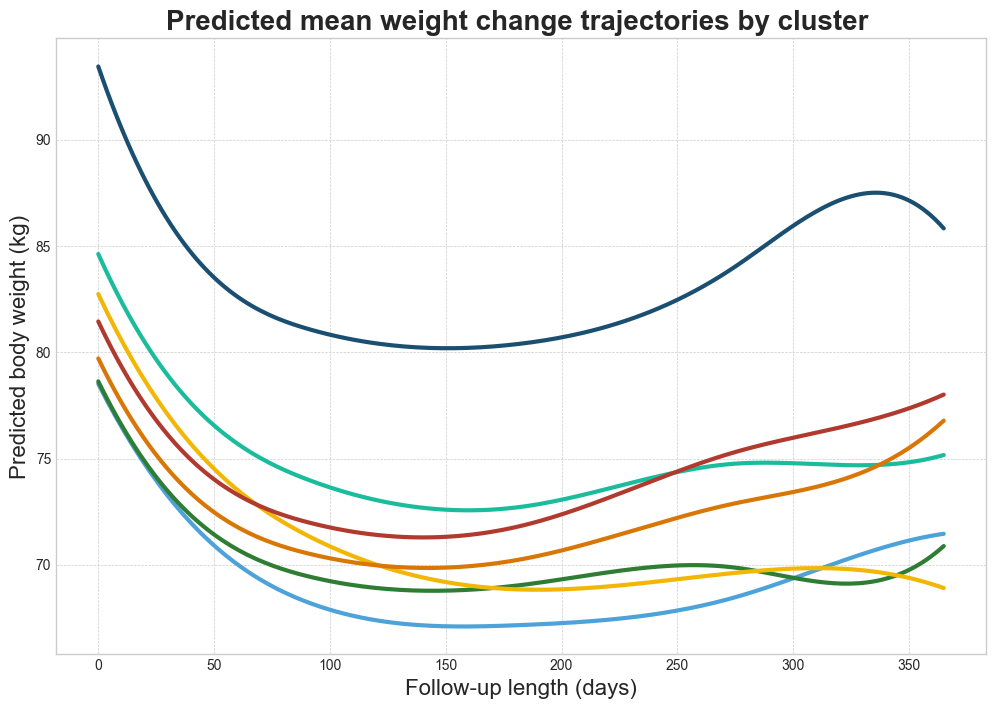

In [2]:
# =============================================================================
# END-TO-END LINEAR MIXED-EFFECTS MODEL (LMM) PIPELINE V3 - FULLY CONFIGURABLE
# =============================================================================

import pandas as pd
import numpy as np
import sqlite3
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy # Required for specifying contrasts
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import json

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# =============================================================================
# 1. CONFIGURATION SECTION
# =============================================================================
# --- FILE PATHS ---
# Use raw string (r"...") for Windows paths to avoid errors
WORKING_DIR = r"C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\dbs"
CONFIG_PATH = r"C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\scripts\cluster_config.json"
CLUSTER_DB_NAME = "pnk_db2_p2_cluster_pam_goldstd.sqlite"
MEASUREMENTS_DB_NAME = "pnk_db2_p2_in.sqlite"

# --- MODELING & ANALYSIS PARAMETERS ---
# --- Main Strategy Controls ---
USE_DEVIATION_CODING = True  # True = Compare clusters to the grand mean. False = Compare to a reference cluster.
REFERENCE_CLUSTER = 0        # The cluster to use as a reference (only used if USE_DEVIATION_CODING is False).

# --- Time Window Controls ---
USE_CUTOFF = True            # True = Analyze data only up to CUTOFF_DAYS. False = Use all available data.
CUTOFF_DAYS = 365            # The cutoff in days to use if USE_CUTOFF is True.

# --- Covariate Adjustment Controls ---
#! at the current stage, not possible, because code does not connect to any table that contains age, sex and baseline bmi data - keep it false
ADJUST_FOR_COVARIATES = False         # True = Run a model adjusted for covariates.
SHOW_BOTH_ADJUSTED_UNADJUSTED = False # If ADJUST_FOR_COVARIATES is True, this will run the unadjusted model first, then the adjusted one.

# --- General Parameters ---
CLUSTERING_ALGORITHM = "pam"
N_CLUSTERS = 7

# --- DATABASE & COLUMN NAMES ---
CLUSTER_TABLE_NAME = "clust_labels_bl_nobc_bw_pam_goldstd"
# IMPORTANT: the script assumes your measurements table also contains 'age', 'sex', and 'baseline_BMI' columns WHICH IS NOT TRUE
MEASUREMENTS_TABLE_NAME = "measurements_p2" 
PATIENT_ID_COL = "patient_id"
MEDICAL_RECORD_ID_COL = "medical_record_id"
MEASUREMENT_DATE_COL = "measurement_date"
BODY_WEIGHT_COL = "weight_kg"
CLUSTER_COLUMN = f"{CLUSTERING_ALGORITHM}_k{N_CLUSTERS}"
CLUSTER_DB_PATH = f"{WORKING_DIR}\\{CLUSTER_DB_NAME}"
MEASUREMENTS_DB_PATH = f"{WORKING_DIR}\\{MEASUREMENTS_DB_NAME}"

# --- LOAD CLUSTER CONFIGURATION ---
print(f"--- Loading Configuration from {CONFIG_PATH} ---")
with open(CONFIG_PATH, 'r', encoding='utf-8') as f:
    CONFIG_DATA = json.load(f)

# Extract the specific dicts we need for plotting
# Keys in JSON are strings ("0"), but data uses ints (0). We handle this below.
CUSTOM_LABELS = CONFIG_DATA['cluster_labels']
CUSTOM_COLORS = CONFIG_DATA['cluster_colors']

# =============================================================================
# 2. DATA PREPARATION
# =============================================================================
def load_and_prepare_data():
    """Loads, merges, and prepares all data for LMM analysis."""
    print("--- Starting Data Preparation ---")
    try:
        with sqlite3.connect(CLUSTER_DB_PATH) as conn:
            cluster_labels = pd.read_sql_query(f"SELECT {PATIENT_ID_COL}, {MEDICAL_RECORD_ID_COL}, {CLUSTER_COLUMN} as cluster_id FROM {CLUSTER_TABLE_NAME} WHERE {CLUSTER_COLUMN} IS NOT NULL", conn)
        print(f"✓ Loaded {len(cluster_labels)} cluster assignments.")
        
        with sqlite3.connect(MEASUREMENTS_DB_PATH) as conn:
            cluster_labels.to_sql('temp_cluster_patients', conn, if_exists='replace', index=False)
            # Fetch covariates along with measurements
            query = f"SELECT m.* FROM {MEASUREMENTS_TABLE_NAME} m JOIN temp_cluster_patients tcp ON m.{PATIENT_ID_COL}=tcp.{PATIENT_ID_COL} AND m.{MEDICAL_RECORD_ID_COL}=tcp.{MEDICAL_RECORD_ID_COL}"
            measurements = pd.read_sql_query(query, conn)
        print(f"✓ Loaded {len(measurements)} measurements.")
        
        measurements[MEASUREMENT_DATE_COL] = pd.to_datetime(measurements[MEASUREMENT_DATE_COL])
        measurements['days_from_baseline'] = measurements.sort_values(MEASUREMENT_DATE_COL).groupby([PATIENT_ID_COL, MEDICAL_RECORD_ID_COL])[MEASUREMENT_DATE_COL].transform(lambda x: (x - x.min()).dt.days)
        print("✓ Calculated 'days_from_baseline'.")
        
        analysis_data = pd.merge(measurements, cluster_labels, on=[PATIENT_ID_COL, MEDICAL_RECORD_ID_COL], how='inner')
        print(f"✓ Merged data into final analysis set of {len(analysis_data)} rows.")

        if USE_CUTOFF:
            analysis_data = analysis_data[analysis_data['days_from_baseline'] <= CUTOFF_DAYS].copy()
            print(f"✓ Applied cutoff filter, keeping data up to {CUTOFF_DAYS} days. New row count: {len(analysis_data)}.")
        
        return analysis_data
    except Exception as e:
        print(f"❌ Data preparation failed: {e}"); return None

# =============================================================================
# 3. LMM ANALYSIS & PLOTTING
# =============================================================================
def run_lmm_analysis(df, use_deviation_coding, reference_cluster, adjust_for_covariates):
    """Performs a single, specified LMM analysis."""
    print("\n" + "="*80)
    analysis_title = "ADJUSTED" if adjust_for_covariates else "UNADJUSTED"
    print(f"--- Starting LMM Analysis: {analysis_title} Model ---")
    
    # --- Prepare Formula based on Configuration ---
    df_model = df.copy()
    df_model['cluster_id'] = pd.Categorical(df_model['cluster_id'])
    knots = np.quantile(df_model['days_from_baseline'].unique(), [0.25, 0.5, 0.75])
    
    time_spline = f"bs(days_from_baseline, knots={tuple(knots)}, degree=3)"
    
    if use_deviation_coding:
        coding_str = "Deviation Coding (vs. Grand Mean)"
        cluster_term = f"C(cluster_id, Sum)"
    else:
        coding_str = f"Reference Coding (vs. Cluster {reference_cluster})"
        cats = sorted(df_model['cluster_id'].cat.categories)
        if reference_cluster in cats:
            cats.remove(reference_cluster)
            new_order = [reference_cluster] + cats
            df_model['cluster_id'] = df_model['cluster_id'].cat.reorder_categories(new_order, ordered=True)
        cluster_term = "cluster_id"
        
    formula = f"weight_kg ~ {cluster_term} * {time_spline}"
    
    if adjust_for_covariates:
        formula += " + age + C(sex_f) + baseline_bmi"

    print(f"Model strategy: {coding_str}")
    print(f"Formula: {formula}")
    
    # --- Fit the Model ---
    print("\nFitting model... (this may take a few minutes)")
    try:
        model = smf.mixedlm(formula, data=df_model, groups=df_model[MEDICAL_RECORD_ID_COL], re_formula="~days_from_baseline")
        result = model.fit(method=["lbfgs"])
        if not result.converged:
            print("⚠️ WARNING: Model did not converge. Results may be unreliable.")
        else:
            print("\n✅ Model fitting complete!")
        return result, df_model
    except Exception as e:
        print(f"❌ Model fitting failed: {e}"); return None, None

def display_full_deviation_effects(lmm_results, df):
    """Calculates and prints the effect for the omitted last cluster in deviation coding."""
    if not USE_DEVIATION_CODING: return

    print("\n--- Calculating Omitted Cluster Effect (for Deviation Coding) ---")
    cluster_effects = {k: v for k, v in lmm_results.params.items() if k.startswith('C(cluster_id, Sum)[S.')}
    sum_of_effects = sum(cluster_effects.values())
    last_cluster_label = sorted(df['cluster_id'].cat.categories)[-1]
    
    effect_of_last_cluster = -sum_of_effects
    
    print(f"Effect for the omitted cluster (Cluster {last_cluster_label}) is the negative sum of the others: {effect_of_last_cluster:.3f}")

def plot_predicted_trajectories(lmm_results, df, title_suffix=""):
    """Plots the model-predicted mean trajectories with CUSTOM COLORS and NAMES."""
    print("\n--- Generating Model-Derived Trajectory Plot ---")
    
    clusters = sorted(df['cluster_id'].unique())
    time_grid = np.linspace(df['days_from_baseline'].min(), df['days_from_baseline'].max(), 200)
    
    plt.figure(figsize=(12, 8))
    
    for cluster in clusters:
        # Create a dataframe for prediction at average/typical covariate values
        pred_df = pd.DataFrame({
            'days_from_baseline': time_grid,
            'cluster_id': pd.Series([cluster] * len(time_grid), dtype='category').cat.set_categories(df['cluster_id'].cat.categories)
        })
        
        # Add covariates if they exist in the model's formula
        if 'age' in lmm_results.model.exog_names:
            pred_df['age'] = df['age'].median()
            pred_df['sex'] = df['sex'].mode()[0]
            pred_df['baseline_BMI'] = df['baseline_BMI'].median()
        
        predictions = lmm_results.predict(pred_df)
        
        # --- MODIFICATION START ---
        # Look up color and label using the cluster ID (converted to string for JSON lookup)
        cluster_str = str(cluster)
        
        # Fallback in case JSON is missing a key, prevents crashing
        c_label = CUSTOM_LABELS.get(cluster_str, f"Cluster {cluster}") 
        c_color = CUSTOM_COLORS.get(cluster_str, "gray")
        
        plt.plot(time_grid, predictions, color=c_color, linewidth=3, label=c_label)
        # --- MODIFICATION END ---
        
    plt.title(f'Predicted mean weight change trajectories by cluster {title_suffix}', fontsize=20, weight='bold')
    plt.xlabel('Follow-up length (days)', fontsize=16)
    plt.ylabel('Predicted body weight (kg)', fontsize=16)
    # plt.legend(title='Cluster', fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Optional: Save the figure automatically
    # plt.savefig(f"trajectory_plot_{title_suffix}.png", dpi=300)
    plt.show()


# =============================================================================
# 4. MAIN EXECUTION
# =============================================================================
def main():
    """Main execution block to run the configured analyses."""
    analysis_data = load_and_prepare_data()
    
    if analysis_data is None or analysis_data.empty:
        print("Execution stopped due to data loading failure."); return

    # Define the sequence of models to run
    models_to_run = []
    if ADJUST_FOR_COVARIATES and SHOW_BOTH_ADJUSTED_UNADJUSTED:
        models_to_run.append({'adjust': False, 'title': ''})
        models_to_run.append({'adjust': True, 'title': 'Adjusted'})
    elif ADJUST_FOR_COVARIATES:
        models_to_run.append({'adjust': True, 'title': 'Adjusted'})
    else:
        models_to_run.append({'adjust': False, 'title': 'Unadjusted'})
        
    # Run the analyses
    for run_config in models_to_run:
        lmm_results, df_model = run_lmm_analysis(analysis_data,
                                                 use_deviation_coding=USE_DEVIATION_CODING,
                                                 reference_cluster=REFERENCE_CLUSTER,
                                                 adjust_for_covariates=run_config['adjust'])
        if lmm_results:
            print("\n--- LMM Results Summary ---")
            print(lmm_results.summary())
            display_full_deviation_effects(lmm_results, df_model)
            plot_predicted_trajectories(lmm_results, df_model) #, title_suffix=f"({run_config['title']})")

if __name__ == '__main__':
    main()


# Paper 1 legacy scripts

## 2. Data analysis

#### VIF - Variance Inflation Factor caclulations on baseline anthropometry for simple regression models

##### description

We decided to - instead of including total followup lenght as an independent variable - only use regression adjustment variables available at baseline. These are: age, sex, height, baseline weight, BMI, fat%, muscle%. However, at least some of these are expected to have collineality, and using correlated adjustment variables in regression models would inflate coefficients and render results imprecise. 

One way to address this issue is by checking the VIF values for the predictors used in the model. VIF measures how much the variance of an independent variables is inflated (influenced) by correlations with other independent variables. A high VIF value indicates collineality between independent variables, and informs the variable selection process. 

Another method to account for collineal predictors is the use of regularized regression models, that automatically decrease the coefficient values for collineal predictors. This will also be tested separately from standard regression models. 

##### code (gpt4.1)

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Step 1: Define database and table
db_path = 'pnk_db2_p1_in.sqlite'
table_name = 'timetoevent_eb_compl'

# Step 2: List of baseline predictors (with special characters)
predictors = [
    'age',
    'sex_f',
    # 'height_m',
    # 'baseline_weight_kg',
    'baseline_bmi',
    'baseline_fat_%',
    'baseline_muscle_%', 
    # 'total_followup_days', 
    'hunger_yn',
    'satiety_yn',
    'emotional_eating_yn',
    'emotional_eating_value_likert',
    'quantity_control_likert',
    'impulse_control_likert',
]

# Step 3: Load data from SQLite, quoting columns with special characters
quoted_cols = [f'"{col}"' for col in predictors]
query = f"SELECT {', '.join(quoted_cols)} FROM {table_name};"

with sqlite3.connect(db_path) as conn:
    df = pd.read_sql_query(query, conn)

# Step 4: Drop rows with missing values (VIF requires complete cases)
df = df.dropna()
print(f"Loaded {len(df)} complete cases for VIF analysis.")

# Step 5: Calculate VIF for each predictor
vif_results = []
for i, col in enumerate(predictors):
    # The current variable is the dependent variable (y)
    y = df[col].values
    # All other variables are independent variables (X)
    X = df.drop(columns=col).values
    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)
    r_squared = model.score(X, y)
    # Compute VIF
    if r_squared < 1:
        vif = 1 / (1 - r_squared)
    else:
        vif = np.inf  # Perfect collinearity
    vif_results.append({'Variable': col, 'VIF': vif})

# Step 6: Display results
vif_df = pd.DataFrame(vif_results).sort_values(by='VIF', ascending=False)
print("\nVariance Inflation Factor (VIF) Results:")
print(vif_df)

print("\nInterpretation:")
print("VIF ≈ 1: No collinearity")
print("VIF 1–5: Moderate collinearity")
print("VIF >5–10: High collinearity (potential concern)")
print("VIF >10: Very high collinearity (problematic)")
print("VIF = inf: Perfect collinearity (variable is a linear combination of others)")

##### insights

Interpretation:
VIF ≈ 1: No collinearity
VIF 1–5: Moderate collinearity
VIF >5–10: High collinearity (potential concern)
VIF >10: Very high collinearity (problematic)
VIF = inf: Perfect collinearity (variable is a linear combination of others)

ALL VARS

             Variable         VIF
- 5      baseline_fat_%  589.101992
- 6   baseline_muscle_%  450.752542
- 3  baseline_weight_kg  261.646202
- 4        baseline_bmi  136.315477
- 1               sex_f   85.984220
- 0                 age   83.053579
- 2            height_m   83.045190

**AGE, SEX, HEIGHT, WEIGHT**

             Variable       VIF
- 2            height_m  2.530527
- 3  baseline_weight_kg  2.343526
- 1               sex_f  1.962161
- 0                 age  1.052352

**AGE, SEX, BMI**

       Variable       VIF
- 2  baseline_bmi  1.073403
- 1         sex_f  1.069785
- 0           age  1.003619

AGE, SEX, BMI, FAT, MUSCLE

            Variable         VIF
- 3     baseline_fat_%  587.827521
- 4  baseline_muscle_%  355.063960
- 2       baseline_bmi   69.373615
- 0                age   59.049639
- 1              sex_f   34.496099

AGE, SEX, BMI, FAT

         Variable        VIF
- 3  baseline_fat_%  19.486842
- 2    baseline_bmi  17.792680
- 1           sex_f   8.392682
- 0             age   1.023640

AGE, SEX, BMI, MUSCLE

            Variable        VIF
- 3  baseline_muscle_%  11.770588
- 2       baseline_bmi   8.433383
- 1              sex_f   4.064810
- 0                age   3.332500

AGE, SEX, WEIGHT, FAT, MUSCLE

             Variable         VIF
- 4   baseline_muscle_%  283.065773
- 3      baseline_fat_%  145.157784
- 0                 age   57.868087
- 2  baseline_weight_kg   23.833751
- 1               sex_f   17.780198

**AGE, SEX, WEIGHT, FAT**

             Variable       VIF
- 2  baseline_weight_kg  7.667586
- 1               sex_f  7.561860
- 3      baseline_fat_%  5.317914
- 0                 age  1.148875

AGE, SEX, WEIGHT, MUSCLE

             Variable        VIF
- 2  baseline_weight_kg  11.733011
- 1               sex_f  10.632302
- 3   baseline_muscle_%  10.370229
- 0                 age   4.280661

AGE, SEX, FAT, MUSCLE

            Variable        VIF
- 3  baseline_muscle_%  91.065446
- 2     baseline_fat_%  71.459077
- 0                age  16.716288
- 1              sex_f   1.239620


**CONCLUSION**

Height in itself has less clinical relevance, so I'm not separately testing for it. 

Based on the results, the recommended adjustment variables are either: 
1. AGE, SEX, BMI -> lowest VIF, standard, accessible measures
2. AGE, SEX, WEIGHT, FAT -> moderate, more concerning VIF values, more precise but less accessible measure of the somewhat the same thing that BMI measures

## Clustering

### Algorithmically comparing clusterization metrics

In [ ]:
import sqlite3
import os

db_path = os.path.join(paper1_directory, "pnk_db2_p1_in.sqlite")
table_name = "clustering_performance_scores"
column_name = "overall_rank"

with sqlite3.connect(db_path) as conn:
    cur = conn.cursor()
    # Check if column already exists
    cur.execute(f"PRAGMA table_info({table_name})")
    columns = [row[1] for row in cur.fetchall()]
    if column_name not in columns:
        cur.execute(f"ALTER TABLE {table_name} ADD COLUMN {column_name} INTEGER")
        print(f"Added column '{column_name}' to '{table_name}'.")
    else:
        print(f"Column '{column_name}' already exists in '{table_name}'.")

In [ ]:
import sqlite3
import pandas as pd

db_path = os.path.join(paper1_directory, "pnk_db2_p1_in.sqlite")

def calculate_clustering_performance_rankings(db_path):
    """
    Calculate overall performance rankings for clustering algorithms.
    Groups by algorithm, ranks within each group, and averages the ranks.
    """
    # Connect to database and load data
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query("SELECT * FROM clustering_performance_scores", conn)
    conn.close()
    
    # Group by algorithm and calculate rankings within each group
    def rank_group(group):
        # Rank metrics (1 = best)
        group['silhouette_rank'] = group['silhouette'].rank(ascending=False)
        group['davies_bouldin_rank'] = group['davies_bouldin'].rank(ascending=True)  # Lower is better
        group['calinski_harabasz_rank'] = group['calinski_harabasz'].rank(ascending=False)
        
        # Calculate overall rank as average of individual ranks
        group['overall_rank'] = (
            group['silhouette_rank'] + 
            group['davies_bouldin_rank'] + 
            group['calinski_harabasz_rank']
        ) / 3
        
        return group
    
    # Apply ranking to each algorithm group
    df_ranked = df.groupby('algorithm').apply(rank_group).reset_index(drop=True)
    
    # Update database with overall rankings
    conn = sqlite3.connect(db_path)
    for _, row in df_ranked.iterrows():
        conn.execute("""
            UPDATE clustering_performance_scores 
            SET overall_rank = ? 
            WHERE algorithm = ? AND k = ? AND hclust_linkage = ?
        """, (row['overall_rank'], row['algorithm'], row['k'], row['hclust_linkage']))
    
    conn.commit()
    conn.close()
    
    return df_ranked

ranked_results = calculate_clustering_performance_rankings(db_path)
print("Rankings calculated and saved to database.")


### Comparison of set clusters

*IMPORTANT: need to be able to calculate differences where 0 values exist, and fallback to Fisher NEEDS TO BE ROBUST - now it is not used anywhere which is suspicious.*

#### only KW and Fisher, (and code for bootstrapping that does not run for now)

In [ ]:
import os
import sqlite3
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import kruskal, fisher_exact
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import warnings
from multiprocessing import Pool

warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURATION SECTION
# =============================================================================

# Define the paper1_directory path (modify this to your actual path)
paper1_directory = "."  # Current directory, change this to your actual path

# Database paths
DATABASE_PATH = os.path.join(paper1_directory, "pnk_db2_p1_in.sqlite")
OUTPUT_DATABASE_PATH = os.path.join(paper1_directory, "pnk_db2_p1_out.sqlite")
LABELS_TABLE = "cluster_labels"
SOURCE_DATA_TABLE = "timetoevent_eb_wgc_compl"

# =============================================================================
# CLUSTER SELECTION CONFIGURATION
# =============================================================================

# Configure the clustering setup you want to analyze
CLUSTERING_CONFIG = {
    'algorithm': 'hclust',            # 'hclust', 'pam', 'kmeans', etc.
    'k': 6,                          # number of clusters
    'linkage': 'ward',               # for hclust: 'ward', 'complete', 'average', 'single'
    'include_outliers': False         # whether to include outliers as separate group
}

# Variables to compare across clusters
COMPARISON_VARIABLES = [
    "womens_health_and_pregnancy",
    "mental_health",
    "family_issues",
    "medication_disease_injury",
    "physical_inactivity",
    "eating_habits",
    "schedule",
    "smoking_cessation",
    "treatment_discontinuation_or_relapse",
    "pandemic",
    "lifestyle_circumstances",
    "none_of_above",
    # Eating behaviors (binary) - Used in clustering
    "hunger_yn", "satiety_yn", "emotional_eating_yn",
    # Eating behaviors (continuous) - Used in clustering
    "emotional_eating_value_likert", "quantity_control_likert", "impulse_control_likert",

    # Demographics & baseline anthropometry
    "sex_f", "age",
    # "height_m",
    "baseline_weight_kg",
    "baseline_bmi",
    # "baseline_fat_%",
    # "baseline_muscle_%",

    # Weight loss outcomes
    # "last_aval_weight_kg", "total_wl_kg",
    "total_wl_%",
    # "final_bmi",
    "bmi_reduction",
    # "last_aval_fat_%",
    # "total_fat_loss_%",
    # "last_aval_muscle_%", "total_muscle_change_%",

    # Dynamic time windows (if available)
    # "40d_dropout", "wl_40d_%", "40d_fat_loss_%", "40d_muscle_change_%",
    "60d_dropout",
    "60d_wl_%",
    "60d_bmi_reduction",
    # "60d_fat_loss_%",
    # "60d_muscle_change_%",
    # "80d_dropout", "wl_80d_%", "80d_fat_loss_%", "80d_muscle_change_%",

    # Weight loss targets (if available)
    # "5%_wl_achieved", "days_to_5%_wl",
    "10%_wl_achieved", "days_to_10%_wl",
    # "15%_wl_achieved", "days_to_15%_wl"

    # Follow-up data
    "total_followup_days",
    # "instant_dropout", "dietitian_visits", "nr_total_measurements", "avg_days_between_measurements",

]

# --- NEW: Dictionary for human-readable variable names ---
VARIABLE_NAME_MAP = {
    "N (sample size)": "N (sample size)",
    "womens_health_and_pregnancy": "Women's health & pregnancy (y/n)",
    "mental_health": "Mental health (y/n)",
    "family_issues": "Family issues (y/n)",
    "medication_disease_injury": "Medication, disease, or injury (y/n)",
    "physical_inactivity": "Physical inactivity (y/n)",
    "eating_habits": "Eating habits (y/n)",
    "schedule": "Schedule (y/n)",
    "smoking_cessation": "Smoking cessation (y/n)",
    "treatment_discontinuation_or_relapse": "Treatment discontinuation or relapse (y/n)",
    "pandemic": "Pandemic (y/n)",
    "lifestyle_circumstances": "Lifestyle, circumstances (y/n)",
    "none_of_above": "None of the above (y/n)",
    "hunger_yn": "Hunger (y/n)",
    "satiety_yn": "Satiety (y/n)",
    "emotional_eating_yn": "Emotional eating (y/n)",
    "emotional_eating_value_likert": "Emotional eating score (1-10)",
    "quantity_control_likert": "Quantity control score (1-10)",
    "impulse_control_likert": "Impulse control score (1-10)",
    "sex_f": "Sex (female)",
    "age": "Age (years)",
    "baseline_weight_kg": "Baseline weight (kg)",
    "baseline_bmi": "Baseline BMI (kg/m²)",
    "total_wl_%": "Total Weight Loss (%)",
    "bmi_reduction": "BMI reduction (kg/m²)",
    "60d_dropout": "Dropout at 60 days (yes/no)",
    "60d_wl_%": "Weight loss at 60 days (%)",
    "60d_bmi_reduction": "BMI Reduction at 60 days (kg/m²)",
    "10%_wl_achieved": "Achieved 10% weight loss (yes/no)",
    "days_to_10%_wl": "Days to 10% weight loss",
    "total_followup_days": "Total follow-up (days)",
}

# --- NEW: Variables for which to run bootstrap comparisons ---
# These are clinical outcomes NOT used in the clustering process itself.
CLUSTERING_INPUT_VARIABLES = {
    "hunger_yn", "satiety_yn", "emotional_eating_yn",
    "emotional_eating_value_likert", "quantity_control_likert", "impulse_control_likert",
    "womens_health_and_pregnancy", "mental_health", "family_issues", "medication_disease_injury",
    "physical_inactivity", "eating_habits", "schedule", "smoking_cessation",
    "treatment_discontinuation_or_relapse", "pandemic", "lifestyle_circumstances", "none_of_above"
}
# BOOTSTRAP_VARIABLES = [
#     var for var in COMPARISON_VARIABLES if var not in CLUSTERING_INPUT_VARIABLES
# ]

# =============================================================================
# HELPER FUNCTIONS FOR STATISTICAL FORMATTING
# =============================================================================

def format_mean_sd(series, decimals=2):
    """Format mean ± SD for continuous variables."""
    if series.isna().all():
        return "N/A"
    mean_val = series.mean()
    sd_val = series.std()
    # n_available = series.notna().sum()
    return f"{mean_val:.{decimals}f}±{sd_val:.{decimals}f}"
    # can add in return statement: (n={n_available})

def format_n_perc(series):
    """Format n (%) for categorical variables."""
    if series.isna().all():
        return "N/A"
    total = series.notna().sum()
    positive = series.sum() if series.dtype in ['bool', 'int64'] else (series == 1).sum()
    if total == 0:
        return "0 (0.0%)"
    percentage = (positive / total) * 100
    return f"{int(positive)} ({percentage:.1f}%)"

# --- MODIFIED FUNCTION ---
def format_pval(p_value, threshold=0.001):
    """Format p-values with appropriate precision, showing exact values."""
    if pd.isna(p_value):
        return "N/A"
    if p_value < threshold:
        # Use scientific notation for very small p-values
        return f"{p_value:.2E}"
    else:
        # Use 3 decimal places for other p-values
        return f"{p_value:.3f}"

# =============================================================================
# BOOTSTRAP WORKER FUNCTION (for multiprocessing)
# =============================================================================

# def _bootstrap_pairwise_worker(data_tuple):
#     """
#     Worker function for a single bootstrap resample and comparison.
#     To be called by a multiprocessing pool.
#     """
#     group1_series, group2_series, variable_type = data_tuple
    
#     # Create bootstrap resamples by sampling with replacement
#     resample1 = np.random.choice(group1_series, size=len(group1_series), replace=True)
#     resample2 = np.random.choice(group2_series, size=len(group2_series), replace=True)
    
#     if variable_type == 'continuous':
#         # Return the difference in medians for continuous data
#         return np.median(resample1) - np.median(resample2)
#     elif variable_type == 'categorical':
#         # Return the difference in proportions (mean of 0/1 data) for categorical data
#         return np.mean(resample1) - np.mean(resample2)
#     return np.nan

# =============================================================================
# STATISTICAL TEST FUNCTIONS
# =============================================================================

def perform_continuous_test(groups_data, variable):
    """
    Perform Kruskal-Wallis test for continuous variables.
    This is a non-parametric test, robust to non-normality.
    """
    valid_groups = [group[variable].dropna() for group in groups_data if not group[variable].isna().all()]

    if len(valid_groups) < 2:
        return np.nan, "insufficient_data"

    group_sizes = [len(group) for group in valid_groups]
    if min(group_sizes) == 0:
        return np.nan, "empty_groups"

    try:
        # Default directly to Kruskal-Wallis test
        h_stat, p_value = kruskal(*valid_groups)
        test_used = "kruskal_wallis"
        return p_value, test_used
    except Exception as e:
        print(f"Error in Kruskal-Wallis test for {variable}: {e}")
        return np.nan, "error"

def perform_categorical_test(groups_data, variable):
    """
    Perform Fisher's Exact Test for categorical variables.
    This is the gold standard for small sample sizes and sparse data.
    """
    try:
        contingency_data = []
        for i, group in enumerate(groups_data):
            group_data = group[variable].dropna()
            if len(group_data) == 0:
                # Append a row of zeros if a group has no data for this variable
                contingency_data.append([0, 0])
            else:
                positive = group_data.sum() if group_data.dtype in ['bool', 'int64'] else (group_data == 1).sum()
                negative = len(group_data) - positive
                contingency_data.append([positive, negative])

        contingency_table = np.array(contingency_data)

        # Edge Case: No variation in the outcome across all groups
        if np.any(contingency_table.sum(axis=0) == 0):
            return 1.0, "no_variation"

        # Default directly to Fisher's Exact Test
        _, p_value = fisher_exact(contingency_table)
        test_used = "fisher_exact"
        return p_value, test_used

    except ValueError as e:
        # This might happen if the table is not 2xK, etc.
        print(f"Fisher's exact test failed for {variable}: {e}")
        return np.nan, "test_failed"
    except Exception as e:
        print(f"Error in categorical test for {variable}: {e}")
        return np.nan, "error"

# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def construct_cluster_column_name(config):
    """Construct the column name for the specified clustering configuration."""
    algorithm = config['algorithm'].lower()
    k = config['k']

    if algorithm == 'hclust':
        linkage = config.get('linkage', 'ward')
        return f"hclust_{linkage}_k{k}"
    elif algorithm == 'pam':
        return f"pam_k{k}"
    elif algorithm == 'kmeans':
        return f"kmeans_k{k}"
    else:
        raise ValueError(f"Unsupported algorithm: {algorithm}")

def determine_variable_type(variable, df):
    """Determine if a variable is continuous or categorical."""
    if variable not in df.columns:
        return "missing"

    # Explicit categorical variables
    categorical_indicators = ["_yn", "_achieved", "_dropout", "sex_f", "instant_dropout"]
    if any(indicator in variable for indicator in categorical_indicators):
        return "categorical"

    # Explicit continuous variables (eating behavior scores)
    continuous_likert = ["emotional_eating_value_likert", "quantity_control_likert", "impulse_control_likert"]
    if variable in continuous_likert:
        return "continuous"

    # Check data type and unique values
    series = df[variable].dropna()
    if len(series) == 0:
        return "missing"

    # If it's boolean or has only 0/1 values, treat as categorical
    if series.dtype == 'bool' or set(series.unique()).issubset({0, 1, True, False}):
        return "categorical"

    # If it has very few unique values relative to sample size, might be categorical
    unique_ratio = len(series.unique()) / len(series)
    if unique_ratio < 0.05 and len(series.unique()) <= 10:
        return "categorical"

    return "continuous"

# =============================================================================
# DATA LOADING FUNCTIONS
# =============================================================================

def load_cluster_data(db_path, labels_table, source_table, cluster_column, include_outliers=True):
    """Load cluster labels and corresponding patient data."""
    if not os.path.exists(db_path):
        raise FileNotFoundError(f"Database file not found: {db_path}")

    with sqlite3.connect(db_path) as conn:
        # First, check if tables exist
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        available_tables = [row[0] for row in cursor.fetchall()]

        if labels_table not in available_tables:
            raise ValueError(f"Table '{labels_table}' not found. Available tables: {available_tables}")

        if source_table not in available_tables:
            raise ValueError(f"Table '{source_table}' not found. Available tables: {available_tables}")

        # Load cluster labels
        labels_query = f"SELECT * FROM {labels_table}"
        labels_df = pd.read_sql_query(labels_query, conn)

        # Load source data
        source_df = pd.read_sql_query(f"SELECT * FROM {source_table}", conn)

    # Check if cluster column exists
    if cluster_column not in labels_df.columns:
        available_columns = [col for col in labels_df.columns if any(alg in col for alg in ['hclust', 'pam', 'kmeans'])]
        raise ValueError(f"Cluster column '{cluster_column}' not found. Available clustering columns: {available_columns}")

    # Merge cluster labels with source data
    merged_df = source_df.merge(labels_df, on='medical_record_id', how='inner')

    # Separate outliers and valid clusters
    outliers_df = merged_df[merged_df[cluster_column] == -1].copy() if include_outliers else pd.DataFrame()
    valid_clusters_df = merged_df[merged_df[cluster_column] != -1].copy()

    # Get unique cluster labels
    unique_clusters = sorted([x for x in merged_df[cluster_column].unique() if x != -1])

    if len(unique_clusters) == 0:
        raise ValueError("No valid cluster labels found")

    print(f"Loaded data for {len(unique_clusters)} clusters: {unique_clusters}")
    if include_outliers and len(outliers_df) > 0:
        print(f"Outliers (excluded from clustering): {len(outliers_df)} patients")
    print(f"Total patients in valid clusters: {len(valid_clusters_df)}")

    # Print cluster sizes
    cluster_sizes = valid_clusters_df[cluster_column].value_counts().sort_index()
    for cluster, size in cluster_sizes.items():
        print(f"  Cluster {cluster}: {size} patients ({size/len(valid_clusters_df)*100:.1f}%)")

    return merged_df, unique_clusters, cluster_column, outliers_df

# =============================================================================
# ANALYSIS FUNCTIONS
# =============================================================================

# def run_bootstrap_comparisons(groups_data, group_names, variable, vtype, n_bootstraps=2000):
#     """
#     Performs pairwise bootstrap comparisons between all groups.
#     Returns a formatted string summarizing the 95% CIs.
#     """
#     ci_results = []
    
#     # Generate all unique pairs of groups to compare
#     group_indices = range(len(groups_data))
#     pairs = list(combinations(group_indices, 2))

#     for i, j in pairs:
#         group1_data = groups_data[i][variable].dropna()
#         group2_data = groups_data[j][variable].dropna()
        
#         # Skip pair if either group has no data for this variable
#         if group1_data.empty or group2_data.empty:
#             continue

#         # Prepare data for the multiprocessing pool
#         # We pass the same tuple n_bootstraps times
#         pool_args = [(group1_data, group2_data, vtype)] * n_bootstraps
        
#         # Use a multiprocessing pool to run bootstrap workers in parallel
#         with Pool() as pool:
#             bootstrap_diffs = pool.map(_bootstrap_pairwise_worker, pool_args)
        
#         # Calculate the 95% confidence interval from the bootstrap distribution
#         lower_bound = np.percentile(bootstrap_diffs, 2.5)
#         upper_bound = np.percentile(bootstrap_diffs, 97.5)
        
#         # Format the result for this pair
#         pair_name = f"C{group_names[i][-1]}vC{group_names[j][-1]}"
#         ci_str = f"[{lower_bound:.2f}, {upper_bound:.2f}]"
#         ci_results.append(f"{pair_name}: {ci_str}")
        
#     return "; ".join(ci_results) if ci_results else "N/A"


# --- MODIFIED FUNCTION ---
def compare_clusters(df, clusters, cluster_column, outliers_df, variables, name_map):
    """Perform statistical comparisons across clusters."""
    results = []

    # Create cluster groups
    cluster_groups = []
    group_names = []

    # Add regular clusters
    for cluster in clusters:
        cluster_data = df[df[cluster_column] == cluster]
        cluster_groups.append(cluster_data)
        group_names.append(f"Cluster_{cluster}")

    # Add outliers group if available
    if len(outliers_df) > 0:
        cluster_groups.append(outliers_df)
        group_names.append("Outliers")

    # Add sample sizes row
    size_row = {"Variable": "N (sample size)"}
    for i, group_name in enumerate(group_names):
        size_row[group_name] = f"{len(cluster_groups[i])}"
    size_row["p-value"] = "N/A"
    size_row["Test_Used"] = "N/A"
    size_row["Bootstrap Pairwise 95% CIs"] = "N/A" # Add new column
    results.append(size_row)

    # Compare each variable
    for variable in variables:
        if variable not in df.columns:
            # Handle missing variables
            row = {"Variable": variable}
            for group_name in group_names:
                row[group_name] = "N/A"
            row["p-value"] = "N/A"
            row["Test_Used"] = "missing_variable"
            row["Bootstrap Pairwise 95% CIs"] = "N/A"
            results.append(row)
            continue

        var_type = determine_variable_type(variable, df)
        row = {"Variable": variable}

        # Calculate descriptive statistics for each group
        for i, group_name in enumerate(group_names):
            group_data = cluster_groups[i]

            if var_type == "continuous":
                row[group_name] = format_mean_sd(group_data[variable])
            elif var_type == "categorical":
                row[group_name] = format_n_perc(group_data[variable])
            else:
                row[group_name] = "N/A"

        # Perform statistical test (only if we have at least 2 groups with data)
        if var_type == "continuous":
            p_value, test_used = perform_continuous_test(cluster_groups, variable)
        elif var_type == "categorical":
            p_value, test_used = perform_categorical_test(cluster_groups, variable)
        else:
            p_value, test_used = np.nan, "unsupported_type"

        row["p-value"] = format_pval(p_value)
        row["Test_Used"] = test_used
        
        # # --- NEW: Conditional Bootstrap Block ---
        # if variable in BOOTSTRAP_VARIABLES and var_type != "missing":
        #     print(f"  - Running bootstrap for: {variable}")
        #     bootstrap_summary = run_bootstrap_comparisons(cluster_groups, group_names, variable, var_type)
        #     row["Bootstrap Pairwise 95% CIs"] = bootstrap_summary
        # else:
        #     row["Bootstrap Pairwise 95% CIs"] = "N/A"

        results.append(row)

    # Define column order to ensure the new column is placed correctly
    column_order = ["Variable"] + group_names + ["p-value", "Test_Used", "Bootstrap Pairwise 95% CIs"]
    results_df = pd.DataFrame(results, columns=column_order)

    # --- NEW: Map variable names to human-readable format ---
    # Use .get(v, v) to keep the original name if it's not in the map
    results_df['Variable'] = results_df['Variable'].apply(lambda v: name_map.get(v, v))

    return results_df


def save_comparisons_to_db(df, db_path, table_name):
    """
    Saves a DataFrame to a specified table in an SQLite database.
    If the table already exists, it will be replaced.

    Args:
        df (pd.DataFrame): The DataFrame to save.
        db_path (str): The path to the SQLite database file.
        table_name (str): The name of the table to create/replace.
    """
    try:
        print(f"\nSaving results to table '{table_name}' in database '{db_path}'...")
        with sqlite3.connect(db_path) as conn:
            df.to_sql(
                name=table_name,
                con=conn,
                if_exists='replace',  # Overwrites the table if it exists
                index=False           # Do not write the DataFrame index as a column
            )
        print("Save successful.")
    except Exception as e:
        print(f"Error saving results to the database: {e}")
        
# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def create_cluster_visualization(df, cluster_column, clusters, outliers_df):
    """
    Create visualizations to understand cluster characteristics.
    This version includes a 3x2 grid with a plot for total follow-up days
    and ensures all plots are sorted by cluster number.
    """
    # A 3x2 grid is needed for the 5 plots.
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Prepare data including outliers for visualization
    viz_df = df.copy()
    if not outliers_df.empty:
        # Concatenate dataframes and replace -1 with a string for easier handling
        viz_df = pd.concat([df[df[cluster_column] != -1], outliers_df])
        viz_df.loc[viz_df[cluster_column] == -1, cluster_column] = 'Outliers'

    # --- NEW: Create a consistently ordered list of cluster labels ---
    # This ensures all plots use the same order: 0, 1, 2, ..., Outliers
    unique_labels = viz_df[cluster_column].unique()
    # Separate numeric cluster labels from the 'Outliers' label
    numeric_clusters = sorted([c for c in unique_labels if c != 'Outliers'])

    # Create the final ordered list of labels
    ordered_labels = numeric_clusters
    if 'Outliers' in unique_labels:
        ordered_labels.append('Outliers')    

    # 1. Cluster size distribution (Bar Chart)
    ax = axes[0]
    cluster_counts = viz_df[cluster_column].value_counts().reindex(ordered_labels)
    
    # Use seaborn for easier ordering and better aesthetics
    sns.barplot(x=cluster_counts.index.astype(str), y=cluster_counts.values, ax=ax, order=[str(l) for l in ordered_labels])
    ax.set_title('A. Cluster size distribution')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Number of patients')
    # Add text labels on top of bars
    for i, count in enumerate(cluster_counts):
        if pd.notna(count):
            ax.text(i, count, str(int(count)), ha='center', va='bottom')

    # 2. Sex distribution by cluster (Stacked Bar Chart)
    ax = axes[1]
    if 'sex_f' in viz_df.columns:
        # Create a crosstab and reindex to ensure correct order
        sex_crosstab = pd.crosstab(viz_df[cluster_column], viz_df['sex_f']).reindex(ordered_labels)
        sex_crosstab.plot(kind='bar', stacked=True, ax=ax, rot=0)
        ax.set_title('B. Sex distribution by cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Number of patients')
        ax.legend(['Male', 'Female'])
    else:
        ax.text(0.5, 0.5, 'Sex data not available', transform=ax.transAxes, ha='center')

    # 3. Age distribution by cluster (Box Plot)
    ax = axes[2]
    if 'age' in viz_df.columns:
        sns.boxplot(data=viz_df, x=cluster_column, y='age', ax=ax, order=ordered_labels)
        ax.set_title('C. Age distribution by cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Age (years)')
    else:
        ax.text(0.5, 0.5, 'Age data not available', transform=ax.transAxes, ha='center')

    # 4. Baseline weight distribution by cluster (Box Plot)
    ax = axes[3]
    if 'baseline_weight_kg' in viz_df.columns:
        sns.boxplot(data=viz_df, x=cluster_column, y='baseline_weight_kg', ax=ax, order=ordered_labels)
        ax.set_title('D. Baseline body weight (kg) distribution by cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Baseline body weight (kg)')
    else:
        ax.text(0.5, 0.5, 'Baseline body weight data not available', transform=ax.transAxes, ha='center')

    # 5. Total Follow-up Days by cluster (Box Plot) ---
    ax = axes[4]
    if 'total_followup_days' in viz_df.columns:
        sns.boxplot(data=viz_df, x=cluster_column, y='total_followup_days', ax=ax, order=ordered_labels)
        ax.set_title('E. Total follow-up length (days) by cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Total follow-up length (days)')
    else:
        ax.text(0.5, 0.5, 'Follow-up data not available', transform=ax.transAxes, ha='center')

    # 6. Weight loss percentage by cluster (Box Plot)
    ax = axes[5]
    if 'total_wl_%' in viz_df.columns:
        sns.boxplot(data=viz_df, x=cluster_column, y='total_wl_%', ax=ax, order=ordered_labels)
        ax.set_title('F. Total body weight loss (%) by cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Total body weight loss (%)')
    else:
        ax.text(0.5, 0.5, 'Weight loss % data not available', transform=ax.transAxes, ha='center')

    # Hide the unused subplot (the 6th one in a 3x2 grid)
    # axes[5].set_visible(False)

    # Add a title for the entire figure
    fig.suptitle(f'Cluster Analysis for: {cluster_column}', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust layout to make space for suptitle
    plt.show()

# =============================================================================
# MAIN PIPELINE FUNCTION
# =============================================================================

def run_cluster_comparison_pipeline():
    """Main function to run the cluster comparison pipeline."""
    print("=== CLUSTER COMPARISON PIPELINE ===")
    print(f"Configuration: {CLUSTERING_CONFIG}")

    try:
        # Step 1: Construct cluster column name
        cluster_column = construct_cluster_column_name(CLUSTERING_CONFIG)
        print(f"Looking for cluster column: {cluster_column}")

        # Step 2: Load cluster data
        print("\nLoading cluster data...")
        df, clusters, cluster_col, outliers_df = load_cluster_data(
            DATABASE_PATH, LABELS_TABLE, SOURCE_DATA_TABLE,
            cluster_column, CLUSTERING_CONFIG['include_outliers']
        )

        # Step 3: Perform statistical comparisons
        total_groups = len(clusters) + (1 if len(outliers_df) > 0 else 0)
        print(f"\nComparing {len(COMPARISON_VARIABLES)} variables across {total_groups} groups...")
        # --- MODIFIED FUNCTION CALL ---
        comparison_results = compare_clusters(df, clusters, cluster_col, outliers_df, COMPARISON_VARIABLES, VARIABLE_NAME_MAP)

        # Step 4: Display and save results
        print("\n=== CLUSTER COMPARISON RESULTS ===")
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_colwidth', 100) # Increased for bootstrap CIs

        print(comparison_results.to_string(index=False))

        save_comparisons_to_db(comparison_results, OUTPUT_DATABASE_PATH, cluster_column)

        # Step 5: Create visualizations
        print("\nCreating cluster visualizations...")
        create_cluster_visualization(df, cluster_col, clusters, outliers_df)

        # Step 6: Summary of significant differences
        print("\n=== SIGNIFICANT DIFFERENCES (p < 0.05) ===")
        significant_results = comparison_results[
            (comparison_results['p-value'] != 'N/A') &
            (comparison_results['Variable'] != 'N (sample size)')
        ].copy()

        if len(significant_results) > 0:
            # --- MODIFIED HELPER FUNCTION ---
            def extract_pvalue(p_str):
                """Converts formatted p-value string back to float."""
                if p_str == 'N/A':
                    return 1.0
                try:
                    # float() can handle scientific notation like '1.23e-04'
                    return float(p_str)
                except ValueError:
                    return 1.0

            significant_results['p_numeric'] = significant_results['p-value'].apply(extract_pvalue)
            significant_vars = significant_results[significant_results['p_numeric'] < 0.05]

            if len(significant_vars) > 0:
                print(f"Found {len(significant_vars)} variables with significant differences:")
                for _, row in significant_vars.iterrows():
                    print(f"  {row['Variable']}: p = {row['p-value']} ({row['Test_Used']})")
            else:
                print("No variables showed significant differences between groups.")

        return comparison_results, df

    except Exception as e:
        print(f"Error in pipeline execution: {e}")
        print("\nPlease check:")
        print("1. Database file path is correct")
        print("2. Tables exist in the database")
        print("3. Cluster column name matches available columns")
        return None, None

# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    # Configure display options
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 100)

    # Run the cluster comparison pipeline
    results_df, cluster_data = run_cluster_comparison_pipeline()

    # if results_df is not None:
    #     print("\n=== PIPELINE COMPLETED SUCCESSFULLY ===")
    #     print(f"Results shape: {results_df.shape}")
    #     print("Use 'results_df' to access the comparison table")
    #     print("Use 'cluster_data' to access the merged dataset")
    # else:
    #     print("\n=== PIPELINE FAILED ===")
    #     print("Please check the error messages above and fix the configuration")

#### og

In [ ]:
import os
import sqlite3
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import f_oneway, chi2_contingency, kruskal
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURATION SECTION
# =============================================================================

# Define the paper1_directory path (modify this to your actual path)
paper1_directory = "."  # Current directory, change this to your actual path

# Database paths
DATABASE_PATH = os.path.join(paper1_directory, "pnk_db2_p1_in.sqlite")
LABELS_TABLE = "cluster_labels"
SOURCE_DATA_TABLE = "timetoevent_eb_wgc_compl"

# =============================================================================
# CLUSTER SELECTION CONFIGURATION
# =============================================================================

# Configure the clustering setup you want to analyze
CLUSTERING_CONFIG = {
    'algorithm': 'hclust',            # 'hclust', 'pam', 'kmeans', etc.
    'k': 5,                          # number of clusters
    'linkage': 'ward',               # for hclust: 'ward', 'complete', 'average', 'single'
    'include_outliers': False         # whether to include outliers as separate group
}

# Variables to compare across clusters
COMPARISON_VARIABLES = [
    # Demographics & baseline anthropometry
    "sex_f", "age", 
    # "height_m", 
    "baseline_weight_kg",     "baseline_bmi", "baseline_fat_%", 
    # "baseline_muscle_%",
    
    # Follow-up data
    "total_followup_days", 
    # "instant_dropout", "dietitian_visits", "nr_total_measurements", "avg_days_between_measurements",
    
    # Weight loss outcomes
    # "last_aval_weight_kg", "total_wl_kg", 
    "total_wl_%", 
    # "final_bmi", 
    "bmi_reduction",
    # "last_aval_fat_%", 
    "total_fat_loss_%", 
    # "last_aval_muscle_%", "total_muscle_change_%",
    
    # Eating behaviors (binary)
    "hunger_yn", "satiety_yn", "emotional_eating_yn",
    
    # Eating behaviors (continuous)
    "emotional_eating_value_likert", "quantity_control_likert", "impulse_control_likert",
    
    # Weight gain causes (binary)
    "womens_health_and_pregnancy", "mental_health", "family_issues", "medication_disease_injury",
    "physical_inactivity", "eating_habits", "schedule", "smoking_cessation",
    "treatment_discontinuation_or_relapse", "pandemic", "lifestyle_circumstances", "none_of_above",
    
    # Dynamic time windows (if available)
    # "40d_dropout", "wl_40d_%", "40d_fat_loss_%", "40d_muscle_change_%",
    "60d_dropout", "60d_wl_%", "60d_bmi_reduction", "60d_fat_loss_%", 
    # "60d_muscle_change_%",
    # "80d_dropout", "wl_80d_%", "80d_fat_loss_%", "80d_muscle_change_%",
    
    # Weight loss targets (if available)
    "5%_wl_achieved", "days_to_5%_wl",
    "10%_wl_achieved", "days_to_10%_wl",
    # "15%_wl_achieved", "days_to_15%_wl"
]

# =============================================================================
# HELPER FUNCTIONS FOR STATISTICAL FORMATTING
# =============================================================================

def format_mean_sd(series, decimals=2):
    """Format mean ± SD for continuous variables."""
    if series.isna().all():
        return "N/A"
    mean_val = series.mean()
    sd_val = series.std()
    n_available = series.notna().sum()
    return f"{mean_val:.{decimals}f} ± {sd_val:.{decimals}f} (n={n_available})"

def format_n_perc(series):
    """Format n (%) for categorical variables."""
    if series.isna().all():
        return "N/A"
    total = series.notna().sum()
    positive = series.sum() if series.dtype in ['bool', 'int64'] else (series == 1).sum()
    if total == 0:
        return "0 (0.0%)"
    percentage = (positive / total) * 100
    return f"{int(positive)} ({percentage:.1f}%)"

def format_pval(p_value, threshold=0.001):
    """Format p-values with appropriate precision."""
    if pd.isna(p_value):
        return "N/A"
    if p_value < threshold:
        return f"<{threshold}"
    elif p_value < 0.01:
        return f"{p_value:.3f}"
    elif p_value < 0.05:
        return f"{p_value:.3f}"
    else:
        return f"{p_value:.3f}"

# =============================================================================
# STATISTICAL TEST FUNCTIONS
# =============================================================================

def perform_anova_test(groups_data, variable):
    """Perform appropriate ANOVA test for continuous variables."""
    # Remove groups with all NaN values
    valid_groups = [group[variable].dropna() for group in groups_data if not group[variable].isna().all()]
    
    if len(valid_groups) < 2:
        return np.nan, "insufficient_data"
    
    # Check if all groups have at least some data
    group_sizes = [len(group) for group in valid_groups]
    if min(group_sizes) == 0:
        return np.nan, "empty_groups"
    
    try:
        # Test for normality (Shapiro-Wilk for small samples)
        normality_tests = []
        for group in valid_groups:
            if len(group) >= 3:  # Need at least 3 observations for Shapiro-Wilk
                _, p_norm = stats.shapiro(group)
                normality_tests.append(p_norm > 0.05)  # True if normal
        
        # If most groups appear normal, use ANOVA; otherwise use Kruskal-Wallis
        if len(normality_tests) > 0 and sum(normality_tests) >= len(normality_tests) * 0.5:
            # Use one-way ANOVA
            f_stat, p_value = f_oneway(*valid_groups)
            test_used = "anova"
        else:
            # Use Kruskal-Wallis (non-parametric)
            h_stat, p_value = kruskal(*valid_groups)
            test_used = "kruskal_wallis"
        
        return p_value, test_used
    
    except Exception as e:
        print(f"Error in ANOVA test for {variable}: {e}")
        return np.nan, "error"

def perform_chi_square_test(groups_data, variable):
    """
    Perform chi-square test for categorical variables, with a robust fallback
    to Fisher's exact test for sparse data.
    """
    try:
        # Create contingency table (This logic remains unchanged)
        contingency_data = []
        for i, group in enumerate(groups_data):
            group_data = group[variable].dropna()
            if len(group_data) == 0:
                contingency_data.append([0, 0])
            else:
                positive = group_data.sum() if group_data.dtype in ['bool', 'int64'] else (group_data == 1).sum()
                negative = len(group_data) - positive
                contingency_data.append([positive, negative])
        
        contingency_table = np.array(contingency_data)

        # Edge Case: No variation (This logic remains unchanged)
        if np.any(contingency_table.sum(axis=0) == 0):
            return 1.0, "no_variation"

        # --- MODIFICATION 2: Correct the try/except block ---
        try:
            # Use the 'stats' prefix for the function call
            chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
            
            if dof == 0:
                 raise ValueError("Degrees of freedom is 0, Chi-square is not applicable.")
            test_used = "chi_square"
            
        except ValueError:
            # This fallback will now work correctly because 'stats' is imported.
            try:
                # Use the 'stats' prefix for the function call
                _, p_value = stats.fisher_exact(contingency_table)
                test_used = "fisher_exact"
            except ValueError as e:
                print(f"Fisher's exact test also failed for {variable}: {e}")
                return np.nan, "test_failed"

        return p_value, test_used
    
    except Exception as e:
        print(f"Error in chi-square test for {variable}: {e}")
        return np.nan, "error"
    
# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def construct_cluster_column_name(config):
    """Construct the column name for the specified clustering configuration."""
    algorithm = config['algorithm'].lower()
    k = config['k']
    
    if algorithm == 'hclust':
        linkage = config.get('linkage', 'ward')
        return f"hclust_{linkage}_k{k}"
    elif algorithm == 'pam':
        return f"pam_k{k}"
    elif algorithm == 'kmeans':
        return f"kmeans_k{k}"
    else:
        raise ValueError(f"Unsupported algorithm: {algorithm}")

def determine_variable_type(variable, df):
    """Determine if a variable is continuous or categorical."""
    if variable not in df.columns:
        return "missing"
    
    # Explicit categorical variables
    categorical_indicators = ["_yn", "_achieved", "_dropout", "sex_f", "instant_dropout"]
    if any(indicator in variable for indicator in categorical_indicators):
        return "categorical"
    
    # Explicit continuous variables (eating behavior scores)
    continuous_likert = ["emotional_eating_value_likert", "quantity_control_likert", "impulse_control_likert"]
    if variable in continuous_likert:
        return "continuous"
    
    # Check data type and unique values
    series = df[variable].dropna()
    if len(series) == 0:
        return "missing"
    
    # If it's boolean or has only 0/1 values, treat as categorical
    if series.dtype == 'bool' or set(series.unique()).issubset({0, 1, True, False}):
        return "categorical"
    
    # If it has very few unique values relative to sample size, might be categorical
    unique_ratio = len(series.unique()) / len(series)
    if unique_ratio < 0.05 and len(series.unique()) <= 10:
        return "categorical"
    
    return "continuous"

# =============================================================================
# DATA LOADING FUNCTIONS
# =============================================================================

def load_cluster_data(db_path, labels_table, source_table, cluster_column, include_outliers=True):
    """Load cluster labels and corresponding patient data."""
    if not os.path.exists(db_path):
        raise FileNotFoundError(f"Database file not found: {db_path}")
    
    with sqlite3.connect(db_path) as conn:
        # First, check if tables exist
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        available_tables = [row[0] for row in cursor.fetchall()]
        
        if labels_table not in available_tables:
            raise ValueError(f"Table '{labels_table}' not found. Available tables: {available_tables}")
        
        if source_table not in available_tables:
            raise ValueError(f"Table '{source_table}' not found. Available tables: {available_tables}")
        
        # Load cluster labels
        labels_query = f"SELECT * FROM {labels_table}"
        labels_df = pd.read_sql_query(labels_query, conn)
        
        # Load source data
        source_df = pd.read_sql_query(f"SELECT * FROM {source_table}", conn)
    
    # Check if cluster column exists
    if cluster_column not in labels_df.columns:
        available_columns = [col for col in labels_df.columns if any(alg in col for alg in ['hclust', 'pam', 'kmeans'])]
        raise ValueError(f"Cluster column '{cluster_column}' not found. Available clustering columns: {available_columns}")
    
    # Merge cluster labels with source data
    merged_df = source_df.merge(labels_df, on='medical_record_id', how='inner')
    
    # Separate outliers and valid clusters
    outliers_df = merged_df[merged_df[cluster_column] == -1].copy() if include_outliers else pd.DataFrame()
    valid_clusters_df = merged_df[merged_df[cluster_column] != -1].copy()
    
    # Get unique cluster labels
    unique_clusters = sorted([x for x in merged_df[cluster_column].unique() if x != -1])
    
    if len(unique_clusters) == 0:
        raise ValueError("No valid cluster labels found")
    
    print(f"Loaded data for {len(unique_clusters)} clusters: {unique_clusters}")
    if include_outliers and len(outliers_df) > 0:
        print(f"Outliers (excluded from clustering): {len(outliers_df)} patients")
    print(f"Total patients in valid clusters: {len(valid_clusters_df)}")
    
    # Print cluster sizes
    cluster_sizes = valid_clusters_df[cluster_column].value_counts().sort_index()
    for cluster, size in cluster_sizes.items():
        print(f"  Cluster {cluster}: {size} patients ({size/len(valid_clusters_df)*100:.1f}%)")
    
    return merged_df, unique_clusters, cluster_column, outliers_df

# =============================================================================
# ANALYSIS FUNCTIONS
# =============================================================================

def compare_clusters(df, clusters, cluster_column, outliers_df, variables):
    """Perform statistical comparisons across clusters."""
    results = []
    
    # Create cluster groups
    cluster_groups = []
    group_names = []
    
    # Add regular clusters
    for cluster in clusters:
        cluster_data = df[df[cluster_column] == cluster]
        cluster_groups.append(cluster_data)
        group_names.append(f"Cluster_{cluster}")
    
    # Add outliers group if available
    if len(outliers_df) > 0:
        cluster_groups.append(outliers_df)
        group_names.append("Outliers")
    
    # Add sample sizes row
    size_row = {"Variable": "N (sample size)"}
    for i, group_name in enumerate(group_names):
        size_row[group_name] = f"{len(cluster_groups[i])}"
    size_row["p-value"] = "N/A"
    size_row["Test_Used"] = "N/A"
    results.append(size_row)
    
    # Compare each variable
    for variable in variables:
        if variable not in df.columns:
            # Handle missing variables
            row = {"Variable": variable}
            for group_name in group_names:
                row[group_name] = "N/A"
            row["p-value"] = "N/A"
            row["Test_Used"] = "missing_variable"
            results.append(row)
            continue
        
        var_type = determine_variable_type(variable, df)
        row = {"Variable": variable}
        
        # Calculate descriptive statistics for each group
        for i, group_name in enumerate(group_names):
            group_data = cluster_groups[i]
            
            if var_type == "continuous":
                row[group_name] = format_mean_sd(group_data[variable])
            elif var_type == "categorical":
                row[group_name] = format_n_perc(group_data[variable])
            else:
                row[group_name] = "N/A"
        
        # Perform statistical test (only if we have at least 2 groups with data)
        if var_type == "continuous":
            p_value, test_used = perform_anova_test(cluster_groups, variable)
        elif var_type == "categorical":
            p_value, test_used = perform_chi_square_test(cluster_groups, variable)
        else:
            p_value, test_used = np.nan, "unsupported_type"
        
        row["p-value"] = format_pval(p_value)
        row["Test_Used"] = test_used
        
        results.append(row)
    
    return pd.DataFrame(results)

# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def create_cluster_visualization(df, cluster_column, clusters, outliers_df):
    """Create visualizations to understand cluster characteristics."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Prepare data including outliers for visualization
    viz_df = df.copy()
    if len(outliers_df) > 0:
        viz_df = pd.concat([df[df[cluster_column] != -1], outliers_df])
        viz_df.loc[viz_df[cluster_column] == -1, cluster_column] = 'Outliers'
    
    # 1. Cluster size distribution
    cluster_counts = viz_df[cluster_column].value_counts()
    if 'Outliers' in cluster_counts.index:
        # Reorder to put outliers at the end
        regular_clusters = cluster_counts.drop('Outliers').sort_index()
        cluster_counts = pd.concat([regular_clusters, cluster_counts[['Outliers']]])
    
    axes[0, 0].bar(range(len(cluster_counts)), cluster_counts.values)
    axes[0, 0].set_xticks(range(len(cluster_counts)))
    axes[0, 0].set_xticklabels(cluster_counts.index.astype(str))
    axes[0, 0].set_title('Group Size Distribution')
    axes[0, 0].set_xlabel('Group')
    axes[0, 0].set_ylabel('Number of Patients')
    
    # 2. Age distribution by cluster
    if 'age' in viz_df.columns:
        age_data = [viz_df[viz_df[cluster_column] == cluster]['age'].dropna() 
                   for cluster in viz_df[cluster_column].unique()]
        axes[0, 1].boxplot(age_data, labels=viz_df[cluster_column].unique())
        axes[0, 1].set_title('Age Distribution by Group')
        axes[0, 1].set_xlabel('Group')
        axes[0, 1].set_ylabel('Age')
    else:
        axes[0, 1].text(0.5, 0.5, 'Age data not available', transform=axes[0, 1].transAxes, ha='center')
    
    # 3. Weight loss percentage by cluster
    if 'total_wl_%' in viz_df.columns:
        wl_data = [viz_df[viz_df[cluster_column] == cluster]['total_wl_%'].dropna() 
                  for cluster in viz_df[cluster_column].unique()]
        axes[1, 0].boxplot(wl_data, labels=viz_df[cluster_column].unique())
        axes[1, 0].set_title('Weight Loss % by Group')
        axes[1, 0].set_xlabel('Group')
        axes[1, 0].set_ylabel('Weight Loss %')
    else:
        axes[1, 0].text(0.5, 0.5, 'Weight loss % data not available', transform=axes[1, 0].transAxes, ha='center')
    
    # 4. Sex distribution by cluster
    if 'sex_f' in viz_df.columns:
        sex_crosstab = pd.crosstab(viz_df[cluster_column], viz_df['sex_f'])
        sex_crosstab.plot(kind='bar', stacked=True, ax=axes[1, 1])
        axes[1, 1].set_title('Sex Distribution by Group')
        axes[1, 1].set_xlabel('Group')
        axes[1, 1].legend(['Male', 'Female'])
        axes[1, 1].tick_params(axis='x', rotation=45)
    else:
        axes[1, 1].text(0.5, 0.5, 'Sex data not available', transform=axes[1, 1].transAxes, ha='center')
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN PIPELINE FUNCTION
# =============================================================================

def run_cluster_comparison_pipeline():
    """Main function to run the cluster comparison pipeline."""
    print("=== CLUSTER COMPARISON PIPELINE ===")
    print(f"Configuration: {CLUSTERING_CONFIG}")
    
    try:
        # Step 1: Construct cluster column name
        cluster_column = construct_cluster_column_name(CLUSTERING_CONFIG)
        print(f"Looking for cluster column: {cluster_column}")
        
        # Step 2: Load cluster data
        print("\nLoading cluster data...")
        df, clusters, cluster_col, outliers_df = load_cluster_data(
            DATABASE_PATH, LABELS_TABLE, SOURCE_DATA_TABLE, 
            cluster_column, CLUSTERING_CONFIG['include_outliers']
        )
        
        # Step 3: Perform statistical comparisons
        total_groups = len(clusters) + (1 if len(outliers_df) > 0 else 0)
        print(f"\nComparing {len(COMPARISON_VARIABLES)} variables across {total_groups} groups...")
        comparison_results = compare_clusters(df, clusters, cluster_col, outliers_df, COMPARISON_VARIABLES)
        
        # Step 4: Display results
        print("\n=== CLUSTER COMPARISON RESULTS ===")
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_colwidth', 50)
        
        print(comparison_results.to_string(index=False))
                
        # Step 5: Create visualizations
        print("\nCreating cluster visualizations...")
        create_cluster_visualization(df, cluster_col, clusters, outliers_df)
        
        # Step 6: Summary of significant differences
        print("\n=== SIGNIFICANT DIFFERENCES (p < 0.05) ===")
        significant_results = comparison_results[
            (comparison_results['p-value'] != 'N/A') & 
            (comparison_results['Variable'] != 'N (sample size)')
        ].copy()
        
        if len(significant_results) > 0:
            # Convert p-values for filtering
            def extract_pvalue(p_str):
                if p_str == 'N/A':
                    return 1.0
                elif p_str.startswith('<'):
                    return float(p_str[1:])
                else:
                    try:
                        return float(p_str)
                    except ValueError:
                        return 1.0
            
            significant_results['p_numeric'] = significant_results['p-value'].apply(extract_pvalue)
            significant_vars = significant_results[significant_results['p_numeric'] < 0.05]
            
            if len(significant_vars) > 0:
                print(f"Found {len(significant_vars)} variables with significant differences:")
                for _, row in significant_vars.iterrows():
                    print(f"  {row['Variable']}: p = {row['p-value']} ({row['Test_Used']})")
            else:
                print("No variables showed significant differences between groups.")
        
        return comparison_results, df
        
    except Exception as e:
        print(f"Error in pipeline execution: {e}")
        print("\nPlease check:")
        print("1. Database file path is correct")
        print("2. Tables exist in the database")
        print("3. Cluster column name matches available columns")
        return None, None

# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    # Configure display options
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 50)
    
    # Run the cluster comparison pipeline
    results_df, cluster_data = run_cluster_comparison_pipeline()
    
    if results_df is not None:
        print("\n=== PIPELINE COMPLETED SUCCESSFULLY ===")
        print(f"Results shape: {results_df.shape}")
        print("Use 'results_df' to access the comparison table")
        print("Use 'cluster_data' to access the merged dataset")
    else:
        print("\n=== PIPELINE FAILED ===")
        print("Please check the error messages above and fix the configuration")

In [ ]:
results_df

Best k-prototypes results by metric:
  Best Silhouette: k=2 (score: 0.2597)
  Best Davies-Bouldin: k=2 (score: 1.8699)
  Best Calinski-Harabasz: k=2 (score: 62.7761)

# Misc

### PDF to TIFF

In [5]:
%pip install pymupdf

  Using cached pymupdf-1.26.7-cp310-abi3-win_amd64.whl.metadata (3.4 kB)
Using cached pymupdf-1.26.7-cp310-abi3-win_amd64.whl (18.4 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import pymupdf  # PyMuPDF
from PIL import Image

def convert_pdf_to_submission_format(pdf_path, output_path, dpi=300):
    doc = pymupdf.open(pdf_path)
    page = doc.load_page(0)
    
    # 1. Define Matrix
    zoom = dpi / 72
    mat = pymupdf.Matrix(zoom, zoom)
    
    # 2. Render with Transparency (RGBA)
    # alpha=True captures the transparent background instead of guessing a fill color
    pix = page.get_pixmap(matrix=mat, alpha=True)
    
    # 3. Convert to Pillow Image (RGBA)
    img_rgba = Image.frombytes("RGBA", [pix.width, pix.height], pix.samples)
    
    # 4. Composite onto Pure White Background
    # Create a new white image of the same size
    final_img = Image.new("RGB", img_rgba.size, (255, 255, 255))
    # Paste the PDF render on top, using the alpha channel as a mask
    final_img.paste(img_rgba, (0, 0), mask=img_rgba)
    
    # 5. Save as TIFF/JPG
    final_img.save(output_path, dpi=(dpi, dpi), compression="tiff_lzw")
    print(f"Saved: {output_path}")

# --- USAGE ---
# Export your 18cm wide design from Canva as 'Figure_1_Canva.pdf'
input_pdf = "C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/submission_figs_300dpi/front_nutr_fig1ae.pdf"
output_tiff = "C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/submission_figs_300dpi/front_nutr_fig1ae_300dpi.tif"

convert_pdf_to_submission_format(input_pdf, output_tiff)


Saved: C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/paper2_dir/outputs/submission_figs_300dpi/front_nutr_fig1ae_300dpi.tif


### SQL to Excel

list tables

In [8]:
import pandas as pd
import os
import sqlite3

db_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\DB2_standard"  # Paper 2-specific files and code
db_path = os.path.join(db_directory, "pnk_db2_filtered.sqlite")

with sqlite3.connect(db_path) as conn:
    tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
    print('Tables in the database:')
    for name in tables['name']:
        print(f'"{name}",')

Tables in the database:
"measurements_filtered",
"medical_records_filtered",
"prescriptions_filtered",
"alleles_filtered",
"patients_filtered",


In [9]:
import sqlite3
import pandas as pd
import os

db_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\DB2_standard"  # Paper 2-specific files and code
output_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\DB2_standard"  # Paper 2-specific files and code

# Define the output Excel file path
DB_PATH = os.path.join(db_directory, "pnk_db2_filtered.sqlite")
output_excel_path = os.path.join(output_directory, 'alleles_filtered.xlsx')

# Define which tables to write to Excel (modify this list as needed)
tables_to_write = [
"alleles_filtered",
]

# Alternative: Set to None to export all tables (original behavior)
# tables_to_write = None

# Connect to the SQLite database
with sqlite3.connect(DB_PATH) as conn:
    # Get the list of all tables in the database
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    all_tables = pd.read_sql_query(query, conn)['name'].tolist()
    
    # Determine which tables to export
    if tables_to_write is None:
        # Export all tables (original behavior)
        tables_to_export = all_tables
        print(f"Exporting all {len(tables_to_export)} tables to Excel...")
    else:
        # Export only specified tables
        tables_to_export = [table for table in tables_to_write if table in all_tables]
        missing_tables = [table for table in tables_to_write if table not in all_tables]
        
        if missing_tables:
            print(f"Warning: The following tables were not found in the database: {missing_tables}")
        
        print(f"Exporting {len(tables_to_export)} selected tables to Excel...")
        print(f"Tables to export: {tables_to_export}")
    
    # Create a Pandas Excel writer
    with pd.ExcelWriter(output_excel_path, engine='openpyxl') as writer:
        # Loop through each selected table and save it as a sheet in the Excel file
        for table in tables_to_export:
            try:
                df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
                # Truncate sheet name if too long (Excel limit is 31 characters)
                sheet_name = table[:31] if len(table) > 31 else table
                df.to_excel(writer, sheet_name=sheet_name, index=False)
                print(f"  ✓ Exported table '{table}' ({len(df)} rows)")
            except Exception as e:
                print(f"  ✗ Error exporting table '{table}': {e}")

print(f"\nDatabase export completed. Excel file saved at: {output_excel_path}")


Exporting 1 selected tables to Excel...
Tables to export: ['alleles_filtered']
  ✓ Exported table 'alleles_filtered' (57859 rows)

Database export completed. Excel file saved at: C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\DB2_standard\alleles_filtered.xlsx


### SQL table listing and deletion

list tables

In [40]:
import pandas as pd
import os
import sqlite3

db_path = os.path.join(paper2_directory, "pnk_db2_p2_out.sqlite")

with sqlite3.connect(db_path) as conn:
    tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
    print('Tables in the database:')
    for name in tables['name']:
        print(f'"{name}",')

Tables in the database:
"wgc_cmpl_dmgrph_strt",
"wgc_cmpl_wgc_strt",
"wgc_gen_cmpl_dmgrph_strt",
"wgc_gen_cmpl_wgc_strt",
"lg_outcms_wgc_cmpl",
"ln_outcms_wgc_compl",
"ln_adher_wgc_compl",
"bl_nobc_bw_hclust_ward_k3",
"bl_nobc_bw_hclust_ward_k8",
"bl_nobc_vw_hclust_ward_k6",
"bl_nobc_vw_hclust_ward_k7",
"bl_nobc_vw_hclust_ward_k8",
"bl_nobc_vw_pam_goldstd_k6",
"bl_nobc_vw_pam_goldstd_k7",
"bl_nobc_bw_pam_goldstd_k7",
"bl_nobc_bw_pam_goldstd_k6",
"bl_nobc_bw_pam_default_k7",
"bl_nobc_bw_pam_default_k6",
"jaccard_wgc_pam_goldstd_k6",
"jaccard_wgc_pam_goldstd_k7",


del tables

In [29]:
import sqlite3
import os

paper2_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\paper2_dir"  # Paper 2-specific files and code
db_path = os.path.join(paper2_directory, "pnk_db2_p2_out.sqlite")

# List of tables to delete
tables_to_delete = [
"jaccard_wgc_pam_goldstd_k7",
"jaccard_wgc_pam_goldstd_k6",
"bl_nobc_bw_pam_goldstd_k7",
"bl_nobc_vw_pam_goldstd_k7",
"bl_nobc_vw_pam_goldstd_k6",
]

with sqlite3.connect(db_path) as conn:
    cursor = conn.cursor()
    for table in tables_to_delete:
        cursor.execute(f"DROP TABLE IF EXISTS {table}")
    conn.commit()
print("Selected tables deleted from the defined database.")

Selected tables deleted from the defined database.


### SQL table column deletion

In [ ]:
import sqlite3

paper2_directory = "C:\\Users\\Felhasználó\\Desktop\\Projects\\PNK_DB2\\paper2_dir"  # Paper 2-specific files and code
db_path = os.path.join(paper2_directory, "pnk_db2_p2_in.sqlite")

# Get the table name
with sqlite3.connect(db_path) as conn:
    table_name = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchone()[0]
    # Get all columns
    columns = [row[1] for row in conn.execute(f"PRAGMA table_info([{table_name}]);")]
    # Find index of 'weight_gain_cause_en'
    idx = columns.index('weight_gain_cause_en')
    # Columns to keep (up to and including 'weight_gain_cause_en')
    keep_cols = columns[:idx+1]
    # Columns to drop (after 'weight_gain_cause_en')
    drop_cols = columns[idx+1:]

    if drop_cols:
        # Build new table schema
        col_defs = ", ".join([
            f"{row[1]} {row[2]}"
            for row in conn.execute(f"PRAGMA table_info([{table_name}]);")
            if row[1] in keep_cols
        ])
        new_table = f"{table_name}_tmp"

        # Create new table
        conn.execute(f"CREATE TABLE [{new_table}] ({col_defs});")
        # Copy data
        conn.execute(f"INSERT INTO [{new_table}] SELECT {', '.join(keep_cols)} FROM [{table_name}];")
        # Drop old table
        conn.execute(f"DROP TABLE [{table_name}];")
        # Rename new table
        conn.execute(f"ALTER TABLE [{new_table}] RENAME TO [{table_name}];")
        conn.commit()
        print(f"Columns after '{keep_cols[-1]}' have been deleted from '{table_name}'.")
    else:
        print("No columns to delete after 'weight_gain_cause_en'.")

In [ ]:
import sqlite3
import os

db_path = os.path.join(paper1_directory, "pnk_db2_p1.sqlite")
table_name = "timetoevent_all"
col_to_delete = "genomics_sample_id"

with sqlite3.connect(db_path) as conn:
    # Get all columns
    columns = [row[1] for row in conn.execute(f"PRAGMA table_info([{table_name}]);")]
    if col_to_delete not in columns:
        print(f"Column '{col_to_delete}' not found in '{table_name}'. No action taken.")
    else:
        keep_cols = [col for col in columns if col != col_to_delete]
        col_defs = ", ".join([
            f"{row[1]} {row[2]}"
            for row in conn.execute(f"PRAGMA table_info([{table_name}]);")
            if row[1] in keep_cols
        ])
        tmp_table = f"{table_name}_tmp"
        # Create new table without the column
        conn.execute(f"CREATE TABLE [{tmp_table}] ({col_defs});")
        # Copy data
        conn.execute(f"INSERT INTO [{tmp_table}] SELECT {', '.join(keep_cols)} FROM [{table_name}];")
        # Drop old table and rename new
        conn.execute(f"DROP TABLE [{table_name}];")
        conn.execute(f"ALTER TABLE [{tmp_table}] RENAME TO [{table_name}];")
        conn.commit()
        print(f"Column '{col_to_delete}' deleted from '{table_name}'.")

### DW/SQL queries

In [3]:
import sqlite3
import pandas as pd

db_path = r"C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper2_dir\pnk_db2_p2_in.sqlite"
table_name = "timetoevent_wgc_compl"

with sqlite3.connect(db_path) as conn:
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

unique_patient_ids = df['patient_id'].nunique()
print(f"Number of unique values in 'patient_id': {unique_patient_ids}")

Number of unique values in 'patient_id': 2396


In [ ]:
df